The objective of this Case Study is to Predict the bike rental count on a daily basis on the
environmental and seasonal settings.

In [136]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sbn
import statsmodels.api as sm
from scipy.stats import chi2_contingency

In [137]:
#!pip3 install xgboost

In [138]:
#Import the packages related to Machine Learning Algorithms
from sklearn.linear_model import LinearRegression as LR
from sklearn.preprocessing import PolynomialFeatures as PF
from sklearn.ensemble import RandomForestRegressor as RFR
import xgboost as xgb
from sklearn.model_selection import GridSearchCV

In [140]:
#Import the packages for utility(saving the models etc.)
import os
import joblib
from collections import Counter, defaultdict

In [141]:
#Import the evaluation metrics
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score,mean_squared_error, mean_squared_log_error

In [142]:
bike_rental = pd.read_csv('day.csv')

In [143]:
bike_rental.head()

,instant,dteday,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
0,1,2011-01-01,1,0,1,0,6,0,2,0.344167,0.363625,0.805833,0.160446,331,654,985
1,2,2011-01-02,1,0,1,0,0,0,2,0.363478,0.353739,0.696087,0.248539,131,670,801
2,3,2011-01-03,1,0,1,0,1,1,1,0.196364,0.189405,0.437273,0.248309,120,1229,1349
3,4,2011-01-04,1,0,1,0,2,1,1,0.200000,0.212122,0.590435,0.160296,108,1454,1562
4,5,2011-01-05,1,0,1,0,3,1,1,0.226957,0.229270,0.436957,0.186900,82,1518,1600


In [144]:
#Write the head to a file
bike_rental.iloc[:5, :].to_csv(os.getcwd() + '/head_orignal_bike_count.csv')

In [145]:
bike_rental.tail()

,instant,dteday,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
726,727,2012-12-27,1,1,12,0,4,1,2,0.254167,0.226642,0.652917,0.350133,247,1867,2114
727,728,2012-12-28,1,1,12,0,5,1,2,0.253333,0.255046,0.590000,0.155471,644,2451,3095
728,729,2012-12-29,1,1,12,0,6,0,2,0.253333,0.242400,0.752917,0.124383,159,1182,1341
729,730,2012-12-30,1,1,12,0,0,0,1,0.255833,0.231700,0.483333,0.350754,364,1432,1796
730,731,2012-12-31,1,1,12,0,1,1,2,0.215833,0.223487,0.577500,0.154846,439,2290,2729


In [146]:
#Write the head to a file
bike_rental.iloc[-5:, :].to_csv(os.getcwd() + '/tail_orignal_bike_count.csv')

In [147]:
#Drop the column 'dteday'
if('dteday' in bike_rental.columns):
    bike_rental = bike_rental.drop('dteday', axis=1)

In [148]:
bike_rental.shape

(731, 15)

In [149]:
bike_rental.dtypes

instant         int64
season          int64
yr              int64
mnth            int64
holiday         int64
weekday         int64
workingday      int64
weathersit      int64
temp          float64
atemp         float64
hum           float64
windspeed     float64
casual          int64
registered      int64
cnt             int64
dtype: object

## Missing Value Analysis

In [150]:
missing_value = pd.DataFrame({'Features':bike_rental.columns,'Missing Value Count':bike_rental.isna().sum(),'Missing Value Percentage':bike_rental.isna().sum()*100/bike_rental.shape[0]}, columns = ['Features','Missing Value Count','Missing Value Percentage'])

In [151]:
missing_value = missing_value.sort_values(by = 'Missing Value Count',ascending = False)

In [152]:
missing_value = missing_value.set_index('Features')

In [153]:
missing_value.head()

,Missing Value Count,Missing Value Percentage
Features,,
instant,0,0.0
season,0,0.0
yr,0,0.0
mnth,0,0.0
holiday,0,0.0


## Categorical and Numeric Variables

In [154]:
categorical_variables = ['season', 'yr', 'mnth', 'holiday', 'weekday', 'workingday', 'weathersit']
continuous_variables = list(set(bike_rental.columns).difference(set(categorical_variables)))
continuous_variables.remove('instant')

In [155]:
#Check the unique categories in categorical variables
for cat in categorical_variables:
    print(cat + ":- " + str(np.unique(np.array(bike_rental[cat]))))

season:- [1 2 3 4]
yr:- [0 1]
mnth:- [ 1  2  3  4  5  6  7  8  9 10 11 12]
holiday:- [0 1]
weekday:- [0 1 2 3 4 5 6]
workingday:- [0 1]
weathersit:- [1 2 3]


## Outlier Analysis

In [156]:
save_outliers = os.getcwd() + "/Plots/Normality/"
def plotting(variable):
    
    fig = plt.figure(figsize=(7,7))
    plt.boxplot(bike_rental[variable])
    plt.title(variable)
    plt.savefig(save_outliers + variable + " .png")

In [157]:
def outlier_analysis(variable):
    #Plot the boxplot
    plotting(variable)
    '''
    d = []
    d = input().split(' ')
    while(int(d[0]) >= int(d[1]) or int(d[0]) + int(d[1])!= 100):
        print("Please enter a valid range")
        d = input().split(' ')
    '''
    #Get the Quartiles
    q25,q75 = np.percentile(bike_rental[variable], [25, 75])
    
    #IQR
    IQR = q75-q25
    
    #Capping
    bike_rental.loc[bike_rental[variable]>(q75 + 1.5*IQR), variable] = (q75 + 1.5*IQR)
    bike_rental.loc[bike_rental[variable]<(q25 - 1.5*IQR), variable] = (q25 - 1.5*IQR)

[None, None, None, None, None, None, None]

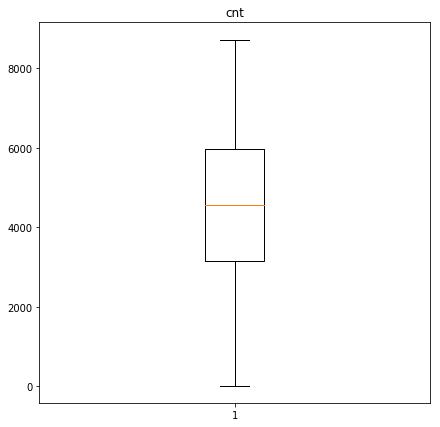

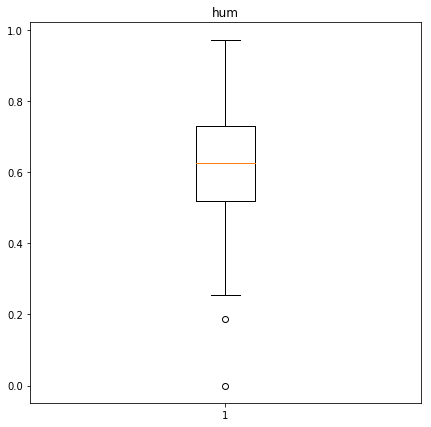

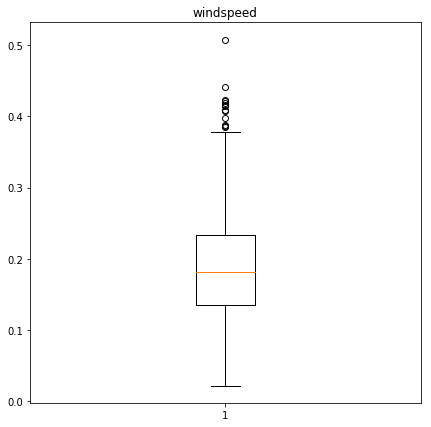

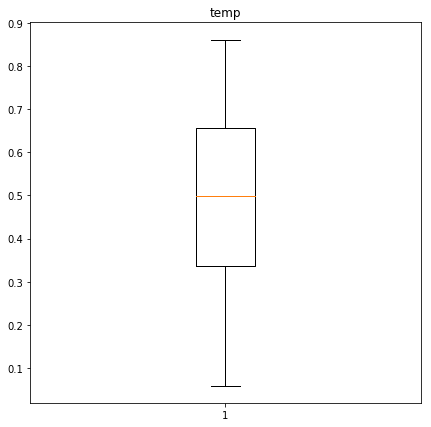

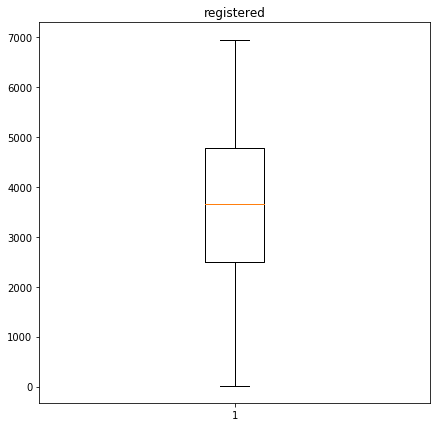

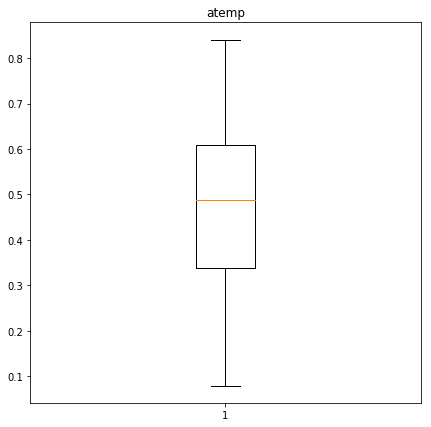

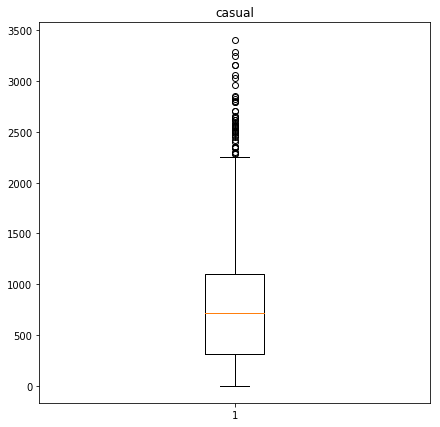

In [158]:
list(map(outlier_analysis, continuous_variables))

In [159]:
#Cross check whether the outliers have been removed
#list(map(plotting, continuous_variables))

## Normatily Check

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f57d661a400>,
      dtype=object)

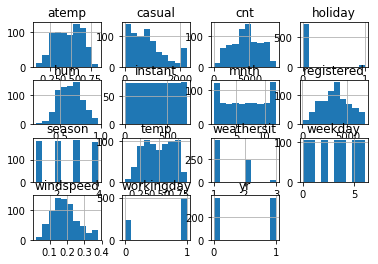

In [160]:
bike_rental.hist()

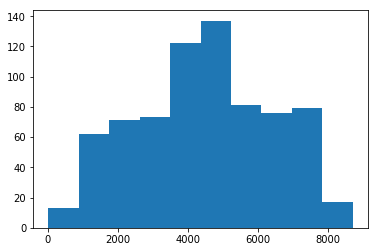

In [162]:
#The distribution of Registered users is same as Count
plt.hist(bike_rental['cnt'])
plt.savefig(save_outliers + " cnt.png")

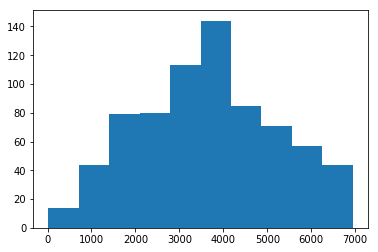

In [163]:
plt.hist(bike_rental['registered'])
plt.savefig(save_outliers + " registered.png")

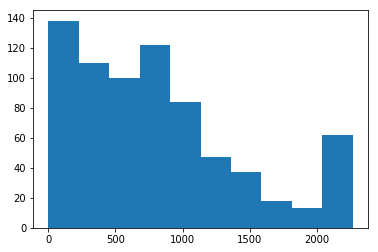

In [164]:
plt.hist(bike_rental['casual'])
plt.savefig(save_outliers + " casual.png")

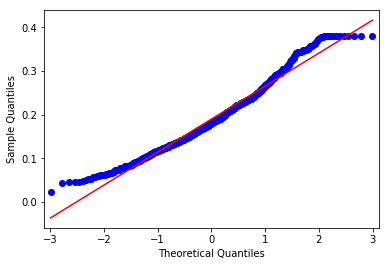

In [165]:
#Q-Q Plot
fig = sm.qqplot(bike_rental['windspeed'], line='s')
plt.savefig(save_outliers + "windspeed_qq.png")
plt.show()

## Calculate the Month-wise Aggregate Bike Count

In [166]:
'''
#Calculate the Month-wise Average 
    for group, frame in data.groupby('mnth'):
        monthly_count[group] = np.average(frame[variable])
'''

"\n#Calculate the Month-wise Average \n    for group, frame in data.groupby('mnth'):\n        monthly_count[group] = np.average(frame[variable])\n"

In [167]:
def get_label_color(data):
    if(len(np.unique(np.array(data['yr']))) == 2):
        label, color = 'Year 2011 and Year 2012', 'yellow'
    elif(data.loc[list(data.index)[0],'yr'] == 0):
        label, color = 'Year 2011', 'red'
    else:
        label, color = 'Year 2012', 'blue'
    return(label, color)

In [196]:
def holiday_working_plot(variable, label, holiday, working_day):
    if((holiday==1) and (working_day==0)):
        plt.title("Trend of Aggregate Monthly " + variable + " Count on Holidays(Year wise)")
        plt.savefig(os.getcwd() + "/Plots/Trend Holidays" + variable + label + ".png")
        return
    elif((holiday==0) and (working_day==1)):
        plt.title("Trend of Aggregate Monthly " + variable + " Count on Working days(Year wise)")
        plt.savefig(os.getcwd() + "/Plots/Trend Working days" + variable + label + ".png")
        return

In [197]:
def monthly_avg_cnt(data, variable, holiday = 0, working_day = 0):
    fig = plt.figure(figsize=(8,8))
    label, color = get_label_color(data)
    
    #Creating a dictionary to store monthly count
    months = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
    
    monthly_count = dict()
    for key in months:
        if(color=='yellow'):
            monthly_count[key] = 0
            continue
        monthly_count[key+label[-2:]] = 0 
    
    #Calculate the Month-wise Average using groupby
    for group, frame in data.groupby('mnth'):
        total_count = np.sum(frame[variable])
        if(color=='yellow'):
            monthly_count[months[group-1]] = total_count
            continue
        monthly_count[months[group-1]+label[-2:]] = total_count
    
    #Create a data frame of Monthly Count and delete monthly count dictionary
    monthly_count_df = pd.DataFrame({'Months':list(monthly_count.keys()), 'Counts':list(monthly_count.values())}, columns=['Months', 'Counts'])
    
    #Create a Plot
    plt.plot(monthly_count_df['Months'], monthly_count_df['Counts'], 'o-', color = color, label=label)
    plt.legend(loc="lower right")
    if(variable=='cnt'):
        variable = "Total"

    plt.xlabel('Months')
    plt.ylabel('Count')
    if((holiday==0) and (working_day==0)):
        plt.title("Trend of Aggregate Monthly " + variable + " Count(Year wise)")
        plt.savefig(os.getcwd() + "/Plots/Trend " + variable + label + ".png")
    else:
        holiday_working_plot(variable, label, holiday, working_day)

## Calculate Monthly Count for All Users

In [170]:
#Removing the variables casual and registered
if('casual' in continuous_variables):
    continuous_variables.remove('casual')
if('registered' in continuous_variables):
    continuous_variables.remove('registered')

#Check if the variables are removed
print(('casual' in continuous_variables) or ('registered' in continuous_variables))

False


[None]

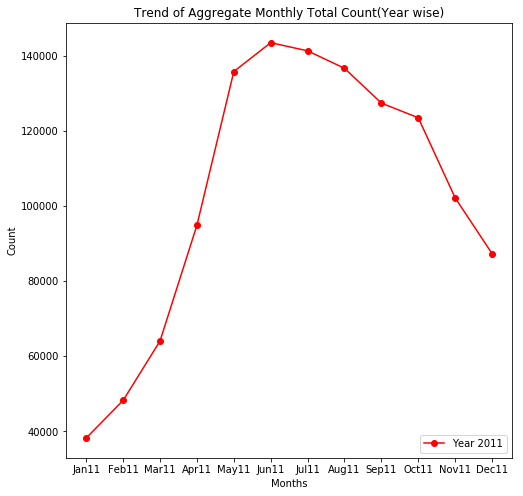

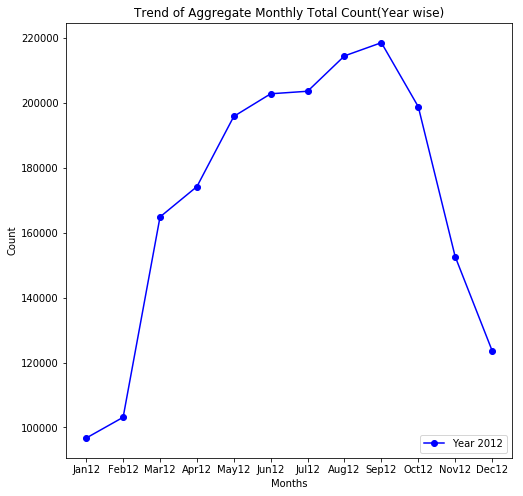

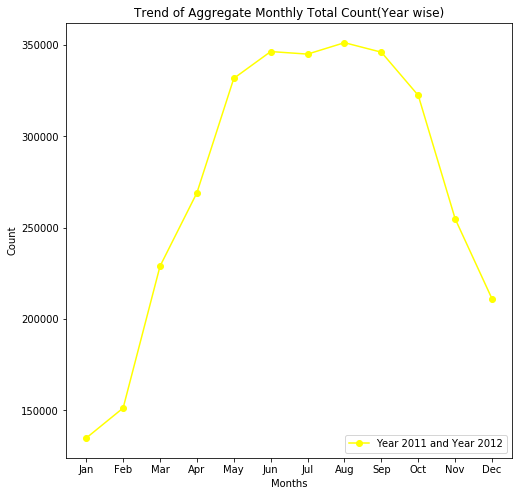

In [201]:
count_2011 = bike_rental[bike_rental['yr']==0]
count_2012 = bike_rental[bike_rental['yr']==1]
[monthly_avg_cnt(year, 'cnt') for year in [count_2011]]
[monthly_avg_cnt(year, 'cnt') for year in [count_2012]]
[monthly_avg_cnt(year, 'cnt') for year in [bike_rental]]

## Calculate Monthly Count for Casual Users and Registered Users

[None, None, None]

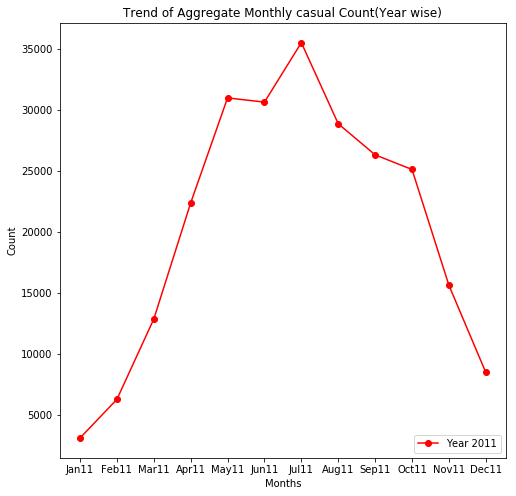

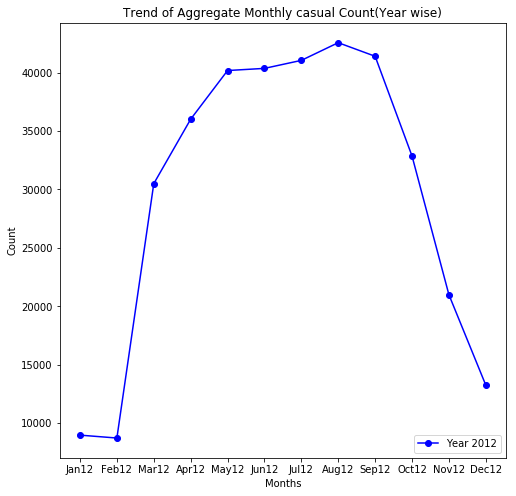

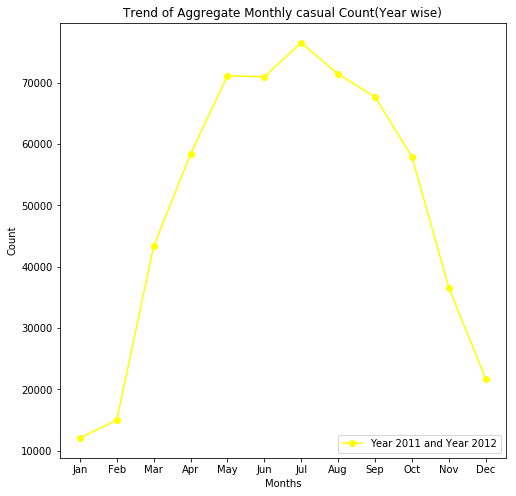

In [172]:
[monthly_avg_cnt(year, 'casual') for year in [count_2011, count_2012, bike_rental]]

[None, None, None]

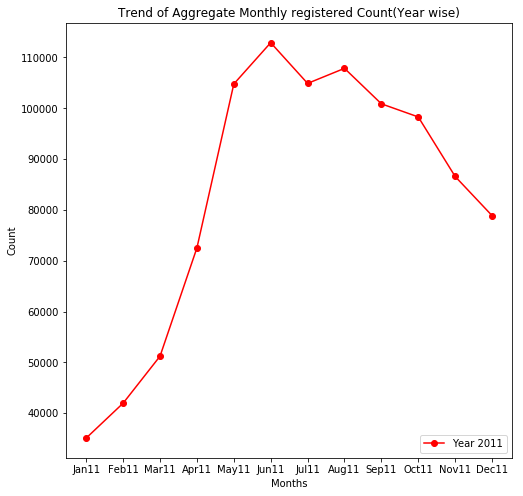

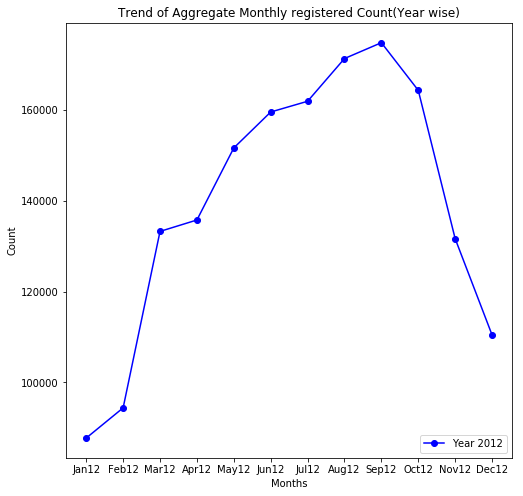

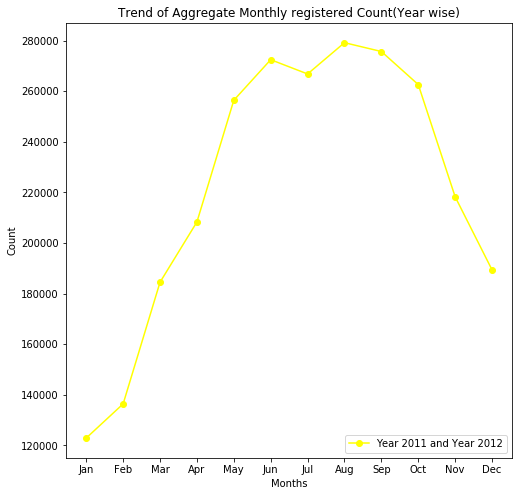

In [173]:
[monthly_avg_cnt(year, 'registered') for year in [count_2011, count_2012, bike_rental]]

## Correlation Analysis

In [174]:
def correlation(data):
    data_corr = data.corr()
    f,ax = plt.subplots(figsize=(11,11))
    sbn.heatmap(data_corr,#The correlation matrix
                mask = np.zeros_like(data_corr, dtype=np.bool), #Create a grid below
                cmap = sbn.diverging_palette(220,10,as_cmap=True), #Add color to map
                square = True,
                annot = True,
                ax = ax)
    plt.savefig(os.getcwd() + "/Plots/Correlation Chart.png")

In [175]:
continuous_variables

['cnt', 'hum', 'windspeed', 'temp', 'atemp']

In [176]:
categorical_variables

['season', 'yr', 'mnth', 'holiday', 'weekday', 'workingday', 'weathersit']

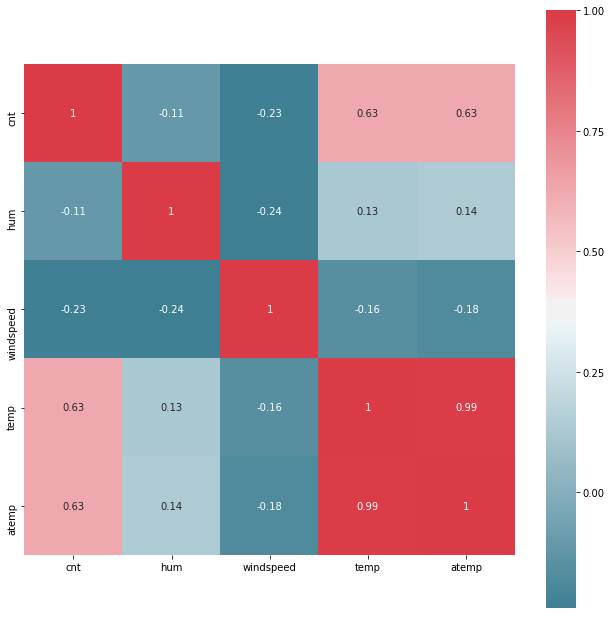

In [177]:
correlation(bike_rental[continuous_variables])

In [178]:
#Removing 'atemp'
continuous_variables.remove('atemp')

In [179]:
continuous_variables

['cnt', 'hum', 'windspeed', 'temp']

In [180]:
#Find the Karl Pearson's Coefficient of Correlation
def Karl_Pearsons_Coeff(variable_tuple):
    v_0 = np.array(bike_rental[variable_tuple[0]])
    v_1 = np.array(bike_rental[variable_tuple[1]])
    
    v_0_mean = np.mean(v_0)
    v_1_mean = np.mean(v_1)
    
    numerator = np.mean(np.array([(ele_0-v_0_mean)*(ele_1-v_1_mean) for ele_0, ele_1 in zip(v_0,v_1)]))
    SD_v_0 = np.sqrt(np.mean(np.array([(ele_0-v_0_mean)**2 for ele_0 in v_0])))
    SD_v_1 = np.sqrt(np.mean(np.array([(ele_1-v_1_mean)**2 for ele_1 in v_1])))
    denominator = SD_v_0 * SD_v_1
    
    return (numerator/denominator)

In [181]:
#variable_check = ['instant', 'yr', 'temp', 'atemp', 'casual', 'root_casual', 'registered']
result_corr_target = [Karl_Pearsons_Coeff(('cnt',var)) for var in continuous_variables]

In [182]:
print("\n".join("Count and " + var + " " + str(ele) for ele,var in zip(result_corr_target, continuous_variables)))

Count and cnt 0.9999999999999999
Count and hum -0.10566445991444025
Count and windspeed -0.23365727117239954
Count and temp 0.6274940090334921


In [183]:
#help(np.correlate)

In [184]:
#VIF = (1-r**2)**(-1)
result_VIF_target = list(map(lambda r:(1-r**2)**(-1), result_corr_target))

In [186]:
print("\n".join("Count and " + var + " " + str(ele) for ele,var in zip(result_VIF_target, continuous_variables)))

Count and cnt 4503599627370496.0
Count and hum 1.0112910423292183
Count and windspeed 1.0577485437163445
Count and temp 1.6494810844101202


## Chi-Squared Test

In [187]:
for cat in categorical_variables:
    print (cat)
    chi2, p, dof, ex = chi2_contingency(pd.crosstab(bike_rental['cnt'], bike_rental[cat]))
    print("{}\t{}\t{}\t{}\n" .format(chi2, p, dof, ex))

season
2077.1965112648404	0.5440596338517547	2085	[[0.24760602 0.25170999 0.25718194 0.24350205]
 [0.24760602 0.25170999 0.25718194 0.24350205]
 [0.24760602 0.25170999 0.25718194 0.24350205]
 ...
 [0.24760602 0.25170999 0.25718194 0.24350205]
 [0.24760602 0.25170999 0.25718194 0.24350205]
 [0.24760602 0.25170999 0.25718194 0.24350205]]

yr
706.9999550864586	0.367724209978971	695	[[0.49931601 0.50068399]
 [0.49931601 0.50068399]
 [0.49931601 0.50068399]
 ...
 [0.49931601 0.50068399]
 [0.49931601 0.50068399]
 [0.49931601 0.50068399]]

mnth
7646.882611771365	0.49177634472851	7645	[[0.08481532 0.07797538 0.08481532 ... 0.08481532 0.08207934 0.08481532]
 [0.08481532 0.07797538 0.08481532 ... 0.08481532 0.08207934 0.08481532]
 [0.08481532 0.07797538 0.08481532 ... 0.08481532 0.08207934 0.08481532]
 ...
 [0.08481532 0.07797538 0.08481532 ... 0.08481532 0.08207934 0.08481532]
 [0.08481532 0.07797538 0.08481532 ... 0.08481532 0.08207934 0.08481532]
 [0.08481532 0.07797538 0.08481532 ... 0.08481

In [188]:
#Check the correlation amongst the independent categorical variables.

select_categorical = defaultdict(list)   #Contains the list of categorical variables that are selected

for cat_var_1 in categorical_variables:
    for cat_var_2 in categorical_variables:
        if(cat_var_1!=cat_var_2):
            chi2, p, dof, ex = chi2_contingency(pd.crosstab(bike_rental[cat_var_1], bike_rental[cat_var_2]))
            if(p>=0.05):
                
                select_categorical[cat_var_1].append(cat_var_2)
                

In [189]:
select_categorical

defaultdict(list,
            {'season': ['yr', 'holiday', 'weekday', 'workingday'],
             'yr': ['season',
              'mnth',
              'holiday',
              'weekday',
              'workingday',
              'weathersit'],
             'mnth': ['yr', 'holiday', 'weekday', 'workingday'],
             'holiday': ['season', 'yr', 'mnth', 'weathersit'],
             'weekday': ['season', 'yr', 'mnth', 'weathersit'],
             'workingday': ['season', 'yr', 'mnth', 'weathersit'],
             'weathersit': ['yr', 'holiday', 'weekday', 'workingday']})

In [190]:
select_categorical.keys()

dict_keys(['season', 'yr', 'mnth', 'holiday', 'weekday', 'workingday', 'weathersit'])

In [191]:
select_categorical.values()

dict_values([['yr', 'holiday', 'weekday', 'workingday'], ['season', 'mnth', 'holiday', 'weekday', 'workingday', 'weathersit'], ['yr', 'holiday', 'weekday', 'workingday'], ['season', 'yr', 'mnth', 'weathersit'], ['season', 'yr', 'mnth', 'weathersit'], ['season', 'yr', 'mnth', 'weathersit'], ['yr', 'holiday', 'weekday', 'workingday']])

### Monthly Aggregate Rental Count when Weather is Cloudy(1 or 2) and it's a Holiday

In [192]:
holiday = bike_rental.loc[(bike_rental['workingday']==0) & ((bike_rental['weathersit'] == 1) | ((bike_rental['weathersit'] == 2))), ["workingday","weathersit","yr","mnth","cnt"]]

[None, None, None]

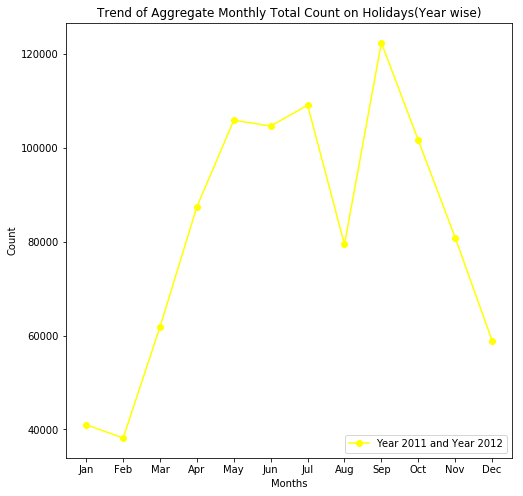

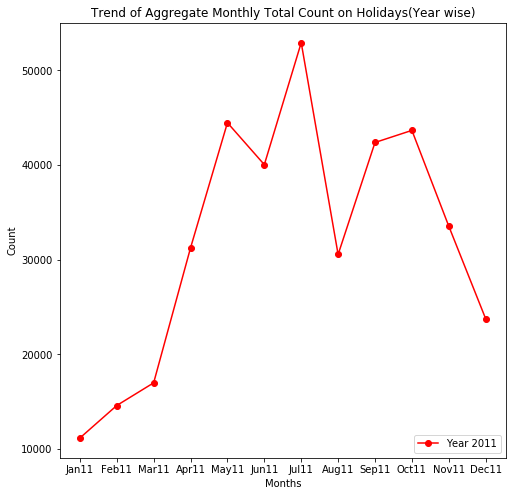

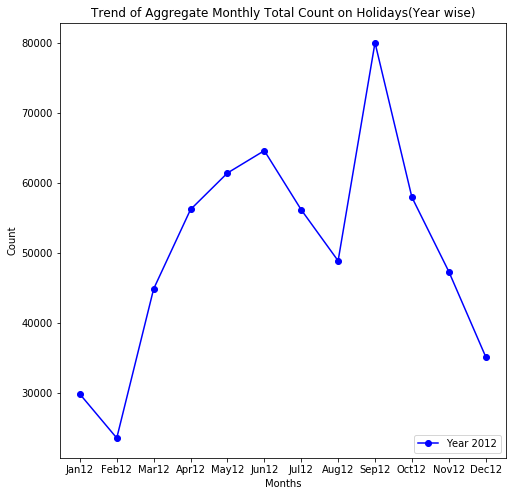

In [198]:
#Find the monthly average count
holiday_2011 = holiday[holiday['yr']==0]
holiday_2012 = holiday[holiday['yr']==1]
[monthly_avg_cnt(holi, 'cnt', 1, 0) for holi in [holiday, holiday_2011, holiday_2012]]

### Monthly Aggregate Rental Count when Weather is Cloudy(1 or 2) and it's a Working day

In [199]:
working_day = bike_rental.loc[(bike_rental['workingday']==1) & ((bike_rental['weathersit'] == 1) | ((bike_rental['weathersit'] == 2))), ["workingday","weathersit","yr","mnth","cnt"]]

[None, None, None]

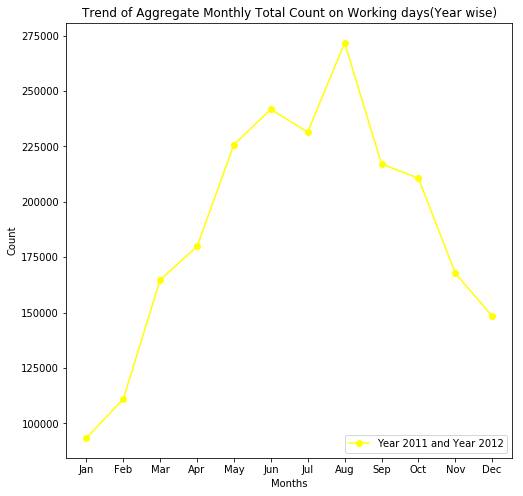

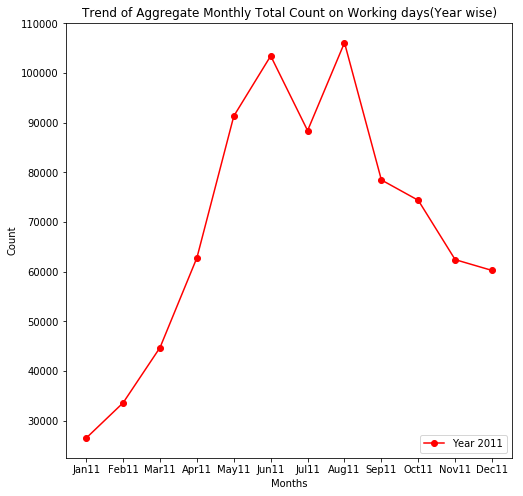

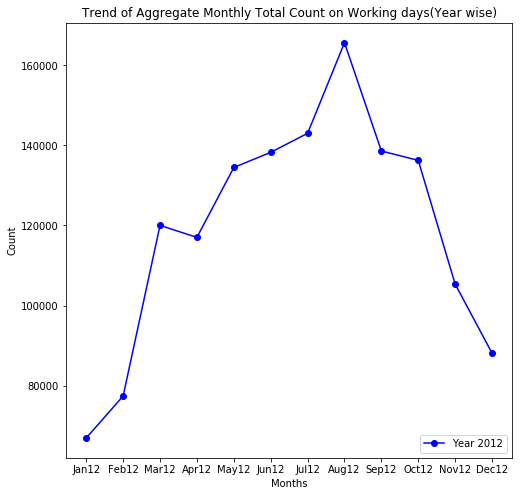

In [202]:
#Find the monthly average count
working_day_2011 = working_day[working_day['yr']==0]
working_day_2012 = working_day[working_day['yr']==1]
[monthly_avg_cnt(working, 'cnt', 0, 1) for working in [working_day, working_day_2011, working_day_2012]]

### Monthly Aggregate Rental Count when Weather is Rainy or Snowy(3 or 4) and it's a Holiday

In [57]:
#Rainy Weather
holiday_rainy = bike_rental.loc[(bike_rental['workingday']==0) & (bike_rental['weathersit'] == 3), ["workingday","weathersit","yr","mnth","cnt"]]

[None, None, None]

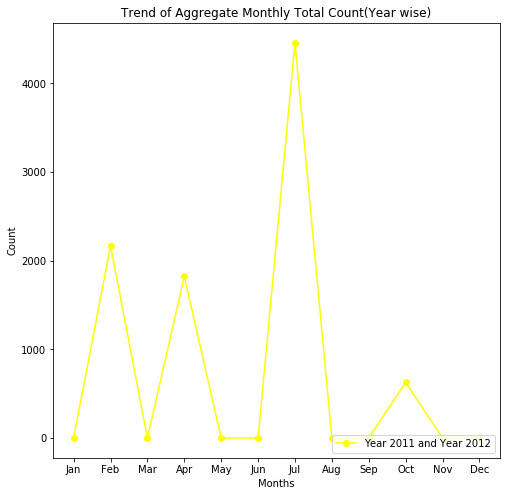

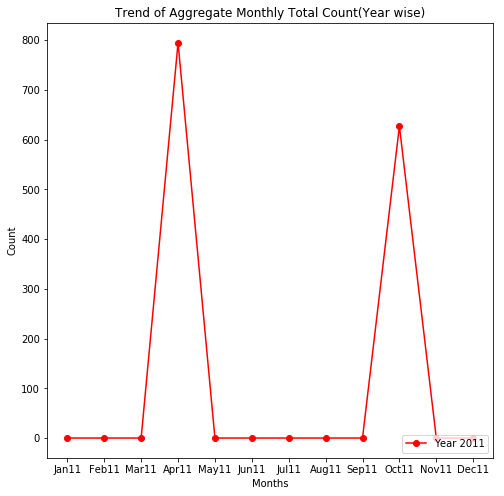

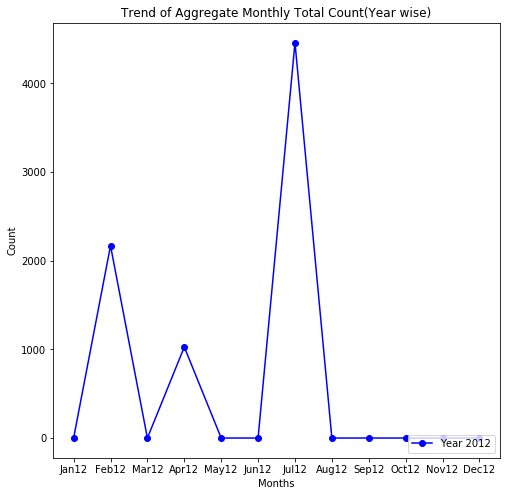

In [58]:
#Find the monthly average count
holiday_rainy_2011 = holiday_rainy[holiday_rainy['yr']==0]
holiday_rainy_2012 = holiday_rainy[holiday_rainy['yr']==1]
[monthly_avg_cnt(holi_rainy, 'cnt') for holi_rainy in [holiday_rainy, holiday_rainy_2011, holiday_rainy_2012]]

In [59]:
#Compare the rainy Holidays of 2012 and 2011
holiday_rainy_2011

,workingday,weathersit,yr,mnth,cnt
105,0,3,0,4,795.0
301,0,3,0,10,627.0


In [60]:
holiday_rainy_2012

,workingday,weathersit,yr,mnth,cnt
406,0,3,1,2,2169.0
477,0,3,1,4,1027.0
567,0,3,1,7,4459.0


In [61]:
#Heavily Snowy Weather
holiday_snowy = bike_rental.loc[(bike_rental['workingday']==0) & (bike_rental['weathersit'] == 4), ["workingday","weathersit","yr","mnth","cnt"]]

In [62]:
holiday_snowy

,workingday,weathersit,yr,mnth,cnt


In [63]:
'''
#Find the monthly average count
holiday_snowy_2011 = holiday_snowy[holiday_snowy['yr']==0]
holiday_snowy_2012 = holiday_snowy[holiday_snowy['yr']==1]
[monthly_avg_cnt(holi_snowy, 'cnt') for holi_snowy in [holiday_snowy, holiday_snowy_2011, holiday_snowy_2012]]
'''

"\n#Find the monthly average count\nholiday_snowy_2011 = holiday_snowy[holiday_snowy['yr']==0]\nholiday_snowy_2012 = holiday_snowy[holiday_snowy['yr']==1]\n[monthly_avg_cnt(holi_snowy, 'cnt') for holi_snowy in [holiday_snowy, holiday_snowy_2011, holiday_snowy_2012]]\n"

In [64]:
#Rainy or Snowy
holiday_rainy_snowy = bike_rental.loc[(bike_rental['workingday']==0) & ((bike_rental['weathersit'] == 3) | ((bike_rental['weathersit'] == 4))), ["workingday","weathersit","yr","mnth","cnt"]]

In [65]:
holiday_rainy_snowy

,workingday,weathersit,yr,mnth,cnt
105,0,3,0,4,795.0
301,0,3,0,10,627.0
406,0,3,1,2,2169.0
477,0,3,1,4,1027.0
567,0,3,1,7,4459.0


[None, None, None]

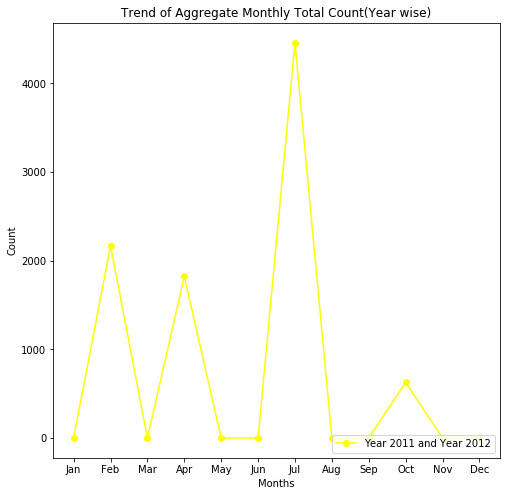

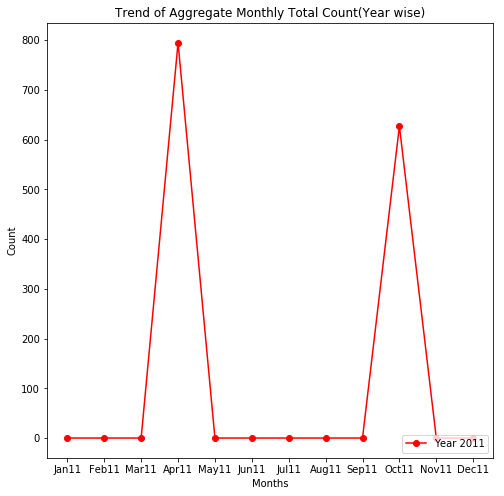

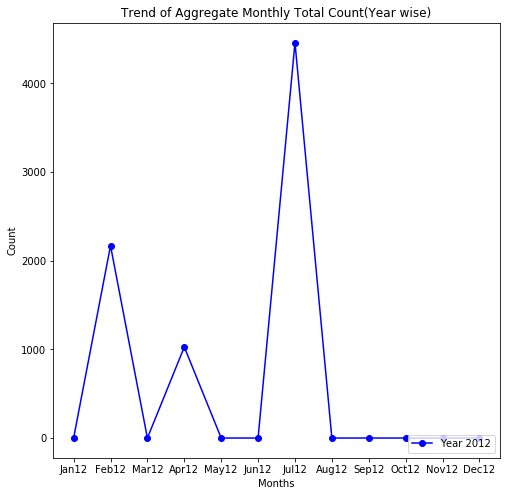

In [66]:
#Find the monthly average count

holiday_rainy_snowy_2011 = holiday_rainy_snowy[holiday_rainy_snowy['yr']==0]
holiday_rainy_snowy_2012 = holiday_rainy_snowy[holiday_rainy_snowy['yr']==1]
[monthly_avg_cnt(holi_rainy_snowy, 'cnt') for holi_rainy_snowy in [holiday_rainy_snowy, holiday_rainy_snowy_2011, holiday_rainy_snowy_2012]]

### Monthly Aggregate Rental Count when Weather is Rainy or Snowy(3 or 4) and it's a Working day

In [67]:
#Rainy Weather
workingday_rainy = bike_rental.loc[(bike_rental['workingday']==1) & (bike_rental['weathersit'] == 3), ["workingday","weathersit","yr","mnth","cnt"]]

[None, None, None]

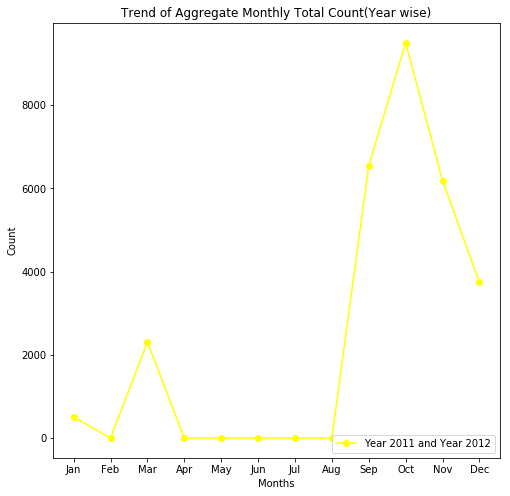

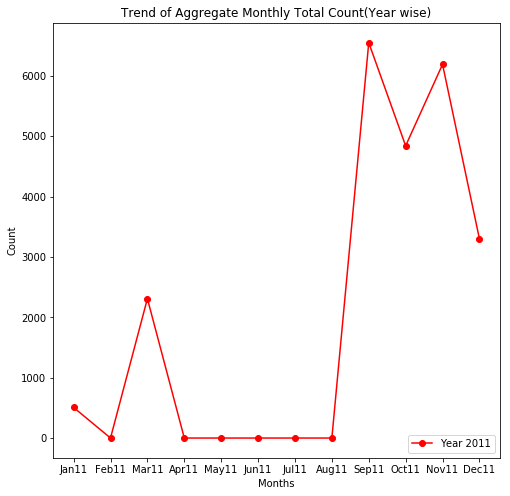

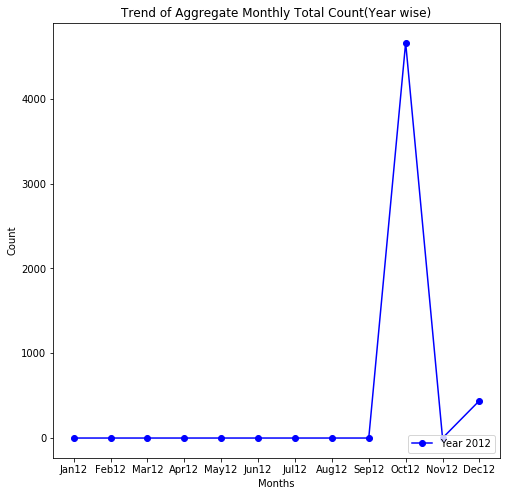

In [68]:
#Find the monthly average count
workingday_rainy_2011 = workingday_rainy[workingday_rainy['yr']==0]
workingday_rainy_2012 = workingday_rainy[workingday_rainy['yr']==1]
[monthly_avg_cnt(working_rainy, 'cnt') for working_rainy in [workingday_rainy, workingday_rainy_2011, workingday_rainy_2012]]

In [69]:
#Heavily Snowy Weather
workingday_snowy = bike_rental.loc[(bike_rental['workingday']==1) & (bike_rental['weathersit'] == 4), ["workingday","weathersit","yr","mnth","cnt"]]

In [70]:
workingday_snowy

,workingday,weathersit,yr,mnth,cnt


In [71]:
#Rainy or Snowy
workingday_rainy_snowy = bike_rental.loc[(bike_rental['workingday']==1) & ((bike_rental['weathersit'] == 3) | ((bike_rental['weathersit'] == 4))), ["workingday","weathersit","yr","mnth","cnt"]]

[None, None, None]

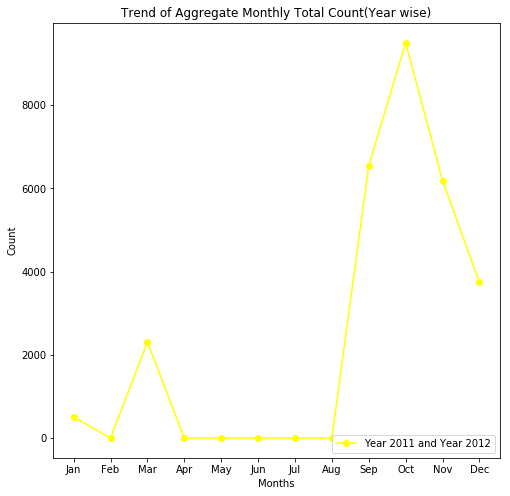

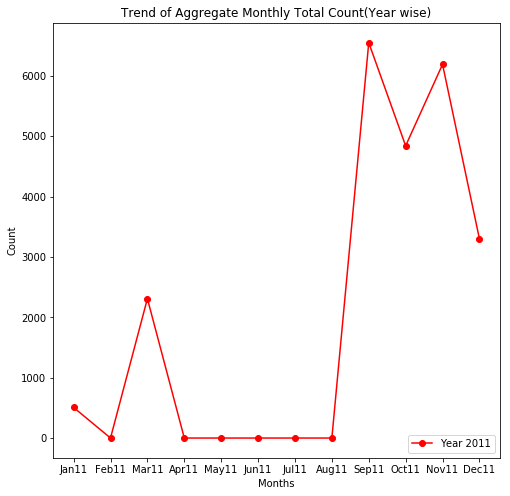

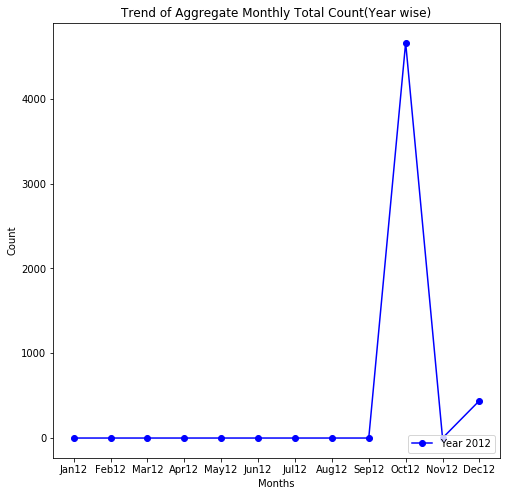

In [72]:
#Find the monthly average count

workingday_rainy_snowy_2011 = workingday_rainy_snowy[workingday_rainy_snowy['yr']==0]
workingday_rainy_snowy_2012 = workingday_rainy_snowy[workingday_rainy_snowy['yr']==1]
[monthly_avg_cnt(working_rainy_snowy, 'cnt') for working_rainy_snowy in [workingday_rainy_snowy, workingday_rainy_snowy_2011, workingday_rainy_snowy_2012]]

## Feature Selection

In [73]:
continuous_variables

['cnt', 'hum', 'windspeed', 'temp']

In [74]:
categorical_variables

['season', 'yr', 'mnth', 'holiday', 'weekday', 'workingday', 'weathersit']

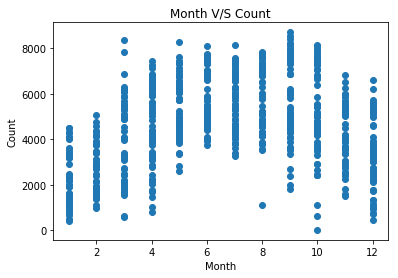

In [75]:
#Month wise count
plt.scatter(bike_rental['mnth'], bike_rental['cnt'])
plt.title("Month V/S Count")
plt.xlabel("Month")
plt.ylabel("Count")
plt.show()

In [76]:
#Splitting the data
ind_variables = continuous_variables + categorical_variables
ind_variables.remove('cnt')

In [77]:
#Karl_Pearsons_Coeff(('casual', 'root_casual'))

In [78]:
#np.corrcoef(bike_rental['casual'], bike_rental['root_casual'])

In [79]:
#type(ind_variables.remove('casual'))

In [80]:
'casual' in ind_variables

False

In [81]:
#Independent Variables
ind_variables

['hum',
 'windspeed',
 'temp',
 'season',
 'yr',
 'mnth',
 'holiday',
 'weekday',
 'workingday',
 'weathersit']

## Problematic Value

In [84]:
sorted_target = sorted(y)

In [85]:
sorted_target[:5]

[22.0, 431.0, 441.0, 506.0, 605.0]

In [ ]:
#Capping the value with value nearest to it

### Splitting The Data

In [82]:

X = bike_rental[ind_variables]
y = bike_rental['cnt']

In [83]:
#Splitting the data into training and testing set
def splitting_data(X, y, case='time series'):
    if(case!='time series'):
        X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.25, random_state=42)
        return(X_train, X_test, y_train, y_test)
    
    #Receive the independent and dependent variables as input
    ind = list(X.loc[(X['mnth']==6) & (X['yr']==1), :].index)[0]
    
    X_train, X_test, y_train, y_test = X.iloc[:ind,:], X.iloc[ind:,:], y[:ind], y[ind:]

    y_train, y_test = np.array(y_train).reshape(len(y_train), 1), np.array(y_test).reshape(len(y_test), 1)
    return(X_train, X_test, y_train, y_test)

In [84]:
X_train, X_test, y_train, y_test = splitting_data(X,y)

In [85]:
print("X_train:- {}\tX_test:- {}\ny_train:- {}\ty_test:- {}\n" .format(X_train.shape,X_test.shape, y_train.shape, y_test.shape))

X_train:- (517, 10)	X_test:- (214, 10)
y_train:- (517, 1)	y_test:- (214, 1)



In [86]:
X_train.isna().sum()

hum           0
windspeed     0
temp          0
season        0
yr            0
mnth          0
holiday       0
weekday       0
workingday    0
weathersit    0
dtype: int64

In [87]:
X_train.isna().sum()

hum           0
windspeed     0
temp          0
season        0
yr            0
mnth          0
holiday       0
weekday       0
workingday    0
weathersit    0
dtype: int64

In [88]:
np.nan in np.unique(np.array(y_train))

False

In [89]:
class Modelling():
    base_path = os.getcwd() + "/Models/"
    def __init__(self, X_train, X_test, y_train, y_test, model, model_name):
        self.X_train = X_train
        self.X_test = X_test
        self.y_train = y_train
        self.y_test = y_test
        self.model = model
        self.model_name = model_name
        
    def evaluate(self, actual, predicted):
        actual = list(actual)
        predicted = list(predicted)
        result_df = pd.DataFrame({'Actual':actual, 'Predicted':predicted}, columns=['Actual','Predicted'])
        print("RMSE:- {}\nR_Squared:- {}\n" .format(np.sqrt(mean_squared_error(actual, predicted)), r2_score(actual, predicted)))
        print("RMSLE:- {}\n" .format(np.sqrt(mean_squared_log_error(actual, predicted))))
    
    def prediction(self):
        #Fit the model on training data
        model_fit = self.model.fit(self.X_train, self.y_train)
        
        #Save the Model
        joblib.dump(model_fit, self.base_path + self.model_name)
        
        #Predict on Training and Testing Data
        predicted_train = model_fit.predict(self.X_train)
        predicted_test = model_fit.predict(self.X_test)
        #temp_y_test = self.y_test
        
        if(self.model_name=='Linear Regression' and (22 in list(self.y_test))):
            #Check weather predicted the actual value contains problamatic value 22.0
            
            ind = [i for i in range(len(self.y_test)) if(temp_y_test[i]==22.0)]
            temp_y_test[ind[0]] = 431  
        
        #Evaluate the Performance
        print("Results obtained on Training Data:-")
        self.evaluate(self.y_train, predicted_train)
        
        print("Results obtained on Testing Data:-")
        self.evaluate(self.y_test, predicted_test)
        

In [90]:
class Modelling():
    base_path = os.getcwd() + "/Models/"
    def __init__(self, X_train, X_test, y_train, y_test, model, model_name):
        self.X_train = X_train
        self.X_test = X_test
        self.y_train = y_train
        self.y_test = y_test
        self.model = model
        self.model_name = model_name
        
    def evaluate(self, actual, predicted):
        actual = list(actual)
        predicted = list(predicted)
        result_df = pd.DataFrame({'Actual':actual, 'Predicted':predicted}, columns=['Actual','Predicted'])
        print("RMSE:- {}\nR_Squared:- {}\n" .format(np.sqrt(mean_squared_error(actual, predicted)), r2_score(actual, predicted)))
        print("RMSLE:- {}\n" .format(np.sqrt(mean_squared_log_error(actual, predicted))))
    
    def prediction(self):
        #Fit the model on training data
        model_fit = self.model.fit(self.X_train, self.y_train)
        
        #Save the Model
        joblib.dump(model_fit, self.base_path + self.model_name)
        
        #Predict on Training and Testing Data
        predicted_train = model_fit.predict(self.X_train)
        predicted_test = model_fit.predict(self.X_test)
        temp_y_test = self.y_test
        if(self.model_name=='Linear Regression' and (22 in list(self.y_test))):
            #Check weather predicted the actual value contains problamatic value 22.0
            ind = [i for i in range(len(self.y_test)) if(temp_y_test[i]==22.0)]
            temp_y_test[ind[0]] = 431.0
            
        #Evaluate the Performance
        print("Results obtained on Training Data:-")
        self.evaluate(self.y_train, predicted_train)
        
        print("Results obtained on Testing Data:-")
        self.evaluate(temp_y_test, predicted_test)
        
        del temp_y_test

### Simple Linear Regression

In [203]:
lr = LR()
linear = Modelling(X_train, X_test, y_train, y_test, lr, "Linear Regression")

In [204]:
linear.prediction()

Results obtained on Training Data:-
RMSE:- 746.7186497984547
R_Squared:- 0.7830814578966211

RMSLE:- 0.277573145250659

Results obtained on Testing Data:-
RMSE:- 1133.6761021506811
R_Squared:- 0.5359327706398294

RMSLE:- 0.32904808374557604



In [93]:
y_train[150]

array([3982.])

In [94]:
y_test[150]

array([431.])

### Results obtained by using only Contineous variables

In [95]:
#Consider only continuous variables
feature_list_2 = [var for var in ind_variables if(var not in categorical_variables)]

In [96]:
linear_feature_list_2 = Modelling(X_train[feature_list_2], X_test[feature_list_2], y_train, y_test, lr, "Linear Regression_feature_list_2")

In [206]:
linear_feature_list_2.prediction()

Results obtained on Training Data:-
RMSE:- 1168.347855808319
R_Squared:- 0.4689602726146076

RMSLE:- 0.3698154854068044

Results obtained on Testing Data:-
RMSE:- 2130.9874894356117
R_Squared:- -0.6397012124543491

RMSLE:- 0.44334980430286347



In [98]:
select_categorical['season']

['yr', 'holiday', 'weekday', 'workingday']

### Adding the Variable 'Season' to the feature_list_2

In [99]:
feature_list_3 = feature_list_2 + select_categorical['season']

In [100]:
linear_feature_list_3 = Modelling(X_train[feature_list_3], X_test[feature_list_3], y_train, y_test, lr, "Linear Regression_feature_list_3")

In [205]:
linear_feature_list_3.prediction()

Results obtained on Training Data:-
RMSE:- 852.563255993825
R_Squared:- 0.7172283258218852

RMSLE:- 0.2858212384968244

Results obtained on Testing Data:-
RMSE:- 1327.9012523011575
R_Squared:- 0.3633005442940359

RMSLE:- 0.34125304048049504



### Adding the Variable 'weathersit' to the feature_list_2

In [103]:
feature_list_4 = feature_list_2 + select_categorical['weathersit']

In [104]:
linear_feature_list_4 = Modelling(X_train[feature_list_4], X_test[feature_list_4], y_train, y_test, lr, "Linear Regression_feature_list_4")

In [207]:
linear_feature_list_4.prediction()

Results obtained on Training Data:-
RMSE:- 852.563255993825
R_Squared:- 0.7172283258218852

RMSLE:- 0.2858212384968244

Results obtained on Testing Data:-
RMSE:- 1327.9012523011575
R_Squared:- 0.3633005442940359

RMSLE:- 0.34125304048049504



### Adding the Variable 'mnth' to the feature_list_2

In [106]:
feature_list_5 = feature_list_2 + select_categorical['mnth']

In [107]:
linear_feature_list_5 = Modelling(X_train[feature_list_5], X_test[feature_list_5], y_train, y_test, lr, "Linear Regression_feature_list_5")

In [208]:
linear_feature_list_5.prediction()

Results obtained on Training Data:-
RMSE:- 852.563255993825
R_Squared:- 0.7172283258218852

RMSLE:- 0.2858212384968244

Results obtained on Testing Data:-
RMSE:- 1327.9012523011575
R_Squared:- 0.3633005442940359

RMSLE:- 0.34125304048049504



### XGBoost Regression

In [109]:
#help(xgb)

In [114]:
help(xgb.XGBRegressor)

Help on class XGBRegressor in module xgboost.sklearn:

class XGBRegressor(XGBModel, sklearn.base.RegressorMixin)
 |  Implementation of the scikit-learn API for XGBoost regression.
 |  
 |  Parameters
 |  ----------
 |  max_depth : int
 |      Maximum tree depth for base learners.
 |  learning_rate : float
 |      Boosting learning rate (xgb's "eta")
 |  n_estimators : int
 |      Number of boosted trees to fit.
 |  silent : boolean
 |      Whether to print messages while running boosting.
 |  objective : string or callable
 |      Specify the learning task and the corresponding learning objective or
 |      a custom objective function to be used (see note below).
 |  booster: string
 |      Specify which booster to use: gbtree, gblinear or dart.
 |  nthread : int
 |      Number of parallel threads used to run xgboost.  (Deprecated, please use ``n_jobs``)
 |  n_jobs : int
 |      Number of parallel threads used to run xgboost.  (replaces ``nthread``)
 |  gamma : float
 |      Minimum lo

### Tuning The Hyper-parameters

In [117]:
learning_rate = [0.1, 0.08, 0.06, 0.04, 0.02, 0.01]
n_estimators = [100, 150, 200, 250, 300, 350, 400]
booster = ['gbtree', 'gblinear', 'dart']
objective = ['reg:linear', 'reg:tweedie']
nthread = [4]
subsample = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.8, 0.9]  #Percentage of rows taken to build a tree.
#Booster Parameters
min_child_weight = [2, 4, 6, 8, 10, 12, 14, 16] #Minimum sum of instance weight(hessian) needed in a child.
#min_samples_split = []

max_depth = [2, 4, 6, 8]
max_leaf_nodes = [2, 4, 6, 8]
#max_delta_step = []  #Maximum delta step we allow each tree's weight estimation to be.

gamma = [0, 1, 5] #Acts as Regularization Parameter
#reg_lambda = []


In [118]:
#Create a Grid of Parameter Values
xgb_grid_keys = {'booster': booster, 
        'objective': objective, 
        'max_depth': max_depth, 
        'eta': learning_rate,
        'n_estimators': n_estimators,
        'nthread': nthread, 
        'min_child_weight': min_child_weight, 
        'subsample': subsample, 
        'gamma': gamma, 
        'max_leaf_nodes': max_leaf_nodes}

In [119]:
[xgb_grid_keys]

[{'booster': ['gbtree', 'gblinear', 'dart'],
  'objective': ['reg:linear', 'reg:tweedie'],
  'max_depth': [2, 4, 6, 8],
  'eta': [0.1, 0.08, 0.06, 0.04, 0.02, 0.01],
  'n_estimators': [100, 150, 200, 250, 300, 350, 400],
  'nthread': [4],
  'min_child_weight': [2, 4, 6, 8, 10, 12, 14, 16],
  'subsample': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.8, 0.9],
  'gamma': [0, 1, 5],
  'max_leaf_nodes': [2, 4, 6, 8]}]

In [209]:
'''
regressor = xgb.XGBRegressor()
grid_search = GridSearchCV(estimator=regressor, param_grid=[xgb_grid_keys],
                           cv = 5, scoring = 'neg_mean_squared_error', n_jobs=-1)
grid_search = grid_search.fit(X_train, y_train)
print(grid_search.best_params_)
'''

"\nregressor = xgb.XGBRegressor()\ngrid_search = GridSearchCV(estimator=regressor, param_grid=[xgb_grid_keys],\n                           cv = 5, scoring = 'neg_mean_squared_error', n_jobs=-1)\ngrid_search = grid_search.fit(X_train, y_train)\nprint(grid_search.best_params_)\n"

In [ ]:
xgb_grid_keys_list = list(xgb_grid_keys.keys())

In [ ]:
#xgb_grid_keys_list

In [166]:
def xgb_trial(X_train,X_test, y_train, y_test):
    for boost in xgb_grid_keys[xgb_grid_keys_list[0]]:
        for obj in xgb_grid_keys[xgb_grid_keys_list[1]]:
            for max_depth in xgb_grid_keys[xgb_grid_keys_list[2]]:
                for eta in xgb_grid_keys[xgb_grid_keys_list[3]]:
                    for n_est in xgb_grid_keys[xgb_grid_keys_list[4]]:
                        for nthread in xgb_grid_keys[xgb_grid_keys_list[5]]:
                            for mcw in xgb_grid_keys[xgb_grid_keys_list[6]]:
                                for sub_samp in xgb_grid_keys[xgb_grid_keys_list[7]]:
                                    for gamma in xgb_grid_keys[xgb_grid_keys_list[8]]:
                                        for mln in xgb_grid_keys[xgb_grid_keys_list[9]]:
                                            #print("{}\t{}\t{}\t{}\t{}\t{}\t{}\t{}\t{}\t{}" .format(boost, obj,
                                            #                  max_depth, eta,
                                            #                  n_est, nthread,
                                            #                  mcw, sub_samp,
                                            #                  gamma, mln))
                                            xgb_model = xgb.XGBRegressor(booster=boost,
                                                   objective=obj,
                                                   max_depth=max_depth,
                                                   eta = eta,
                                                   n_estimators = n_est,
                                                   nthread = nthread,
                                                   min_child_weight = mcw,
                                                   subsample = sub_samp,
                                                   gamma = gamma,
                                                   max_leaf_nodes = mln)
                                            xgb_model = Modelling(X_train, X_test, y_train, y_test, xgb_model, "XGBoost Regression")
                                            xgb_model.prediction()

In [181]:
#xgb_trial(X_train,X_test, y_train, y_test)

## Random Forest Regression

In [183]:
help(RFR)

Help on class RandomForestRegressor in module sklearn.ensemble.forest:

class RandomForestRegressor(ForestRegressor)
 |  A random forest regressor.
 |  
 |  A random forest is a meta estimator that fits a number of classifying
 |  decision trees on various sub-samples of the dataset and use averaging
 |  to improve the predictive accuracy and control over-fitting.
 |  The sub-sample size is always the same as the original
 |  input sample size but the samples are drawn with replacement if
 |  `bootstrap=True` (default).
 |  
 |  Read more in the :ref:`User Guide <forest>`.
 |  
 |  Parameters
 |  ----------
 |  n_estimators : integer, optional (default=10)
 |      The number of trees in the forest.
 |  
 |  criterion : string, optional (default="mse")
 |      The function to measure the quality of a split. Supported criteria
 |      are "mse" for the mean squared error, which is equal to variance
 |      reduction as feature selection criterion, and "mae" for the mean
 |      absolute 

In [167]:
rfr = RFR(n_estimators = 100, max_features = 8, max_depth=6, min_samples_split = 2, min_samples_leaf=2)

In [168]:
rfr.fit(X_train, y_train)

/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  """Entry point for launching an IPython kernel.


RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=6,
           max_features=8, max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=2,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=100, n_jobs=1, oob_score=False, random_state=None,
           verbose=0, warm_start=False)

In [169]:
#Test Error
predicted_rf = rfr.predict(X_test)
np.sqrt(mean_squared_log_error(y_test, predicted_rf))

0.3082633918815425

In [170]:
#Test R-Squared
r2_score(y_test, predicted_rf)

0.5885272067634356

In [171]:
#Train Error
predicted_train_rf = rfr.predict(X_train)
np.sqrt(mean_squared_log_error(y_train, predicted_train_rf))

0.17411742117058784

In [172]:
#Train R-Squared
r2_score(y_train, predicted_train_rf)

0.9271236767161672

### Check the results when out of bag samples are used to estimate the $R^2$ on Unseen data 

In [173]:
rfr_oob = RFR(n_estimators=100, max_features = 8, max_depth=6, min_samples_split= 2, min_samples_leaf=2, oob_score=True)

In [174]:
rfr_oob.fit(X_train, y_train)

/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  """Entry point for launching an IPython kernel.


RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=6,
           max_features=8, max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=2,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=100, n_jobs=1, oob_score=True, random_state=None,
           verbose=0, warm_start=False)

In [175]:
#Test Error
predicted_rf_oob = rfr_oob.predict(X_test)
np.sqrt(mean_squared_log_error(y_test, predicted_rf))

0.3082633918815425

In [176]:
#Test R-Squared
r2_score(y_test, predicted_rf_oob)

0.5848186584910355

In [177]:
#Train Error
predicted_train_rf_oob = rfr.predict(X_train)
np.sqrt(mean_squared_log_error(y_train, predicted_train_rf_oob))

0.17411742117058784

## Random Forest Trials

In [110]:
n_estimators = [200, 210, 230, 245, 265, 290, 300, 350]

#The minimum number of samples required to split an internal node
min_samples_split = [10, 15, 20, 25, 30, 35]

#The minimum number of samples required to be at a leaf node
min_samples_leaf = [2,4,6]

max_depth = [4, 6, 8, 12, 14, 16]
'''
Grow trees with ``max_leaf_nodes`` in best-first fashion.
Best nodes are defined as relative reduction in impurity.
If None then unlimited number of leaf nodes.
'''
max_leaf_nodes = [4, 6, 8, 10, 12, None]

max_features = [4, 6, 8, 10, 12]


In [111]:
rf_grid_keys = {'estimators': n_estimators,
                'min_samples_split': min_samples_split,
                'min_samples_leaf': min_samples_leaf,
                'max_depth': max_depth,
                'max_leaf_nodes': max_leaf_nodes,
                'max_features': max_features}
#rf_grid_keys = rf_grid_keys

In [112]:
rf_grid_keys = [rf_grid_keys]
#Note:- rf_grid_keys = list(rf_grid_keys) will not work

## Hyperparameter Tuning

In [113]:
regressor = RFR()
grid_search = GridSearchCV(estimator=regressor, param_grid=rf_grid_keys,
                           cv = 5, scoring = 'neg_mean_squared_error', n_jobs=-1)
grid_search = grid_search.fit(X_train, y_train)
print(grid_search.best_params_)

JoblibValueError: JoblibValueError
___________________________________________________________________________
Multiprocessing exception:
...........................................................................
/home/shrikrishna/anaconda3/lib/python3.6/runpy.py in _run_module_as_main(mod_name='ipykernel_launcher', alter_argv=1)
    188         sys.exit(msg)
    189     main_globals = sys.modules["__main__"].__dict__
    190     if alter_argv:
    191         sys.argv[0] = mod_spec.origin
    192     return _run_code(code, main_globals, None,
--> 193                      "__main__", mod_spec)
        mod_spec = ModuleSpec(name='ipykernel_launcher', loader=<_f...b/python3.6/site-packages/ipykernel_launcher.py')
    194 
    195 def run_module(mod_name, init_globals=None,
    196                run_name=None, alter_sys=False):
    197     """Execute a module's code without importing it

...........................................................................
/home/shrikrishna/anaconda3/lib/python3.6/runpy.py in _run_code(code=<code object <module> at 0x7f582de20030, file "/...3.6/site-packages/ipykernel_launcher.py", line 5>, run_globals={'__annotations__': {}, '__builtins__': <module 'builtins' (built-in)>, '__cached__': '/home/shrikrishna/anaconda3/lib/python3.6/site-p...ges/__pycache__/ipykernel_launcher.cpython-36.pyc', '__doc__': 'Entry point for launching an IPython kernel.\n\nTh...orts until\nafter removing the cwd from sys.path.\n', '__file__': '/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py', '__loader__': <_frozen_importlib_external.SourceFileLoader object>, '__name__': '__main__', '__package__': '', '__spec__': ModuleSpec(name='ipykernel_launcher', loader=<_f...b/python3.6/site-packages/ipykernel_launcher.py'), 'app': <module 'ipykernel.kernelapp' from '/home/shrikr.../python3.6/site-packages/ipykernel/kernelapp.py'>, ...}, init_globals=None, mod_name='__main__', mod_spec=ModuleSpec(name='ipykernel_launcher', loader=<_f...b/python3.6/site-packages/ipykernel_launcher.py'), pkg_name='', script_name=None)
     80                        __cached__ = cached,
     81                        __doc__ = None,
     82                        __loader__ = loader,
     83                        __package__ = pkg_name,
     84                        __spec__ = mod_spec)
---> 85     exec(code, run_globals)
        code = <code object <module> at 0x7f582de20030, file "/...3.6/site-packages/ipykernel_launcher.py", line 5>
        run_globals = {'__annotations__': {}, '__builtins__': <module 'builtins' (built-in)>, '__cached__': '/home/shrikrishna/anaconda3/lib/python3.6/site-p...ges/__pycache__/ipykernel_launcher.cpython-36.pyc', '__doc__': 'Entry point for launching an IPython kernel.\n\nTh...orts until\nafter removing the cwd from sys.path.\n', '__file__': '/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py', '__loader__': <_frozen_importlib_external.SourceFileLoader object>, '__name__': '__main__', '__package__': '', '__spec__': ModuleSpec(name='ipykernel_launcher', loader=<_f...b/python3.6/site-packages/ipykernel_launcher.py'), 'app': <module 'ipykernel.kernelapp' from '/home/shrikr.../python3.6/site-packages/ipykernel/kernelapp.py'>, ...}
     86     return run_globals
     87 
     88 def _run_module_code(code, init_globals=None,
     89                     mod_name=None, mod_spec=None,

...........................................................................
/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py in <module>()
     11     # This is added back by InteractiveShellApp.init_path()
     12     if sys.path[0] == '':
     13         del sys.path[0]
     14 
     15     from ipykernel import kernelapp as app
---> 16     app.launch_new_instance()

...........................................................................
/home/shrikrishna/anaconda3/lib/python3.6/site-packages/traitlets/config/application.py in launch_instance(cls=<class 'ipykernel.kernelapp.IPKernelApp'>, argv=None, **kwargs={})
    653 
    654         If a global instance already exists, this reinitializes and starts it
    655         """
    656         app = cls.instance(**kwargs)
    657         app.initialize(argv)
--> 658         app.start()
        app.start = <bound method IPKernelApp.start of <ipykernel.kernelapp.IPKernelApp object>>
    659 
    660 #-----------------------------------------------------------------------------
    661 # utility functions, for convenience
    662 #-----------------------------------------------------------------------------

...........................................................................
/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel/kernelapp.py in start(self=<ipykernel.kernelapp.IPKernelApp object>)
    481         if self.poller is not None:
    482             self.poller.start()
    483         self.kernel.start()
    484         self.io_loop = ioloop.IOLoop.current()
    485         try:
--> 486             self.io_loop.start()
        self.io_loop.start = <bound method BaseAsyncIOLoop.start of <tornado.platform.asyncio.AsyncIOMainLoop object>>
    487         except KeyboardInterrupt:
    488             pass
    489 
    490 launch_new_instance = IPKernelApp.launch_instance

...........................................................................
/home/shrikrishna/anaconda3/lib/python3.6/site-packages/tornado/platform/asyncio.py in start(self=<tornado.platform.asyncio.AsyncIOMainLoop object>)
    122         except (RuntimeError, AssertionError):
    123             old_loop = None
    124         try:
    125             self._setup_logging()
    126             asyncio.set_event_loop(self.asyncio_loop)
--> 127             self.asyncio_loop.run_forever()
        self.asyncio_loop.run_forever = <bound method BaseEventLoop.run_forever of <_Uni...EventLoop running=True closed=False debug=False>>
    128         finally:
    129             asyncio.set_event_loop(old_loop)
    130 
    131     def stop(self):

...........................................................................
/home/shrikrishna/anaconda3/lib/python3.6/asyncio/base_events.py in run_forever(self=<_UnixSelectorEventLoop running=True closed=False debug=False>)
    417             sys.set_asyncgen_hooks(firstiter=self._asyncgen_firstiter_hook,
    418                                    finalizer=self._asyncgen_finalizer_hook)
    419         try:
    420             events._set_running_loop(self)
    421             while True:
--> 422                 self._run_once()
        self._run_once = <bound method BaseEventLoop._run_once of <_UnixS...EventLoop running=True closed=False debug=False>>
    423                 if self._stopping:
    424                     break
    425         finally:
    426             self._stopping = False

...........................................................................
/home/shrikrishna/anaconda3/lib/python3.6/asyncio/base_events.py in _run_once(self=<_UnixSelectorEventLoop running=True closed=False debug=False>)
   1427                         logger.warning('Executing %s took %.3f seconds',
   1428                                        _format_handle(handle), dt)
   1429                 finally:
   1430                     self._current_handle = None
   1431             else:
-> 1432                 handle._run()
        handle._run = <bound method Handle._run of <Handle BaseAsyncIOLoop._handle_events(11, 1)>>
   1433         handle = None  # Needed to break cycles when an exception occurs.
   1434 
   1435     def _set_coroutine_wrapper(self, enabled):
   1436         try:

...........................................................................
/home/shrikrishna/anaconda3/lib/python3.6/asyncio/events.py in _run(self=<Handle BaseAsyncIOLoop._handle_events(11, 1)>)
    140             self._callback = None
    141             self._args = None
    142 
    143     def _run(self):
    144         try:
--> 145             self._callback(*self._args)
        self._callback = <bound method BaseAsyncIOLoop._handle_events of <tornado.platform.asyncio.AsyncIOMainLoop object>>
        self._args = (11, 1)
    146         except Exception as exc:
    147             cb = _format_callback_source(self._callback, self._args)
    148             msg = 'Exception in callback {}'.format(cb)
    149             context = {

...........................................................................
/home/shrikrishna/anaconda3/lib/python3.6/site-packages/tornado/platform/asyncio.py in _handle_events(self=<tornado.platform.asyncio.AsyncIOMainLoop object>, fd=11, events=1)
    112             self.writers.remove(fd)
    113         del self.handlers[fd]
    114 
    115     def _handle_events(self, fd, events):
    116         fileobj, handler_func = self.handlers[fd]
--> 117         handler_func(fileobj, events)
        handler_func = <function wrap.<locals>.null_wrapper>
        fileobj = <zmq.sugar.socket.Socket object>
        events = 1
    118 
    119     def start(self):
    120         try:
    121             old_loop = asyncio.get_event_loop()

...........................................................................
/home/shrikrishna/anaconda3/lib/python3.6/site-packages/tornado/stack_context.py in null_wrapper(*args=(<zmq.sugar.socket.Socket object>, 1), **kwargs={})
    271         # Fast path when there are no active contexts.
    272         def null_wrapper(*args, **kwargs):
    273             try:
    274                 current_state = _state.contexts
    275                 _state.contexts = cap_contexts[0]
--> 276                 return fn(*args, **kwargs)
        args = (<zmq.sugar.socket.Socket object>, 1)
        kwargs = {}
    277             finally:
    278                 _state.contexts = current_state
    279         null_wrapper._wrapped = True
    280         return null_wrapper

...........................................................................
/home/shrikrishna/anaconda3/lib/python3.6/site-packages/zmq/eventloop/zmqstream.py in _handle_events(self=<zmq.eventloop.zmqstream.ZMQStream object>, fd=<zmq.sugar.socket.Socket object>, events=1)
    445             return
    446         zmq_events = self.socket.EVENTS
    447         try:
    448             # dispatch events:
    449             if zmq_events & zmq.POLLIN and self.receiving():
--> 450                 self._handle_recv()
        self._handle_recv = <bound method ZMQStream._handle_recv of <zmq.eventloop.zmqstream.ZMQStream object>>
    451                 if not self.socket:
    452                     return
    453             if zmq_events & zmq.POLLOUT and self.sending():
    454                 self._handle_send()

...........................................................................
/home/shrikrishna/anaconda3/lib/python3.6/site-packages/zmq/eventloop/zmqstream.py in _handle_recv(self=<zmq.eventloop.zmqstream.ZMQStream object>)
    475             else:
    476                 raise
    477         else:
    478             if self._recv_callback:
    479                 callback = self._recv_callback
--> 480                 self._run_callback(callback, msg)
        self._run_callback = <bound method ZMQStream._run_callback of <zmq.eventloop.zmqstream.ZMQStream object>>
        callback = <function wrap.<locals>.null_wrapper>
        msg = [<zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>]
    481         
    482 
    483     def _handle_send(self):
    484         """Handle a send event."""

...........................................................................
/home/shrikrishna/anaconda3/lib/python3.6/site-packages/zmq/eventloop/zmqstream.py in _run_callback(self=<zmq.eventloop.zmqstream.ZMQStream object>, callback=<function wrap.<locals>.null_wrapper>, *args=([<zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>],), **kwargs={})
    427         close our socket."""
    428         try:
    429             # Use a NullContext to ensure that all StackContexts are run
    430             # inside our blanket exception handler rather than outside.
    431             with stack_context.NullContext():
--> 432                 callback(*args, **kwargs)
        callback = <function wrap.<locals>.null_wrapper>
        args = ([<zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>],)
        kwargs = {}
    433         except:
    434             gen_log.error("Uncaught exception in ZMQStream callback",
    435                           exc_info=True)
    436             # Re-raise the exception so that IOLoop.handle_callback_exception

...........................................................................
/home/shrikrishna/anaconda3/lib/python3.6/site-packages/tornado/stack_context.py in null_wrapper(*args=([<zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>],), **kwargs={})
    271         # Fast path when there are no active contexts.
    272         def null_wrapper(*args, **kwargs):
    273             try:
    274                 current_state = _state.contexts
    275                 _state.contexts = cap_contexts[0]
--> 276                 return fn(*args, **kwargs)
        args = ([<zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>],)
        kwargs = {}
    277             finally:
    278                 _state.contexts = current_state
    279         null_wrapper._wrapped = True
    280         return null_wrapper

...........................................................................
/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel/kernelbase.py in dispatcher(msg=[<zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>])
    278         if self.control_stream:
    279             self.control_stream.on_recv(self.dispatch_control, copy=False)
    280 
    281         def make_dispatcher(stream):
    282             def dispatcher(msg):
--> 283                 return self.dispatch_shell(stream, msg)
        msg = [<zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>]
    284             return dispatcher
    285 
    286         for s in self.shell_streams:
    287             s.on_recv(make_dispatcher(s), copy=False)

...........................................................................
/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel/kernelbase.py in dispatch_shell(self=<ipykernel.ipkernel.IPythonKernel object>, stream=<zmq.eventloop.zmqstream.ZMQStream object>, msg={'buffers': [], 'content': {'allow_stdin': True, 'code': 'regressor = RFR()\ngrid_search = GridSearchCV(est...X_train, y_train)\nprint(grid_search.best_params_)', 'silent': False, 'stop_on_error': True, 'store_history': True, 'user_expressions': {}}, 'header': {'date': datetime.datetime(2018, 12, 30, 10, 27, 11, 164885, tzinfo=tzutc()), 'msg_id': '922b288486634c6b80ae7781e93b6e05', 'msg_type': 'execute_request', 'session': '69d14f822ae249c79aba2bfbd5887375', 'username': 'username', 'version': '5.2'}, 'metadata': {}, 'msg_id': '922b288486634c6b80ae7781e93b6e05', 'msg_type': 'execute_request', 'parent_header': {}})
    228             self.log.warn("Unknown message type: %r", msg_type)
    229         else:
    230             self.log.debug("%s: %s", msg_type, msg)
    231             self.pre_handler_hook()
    232             try:
--> 233                 handler(stream, idents, msg)
        handler = <bound method Kernel.execute_request of <ipykernel.ipkernel.IPythonKernel object>>
        stream = <zmq.eventloop.zmqstream.ZMQStream object>
        idents = [b'69d14f822ae249c79aba2bfbd5887375']
        msg = {'buffers': [], 'content': {'allow_stdin': True, 'code': 'regressor = RFR()\ngrid_search = GridSearchCV(est...X_train, y_train)\nprint(grid_search.best_params_)', 'silent': False, 'stop_on_error': True, 'store_history': True, 'user_expressions': {}}, 'header': {'date': datetime.datetime(2018, 12, 30, 10, 27, 11, 164885, tzinfo=tzutc()), 'msg_id': '922b288486634c6b80ae7781e93b6e05', 'msg_type': 'execute_request', 'session': '69d14f822ae249c79aba2bfbd5887375', 'username': 'username', 'version': '5.2'}, 'metadata': {}, 'msg_id': '922b288486634c6b80ae7781e93b6e05', 'msg_type': 'execute_request', 'parent_header': {}}
    234             except Exception:
    235                 self.log.error("Exception in message handler:", exc_info=True)
    236             finally:
    237                 self.post_handler_hook()

...........................................................................
/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel/kernelbase.py in execute_request(self=<ipykernel.ipkernel.IPythonKernel object>, stream=<zmq.eventloop.zmqstream.ZMQStream object>, ident=[b'69d14f822ae249c79aba2bfbd5887375'], parent={'buffers': [], 'content': {'allow_stdin': True, 'code': 'regressor = RFR()\ngrid_search = GridSearchCV(est...X_train, y_train)\nprint(grid_search.best_params_)', 'silent': False, 'stop_on_error': True, 'store_history': True, 'user_expressions': {}}, 'header': {'date': datetime.datetime(2018, 12, 30, 10, 27, 11, 164885, tzinfo=tzutc()), 'msg_id': '922b288486634c6b80ae7781e93b6e05', 'msg_type': 'execute_request', 'session': '69d14f822ae249c79aba2bfbd5887375', 'username': 'username', 'version': '5.2'}, 'metadata': {}, 'msg_id': '922b288486634c6b80ae7781e93b6e05', 'msg_type': 'execute_request', 'parent_header': {}})
    394         if not silent:
    395             self.execution_count += 1
    396             self._publish_execute_input(code, parent, self.execution_count)
    397 
    398         reply_content = self.do_execute(code, silent, store_history,
--> 399                                         user_expressions, allow_stdin)
        user_expressions = {}
        allow_stdin = True
    400 
    401         # Flush output before sending the reply.
    402         sys.stdout.flush()
    403         sys.stderr.flush()

...........................................................................
/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel/ipkernel.py in do_execute(self=<ipykernel.ipkernel.IPythonKernel object>, code='regressor = RFR()\ngrid_search = GridSearchCV(est...X_train, y_train)\nprint(grid_search.best_params_)', silent=False, store_history=True, user_expressions={}, allow_stdin=True)
    203 
    204         self._forward_input(allow_stdin)
    205 
    206         reply_content = {}
    207         try:
--> 208             res = shell.run_cell(code, store_history=store_history, silent=silent)
        res = undefined
        shell.run_cell = <bound method ZMQInteractiveShell.run_cell of <ipykernel.zmqshell.ZMQInteractiveShell object>>
        code = 'regressor = RFR()\ngrid_search = GridSearchCV(est...X_train, y_train)\nprint(grid_search.best_params_)'
        store_history = True
        silent = False
    209         finally:
    210             self._restore_input()
    211 
    212         if res.error_before_exec is not None:

...........................................................................
/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel/zmqshell.py in run_cell(self=<ipykernel.zmqshell.ZMQInteractiveShell object>, *args=('regressor = RFR()\ngrid_search = GridSearchCV(est...X_train, y_train)\nprint(grid_search.best_params_)',), **kwargs={'silent': False, 'store_history': True})
    532             )
    533         self.payload_manager.write_payload(payload)
    534 
    535     def run_cell(self, *args, **kwargs):
    536         self._last_traceback = None
--> 537         return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
        self.run_cell = <bound method ZMQInteractiveShell.run_cell of <ipykernel.zmqshell.ZMQInteractiveShell object>>
        args = ('regressor = RFR()\ngrid_search = GridSearchCV(est...X_train, y_train)\nprint(grid_search.best_params_)',)
        kwargs = {'silent': False, 'store_history': True}
    538 
    539     def _showtraceback(self, etype, evalue, stb):
    540         # try to preserve ordering of tracebacks and print statements
    541         sys.stdout.flush()

...........................................................................
/home/shrikrishna/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py in run_cell(self=<ipykernel.zmqshell.ZMQInteractiveShell object>, raw_cell='regressor = RFR()\ngrid_search = GridSearchCV(est...X_train, y_train)\nprint(grid_search.best_params_)', store_history=True, silent=False, shell_futures=True)
   2657         -------
   2658         result : :class:`ExecutionResult`
   2659         """
   2660         try:
   2661             result = self._run_cell(
-> 2662                 raw_cell, store_history, silent, shell_futures)
        raw_cell = 'regressor = RFR()\ngrid_search = GridSearchCV(est...X_train, y_train)\nprint(grid_search.best_params_)'
        store_history = True
        silent = False
        shell_futures = True
   2663         finally:
   2664             self.events.trigger('post_execute')
   2665             if not silent:
   2666                 self.events.trigger('post_run_cell', result)

...........................................................................
/home/shrikrishna/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py in _run_cell(self=<ipykernel.zmqshell.ZMQInteractiveShell object>, raw_cell='regressor = RFR()\ngrid_search = GridSearchCV(est...X_train, y_train)\nprint(grid_search.best_params_)', store_history=True, silent=False, shell_futures=True)
   2780                 self.displayhook.exec_result = result
   2781 
   2782                 # Execute the user code
   2783                 interactivity = 'none' if silent else self.ast_node_interactivity
   2784                 has_raised = self.run_ast_nodes(code_ast.body, cell_name,
-> 2785                    interactivity=interactivity, compiler=compiler, result=result)
        interactivity = 'last_expr'
        compiler = <IPython.core.compilerop.CachingCompiler object>
   2786                 
   2787                 self.last_execution_succeeded = not has_raised
   2788                 self.last_execution_result = result
   2789 

...........................................................................
/home/shrikrishna/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py in run_ast_nodes(self=<ipykernel.zmqshell.ZMQInteractiveShell object>, nodelist=[<_ast.Assign object>, <_ast.Assign object>, <_ast.Assign object>, <_ast.Expr object>], cell_name='<ipython-input-113-340ede0f4744>', interactivity='last', compiler=<IPython.core.compilerop.CachingCompiler object>, result=<ExecutionResult object at 7f57d837d0b8, executi...rue silent=False shell_futures=True> result=None>)
   2898 
   2899         try:
   2900             for i, node in enumerate(to_run_exec):
   2901                 mod = ast.Module([node])
   2902                 code = compiler(mod, cell_name, "exec")
-> 2903                 if self.run_code(code, result):
        self.run_code = <bound method InteractiveShell.run_code of <ipykernel.zmqshell.ZMQInteractiveShell object>>
        code = <code object <module> at 0x7f57d880d4b0, file "<ipython-input-113-340ede0f4744>", line 4>
        result = <ExecutionResult object at 7f57d837d0b8, executi...rue silent=False shell_futures=True> result=None>
   2904                     return True
   2905 
   2906             for i, node in enumerate(to_run_interactive):
   2907                 mod = ast.Interactive([node])

...........................................................................
/home/shrikrishna/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py in run_code(self=<ipykernel.zmqshell.ZMQInteractiveShell object>, code_obj=<code object <module> at 0x7f57d880d4b0, file "<ipython-input-113-340ede0f4744>", line 4>, result=<ExecutionResult object at 7f57d837d0b8, executi...rue silent=False shell_futures=True> result=None>)
   2958         outflag = True  # happens in more places, so it's easier as default
   2959         try:
   2960             try:
   2961                 self.hooks.pre_run_code_hook()
   2962                 #rprint('Running code', repr(code_obj)) # dbg
-> 2963                 exec(code_obj, self.user_global_ns, self.user_ns)
        code_obj = <code object <module> at 0x7f57d880d4b0, file "<ipython-input-113-340ede0f4744>", line 4>
        self.user_global_ns = {'Counter': <class 'collections.Counter'>, 'GridSearchCV': <class 'sklearn.model_selection._search.GridSearchCV'>, 'In': ['', 'import pandas as pd\nimport numpy as np\nimport ma...pi as sm\nfrom scipy.stats import chi2_contingency', '#!pip3 install xgboost', '#Import the packages related to Machine Learning...\nfrom sklearn.model_selection import GridSearchCV', '#Import the packages for utility(saving the mode...blib\nfrom collections import Counter, defaultdict', '#Import the evaluation metrics\nfrom sklearn.mode..._score,mean_squared_error, mean_squared_log_error', "bike_rental = pd.read_csv('day.csv')", 'bike_rental.head()', "#Write the head to a file\nbike_rental.iloc[:5, :...csv(os.getcwd() + '/head_orignal_bike_count.csv')", 'bike_rental.tail()', "#Write the head to a file\nbike_rental.iloc[-5:, ...csv(os.getcwd() + '/tail_orignal_bike_count.csv')", "#Drop the column 'dteday'\nif('dteday' in bike_re... bike_rental = bike_rental.drop('dteday', axis=1)", 'bike_rental.shape', 'bike_rental.dtypes', "missing_value = pd.DataFrame({'Features':bike_re...Missing Value Count','Missing Value Percentage'])", "missing_value = missing_value.sort_values(by = 'Missing Value Count',ascending = False)", "missing_value = missing_value.set_index('Features')", 'missing_value.head()', "categorical_variables = ['season', 'yr', 'mnth',...riables)))\ncontinuous_variables.remove('instant')", '#Check the unique categories in categorical vari...- " + str(np.unique(np.array(bike_rental[cat]))))', ...], 'Karl_Pearsons_Coeff': <function Karl_Pearsons_Coeff>, 'LR': <class 'sklearn.linear_model.base.LinearRegression'>, 'Modelling': <class '__main__.Modelling'>, 'Out': {7:    instant      dteday  season  yr  mnth  holida...0   985  
1   801  
2  1349  
3  1562  
4  1600  , 9:      instant      dteday  season  yr  mnth  holi... 
727  3095  
728  1341  
729  1796  
730  2729  , 12: (731, 15), 13: instant         int64
season          int64
yr  ...ed      int64
cnt             int64
dtype: object, 17:           Missing Value Count  Missing Value Per...y                     0                       0.0, 22: [None, None, None, None, None, None, None], 24: array([[<matplotlib.axes._subplots.AxesSubplot o... object at 0x7f57de5ce710>]],
      dtype=object), 29: '\n#Calculate the Month-wise Average \n    for grou...nthly_count[group] = np.average(frame[variable])\n', 32: [None], 33: [None, None, None], ...}, 'PF': <class 'sklearn.preprocessing.data.PolynomialFeatures'>, 'RFR': <class 'sklearn.ensemble.forest.RandomForestRegressor'>, 'X':           hum  windspeed      temp  season  yr  ...         1           2  

[731 rows x 10 columns], ...}
        self.user_ns = {'Counter': <class 'collections.Counter'>, 'GridSearchCV': <class 'sklearn.model_selection._search.GridSearchCV'>, 'In': ['', 'import pandas as pd\nimport numpy as np\nimport ma...pi as sm\nfrom scipy.stats import chi2_contingency', '#!pip3 install xgboost', '#Import the packages related to Machine Learning...\nfrom sklearn.model_selection import GridSearchCV', '#Import the packages for utility(saving the mode...blib\nfrom collections import Counter, defaultdict', '#Import the evaluation metrics\nfrom sklearn.mode..._score,mean_squared_error, mean_squared_log_error', "bike_rental = pd.read_csv('day.csv')", 'bike_rental.head()', "#Write the head to a file\nbike_rental.iloc[:5, :...csv(os.getcwd() + '/head_orignal_bike_count.csv')", 'bike_rental.tail()', "#Write the head to a file\nbike_rental.iloc[-5:, ...csv(os.getcwd() + '/tail_orignal_bike_count.csv')", "#Drop the column 'dteday'\nif('dteday' in bike_re... bike_rental = bike_rental.drop('dteday', axis=1)", 'bike_rental.shape', 'bike_rental.dtypes', "missing_value = pd.DataFrame({'Features':bike_re...Missing Value Count','Missing Value Percentage'])", "missing_value = missing_value.sort_values(by = 'Missing Value Count',ascending = False)", "missing_value = missing_value.set_index('Features')", 'missing_value.head()', "categorical_variables = ['season', 'yr', 'mnth',...riables)))\ncontinuous_variables.remove('instant')", '#Check the unique categories in categorical vari...- " + str(np.unique(np.array(bike_rental[cat]))))', ...], 'Karl_Pearsons_Coeff': <function Karl_Pearsons_Coeff>, 'LR': <class 'sklearn.linear_model.base.LinearRegression'>, 'Modelling': <class '__main__.Modelling'>, 'Out': {7:    instant      dteday  season  yr  mnth  holida...0   985  
1   801  
2  1349  
3  1562  
4  1600  , 9:      instant      dteday  season  yr  mnth  holi... 
727  3095  
728  1341  
729  1796  
730  2729  , 12: (731, 15), 13: instant         int64
season          int64
yr  ...ed      int64
cnt             int64
dtype: object, 17:           Missing Value Count  Missing Value Per...y                     0                       0.0, 22: [None, None, None, None, None, None, None], 24: array([[<matplotlib.axes._subplots.AxesSubplot o... object at 0x7f57de5ce710>]],
      dtype=object), 29: '\n#Calculate the Month-wise Average \n    for grou...nthly_count[group] = np.average(frame[variable])\n', 32: [None], 33: [None, None, None], ...}, 'PF': <class 'sklearn.preprocessing.data.PolynomialFeatures'>, 'RFR': <class 'sklearn.ensemble.forest.RandomForestRegressor'>, 'X':           hum  windspeed      temp  season  yr  ...         1           2  

[731 rows x 10 columns], ...}
   2964             finally:
   2965                 # Reset our crash handler in place
   2966                 sys.excepthook = old_excepthook
   2967         except SystemExit as e:

...........................................................................
/home/shrikrishna/Desktop/Edwisor/New Version/Project/Bike Rental/<ipython-input-113-340ede0f4744> in <module>()
      1 regressor = RFR()
      2 grid_search = GridSearchCV(estimator=regressor, param_grid=rf_grid_keys,
      3                            cv = 5, scoring = 'neg_mean_squared_error', n_jobs=-1)
----> 4 grid_search = grid_search.fit(X_train, y_train)
      5 print(grid_search.best_params_)

...........................................................................
/home/shrikrishna/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_search.py in fit(self=GridSearchCV(cv=5, error_score='raise',
       e...     scoring='neg_mean_squared_error', verbose=0), X=          hum  windspeed      temp  season  yr  ...         1           1  

[517 rows x 10 columns], y=array([[ 985.],
       [ 801.],
       [1349.],
...
       [5743.],
       [6855.],
       [7338.]]), groups=None, **fit_params={})
    634                                   return_train_score=self.return_train_score,
    635                                   return_n_test_samples=True,
    636                                   return_times=True, return_parameters=False,
    637                                   error_score=self.error_score)
    638           for parameters, (train, test) in product(candidate_params,
--> 639                                                    cv.split(X, y, groups)))
        cv.split = <bound method _BaseKFold.split of KFold(n_splits=5, random_state=None, shuffle=False)>
        X =           hum  windspeed      temp  season  yr  ...         1           1  

[517 rows x 10 columns]
        y = array([[ 985.],
       [ 801.],
       [1349.],
...
       [5743.],
       [6855.],
       [7338.]])
        groups = None
    640 
    641         # if one choose to see train score, "out" will contain train score info
    642         if self.return_train_score:
    643             (train_score_dicts, test_score_dicts, test_sample_counts, fit_time,

...........................................................................
/home/shrikrishna/anaconda3/lib/python3.6/site-packages/sklearn/externals/joblib/parallel.py in __call__(self=Parallel(n_jobs=-1), iterable=<generator object BaseSearchCV.fit.<locals>.<genexpr>>)
    784             if pre_dispatch == "all" or n_jobs == 1:
    785                 # The iterable was consumed all at once by the above for loop.
    786                 # No need to wait for async callbacks to trigger to
    787                 # consumption.
    788                 self._iterating = False
--> 789             self.retrieve()
        self.retrieve = <bound method Parallel.retrieve of Parallel(n_jobs=-1)>
    790             # Make sure that we get a last message telling us we are done
    791             elapsed_time = time.time() - self._start_time
    792             self._print('Done %3i out of %3i | elapsed: %s finished',
    793                         (len(self._output), len(self._output),

---------------------------------------------------------------------------
Sub-process traceback:
---------------------------------------------------------------------------
ValueError                                         Sun Dec 30 15:57:11 2018
PID: 2717              Python 3.6.5: /home/shrikrishna/anaconda3/bin/python
...........................................................................
/home/shrikrishna/anaconda3/lib/python3.6/site-packages/sklearn/externals/joblib/parallel.py in __call__(self=<sklearn.externals.joblib.parallel.BatchedCalls object>)
    126     def __init__(self, iterator_slice):
    127         self.items = list(iterator_slice)
    128         self._size = len(self.items)
    129 
    130     def __call__(self):
--> 131         return [func(*args, **kwargs) for func, args, kwargs in self.items]
        self.items = [(<function _fit_and_score>, (RandomForestRegressor(bootstrap=True, criterion=..., random_state=None, verbose=0, warm_start=False),           hum  windspeed      temp  season  yr  ...         1           1  

[517 rows x 10 columns], array([[ 985.],
       [ 801.],
       [1349.],
...
       [5743.],
       [6855.],
       [7338.]]), {'score': make_scorer(mean_squared_error, greater_is_better=False)}, array([104, 105, 106, 107, 108, 109, 110, 111, 1...07, 508, 509, 510, 511, 512, 513, 514, 515, 516]), array([  0,   1,   2,   3,   4,   5,   6,   7,  ...94,  95,  96,  97,  98,  99, 100, 101, 102, 103]), 0, {'estimators': 200, 'max_depth': 4, 'max_features': 4, 'max_leaf_nodes': 4, 'min_samples_leaf': 2, 'min_samples_split': 10}), {'error_score': 'raise', 'fit_params': {}, 'return_n_test_samples': True, 'return_parameters': False, 'return_times': True, 'return_train_score': 'warn'})]
    132 
    133     def __len__(self):
    134         return self._size
    135 

...........................................................................
/home/shrikrishna/anaconda3/lib/python3.6/site-packages/sklearn/externals/joblib/parallel.py in <listcomp>(.0=<list_iterator object>)
    126     def __init__(self, iterator_slice):
    127         self.items = list(iterator_slice)
    128         self._size = len(self.items)
    129 
    130     def __call__(self):
--> 131         return [func(*args, **kwargs) for func, args, kwargs in self.items]
        func = <function _fit_and_score>
        args = (RandomForestRegressor(bootstrap=True, criterion=..., random_state=None, verbose=0, warm_start=False),           hum  windspeed      temp  season  yr  ...         1           1  

[517 rows x 10 columns], array([[ 985.],
       [ 801.],
       [1349.],
...
       [5743.],
       [6855.],
       [7338.]]), {'score': make_scorer(mean_squared_error, greater_is_better=False)}, array([104, 105, 106, 107, 108, 109, 110, 111, 1...07, 508, 509, 510, 511, 512, 513, 514, 515, 516]), array([  0,   1,   2,   3,   4,   5,   6,   7,  ...94,  95,  96,  97,  98,  99, 100, 101, 102, 103]), 0, {'estimators': 200, 'max_depth': 4, 'max_features': 4, 'max_leaf_nodes': 4, 'min_samples_leaf': 2, 'min_samples_split': 10})
        kwargs = {'error_score': 'raise', 'fit_params': {}, 'return_n_test_samples': True, 'return_parameters': False, 'return_times': True, 'return_train_score': 'warn'}
    132 
    133     def __len__(self):
    134         return self._size
    135 

...........................................................................
/home/shrikrishna/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_validation.py in _fit_and_score(estimator=RandomForestRegressor(bootstrap=True, criterion=..., random_state=None, verbose=0, warm_start=False), X=          hum  windspeed      temp  season  yr  ...         1           1  

[517 rows x 10 columns], y=array([[ 985.],
       [ 801.],
       [1349.],
...
       [5743.],
       [6855.],
       [7338.]]), scorer={'score': make_scorer(mean_squared_error, greater_is_better=False)}, train=array([104, 105, 106, 107, 108, 109, 110, 111, 1...07, 508, 509, 510, 511, 512, 513, 514, 515, 516]), test=array([  0,   1,   2,   3,   4,   5,   6,   7,  ...94,  95,  96,  97,  98,  99, 100, 101, 102, 103]), verbose=0, parameters={'estimators': 200, 'max_depth': 4, 'max_features': 4, 'max_leaf_nodes': 4, 'min_samples_leaf': 2, 'min_samples_split': 10}, fit_params={}, return_train_score='warn', return_parameters=False, return_n_test_samples=True, return_times=True, error_score='raise')
    439                       for k, v in fit_params.items()])
    440 
    441     test_scores = {}
    442     train_scores = {}
    443     if parameters is not None:
--> 444         estimator.set_params(**parameters)
        estimator.set_params = <bound method BaseEstimator.set_params of Random... random_state=None, verbose=0, warm_start=False)>
        parameters = {'estimators': 200, 'max_depth': 4, 'max_features': 4, 'max_leaf_nodes': 4, 'min_samples_leaf': 2, 'min_samples_split': 10}
    445 
    446     start_time = time.time()
    447 
    448     X_train, y_train = _safe_split(estimator, X, y, train)

...........................................................................
/home/shrikrishna/anaconda3/lib/python3.6/site-packages/sklearn/base.py in set_params(self=RandomForestRegressor(bootstrap=True, criterion=..., random_state=None, verbose=0, warm_start=False), **params={'estimators': 200, 'max_depth': 4, 'max_features': 4, 'max_leaf_nodes': 4, 'min_samples_leaf': 2, 'min_samples_split': 10})
    269             key, delim, sub_key = key.partition('__')
    270             if key not in valid_params:
    271                 raise ValueError('Invalid parameter %s for estimator %s. '
    272                                  'Check the list of available parameters '
    273                                  'with `estimator.get_params().keys()`.' %
--> 274                                  (key, self))
        key = 'estimators'
        self = RandomForestRegressor(bootstrap=True, criterion=..., random_state=None, verbose=0, warm_start=False)
    275 
    276             if delim:
    277                 nested_params[key][sub_key] = value
    278             else:

ValueError: Invalid parameter estimators for estimator RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
           oob_score=False, random_state=None, verbose=0, warm_start=False). Check the list of available parameters with `estimator.get_params().keys()`.
___________________________________________________________________________

In [179]:
def rf_trial(X_train,X_test, y_train, y_test):
    for n_est in n_estimators:
        for mss in min_samples_split:
            for msl in min_samples_leaf:
                for mln in max_leaf_nodes:
                    for md in max_depth:
                        for mf in max_features:
                            print("{}\t{}\t{}\t{}\t{}\t{}" .format(n_est, mss,
                                                              msl, mln,
                                                              md, mf))
                            rfr = RFR(n_estimators = n_est, 
                                      max_features = mss, 
                                      max_depth = md, 
                                      min_samples_split = mss, 
                                      min_samples_leaf = msl)
                            rf_model = Modelling(X_train, X_test, y_train, y_test, rfr, "Random Forest Regression")
                            rf_model.prediction()

In [180]:
#rf_trial(X_train, X_test, y_train, y_test)

100	5	2	4	4	4
Results obtained on Training Data:-
RMSE:- 606.4485298294312
R_Squared:- 0.856922752879435

RMSLE:- 0.2330387396946519

Results obtained on Testing Data:-
RMSE:- 1269.8922378172774
R_Squared:- 0.41771358917276513

RMSLE:- 0.3385892481432868

100	5	2	4	4	6


/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Results obtained on Training Data:-
RMSE:- 615.3353691889876
R_Squared:- 0.8526987480330168

RMSLE:- 0.2351346883100398

Results obtained on Testing Data:-
RMSE:- 1327.807607732858
R_Squared:- 0.36339034215094457

RMSLE:- 0.33962407380803783

100	5	2	4	4	8
Results obtained on Training Data:-
RMSE:- 608.7000160647292
R_Squared:- 0.8558584105168857

RMSLE:- 0.2360496705769114

Results obtained on Testing Data:-
RMSE:- 1320.3791261745143
R_Squared:- 0.37049350174980034

RMSLE:- 0.3393139576650633

100	5	2	4	4	10


/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Results obtained on Training Data:-
RMSE:- 612.8045904395148
R_Squared:- 0.8539079106770877

RMSLE:- 0.2335548568041812

Results obtained on Testing Data:-
RMSE:- 1385.157050118461
R_Squared:- 0.30721105122326053

RMSLE:- 0.3409982601577645

100	5	2	4	4	12
Results obtained on Training Data:-
RMSE:- 603.138260655331
R_Squared:- 0.8584804500304377

RMSLE:- 0.23456185419996228

Results obtained on Testing Data:-
RMSE:- 1326.1291273015283
R_Squared:- 0.3649988003020007

RMSLE:- 0.34028294150455773

100	5	2	4	6	4


/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Results obtained on Training Data:-
RMSE:- 462.4435518397082
R_Squared:- 0.9168044424256085

RMSLE:- 0.1841199306767384

Results obtained on Testing Data:-
RMSE:- 1140.2058087936607
R_Squared:- 0.5305715399520404

RMSLE:- 0.3140079729872335

100	5	2	4	6	6
Results obtained on Training Data:-
RMSE:- 454.65605317010477
R_Squared:- 0.9195828577921662

RMSLE:- 0.17974526596444929

Results obtained on Testing Data:-
RMSE:- 1301.4344187215354
R_Squared:- 0.38842814010295446

RMSLE:- 0.3325590564435529

100	5	2	4	6	8


/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Results obtained on Training Data:-
RMSE:- 452.41562921829694
R_Squared:- 0.9203734535803985

RMSLE:- 0.18324425609492637

Results obtained on Testing Data:-
RMSE:- 1237.8795900550172
R_Squared:- 0.4467012074019602

RMSLE:- 0.3253879473501848

100	5	2	4	6	10


/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Results obtained on Training Data:-
RMSE:- 463.1266602473059
R_Squared:- 0.9165584726867091

RMSLE:- 0.18271080488365865

Results obtained on Testing Data:-
RMSE:- 1185.6612058675746
R_Squared:- 0.49239704912544857

RMSLE:- 0.32068346177028895

100	5	2	4	6	12
Results obtained on Training Data:-
RMSE:- 457.3728208927293
R_Squared:- 0.9186189316090719

RMSLE:- 0.18235204489072754

Results obtained on Testing Data:-


/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


RMSE:- 1216.8250143078526
R_Squared:- 0.4653627976595316

RMSLE:- 0.32217216474363175

100	5	2	4	8	4
Results obtained on Training Data:-
RMSE:- 381.9426245724044
R_Squared:- 0.943248292004201

RMSLE:- 0.15989825974412025

Results obtained on Testing Data:-
RMSE:- 1155.0459026967235
R_Squared:- 0.5182725375429836

RMSLE:- 0.31250292502748706

100	5	2	4	8	6


/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Results obtained on Training Data:-
RMSE:- 378.37049192181917
R_Squared:- 0.9443048728689548

RMSLE:- 0.16203725328280527

Results obtained on Testing Data:-
RMSE:- 1175.2742822177988
R_Squared:- 0.5012517516837944

RMSLE:- 0.31703817284082686

100	5	2	4	8	8
Results obtained on Training Data:-
RMSE:- 377.1938013030569
R_Squared:- 0.9446507456588777

RMSLE:- 0.1593457726987768

Results obtained on Testing Data:-
RMSE:- 1168.5340508237302
R_Squared:- 0.506956018322858

RMSLE:- 0.3143630544884602

100	5	2	4	8	10


/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Results obtained on Training Data:-
RMSE:- 380.70704604756395
R_Squared:- 0.9436148798980605

RMSLE:- 0.15967063134361398

Results obtained on Testing Data:-
RMSE:- 1221.3642645843702
R_Squared:- 0.46136653096436087

RMSLE:- 0.3241630773839684

100	5	2	4	8	12
Results obtained on Training Data:-
RMSE:- 380.04553881597013
R_Squared:- 0.9438106564671124

RMSLE:- 0.1572819213153359

Results obtained on Testing Data:-
RMSE:- 1178.4807996925883
R_Squared:- 0.4985265553286353

RMSLE:- 0.3195396337472354

100	5	2	4	10	4


/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Results obtained on Training Data:-
RMSE:- 343.2478249275602
R_Squared:- 0.9541648910294748

RMSLE:- 0.1513221482375755

Results obtained on Testing Data:-
RMSE:- 1198.3249651518418
R_Squared:- 0.48149597491310747

RMSLE:- 0.31774452243611984

100	5	2	4	10	6
Results obtained on Training Data:-
RMSE:- 348.96204780624157
R_Squared:- 0.9526261070885952

RMSLE:- 0.15297777647507865

Results obtained on Testing Data:-
RMSE:- 1138.087806727448
R_Squared:- 0.5323139043570166

RMSLE:- 0.3114027093603193

100	5	2	4	10	8


/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Results obtained on Training Data:-
RMSE:- 347.94621433439715
R_Squared:- 0.9529015177907613

RMSLE:- 0.15037474145622487

Results obtained on Testing Data:-
RMSE:- 1219.561976020129
R_Squared:- 0.46295501151212703

RMSLE:- 0.32146877282638037

100	5	2	4	10	10
Results obtained on Training Data:-
RMSE:- 345.53107429574743
R_Squared:- 0.953553082030639

RMSLE:- 0.1511303241396346

Results obtained on Testing Data:-
RMSE:- 1127.87329666219
R_Squared:- 0.5406713374611026

RMSLE:- 0.31104286369974193

100	5	2	4	10	12


/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Results obtained on Training Data:-
RMSE:- 349.25999340649406
R_Squared:- 0.9525451764045194

RMSLE:- 0.1537766875410195

Results obtained on Testing Data:-
RMSE:- 1171.9011261309138
R_Squared:- 0.5041105591120456

RMSLE:- 0.3191704534892883

100	5	2	4	12	4
Results obtained on Training Data:-
RMSE:- 334.7000150995584
R_Squared:- 0.9564193057583743

RMSLE:- 0.14866907248331257

Results obtained on Testing Data:-
RMSE:- 1180.9845725350888
R_Squared:- 0.4963934541773024

RMSLE:- 0.3182271359974939

100	5	2	4	12	6


/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Results obtained on Training Data:-
RMSE:- 332.4482844214038
R_Squared:- 0.9570037209659811

RMSLE:- 0.15081275373349642

Results obtained on Testing Data:-
RMSE:- 1140.1560189280463
R_Squared:- 0.5306125365325638

RMSLE:- 0.3194066080954743

100	5	2	4	12	8
Results obtained on Training Data:-


/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


RMSE:- 337.27278999865774
R_Squared:- 0.9557467378086946

RMSLE:- 0.1514378457461001

Results obtained on Testing Data:-
RMSE:- 1122.1953797068247
R_Squared:- 0.545284382849893

RMSLE:- 0.3161647426023984

100	5	2	4	12	10
Results obtained on Training Data:-
RMSE:- 337.04013639857914
R_Squared:- 0.9558077692944578

RMSLE:- 0.1485972112264362

Results obtained on Testing Data:-
RMSE:- 1133.9527019656334
R_Squared:- 0.5357062922504856

RMSLE:- 0.31605198247753963

100	5	2	4	12	12


/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Results obtained on Training Data:-
RMSE:- 335.46369661991207
R_Squared:- 0.9562202036450347

RMSLE:- 0.15166058389006026

Results obtained on Testing Data:-
RMSE:- 1140.0399307853136
R_Squared:- 0.5307081156356164

RMSLE:- 0.30844905220305985

100	5	2	4	14	4
Results obtained on Training Data:-
RMSE:- 334.48805616592387
R_Squared:- 0.9564744858728422

RMSLE:- 0.1514307915012297

Results obtained on Testing Data:-
RMSE:- 1200.854427651047
R_Squared:- 0.4793047150431764

RMSLE:- 0.3166960310177749

100	5	2	4	14	6


/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Results obtained on Training Data:-
RMSE:- 332.30969891672305
R_Squared:- 0.9570395606399081

RMSLE:- 0.15076134901102278

Results obtained on Testing Data:-
RMSE:- 1173.1028825395451
R_Squared:- 0.5030929922534332

RMSLE:- 0.318035505856069

100	5	2	4	14	8
Results obtained on Training Data:-
RMSE:- 329.5152522520236
R_Squared:- 0.9577590454702387

RMSLE:- 0.1525716559545979

Results obtained on Testing Data:-
RMSE:- 1210.2371566432223
R_Squared:- 0.47113614951473803

RMSLE:- 0.32006706501781257

100	5	2	4	14	10
Results obtained on Training Data:-
RMSE:- 333.9792860851014
R_Squared:- 0.9566067933654465

RMSLE:- 0.15184582686552536

Results obtained on Testing Data:-
RMSE:- 1157.0774540074274
R_Squared:- 0.5165764755807419

RMSLE:- 0.31702264922582524

100	5	2	4	14	12


/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Results obtained on Training Data:-
RMSE:- 332.56878848476657
R_Squared:- 0.9569725451975538

RMSLE:- 0.1488708702100978

Results obtained on Testing Data:-
RMSE:- 1201.0079616030866
R_Squared:- 0.4791715606596476

RMSLE:- 0.3197885849795447

100	5	2	4	16	4
Results obtained on Training Data:-
RMSE:- 334.86917767207365
R_Squared:- 0.9563752419099433

RMSLE:- 0.15077775529502432

Results obtained on Testing Data:-
RMSE:- 1170.129269881243
R_Squared:- 0.505608945881665

RMSLE:- 0.3189104590548962

100	5	2	4	16	6


/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Results obtained on Training Data:-
RMSE:- 330.8280788228942
R_Squared:- 0.9574217893539183

RMSLE:- 0.14992921602464698

Results obtained on Testing Data:-
RMSE:- 1157.495589363591
R_Squared:- 0.5162270210302495

RMSLE:- 0.3084151335336362

100	5	2	4	16	8
Results obtained on Training Data:-
RMSE:- 326.9058483467933
R_Squared:- 0.9584254017906376

RMSLE:- 0.1493016246653226

Results obtained on Testing Data:-
RMSE:- 1140.0742062493628
R_Squared:- 0.5306798965557777

RMSLE:- 0.3135423919223742

100	5	2	4	16	10


/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Results obtained on Training Data:-
RMSE:- 333.27811865514246
R_Squared:- 0.9567888044413061

RMSLE:- 0.14978259594179974

Results obtained on Testing Data:-
RMSE:- 1227.3424572154336
R_Squared:- 0.4560807447257216

RMSLE:- 0.31610051653886995

100	5	2	4	16	12
Results obtained on Training Data:-
RMSE:- 329.11753539577023
R_Squared:- 0.9578609515335708

RMSLE:- 0.14895406666136846

Results obtained on Testing Data:-
RMSE:- 1216.2559281063704
R_Squared:- 0.46586276027368057

RMSLE:- 0.32168887988407674

100	5	2	6	4	4


/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Results obtained on Training Data:-
RMSE:- 603.8278257984163
R_Squared:- 0.8581566677720603

RMSLE:- 0.23631316699106497

Results obtained on Testing Data:-
RMSE:- 1233.147962787329
R_Squared:- 0.4509229430099

RMSLE:- 0.33330164020124886

100	5	2	6	4	6
Results obtained on Training Data:-
RMSE:- 606.7673110709836
R_Squared:- 0.8567722954940895

RMSLE:- 0.2358578460961439

Results obtained on Testing Data:-
RMSE:- 1327.2432390962842
R_Squared:- 0.3639313936830828

RMSLE:- 0.3397196949793134

100	5	2	6	4	8


/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Results obtained on Training Data:-
RMSE:- 603.4436149241793
R_Squared:- 0.8583371179272479

RMSLE:- 0.23520217506450894

Results obtained on Testing Data:-
RMSE:- 1310.0119089605937
R_Squared:- 0.38034008214852766

RMSLE:- 0.3348531076194773

100	5	2	6	4	10
Results obtained on Training Data:-
RMSE:- 604.280208207829
R_Squared:- 0.8579440526440993

RMSLE:- 0.23140844772790614

Results obtained on Testing Data:-
RMSE:- 1318.9789818104014
R_Squared:- 0.37182786494167663

RMSLE:- 0.3403577496929446

100	5	2	6	4	12


/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Results obtained on Training Data:-
RMSE:- 608.4612192046806
R_Squared:- 0.855971483644408

RMSLE:- 0.233881029794787

Results obtained on Testing Data:-
RMSE:- 1313.6676545714895
R_Squared:- 0.3768767856214361

RMSLE:- 0.34134104799121306

100	5	2	6	6	4


/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Results obtained on Training Data:-
RMSE:- 458.88234173711425
R_Squared:- 0.9180808622895447

RMSLE:- 0.18599810235297212

Results obtained on Testing Data:-
RMSE:- 1147.0498521102766
R_Squared:- 0.5249191726115935

RMSLE:- 0.3181342793149564

100	5	2	6	6	6


/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Results obtained on Training Data:-
RMSE:- 461.24260315618864
R_Squared:- 0.917235992866753

RMSLE:- 0.18266397595503944

Results obtained on Testing Data:-
RMSE:- 1194.4036425972076
R_Squared:- 0.48488386199672073

RMSLE:- 0.32164633982423196

100	5	2	6	6	8
Results obtained on Training Data:-
RMSE:- 455.5346359116594
R_Squared:- 0.9192717594212889

RMSLE:- 0.1820215761090271

Results obtained on Testing Data:-
RMSE:- 1204.0167429435203
R_Squared:- 0.4765587190323681

RMSLE:- 0.32161238304549083

100	5	2	6	6	10


/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Results obtained on Training Data:-
RMSE:- 453.5611237704176
R_Squared:- 0.9199697219622257

RMSLE:- 0.1812665915276162

Results obtained on Testing Data:-
RMSE:- 1198.0557186906917
R_Squared:- 0.4817289495973406

RMSLE:- 0.3187522085325573

100	5	2	6	6	12


/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Results obtained on Training Data:-
RMSE:- 461.80115740858923
R_Squared:- 0.9170354208534428

RMSLE:- 0.18412072149191505

Results obtained on Testing Data:-
RMSE:- 1222.886111598591
R_Squared:- 0.4600233961541279

RMSLE:- 0.3235494311673895

100	5	2	6	8	4
Results obtained on Training Data:-
RMSE:- 375.33871226753354
R_Squared:- 0.9451938367860736

RMSLE:- 0.1613101616793045

Results obtained on Testing Data:-
RMSE:- 1175.611876481051
R_Squared:- 0.500965182441965

RMSLE:- 0.31585122945428395

100	5	2	6	8	6


/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Results obtained on Training Data:-
RMSE:- 387.5857040064058
R_Squared:- 0.94155892714503

RMSLE:- 0.16149344094982448

Results obtained on Testing Data:-
RMSE:- 1165.2644163312757
R_Squared:- 0.5097112966377706

RMSLE:- 0.31100833370666314

100	5	2	6	8	8
Results obtained on Training Data:-
RMSE:- 376.89118180169453
R_Squared:- 0.9447395225401118

RMSLE:- 0.16184327096878495

Results obtained on Testing Data:-
RMSE:- 1152.5736268372536
R_Squared:- 0.5203325225126889

RMSLE:- 0.31788174525210505

100	5	2	6	8	10


/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Results obtained on Training Data:-
RMSE:- 382.2131791324594
R_Squared:- 0.9431678617475706

RMSLE:- 0.1617758040955272

Results obtained on Testing Data:-
RMSE:- 1290.0136798740061
R_Squared:- 0.39911474206424724

RMSLE:- 0.32955305223567244

100	5	2	6	8	12
Results obtained on Training Data:-
RMSE:- 372.0965014397628
R_Squared:- 0.9461365888394716

RMSLE:- 0.15709551196137161

Results obtained on Testing Data:-
RMSE:- 1108.6750126513898
R_Squared:- 0.5561753322289322

RMSLE:- 0.31058359524942414

100	5	2	6	10	4


/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Results obtained on Training Data:-
RMSE:- 345.5630257875272
R_Squared:- 0.9535444916777385

RMSLE:- 0.15375157443799892

Results obtained on Testing Data:-
RMSE:- 1134.191022765527
R_Squared:- 0.535511112195322

RMSLE:- 0.31381136622414696

100	5	2	6	10	6


/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Results obtained on Training Data:-
RMSE:- 341.01213313042524
R_Squared:- 0.9547600263696391

RMSLE:- 0.1525966536217265

Results obtained on Testing Data:-
RMSE:- 1177.3103994378107
R_Squared:- 0.499522130644642

RMSLE:- 0.3183626652165

100	5	2	6	10	8
Results obtained on Training Data:-
RMSE:- 345.7484555284635
R_Squared:- 0.9534946220826911

RMSLE:- 0.15286263345672355

Results obtained on Testing Data:-
RMSE:- 1180.1550597703838
R_Squared:- 0.49710066298705746

RMSLE:- 0.3152881550226678

100	5	2	6	10	10


/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Results obtained on Training Data:-
RMSE:- 347.00931450300385
R_Squared:- 0.9531548164293353

RMSLE:- 0.15434713032130642

Results obtained on Testing Data:-
RMSE:- 1166.976382163049
R_Squared:- 0.508269608256192

RMSLE:- 0.31394615773014617

100	5	2	6	10	12
Results obtained on Training Data:-
RMSE:- 349.18381002858195
R_Squared:- 0.9525658765965387

RMSLE:- 0.15394694580233534

Results obtained on Testing Data:-
RMSE:- 1118.2950671607487
R_Squared:- 0.5484397174817457

RMSLE:- 0.30937557591215287

100	5	2	6	12	4


/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Results obtained on Training Data:-
RMSE:- 334.30585320354913
R_Squared:- 0.9565218915575259

RMSLE:- 0.15090642706309362

Results obtained on Testing Data:-
RMSE:- 1134.3950409204544
R_Squared:- 0.5353439927470884

RMSLE:- 0.3102683531539448

100	5	2	6	12	6
Results obtained on Training Data:-
RMSE:- 336.37908163156396
R_Squared:- 0.9559809524417417

RMSLE:- 0.15085416254624587

Results obtained on Testing Data:-
RMSE:- 1132.0429564374465
R_Squared:- 0.5372688550937437

RMSLE:- 0.3136489424455718

100	5	2	6	12	8


/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Results obtained on Training Data:-
RMSE:- 337.07324506252263
R_Squared:- 0.9557990865447057

RMSLE:- 0.15031052565546268

Results obtained on Testing Data:-
RMSE:- 1227.3033811342032
R_Squared:- 0.4561153787343982

RMSLE:- 0.3166581621367096

100	5	2	6	12	10
Results obtained on Training Data:-
RMSE:- 337.202559044972
R_Squared:- 0.9557651657715337

RMSLE:- 0.15185812878402805

Results obtained on Testing Data:-
RMSE:- 1228.4665756577865
R_Squared:- 0.4550839411596108

RMSLE:- 0.3194880338374236

100	5	2	6	12	12


/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Results obtained on Training Data:-
RMSE:- 335.2752264386976
R_Squared:- 0.9562693825481194

RMSLE:- 0.150538563121503

Results obtained on Testing Data:-
RMSE:- 1154.990729949476
R_Squared:- 0.5183185575196598

RMSLE:- 0.3138986345535344

100	5	2	6	14	4
Results obtained on Training Data:-
RMSE:- 335.8166854830154
R_Squared:- 0.9561280213239457

RMSLE:- 0.15042344195333898

Results obtained on Testing Data:-
RMSE:- 1198.1428027002023
R_Squared:- 0.48165360291572756



/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


RMSLE:- 0.3185341390205735

100	5	2	6	14	6
Results obtained on Training Data:-
RMSE:- 332.68866193968495
R_Squared:- 0.9569415213648425

RMSLE:- 0.15348173922698016

Results obtained on Testing Data:-
RMSE:- 1139.4204640776998
R_Squared:- 0.5312179779808264

RMSLE:- 0.3123986949677954

100	5	2	6	14	8


/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Results obtained on Training Data:-
RMSE:- 339.70005033490304
R_Squared:- 0.9551074884735603

RMSLE:- 0.1522721850935382

Results obtained on Testing Data:-
RMSE:- 1088.928097721056
R_Squared:- 0.5718446985606451

RMSLE:- 0.3093374746426371

100	5	2	6	14	10
Results obtained on Training Data:-
RMSE:- 328.2313827080825
R_Squared:- 0.9580875657711151

RMSLE:- 0.14585762938040134

Results obtained on Testing Data:-
RMSE:- 1118.8163758317055
R_Squared:- 0.5480186172450314

RMSLE:- 0.31621366118997085

100	5	2	6	14	12


/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Results obtained on Training Data:-
RMSE:- 333.34484228471416
R_Squared:- 0.956771500596503

RMSLE:- 0.15235847318299672

Results obtained on Testing Data:-
RMSE:- 1159.2587912603492
R_Squared:- 0.5147520450264294

RMSLE:- 0.3151410796914889

100	5	2	6	16	4
Results obtained on Training Data:-
RMSE:- 337.83592162959155
R_Squared:- 0.9555988384418537

RMSLE:- 0.15483656425141004

Results obtained on Testing Data:-
RMSE:- 1147.9444355774883
R_Squared:- 0.5241778531625848

RMSLE:- 0.3158950019579718

100	5	2	6	16	6


/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Results obtained on Training Data:-
RMSE:- 332.4862384169569
R_Squared:- 0.9569939030555773

RMSLE:- 0.14855253379084749

Results obtained on Testing Data:-
RMSE:- 1139.539942329517
R_Squared:- 0.531119660994654

RMSLE:- 0.3153480541403415

100	5	2	6	16	8
Results obtained on Training Data:-
RMSE:- 331.4212549466476
R_Squared:- 0.9572689666525758



/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


RMSLE:- 0.15009711326082573

Results obtained on Testing Data:-
RMSE:- 1186.6065691001343
R_Squared:- 0.49158727231710275

RMSLE:- 0.3163893825293283

100	5	2	6	16	10
Results obtained on Training Data:-
RMSE:- 326.5414580473011
R_Squared:- 0.9585180335813026

RMSLE:- 0.14808764578333497

Results obtained on Testing Data:-
RMSE:- 1198.2078227244913
R_Squared:- 0.4815973428276381

RMSLE:- 0.31799303600125695

100	5	2	6	16	12


/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Results obtained on Training Data:-
RMSE:- 335.7778104196215
R_Squared:- 0.9561381782179166

RMSLE:- 0.15174430714235895

Results obtained on Testing Data:-
RMSE:- 1104.672789651122
R_Squared:- 0.5593738875375482

RMSLE:- 0.312966785776216

100	5	2	8	4	4
Results obtained on Training Data:-
RMSE:- 603.3709269298412
R_Squared:- 0.8583712439676587

RMSLE:- 0.23372033188522578

Results obtained on Testing Data:-
RMSE:- 1349.197316709478
R_Squared:- 0.3427147972832283

RMSLE:- 0.3473518041037099

100	5	2	8	4	6


/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Results obtained on Training Data:-
RMSE:- 605.6927338066888
R_Squared:- 0.8572791551960393

RMSLE:- 0.23399097172041786

Results obtained on Testing Data:-
RMSE:- 1308.6752166205108
R_Squared:- 0.3816039975036445

RMSLE:- 0.3374233245680118

100	5	2	8	4	8
Results obtained on Training Data:-
RMSE:- 610.7487584679637
R_Squared:- 0.854886483625965

RMSLE:- 0.23600522024396942

Results obtained on Testing Data:-
RMSE:- 1326.7162462755664
R_Squared:- 0.3644364059242049

RMSLE:- 0.33840910154670184

100	5	2	8	4	10


/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Results obtained on Training Data:-
RMSE:- 602.8510812665236
R_Squared:- 0.8586151847171768

RMSLE:- 0.23342080271045765

Results obtained on Testing Data:-
RMSE:- 1279.6801767581737
R_Squared:- 0.4087028271347384

RMSLE:- 0.329546015357242

100	5	2	8	4	12
Results obtained on Training Data:-
RMSE:- 609.8532622462526
R_Squared:- 0.8553117103227534

RMSLE:- 0.2340433355183469

Results obtained on Testing Data:-
RMSE:- 1334.6550266508766
R_Squared:- 0.3568075015734562

RMSLE:- 0.33834161613685776

100	5	2	8	6	4


/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Results obtained on Training Data:-
RMSE:- 461.90565185789217
R_Squared:- 0.9169978708443041

RMSLE:- 0.18367272278923663

Results obtained on Testing Data:-
RMSE:- 1234.1464616212184
R_Squared:- 0.45003339077119786

RMSLE:- 0.3213107453528253

100	5	2	8	6	6
Results obtained on Training Data:-
RMSE:- 457.6982331570967
R_Squared:- 0.9185030881771994

RMSLE:- 0.18337675346713475

Results obtained on Testing Data:-
RMSE:- 1248.7503567744625
R_Squared:- 0.4369406582367522

RMSLE:- 0.32758203163990546

100	5	2	8	6	8


/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Results obtained on Training Data:-
RMSE:- 458.470188775564
R_Squared:- 0.918227950332135

RMSLE:- 0.18359353848127202

Results obtained on Testing Data:-
RMSE:- 1220.8522033322452
R_Squared:- 0.46181808422940085

RMSLE:- 0.32045002387003924

100	5	2	8	6	10
Results obtained on Training Data:-
RMSE:- 459.4999356335043
R_Squared:- 0.9178602096282122

RMSLE:- 0.18515831097226612

Results obtained on Testing Data:-
RMSE:- 1243.861036040767
R_Squared:- 0.4413411987206779

RMSLE:- 0.32315459273953295

100	5	2	8	6	12


/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Results obtained on Training Data:-
RMSE:- 461.52468967890604
R_Squared:- 0.9171347283696186

RMSLE:- 0.1831631144236099

Results obtained on Testing Data:-
RMSE:- 1211.098034430677
R_Squared:- 0.4703834886521421

RMSLE:- 0.32258434419964216

100	5	2	8	8	4
Results obtained on Training Data:-
RMSE:- 373.34277667846624
R_Squared:- 0.9457751715542684

RMSLE:- 0.15796545091467973

Results obtained on Testing Data:-
RMSE:- 1160.6558841759938
R_Squared:- 0.5135817369011416

RMSLE:- 0.31637924527968986

100	5	2	8	8	6


/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Results obtained on Training Data:-
RMSE:- 378.79881246605186
R_Squared:- 0.9441787062149817

RMSLE:- 0.15987691632807455

Results obtained on Testing Data:-
RMSE:- 1125.2682061897847
R_Squared:- 0.5427907436371153

RMSLE:- 0.30959770719749713

100	5	2	8	8	8
Results obtained on Training Data:-
RMSE:- 375.0725959066322
R_Squared:- 0.945271524729746

RMSLE:- 0.1582058495929384

Results obtained on Testing Data:-
RMSE:- 1199.5694429316247
R_Squared:- 0.4804184678659613

RMSLE:- 0.31960889711502766

100	5	2	8	8	10


/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Results obtained on Training Data:-
RMSE:- 379.3038389452248
R_Squared:- 0.9440297615865798

RMSLE:- 0.15683926494985437

Results obtained on Testing Data:-
RMSE:- 1140.734846253152
R_Squared:- 0.5301358241327869

RMSLE:- 0.31352738131053437

100	5	2	8	8	12
Results obtained on Training Data:-
RMSE:- 376.8634912749083
R_Squared:- 0.9447476423136324

RMSLE:- 0.1578249657673831

Results obtained on Testing Data:-
RMSE:- 1163.803151827775
R_Squared:- 0.5109401889866678

RMSLE:- 0.3169667873482859

100	5	2	8	10	4


/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Results obtained on Training Data:-
RMSE:- 346.9852382151163
R_Squared:- 0.9531613166525397

RMSLE:- 0.1516591163006405

Results obtained on Testing Data:-
RMSE:- 1165.8340800955298
R_Squared:- 0.5092318037859318

RMSLE:- 0.31890131519338666

100	5	2	8	10	6
Results obtained on Training Data:-
RMSE:- 343.41054151798136
R_Squared:- 0.9541214244733893

RMSLE:- 0.15018490571404247

Results obtained on Testing Data:-
RMSE:- 1181.488572533313
R_Squared:- 0.4959635216209428

RMSLE:- 0.3163486399797132

100	5	2	8	10	8


/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Results obtained on Training Data:-
RMSE:- 346.3732219297114
R_Squared:- 0.95332640008036

RMSLE:- 0.15257038429221237

Results obtained on Testing Data:-
RMSE:- 1244.659052054063
R_Squared:- 0.44062413842697623

RMSLE:- 0.3246146789186604

100	5	2	8	10	10
Results obtained on Training Data:-
RMSE:- 347.38144848790046
R_Squared:- 0.9530542886824304

RMSLE:- 0.15269463260237712

Results obtained on Testing Data:-
RMSE:- 1147.027647282025
R_Squared:- 0.5249375658593718

RMSLE:- 0.31746453142687797

100	5	2	8	10	12


/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Results obtained on Training Data:-
RMSE:- 344.8868624470001
R_Squared:- 0.9537261128460417

RMSLE:- 0.15437617280332147

Results obtained on Testing Data:-
RMSE:- 1133.4908564750676
R_Squared:- 0.5360844178761033

RMSLE:- 0.3141287804909753

100	5	2	8	12	4
Results obtained on Training Data:-
RMSE:- 331.17097317599126
R_Squared:- 0.9573334812864117

RMSLE:- 0.1483114258557765

Results obtained on Testing Data:-
RMSE:- 1168.802052952458
R_Squared:- 0.5067298340892379

RMSLE:- 0.3118090630058106

100	5	2	8	12	6


/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Results obtained on Training Data:-
RMSE:- 338.67659868170256
R_Squared:- 0.9553775861838439

RMSLE:- 0.15178238242189665

Results obtained on Testing Data:-
RMSE:- 1223.1047704646737
R_Squared:- 0.4598302772256587

RMSLE:- 0.3195771471727451

100	5	2	8	12	8
Results obtained on Training Data:-
RMSE:- 333.75130181952966
R_Squared:- 0.9566660161504463

RMSLE:- 0.14888706277915786

Results obtained on Testing Data:-
RMSE:- 1165.3282866450593
R_Squared:- 0.5096575478900991

RMSLE:- 0.31050027632647487

100	5	2	8	12	10


/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Results obtained on Training Data:-
RMSE:- 338.7217790619802
R_Squared:- 0.9553656798867644

RMSLE:- 0.15365378469736987

Results obtained on Testing Data:-
RMSE:- 1124.9369687074352
R_Squared:- 0.5430598751246342

RMSLE:- 0.30899191797095155

100	5	2	8	12	12
Results obtained on Training Data:-
RMSE:- 332.6363244927555
R_Squared:- 0.9569550679255533

RMSLE:- 0.1499205241646848

Results obtained on Testing Data:-
RMSE:- 1150.0577321456205
R_Squared:- 0.5224243207435921

RMSLE:- 0.3150711802440341

100	5	2	8	14	4


/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Results obtained on Training Data:-
RMSE:- 336.53064663693016
R_Squared:- 0.9559412754783695

RMSLE:- 0.15453631117955768

Results obtained on Testing Data:-
RMSE:- 1208.6721941740363
R_Squared:- 0.4725030170789768

RMSLE:- 0.3197867528076605

100	5	2	8	14	6
Results obtained on Training Data:-
RMSE:- 333.5262580968026
R_Squared:- 0.9567244354175003

RMSLE:- 0.15154144068240308

Results obtained on Testing Data:-
RMSE:- 1153.6963423041277
R_Squared:- 0.5193975846085934

RMSLE:- 0.3150486580239078

100	5	2	8	14	8
Results obtained on Training Data:-
RMSE:- 332.2505614303176
R_Squared:- 0.9570548496690764

RMSLE:- 0.15012758144263486

Results obtained on Testing Data:-
RMSE:- 1158.8022740344472
R_Squared:- 0.5151341519964294

RMSLE:- 0.31308118325490725

100	5	2	8	14	10


/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Results obtained on Training Data:-
RMSE:- 334.3585381105069
R_Squared:- 0.9565081866189334

RMSLE:- 0.15176115256336786

Results obtained on Testing Data:-
RMSE:- 1173.2888409636998
R_Squared:- 0.5029354419322134

RMSLE:- 0.3185840472032935

100	5	2	8	14	12
Results obtained on Training Data:-
RMSE:- 333.56680082351994
R_Squared:- 0.9567139138109821

RMSLE:- 0.15447126166773095

Results obtained on Testing Data:-
RMSE:- 1112.346811848072
R_Squared:- 0.5532306755562745

RMSLE:- 0.31410203978589335

100	5	2	8	16	4


/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Results obtained on Training Data:-
RMSE:- 335.0555592941744
R_Squared:- 0.95632666702485

RMSLE:- 0.151588313542197

Results obtained on Testing Data:-
RMSE:- 1124.9989872455744
R_Squared:- 0.5430094908977525

RMSLE:- 0.3096035353841437

100	5	2	8	16	6


/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Results obtained on Training Data:-
RMSE:- 330.31619528569536
R_Squared:- 0.9575534482119291

RMSLE:- 0.1499286155788512

Results obtained on Testing Data:-
RMSE:- 1062.9031092850435
R_Squared:- 0.5920656536423938

RMSLE:- 0.30728671082347536

100	5	2	8	16	8


/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Results obtained on Training Data:-
RMSE:- 333.26738567088495
R_Squared:- 0.956791587567997

RMSLE:- 0.14956657786938876

Results obtained on Testing Data:-
RMSE:- 1195.9037575596449
R_Squared:- 0.48358912601818227

RMSLE:- 0.3197713744782024

100	5	2	8	16	10


/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Results obtained on Training Data:-
RMSE:- 338.6499424011675
R_Squared:- 0.955384610116266

RMSLE:- 0.1547333793605774

Results obtained on Testing Data:-
RMSE:- 1165.383723417952
R_Squared:- 0.509610893826963

RMSLE:- 0.32315332159832166

100	5	2	8	16	12


/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Results obtained on Training Data:-
RMSE:- 334.26544048952417
R_Squared:- 0.956532402663712

RMSLE:- 0.15111181686202446

Results obtained on Testing Data:-
RMSE:- 1173.0955063733657
R_Squared:- 0.5030992410781464

RMSLE:- 0.317682996495035

100	5	2	10	4	4
Results obtained on Training Data:-
RMSE:- 603.8385029045041
R_Squared:- 0.8581516514755894

RMSLE:- 0.23280198910256703

Results obtained on Testing Data:-
RMSE:- 1316.0657054289716
R_Squared:- 0.3745997332324882

RMSLE:- 0.3376976642179991

100	5	2	10	4	6


/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Results obtained on Training Data:-
RMSE:- 606.8800380613151
R_Squared:- 0.8567190720341001

RMSLE:- 0.23416442111285163

Results obtained on Testing Data:-
RMSE:- 1327.5217503187657
R_Squared:- 0.36366441800464044

RMSLE:- 0.3386625437922793

100	5	2	10	4	8
Results obtained on Training Data:-
RMSE:- 603.3449603128273
R_Squared:- 0.8583834339501955

RMSLE:- 0.23294800373353033

Results obtained on Testing Data:-
RMSE:- 1326.9327514251793
R_Squared:- 0.3642289553574042

RMSLE:- 0.33794704690436944

100	5	2	10	4	10


/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Results obtained on Training Data:-
RMSE:- 613.003338817158
R_Squared:- 0.8538131324241668

RMSLE:- 0.23645392925029082

Results obtained on Testing Data:-
RMSE:- 1332.314936790095
R_Squared:- 0.3590609808940147

RMSLE:- 0.3402827101536142

100	5	2	10	4	12
Results obtained on Training Data:-
RMSE:- 603.7804396404167
R_Squared:- 0.8581789295709685

RMSLE:- 0.23251705918510476

Results obtained on Testing Data:-
RMSE:- 1309.567565998004
R_Squared:- 0.3807603757737459

RMSLE:- 0.3381239852205555

100	5	2	10	6	4


/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Results obtained on Training Data:-
RMSE:- 461.54649772807085
R_Squared:- 0.917126897054616

RMSLE:- 0.1835531308461071

Results obtained on Testing Data:-
RMSE:- 1156.186980835746
R_Squared:- 0.5173202633592698

RMSLE:- 0.3182116740313911

100	5	2	10	6	6
Results obtained on Training Data:-
RMSE:- 458.6520952361163
R_Squared:- 0.9181630483366331

RMSLE:- 0.18298946438287855

Results obtained on Testing Data:-
RMSE:- 1207.2977646699887
R_Squared:- 0.4737020108221056

RMSLE:- 0.32017560482617075

100	5	2	10	6	8


/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Results obtained on Training Data:-
RMSE:- 459.18995776076764
R_Squared:- 0.9179709949727336

RMSLE:- 0.18287455113984263

Results obtained on Testing Data:-
RMSE:- 1204.145031450678
R_Squared:- 0.4764471672978521

RMSLE:- 0.3192940468923684

100	5	2	10	6	10
Results obtained on Training Data:-
RMSE:- 462.42711733333954
R_Squared:- 0.916810355595421

RMSLE:- 0.18379612322897282

Results obtained on Testing Data:-
RMSE:- 1234.7656591891944
R_Squared:- 0.449481392406213

RMSLE:- 0.3207827896818133

100	5	2	10	6	12


/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Results obtained on Training Data:-
RMSE:- 458.78803295850025
R_Squared:- 0.9181145306146631

RMSLE:- 0.1826164032387257

Results obtained on Testing Data:-
RMSE:- 1203.714104948161
R_Squared:- 0.4768218271855652

RMSLE:- 0.3228957186820607

100	5	2	10	8	4


/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Results obtained on Training Data:-
RMSE:- 375.03723192261305
R_Squared:- 0.9452818444689371

RMSLE:- 0.1560686022943808

Results obtained on Testing Data:-
RMSE:- 1154.9695398604113
R_Squared:- 0.5183362317377672

RMSLE:- 0.3143789900353367

100	5	2	10	8	6
Results obtained on Training Data:-
RMSE:- 377.95181632598644
R_Squared:- 0.9444280605380716

RMSLE:- 0.1583375506329305

Results obtained on Testing Data:-
RMSE:- 1233.61322103524
R_Squared:- 0.4505085388518253

RMSLE:- 0.3207961040775001

100	5	2	10	8	8


/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Results obtained on Training Data:-
RMSE:- 373.59132773377894
R_Squared:- 0.9457029477132777

RMSLE:- 0.15824609669481587

Results obtained on Testing Data:-
RMSE:- 1176.2714464434634
R_Squared:- 0.5004050644033455

RMSLE:- 0.31582641974747583

100	5	2	10	8	10
Results obtained on Training Data:-
RMSE:- 373.2456475153702
R_Squared:- 0.9458033822358501

RMSLE:- 0.15716946915522315

Results obtained on Testing Data:-
RMSE:- 1206.5032067411903
R_Squared:- 0.4743945270283032

RMSLE:- 0.3214153306249035

100	5	2	10	8	12


/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Results obtained on Training Data:-
RMSE:- 380.9030646305159
R_Squared:- 0.9435568017677898

RMSLE:- 0.159523405405185

Results obtained on Testing Data:-
RMSE:- 1165.326735509233
R_Squared:- 0.5096588532514245

RMSLE:- 0.3183182721791537

100	5	2	10	10	4
Results obtained on Training Data:-
RMSE:- 344.3989085842076
R_Squared:- 0.9538569589374798

RMSLE:- 0.15292473021186456

Results obtained on Testing Data:-
RMSE:- 1167.0165575079357
R_Squared:- 0.5082357501962681

RMSLE:- 0.3175867133074316

100	5	2	10	10	6
Results obtained on Training Data:-


/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


RMSE:- 343.19023779797425
R_Squared:- 0.9541802693698516

RMSLE:- 0.1509180918811433

Results obtained on Testing Data:-
RMSE:- 1141.953255040927
R_Squared:- 0.5291315725720065

RMSLE:- 0.31281276376634226

100	5	2	10	10	8
Results obtained on Training Data:-
RMSE:- 347.40349947338643
R_Squared:- 0.9530483284789742

RMSLE:- 0.15385601068839738

Results obtained on Testing Data:-
RMSE:- 1130.6673126257801
R_Squared:- 0.5383927814725965

RMSLE:- 0.3197356858621826

100	5	2	10	10	10
Results obtained on Training Data:-
RMSE:- 347.58332396195567
R_Squared:- 0.9529997092480333

RMSLE:- 0.15296667397079156

Results obtained on Testing Data:-
RMSE:- 1172.4770139257378
R_Squared:- 0.5036230660321126

RMSLE:- 0.3229712990718554

100	5	2	10	10	12


/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Results obtained on Training Data:-
RMSE:- 347.01347553176976
R_Squared:- 0.953153692970587

RMSLE:- 0.15202656098599207

Results obtained on Testing Data:-
RMSE:- 1152.293196149395
R_Squared:- 0.5205659082390369

RMSLE:- 0.31340565883300053

100	5	2	10	12	4
Results obtained on Training Data:-
RMSE:- 335.3036920169492
R_Squared:- 0.9562619565884378

RMSLE:- 0.14933970986494666

Results obtained on Testing Data:-
RMSE:- 1209.500196849516
R_Squared:- 0.47178004434928655

RMSLE:- 0.3178610086519169

100	5	2	10	12	6


/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Results obtained on Training Data:-
RMSE:- 330.44673644706666
R_Squared:- 0.9575198917762873

RMSLE:- 0.14864453547271664

Results obtained on Testing Data:-
RMSE:- 1222.459695117135
R_Squared:- 0.46039990673302633

RMSLE:- 0.3243326410076276

100	5	2	10	12	8
Results obtained on Training Data:-
RMSE:- 336.8432458524049
R_Squared:- 0.9558593862387706

RMSLE:- 0.15217632365757064

Results obtained on Testing Data:-
RMSE:- 1128.5304493314982
R_Squared:- 0.5401359280434225

RMSLE:- 0.30932692427256797

100	5	2	10	12	10


/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Results obtained on Training Data:-
RMSE:- 332.6318825281504
R_Squared:- 0.9569562175461688

RMSLE:- 0.15117085530840585

Results obtained on Testing Data:-
RMSE:- 1175.0626087862654
R_Squared:- 0.501431390169482

RMSLE:- 0.32021596626646825

100	5	2	10	12	12


/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Results obtained on Training Data:-
RMSE:- 337.9770401620547
R_Squared:- 0.9555617367897388

RMSLE:- 0.14993652104179073

Results obtained on Testing Data:-
RMSE:- 1196.6681645879255
R_Squared:- 0.4829287480268415

RMSLE:- 0.3151610565941394

100	5	2	10	14	4
Results obtained on Training Data:-


/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


RMSE:- 328.103426801761
R_Squared:- 0.9581202372246095

RMSLE:- 0.1493929598802684

Results obtained on Testing Data:-
RMSE:- 1155.8661723243195
R_Squared:- 0.5175880855843615

RMSLE:- 0.313211277047798

100	5	2	10	14	6
Results obtained on Training Data:-
RMSE:- 336.71212144307873
R_Squared:- 0.9558937451605266

RMSLE:- 0.1545359195931171

Results obtained on Testing Data:-
RMSE:- 1169.6745784093487
R_Squared:- 0.5059930944131522

RMSLE:- 0.3168677445309786

100	5	2	10	14	8


/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Results obtained on Training Data:-
RMSE:- 335.38885511703313
R_Squared:- 0.9562397358942256

RMSLE:- 0.15191021635442375

Results obtained on Testing Data:-
RMSE:- 1127.6962238994354
R_Squared:- 0.5408155526152048

RMSLE:- 0.3080053661405523

100	5	2	10	14	10
Results obtained on Training Data:-
RMSE:- 333.33262438779263
R_Squared:- 0.9567746693971177

RMSLE:- 0.1478261770192395

Results obtained on Testing Data:-
RMSE:- 1143.8240667653533
R_Squared:- 0.5275875028026047

RMSLE:- 0.31821257007649356

100	5	2	10	14	12


/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Results obtained on Training Data:-
RMSE:- 335.9501758414544
R_Squared:- 0.9560931353256206

RMSLE:- 0.15399941295850791

Results obtained on Testing Data:-
RMSE:- 1152.924162247705
R_Squared:- 0.5200407129472195

RMSLE:- 0.31567361747640504

100	5	2	10	16	4
Results obtained on Training Data:-
RMSE:- 331.7498103320436
R_Squared:- 0.9571842015991916

RMSLE:- 0.1490854956233772

Results obtained on Testing Data:-
RMSE:- 1109.971114597075
R_Squared:- 0.5551370148615904

RMSLE:- 0.3155476308291629

100	5	2	10	16	6
Results obtained on Training Data:-
RMSE:- 333.3897414449419
R_Squared:- 0.956759854674388

RMSLE:- 0.14937899655893433

Results obtained on Testing Data:-
RMSE:- 1197.9381847401469
R_Squared:- 0.4818306334423972

RMSLE:- 0.3227099473649209

100	5	2	10	16	8


/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Results obtained on Training Data:-
RMSE:- 329.08020778392626
R_Squared:- 0.9578705095830554

RMSLE:- 0.15023914312255182

Results obtained on Testing Data:-
RMSE:- 1166.6668208157673
R_Squared:- 0.5085304542086209

RMSLE:- 0.31159426048529354

100	5	2	10	16	10
Results obtained on Training Data:-
RMSE:- 332.3940435989145
R_Squared:- 0.9570177499948317

RMSLE:- 0.1473044386622406

Results obtained on Testing Data:-
RMSE:- 1134.7504872195234
R_Squared:- 0.5350527606322607

RMSLE:- 0.30709392912339073

100	5	2	10	16	12


/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Results obtained on Training Data:-
RMSE:- 337.29899630065063
R_Squared:- 0.9557398605304629

RMSLE:- 0.1522346412919383

Results obtained on Testing Data:-
RMSE:- 1163.2310157389093
R_Squared:- 0.5114209231878133

RMSLE:- 0.3186439064525417

100	5	2	12	4	4


/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Results obtained on Training Data:-
RMSE:- 608.2815506444806
R_Squared:- 0.8560565295758844

RMSLE:- 0.2367704356748175

Results obtained on Testing Data:-
RMSE:- 1274.8793583990052
R_Squared:- 0.41313109844017204

RMSLE:- 0.33263769249294317

100	5	2	12	4	6
Results obtained on Training Data:-
RMSE:- 613.3655088239124
R_Squared:- 0.8536403433524004

RMSLE:- 0.23813703861831698

Results obtained on Testing Data:-
RMSE:- 1312.9148953007198
R_Squared:- 0.3775907065034466

RMSLE:- 0.3442116335357393

100	5	2	12	4	8
Results obtained on Training Data:-
RMSE:- 612.3572356548133
R_Squared:- 0.8541211308168035

RMSLE:- 0.23629088905532586

Results obtained on Testing Data:-
RMSE:- 1320.859511534675
R_Squared:- 0.37003535952218214

RMSLE:- 0.3405795756477805

100	5	2	12	4	10


/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Results obtained on Training Data:-
RMSE:- 613.6727451252376
R_Squared:- 0.8534936828018305

RMSLE:- 0.23627105076885233

Results obtained on Testing Data:-
RMSE:- 1357.9537584808504
R_Squared:- 0.33415540217170725

RMSLE:- 0.3418953551476593

100	5	2	12	4	12
Results obtained on Training Data:-
RMSE:- 611.8806225986402
R_Squared:- 0.854348124839303

RMSLE:- 0.23607442447813046

Results obtained on Testing Data:-
RMSE:- 1367.479692099603
R_Squared:- 0.3247809467029865

RMSLE:- 0.3448878212855935

100	5	2	12	6	4


/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Results obtained on Training Data:-
RMSE:- 460.0661241550624
R_Squared:- 0.91765766222738

RMSLE:- 0.18127904095832395

Results obtained on Testing Data:-
RMSE:- 1176.1569554215657
R_Squared:- 0.500502314661657

RMSLE:- 0.31956209712291817

100	5	2	12	6	6


/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Results obtained on Training Data:-
RMSE:- 456.5980012687948
R_Squared:- 0.9188944278157597

RMSLE:- 0.1840048939977057

Results obtained on Testing Data:-
RMSE:- 1184.416225303908
R_Squared:- 0.49346248673663184

RMSLE:- 0.31907998981649827

100	5	2	12	6	8


/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Results obtained on Training Data:-
RMSE:- 454.47498834945503
R_Squared:- 0.9196468966011002

RMSLE:- 0.1826146111394498

Results obtained on Testing Data:-
RMSE:- 1177.012995262264
R_Squared:- 0.4997749533635757

RMSLE:- 0.3191976793142373

100	5	2	12	6	10
Results obtained on Training Data:-
RMSE:- 463.737525168039
R_Squared:- 0.9163382084605318

RMSLE:- 0.18462487595590402

Results obtained on Testing Data:-
RMSE:- 1190.2623051516723
R_Squared:- 0.4884497778201592

RMSLE:- 0.32603866891204875

100	5	2	12	6	12


/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Results obtained on Training Data:-
RMSE:- 460.7827162240861
R_Squared:- 0.9174009520876121

RMSLE:- 0.1847390191565965

Results obtained on Testing Data:-
RMSE:- 1112.5172002121903
R_Squared:- 0.553093793562552

RMSLE:- 0.3097043557688941

100	5	2	12	8	4
Results obtained on Training Data:-
RMSE:- 383.6132991606118
R_Squared:- 0.9427507251193422

RMSLE:- 0.16210360298491647

Results obtained on Testing Data:-
RMSE:- 1128.822452214827
R_Squared:- 0.5398979211602999

RMSLE:- 0.3141663361885956

100	5	2	12	8	6


/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Results obtained on Training Data:-
RMSE:- 377.50526895287743
R_Squared:- 0.9445592986633766

RMSLE:- 0.16158971618532467

Results obtained on Testing Data:-
RMSE:- 1172.4188657964608
R_Squared:- 0.5036722997041665

RMSLE:- 0.31342967070214967

100	5	2	12	8	8
Results obtained on Training Data:-
RMSE:- 378.99316509722144
R_Squared:- 0.9441214103726997

RMSLE:- 0.1598473296887743

Results obtained on Testing Data:-
RMSE:- 1169.468179486286
R_Squared:- 0.5061674223828465

RMSLE:- 0.3166278887685889

100	5	2	12	8	10


/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Results obtained on Training Data:-
RMSE:- 379.77326766915286
R_Squared:- 0.9438911376479276

RMSLE:- 0.16098655608935594

Results obtained on Testing Data:-
RMSE:- 1186.8546996391367
R_Squared:- 0.4913746223667339

RMSLE:- 0.31925338091939465

100	5	2	12	8	12
Results obtained on Training Data:-
RMSE:- 379.45017084774
R_Squared:- 0.943986567658716

RMSLE:- 0.16117872479874387

Results obtained on Testing Data:-
RMSE:- 1113.8557345663678
R_Squared:- 0.5520177487615479

RMSLE:- 0.30760851298236613

100	5	2	12	10	4


/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Results obtained on Training Data:-
RMSE:- 345.7459394327156
R_Squared:- 0.9534952989421592

RMSLE:- 0.15269483065960518

Results obtained on Testing Data:-
RMSE:- 1137.1438449076927
R_Squared:- 0.5330894064374208

RMSLE:- 0.31027430421738467

100	5	2	12	10	6
Results obtained on Training Data:-
RMSE:- 348.6808379094263
R_Squared:- 0.9527024285102139

RMSLE:- 0.15196896139450097

Results obtained on Testing Data:-
RMSE:- 1201.1290631027816
R_Squared:- 0.47906652174727304

RMSLE:- 0.3162389619552442

100	5	2	12	10	8


/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Results obtained on Training Data:-
RMSE:- 343.9843865013879
R_Squared:- 0.953967968572521

RMSLE:- 0.15141350931421046

Results obtained on Testing Data:-
RMSE:- 1189.0574570477597
R_Squared:- 0.4894848914518761

RMSLE:- 0.31733805142788946

100	5	2	12	10	10
Results obtained on Training Data:-
RMSE:- 349.0435619806977
R_Squared:- 0.9526039723331561

RMSLE:- 0.15401053366575188

Results obtained on Testing Data:-
RMSE:- 1122.0417159672568
R_Squared:- 0.5454089039796561

RMSLE:- 0.3139573958748083

100	5	2	12	10	12


/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Results obtained on Training Data:-
RMSE:- 348.38277260479805
R_Squared:- 0.9527832573822146

RMSLE:- 0.15292583411326746

Results obtained on Testing Data:-
RMSE:- 1144.0687340599034
R_Squared:- 0.5273853803734228

RMSLE:- 0.31011847856520675

100	5	2	12	12	4
Results obtained on Training Data:-
RMSE:- 339.8727500905767
R_Squared:- 0.9550618311560799

RMSLE:- 0.15660325306937772

Results obtained on Testing Data:-
RMSE:- 1141.589066464504
R_Squared:- 0.5294318607961788

RMSLE:- 0.3150593234681538

100	5	2	12	12	6


/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Results obtained on Training Data:-
RMSE:- 335.4794255983582
R_Squared:- 0.9562160981181254

RMSLE:- 0.15174831394915622

Results obtained on Testing Data:-
RMSE:- 1199.2837584747092
R_Squared:- 0.4806659211388209

RMSLE:- 0.3197489732889249

100	5	2	12	12	8
Results obtained on Training Data:-
RMSE:- 335.33837725872024
R_Squared:- 0.9562529072214774

RMSLE:- 0.15323498809965702

Results obtained on Testing Data:-
RMSE:- 1109.177671767313
R_Squared:- 0.5557727921044928

RMSLE:- 0.311116070899215

100	5	2	12	12	10


/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Results obtained on Training Data:-
RMSE:- 327.9305610641981
R_Squared:- 0.9581643554407299

RMSLE:- 0.1506125028645839

Results obtained on Testing Data:-
RMSE:- 1133.223385688776
R_Squared:- 0.5363033331407973

RMSLE:- 0.31401750081744906

100	5	2	12	12	12
Results obtained on Training Data:-
RMSE:- 329.5470662279291
R_Squared:- 0.9577508885332019

RMSLE:- 0.14833017036594942

Results obtained on Testing Data:-
RMSE:- 1143.6040289068321
R_Squared:- 0.5277692416537505

RMSLE:- 0.31215881849159755

100	5	2	12	14	4


/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Results obtained on Training Data:-
RMSE:- 335.7289228061523
R_Squared:- 0.9561509494232971

RMSLE:- 0.1517868635248011

Results obtained on Testing Data:-
RMSE:- 1174.9517635606137
R_Squared:- 0.5015254470190238

RMSLE:- 0.3115016723142148

100	5	2	12	14	6
Results obtained on Training Data:-
RMSE:- 332.99269393789314
R_Squared:- 0.9568627862676686

RMSLE:- 0.15112915003288677

Results obtained on Testing Data:-
RMSE:- 1201.9260145781134
R_Squared:- 0.4783750116571329

RMSLE:- 0.3171319954061543

100	5	2	12	14	8


/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Results obtained on Training Data:-
RMSE:- 332.92116387825405
R_Squared:- 0.9568813168607891

RMSLE:- 0.15091170058078565

Results obtained on Testing Data:-
RMSE:- 1144.8581591225898
R_Squared:- 0.5267329326054528

RMSLE:- 0.3117827662620302

100	5	2	12	14	10
Results obtained on Training Data:-
RMSE:- 336.68100727740426
R_Squared:- 0.9559018961347705

RMSLE:- 0.15326062638862767

Results obtained on Testing Data:-
RMSE:- 1129.9391903367414
R_Squared:- 0.5389871177174426

RMSLE:- 0.3154691575507297

100	5	2	12	14	12


/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Results obtained on Training Data:-
RMSE:- 334.0434863879575
R_Squared:- 0.9565901089488714

RMSLE:- 0.150802324716801

Results obtained on Testing Data:-
RMSE:- 1135.1943825967799
R_Squared:- 0.5346889303448124

RMSLE:- 0.3133352123694733

100	5	2	12	16	4
Results obtained on Training Data:-
RMSE:- 336.46262226764026
R_Squared:- 0.9559590852325319

RMSLE:- 0.15079255743159756

Results obtained on Testing Data:-
RMSE:- 1141.5860629221258
R_Squared:- 0.529434336940231

RMSLE:- 0.31706018172756256

100	5	2	12	16	6


/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Results obtained on Training Data:-
RMSE:- 329.8999974459089
R_Squared:- 0.9576603459889373

RMSLE:- 0.14955236123194365

Results obtained on Testing Data:-
RMSE:- 1140.0967815161732
R_Squared:- 0.5306613098157291

RMSLE:- 0.310540135307127

100	5	2	12	16	8
Results obtained on Training Data:-
RMSE:- 332.0751732274907
R_Squared:- 0.9571001774162532

RMSLE:- 0.15125945085589126

Results obtained on Testing Data:-
RMSE:- 1255.2975911195422
R_Squared:- 0.43102090717477604

RMSLE:- 0.3250841867806006

100	5	2	12	16	10


/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Results obtained on Training Data:-
RMSE:- 332.0289353007713
R_Squared:- 0.9571121232701761

RMSLE:- 0.1530720706192407

Results obtained on Testing Data:-
RMSE:- 1208.9568384390527
R_Squared:- 0.47225453503083936

RMSLE:- 0.32363336633930223

100	5	2	12	16	12
Results obtained on Training Data:-
RMSE:- 334.7696552644644
R_Squared:- 0.9564011684274175

RMSLE:- 0.15327777454058794

Results obtained on Testing Data:-
RMSE:- 1169.7805739683345
R_Squared:- 0.5059035568415817

RMSLE:- 0.3174766709991695

100	5	2	None	4	4


/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Results obtained on Training Data:-
RMSE:- 605.3747718274061
R_Squared:- 0.8574289601666749

RMSLE:- 0.23392519907191184

Results obtained on Testing Data:-
RMSE:- 1384.9272041788813
R_Squared:- 0.3074409479206016

RMSLE:- 0.34168189165181645

100	5	2	None	4	6
Results obtained on Training Data:-
RMSE:- 605.2552664738882
R_Squared:- 0.8574852437172856

RMSLE:- 0.2360418283943805

Results obtained on Testing Data:-
RMSE:- 1289.3511383746163
R_Squared:- 0.3997318040263348

RMSLE:- 0.3366269676970867

100	5	2	None	4	8


/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Results obtained on Training Data:-
RMSE:- 604.1772538592397
R_Squared:- 0.8579924541354356

RMSLE:- 0.23283386777254975

Results obtained on Testing Data:-
RMSE:- 1296.553159236244
R_Squared:- 0.3930071531714251

RMSLE:- 0.33582329008414996

100	5	2	None	4	10
Results obtained on Training Data:-
RMSE:- 613.3818618807239
R_Squared:- 0.8536325390019716

RMSLE:- 0.23739846019738875

Results obtained on Testing Data:-
RMSE:- 1292.213767603939
R_Squared:- 0.39706340319275124

RMSLE:- 0.33768742734323853

100	5	2	None	4	12


/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Results obtained on Training Data:-
RMSE:- 610.5198626774322
R_Squared:- 0.8549952342317794

RMSLE:- 0.23798663711360096

Results obtained on Testing Data:-
RMSE:- 1316.6338063506398
R_Squared:- 0.3740596885372762

RMSLE:- 0.34284886178704754

100	5	2	None	6	4
Results obtained on Training Data:-
RMSE:- 463.50571057760146
R_Squared:- 0.9164218298002573

RMSLE:- 0.18387705076611374

Results obtained on Testing Data:-
RMSE:- 1169.6917765404683
R_Squared:- 0.5059785671965179

RMSLE:- 0.3195794974033966

100	5	2	None	6	6


/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Results obtained on Training Data:-
RMSE:- 457.5418743318631
R_Squared:- 0.9185587606001163

RMSLE:- 0.18005547406320566

Results obtained on Testing Data:-
RMSE:- 1190.5597034818916
R_Squared:- 0.48819411453094064

RMSLE:- 0.3210345604950098

100	5	2	None	6	8
Results obtained on Training Data:-
RMSE:- 459.51756710296877
R_Squared:- 0.9178539059363997

RMSLE:- 0.1826308710053807

Results obtained on Testing Data:-
RMSE:- 1165.7938068170154
R_Squared:- 0.5092657099878608

RMSLE:- 0.3226996274722894

100	5	2	None	6	10


/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Results obtained on Training Data:-
RMSE:- 453.4101489144196
R_Squared:- 0.9200229917339738

RMSLE:- 0.18122683651437857

Results obtained on Testing Data:-
RMSE:- 1169.9086821434237
R_Squared:- 0.5057953292627015

RMSLE:- 0.3209534171276649

100	5	2	None	6	12
Results obtained on Training Data:-
RMSE:- 456.4737642171866
R_Squared:- 0.9189385583037699

RMSLE:- 0.18223699659794554

Results obtained on Testing Data:-
RMSE:- 1254.1293351336276
R_Squared:- 0.43207946719202217

RMSLE:- 0.32687829520200085

100	5	2	None	8	4


/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Results obtained on Training Data:-
RMSE:- 375.18556096330695
R_Squared:- 0.9452385533189192

RMSLE:- 0.1597425240583054

Results obtained on Testing Data:-
RMSE:- 1135.2048945497688
R_Squared:- 0.5346803127004488

RMSLE:- 0.3120484560063067

100	5	2	None	8	6
Results obtained on Training Data:-
RMSE:- 378.85848933993515
R_Squared:- 0.9441611163883752

RMSLE:- 0.1601639833676705

Results obtained on Testing Data:-
RMSE:- 1168.6528371862603
R_Squared:- 0.5068557732715574

RMSLE:- 0.3176666323135137

100	5	2	None	8	8


/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Results obtained on Training Data:-
RMSE:- 373.5956473962555
R_Squared:- 0.9457016920829784

RMSLE:- 0.16091842684909727

Results obtained on Testing Data:-
RMSE:- 1166.5153830047193
R_Squared:- 0.5086580351776248

RMSLE:- 0.31379249374495133

100	5	2	None	8	10
Results obtained on Training Data:-
RMSE:- 378.1258483235722
R_Squared:- 0.9443768713555213

RMSLE:- 0.16171240016276564

Results obtained on Testing Data:-
RMSE:- 1235.6475219248327
R_Squared:- 0.44869475697315075

RMSLE:- 0.3196298018867648

100	5	2	None	8	12


/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Results obtained on Training Data:-
RMSE:- 375.0312347072193
R_Squared:- 0.9452835944495416

RMSLE:- 0.15926902485757877

Results obtained on Testing Data:-
RMSE:- 1191.903665182384
R_Squared:- 0.48703795958296814

RMSLE:- 0.3161153029499304

100	5	2	None	10	4
Results obtained on Training Data:-
RMSE:- 347.9563279564402
R_Squared:- 0.9528987797631525

RMSLE:- 0.15218963507426228

Results obtained on Testing Data:-
RMSE:- 1153.5312565282572
R_Squared:- 0.5195351163718147

RMSLE:- 0.31113157010476966

100	5	2	None	10	6


/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Results obtained on Training Data:-
RMSE:- 349.49851782353124
R_Squared:- 0.952480336460036

RMSLE:- 0.15438348184340947

Results obtained on Testing Data:-
RMSE:- 1241.7192175383623
R_Squared:- 0.4432634642303761

RMSLE:- 0.3222367743176363

100	5	2	None	10	8
Results obtained on Training Data:-
RMSE:- 351.4108746248086
R_Squared:- 0.9519588854837974

RMSLE:- 0.15828697602313685

Results obtained on Testing Data:-
RMSE:- 1199.4758882733895
R_Squared:- 0.4804995092386426

RMSLE:- 0.3230773972595035

100	5	2	None	10	10


/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Results obtained on Training Data:-
RMSE:- 349.02826003139666
R_Squared:- 0.9526081278930577

RMSLE:- 0.15162624561699592

Results obtained on Testing Data:-
RMSE:- 1128.3979678435173
R_Squared:- 0.5402438912810388

RMSLE:- 0.3154822557910058

100	5	2	None	10	12
Results obtained on Training Data:-
RMSE:- 347.31009380260923
R_Squared:- 0.9530735726852756

RMSLE:- 0.15381339878118805

Results obtained on Testing Data:-
RMSE:- 1127.507619637141
R_Squared:- 0.5409691345816278

RMSLE:- 0.3158611323972152

100	5	2	None	12	4


/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Results obtained on Training Data:-
RMSE:- 335.3247416996886
R_Squared:- 0.9562564648455294

RMSLE:- 0.1514204855016313

Results obtained on Testing Data:-
RMSE:- 1095.4684860361015
R_Squared:- 0.5666860262643183

RMSLE:- 0.3066022147733739

100	5	2	None	12	6
Results obtained on Training Data:-
RMSE:- 331.5294175559113
R_Squared:- 0.9572410707092961

RMSLE:- 0.14788819673644754

Results obtained on Testing Data:-
RMSE:- 1214.1009928375577
R_Squared:- 0.46775382853315906

RMSLE:- 0.32190483714884266

100	5	2	None	12	8


/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Results obtained on Training Data:-
RMSE:- 338.79299917959173
R_Squared:- 0.9553469081636545

RMSLE:- 0.15297102807638216

Results obtained on Testing Data:-
RMSE:- 1123.6922620110006
R_Squared:- 0.5440704949082013

RMSLE:- 0.31600371717472897

100	5	2	None	12	10
Results obtained on Training Data:-
RMSE:- 333.3821162990999
R_Squared:- 0.9567618325915391

RMSLE:- 0.1470979096350047

Results obtained on Testing Data:-
RMSE:- 1184.042774911486
R_Squared:- 0.49378186231867527

RMSLE:- 0.3165580261577022

100	5	2	None	12	12


/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Results obtained on Training Data:-
RMSE:- 336.54816151575176
R_Squared:- 0.9559366892493883

RMSLE:- 0.1528455206333798

Results obtained on Testing Data:-
RMSE:- 1131.7233463010568
R_Squared:- 0.5375301043441718

RMSLE:- 0.3141978338395199

100	5	2	None	14	4
Results obtained on Training Data:-
RMSE:- 329.8172978629114
R_Squared:- 0.9576815708018035

RMSLE:- 0.14842793402330134

Results obtained on Testing Data:-
RMSE:- 1150.4551028434698
R_Squared:- 0.5220942375463402

RMSLE:- 0.3125649902380182

100	5	2	None	14	6


/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Results obtained on Training Data:-
RMSE:- 335.2650190394168
R_Squared:- 0.9562720452505382

RMSLE:- 0.1529271014329916

Results obtained on Testing Data:-
RMSE:- 1144.3833403736196
R_Squared:- 0.5271254169943335

RMSLE:- 0.31898863066036753

100	5	2	None	14	8
Results obtained on Training Data:-
RMSE:- 333.9354489925817
R_Squared:- 0.9566181839351774

RMSLE:- 0.15085724553272095

Results obtained on Testing Data:-
RMSE:- 1152.3121708825008
R_Squared:- 0.5205501184923573

RMSLE:- 0.31445171595595006

100	5	2	None	14	10


/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Results obtained on Training Data:-
RMSE:- 329.0964961565039
R_Squared:- 0.9578663389413515

RMSLE:- 0.14987502424668453

Results obtained on Testing Data:-
RMSE:- 1156.6845574651468
R_Squared:- 0.5169047218590908

RMSLE:- 0.316173239107376

100	5	2	None	14	12
Results obtained on Training Data:-
RMSE:- 332.53840648798797
R_Squared:- 0.9569804064300311

RMSLE:- 0.14794519717994345

Results obtained on Testing Data:-
RMSE:- 1187.091777821862
R_Squared:- 0.4911714028424231

RMSLE:- 0.31781302927358146

100	5	2	None	16	4


/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Results obtained on Training Data:-
RMSE:- 330.2647581866951
R_Squared:- 0.9575666668038296

RMSLE:- 0.15066698922961103

Results obtained on Testing Data:-
RMSE:- 1132.2447528203368
R_Squared:- 0.5371038687857066

RMSLE:- 0.31453472221175816

100	5	2	None	16	6
Results obtained on Training Data:-
RMSE:- 333.8589666856759
R_Squared:- 0.9566380534124733

RMSLE:- 0.1528872667817121

Results obtained on Testing Data:-
RMSE:- 1230.9989863875487
R_Squared:- 0.45283500147283506

RMSLE:- 0.31958851764283125

100	5	2	None	16	8


/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Results obtained on Training Data:-
RMSE:- 331.31173441549385
R_Squared:- 0.957297203539267

RMSLE:- 0.14669158226866616

Results obtained on Testing Data:-
RMSE:- 1231.3595531378744
R_Squared:- 0.4525144189196183

RMSLE:- 0.3217673424296585

100	5	2	None	16	10
Results obtained on Training Data:-
RMSE:- 330.7432093502196
R_Squared:- 0.9574436322808485

RMSLE:- 0.15190715836748292

Results obtained on Testing Data:-
RMSE:- 1166.2166014700754
R_Squared:- 0.5089096994211627

RMSLE:- 0.3128787133317249

100	5	2	None	16	12


/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Results obtained on Training Data:-
RMSE:- 332.3220724312712
R_Squared:- 0.9570363613260171

RMSLE:- 0.14942459833896357

Results obtained on Testing Data:-
RMSE:- 1135.820334655751
R_Squared:- 0.534175639003025

RMSLE:- 0.3170263610788065

100	5	4	4	4	4
Results obtained on Training Data:-
RMSE:- 616.9305848710774
R_Squared:- 0.8519340208279371

RMSLE:- 0.2392737444049166

Results obtained on Testing Data:-
RMSE:- 1293.4534497287807
R_Squared:- 0.3959059967755536

RMSLE:- 0.3385023573157887

100	5	4	4	4	6


/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Results obtained on Training Data:-
RMSE:- 610.2092651785941
R_Squared:- 0.855142736922237

RMSLE:- 0.23614822934384905

Results obtained on Testing Data:-
RMSE:- 1287.7791444093823
R_Squared:- 0.4011946215905522

RMSLE:- 0.3421988591149694

100	5	4	4	4	8
Results obtained on Training Data:-
RMSE:- 613.3537076106126
R_Squared:- 0.8536459752468769

RMSLE:- 0.2379579992445057

Results obtained on Testing Data:-
RMSE:- 1311.0664901377904
R_Squared:- 0.379342007683828

RMSLE:- 0.3398701008817522

100	5	4	4	4	10


/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Results obtained on Training Data:-
RMSE:- 617.1524457425006
R_Squared:- 0.8518275065628065

RMSLE:- 0.241945339062087

Results obtained on Testing Data:-
RMSE:- 1308.9816164735732
R_Squared:- 0.3813143937533289

RMSLE:- 0.34046040301836783

100	5	4	4	4	12
Results obtained on Training Data:-
RMSE:- 620.0775600686665
R_Squared:- 0.8504195930753036

RMSLE:- 0.2379255676994737

Results obtained on Testing Data:-
RMSE:- 1387.4746989969242
R_Squared:- 0.30489075864403525

RMSLE:- 0.35313140504656476

100	5	4	4	6	4


/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Results obtained on Training Data:-
RMSE:- 492.5087926375971
R_Squared:- 0.9056350624350596

RMSLE:- 0.20044828931683842

Results obtained on Testing Data:-
RMSE:- 1198.6722604934373
R_Squared:- 0.4811953884577863

RMSLE:- 0.32502374747705426

100	5	4	4	6	6
Results obtained on Training Data:-
RMSE:- 487.04038385755103
R_Squared:- 0.9077189289500172

RMSLE:- 0.1978651476918477

Results obtained on Testing Data:-
RMSE:- 1181.9782718298516
R_Squared:- 0.4955456124401203

RMSLE:- 0.32425975085628933

100	5	4	4	6	8


/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Results obtained on Training Data:-
RMSE:- 489.34781898594593
R_Squared:- 0.9068424636960638

RMSLE:- 0.1997736361329047

Results obtained on Testing Data:-
RMSE:- 1230.0553976459182
R_Squared:- 0.45367350883273816

RMSLE:- 0.32531014507566597

100	5	4	4	6	10
Results obtained on Training Data:-
RMSE:- 489.4357070524135
R_Squared:- 0.906808998047841

RMSLE:- 0.19702997049395832

Results obtained on Testing Data:-
RMSE:- 1160.4125718679863
R_Squared:- 0.5137856546111925

RMSLE:- 0.3223933464783003

100	5	4	4	6	12


/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Results obtained on Training Data:-
RMSE:- 492.1125615306557
R_Squared:- 0.9057868375248586

RMSLE:- 0.1989631826201408

Results obtained on Testing Data:-
RMSE:- 1226.5700037090485
R_Squared:- 0.45676518307078406

RMSLE:- 0.32211997187596714

100	5	4	4	8	4
Results obtained on Training Data:-
RMSE:- 445.51135996045207
R_Squared:- 0.9227852543299756

RMSLE:- 0.1895615785644074

Results obtained on Testing Data:-
RMSE:- 1173.3840392032228
R_Squared:- 0.5028547770713279

RMSLE:- 0.3239181946724233

100	5	4	4	8	6


/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Results obtained on Training Data:-
RMSE:- 446.11762884576234
R_Squared:- 0.9225749577836372

RMSLE:- 0.1891488448486764

Results obtained on Testing Data:-
RMSE:- 1217.3101154307908
R_Squared:- 0.46493643429388454

RMSLE:- 0.3200115317893982

100	5	4	4	8	8
Results obtained on Training Data:-
RMSE:- 446.9692887469249
R_Squared:- 0.9222790593897868

RMSLE:- 0.18725224128525153

Results obtained on Testing Data:-
RMSE:- 1232.7963709565274
R_Squared:- 0.45123600112206674

RMSLE:- 0.3277108719109432

100	5	4	4	8	10


/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Results obtained on Training Data:-
RMSE:- 446.3448875895498
R_Squared:- 0.9224960548289058

RMSLE:- 0.1895091027713616

Results obtained on Testing Data:-
RMSE:- 1176.0490464389609
R_Squared:- 0.5005939653791782

RMSLE:- 0.31950274760273567

100	5	4	4	8	12
Results obtained on Training Data:-
RMSE:- 445.8712637381081
R_Squared:- 0.9226604489665106

RMSLE:- 0.18717506252434493

Results obtained on Testing Data:-
RMSE:- 1236.5373578240908
R_Squared:- 0.44790044010316776

RMSLE:- 0.3243025207611152

100	5	4	4	10	4


/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Results obtained on Training Data:-
RMSE:- 432.10861715185155
R_Squared:- 0.9273612211275493

RMSLE:- 0.18577436656939159

Results obtained on Testing Data:-
RMSE:- 1153.2979972239891
R_Squared:- 0.5197294094566933

RMSLE:- 0.3141092596456192

100	5	4	4	10	6
Results obtained on Training Data:-
RMSE:- 430.15188916744444
R_Squared:- 0.9280175955230837

RMSLE:- 0.18335993394383182

Results obtained on Testing Data:-
RMSE:- 1142.8786075371243
R_Squared:- 0.5283681511101568

RMSLE:- 0.3204829175261861

100	5	4	4	10	8


/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Results obtained on Training Data:-
RMSE:- 432.8300613652045
R_Squared:- 0.9271184646913793

RMSLE:- 0.18580780296604932

Results obtained on Testing Data:-
RMSE:- 1207.4096530746208
R_Squared:- 0.4736044551522386

RMSLE:- 0.3234279046070822

100	5	4	4	10	10
Results obtained on Training Data:-
RMSE:- 436.6050450472238
R_Squared:- 0.9258416292429248

RMSLE:- 0.18812368533774387

Results obtained on Testing Data:-
RMSE:- 1201.7560020567496
R_Squared:- 0.4785225690047671

RMSLE:- 0.3264806970941949

100	5	4	4	10	12


/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Results obtained on Training Data:-
RMSE:- 429.0482192912467
R_Squared:- 0.9283865019255202

RMSLE:- 0.1848197315010141

Results obtained on Testing Data:-
RMSE:- 1198.1696874604534
R_Squared:- 0.48163034062190113

RMSLE:- 0.3259022840207477

100	5	4	4	12	4
Results obtained on Training Data:-
RMSE:- 435.67286885539795
R_Squared:- 0.9261579557336134

RMSLE:- 0.18599542768147148

Results obtained on Testing Data:-
RMSE:- 1143.315819044833
R_Squared:- 0.5280072338401542

RMSLE:- 0.3172605289250203

100	5	4	4	12	6


/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Results obtained on Training Data:-
RMSE:- 432.3671191251268
R_Squared:- 0.927274285188171

RMSLE:- 0.18588578134515815

Results obtained on Testing Data:-
RMSE:- 1180.3227220141403
R_Squared:- 0.4969577610524032

RMSLE:- 0.32273227441452107

100	5	4	4	12	8
Results obtained on Training Data:-
RMSE:- 428.55110444686943
R_Squared:- 0.9285523551204835

RMSLE:- 0.18437507107434511

Results obtained on Testing Data:-
RMSE:- 1171.1671154569353
R_Squared:- 0.5047315571538004

RMSLE:- 0.3180123739567925

100	5	4	4	12	10


/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Results obtained on Training Data:-
RMSE:- 430.09162264461605
R_Squared:- 0.9280377643305893

RMSLE:- 0.18741513525878098

Results obtained on Testing Data:-
RMSE:- 1155.8767045967177
R_Squared:- 0.5175792940530216

RMSLE:- 0.3231967931637109

100	5	4	4	12	12
Results obtained on Training Data:-
RMSE:- 429.97815341241665
R_Squared:- 0.928075730299069

RMSLE:- 0.1853367291696367

Results obtained on Testing Data:-
RMSE:- 1249.53417136411
R_Squared:- 0.43623359515943483

RMSLE:- 0.3262183094402801

100	5	4	4	14	4


/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Results obtained on Training Data:-
RMSE:- 434.59127264968583
R_Squared:- 0.9265241393628293

RMSLE:- 0.18764447845200677

Results obtained on Testing Data:-
RMSE:- 1162.8381600322803
R_Squared:- 0.511750881147889

RMSLE:- 0.32304203195139813

100	5	4	4	14	6
Results obtained on Training Data:-
RMSE:- 430.2630140818512
R_Squared:- 0.927980399025899

RMSLE:- 0.18571120989059953

Results obtained on Testing Data:-
RMSE:- 1147.5424106661792
R_Squared:- 0.5245110728793785

RMSLE:- 0.3122202908722789

100	5	4	4	14	8


/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Results obtained on Training Data:-
RMSE:- 429.17916806795824
R_Squared:- 0.9283427812870474

RMSLE:- 0.1843325661274817

Results obtained on Testing Data:-
RMSE:- 1191.374686173977
R_Squared:- 0.4874931741213905

RMSLE:- 0.3247363989328033

100	5	4	4	14	10
Results obtained on Training Data:-
RMSE:- 428.96886462942456
R_Squared:- 0.9284129900409751

RMSLE:- 0.18636150914736213

Results obtained on Testing Data:-
RMSE:- 1166.6343288593664
R_Squared:- 0.5085578289216095

RMSLE:- 0.3193408540019393

100	5	4	4	14	12


/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Results obtained on Training Data:-
RMSE:- 427.77076795442116
R_Squared:- 0.9288123121912287

RMSLE:- 0.18508613258049675

Results obtained on Testing Data:-
RMSE:- 1201.6945906016279
R_Squared:- 0.47857586413213404

RMSLE:- 0.31965012147574123

100	5	4	4	16	4
Results obtained on Training Data:-
RMSE:- 430.7849397227405
R_Squared:- 0.927805567940991

RMSLE:- 0.1868206160499082

Results obtained on Testing Data:-
RMSE:- 1138.177025114063
R_Squared:- 0.5322405746294248

RMSLE:- 0.3196566409833882

100	5	4	4	16	6


/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Results obtained on Training Data:-
RMSE:- 427.21965246440817
R_Squared:- 0.9289956223556398

RMSLE:- 0.18558647767964448

Results obtained on Testing Data:-
RMSE:- 1145.8461286064844
R_Squared:- 0.5259157568431649

RMSLE:- 0.3182544944420404

100	5	4	4	16	8
Results obtained on Training Data:-
RMSE:- 426.49192129172013
R_Squared:- 0.9292373157761981

RMSLE:- 0.1857583711247546

Results obtained on Testing Data:-
RMSE:- 1226.581488616873
R_Squared:- 0.4567550099359611

RMSLE:- 0.32079821040452133

100	5	4	4	16	10


/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Results obtained on Training Data:-
RMSE:- 423.27952292716634
R_Squared:- 0.9302992905716149

RMSLE:- 0.18225888147187944

Results obtained on Testing Data:-
RMSE:- 1170.3497635826027
R_Squared:- 0.5054226068387467

RMSLE:- 0.3185459976318751

100	5	4	4	16	12
Results obtained on Training Data:-
RMSE:- 426.1087361866802
R_Squared:- 0.9293644132629084

RMSLE:- 0.18341619153715283

Results obtained on Testing Data:-
RMSE:- 1200.168509167952
R_Squared:- 0.47989937915879677

RMSLE:- 0.3303786293502772

100	5	4	6	4	4


/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Results obtained on Training Data:-
RMSE:- 618.3445548980719
R_Squared:- 0.8512545253276937

RMSLE:- 0.2399822544701909

Results obtained on Testing Data:-
RMSE:- 1361.7819569546787
R_Squared:- 0.33039595429500646

RMSLE:- 0.34328601239161094

100	5	4	6	4	6
Results obtained on Training Data:-
RMSE:- 609.2453658844663
R_Squared:- 0.8556000145877423

RMSLE:- 0.2361461162595393

Results obtained on Testing Data:-
RMSE:- 1296.3159232815303
R_Squared:- 0.3932292610769831

RMSLE:- 0.34009803934508265

100	5	4	6	4	8


/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Results obtained on Training Data:-
RMSE:- 615.860149229959
R_Squared:- 0.8524473933300639

RMSLE:- 0.24060343207649057

Results obtained on Testing Data:-
RMSE:- 1249.226395350164
R_Squared:- 0.43651128649679793

RMSLE:- 0.3339621681720652

100	5	4	6	4	10
Results obtained on Training Data:-
RMSE:- 619.2716161278566
R_Squared:- 0.8508081737494293

RMSLE:- 0.24175782872923535

Results obtained on Testing Data:-
RMSE:- 1288.7430522434656
R_Squared:- 0.4002978696691486

RMSLE:- 0.3421599873305631

100	5	4	6	4	12


/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Results obtained on Training Data:-
RMSE:- 620.9116131073619
R_Squared:- 0.8500169276488609

RMSLE:- 0.24091234297974293

Results obtained on Testing Data:-
RMSE:- 1311.3450413104558
R_Squared:- 0.3790782477927924

RMSLE:- 0.3384441280543498

100	5	4	6	6	4
Results obtained on Training Data:-
RMSE:- 497.44161915813214
R_Squared:- 0.9037353320751056

RMSLE:- 0.2007920076256126

Results obtained on Testing Data:-
RMSE:- 1232.6006722161733
R_Squared:- 0.45141021302262574

RMSLE:- 0.3263708025263833

100	5	4	6	6	6


/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Results obtained on Training Data:-
RMSE:- 492.4810152891624
R_Squared:- 0.9056457064433383

RMSLE:- 0.2002908098657658

Results obtained on Testing Data:-
RMSE:- 1217.7843491098454
R_Squared:- 0.464519458230889

RMSLE:- 0.32116238860292456

100	5	4	6	6	8
Results obtained on Training Data:-
RMSE:- 491.869789475711
R_Squared:- 0.905879770252391

RMSLE:- 0.19825302971274794

Results obtained on Testing Data:-
RMSE:- 1232.5136234811782
R_Squared:- 0.45148769531161126

RMSLE:- 0.32872802664675144

100	5	4	6	6	10


/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Results obtained on Training Data:-
RMSE:- 494.77975788298835
R_Squared:- 0.9047628198848601

RMSLE:- 0.20172747422077905

Results obtained on Testing Data:-
RMSE:- 1232.3696182625815
R_Squared:- 0.45161586268984133

RMSLE:- 0.3286246878003426

100	5	4	6	6	12
Results obtained on Training Data:-
RMSE:- 491.7896866772753
R_Squared:- 0.9059104234051265

RMSLE:- 0.19910650991872372

Results obtained on Testing Data:-
RMSE:- 1248.2408313177834
R_Squared:- 0.4374000527609676

RMSLE:- 0.3294589227493234

100	5	4	6	8	4


/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Results obtained on Training Data:-
RMSE:- 440.79770863632143
R_Squared:- 0.9244105236125715

RMSLE:- 0.18623752046386122

Results obtained on Testing Data:-
RMSE:- 1207.6072008887222
R_Squared:- 0.4734321908409731

RMSLE:- 0.32514803928395947

100	5	4	6	8	6
Results obtained on Training Data:-
RMSE:- 447.3927206927351
R_Squared:- 0.922131733306315

RMSLE:- 0.1881221537912079

Results obtained on Testing Data:-
RMSE:- 1141.6977060014558
R_Squared:- 0.5293422931246214

RMSLE:- 0.32018898557176023

100	5	4	6	8	8


/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Results obtained on Training Data:-
RMSE:- 442.6638827681668
R_Squared:- 0.9237691331189238

RMSLE:- 0.18673615576526392

Results obtained on Testing Data:-
RMSE:- 1166.8401559678114
R_Squared:- 0.5083844051819199

RMSLE:- 0.3180815088642951

100	5	4	6	8	10


/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Results obtained on Training Data:-
RMSE:- 443.6067600332923
R_Squared:- 0.9234440426714877

RMSLE:- 0.18789889875780527

Results obtained on Testing Data:-
RMSE:- 1151.339047139504
R_Squared:- 0.5213595641775934

RMSLE:- 0.3183091851272438

100	5	4	6	8	12


/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Results obtained on Training Data:-
RMSE:- 446.5663807620995
R_Squared:- 0.9224191149802172

RMSLE:- 0.18797721187397323

Results obtained on Testing Data:-
RMSE:- 1163.3469016279373
R_Squared:- 0.5113235697984326

RMSLE:- 0.3222874432610781

100	5	4	6	10	4


/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Results obtained on Training Data:-
RMSE:- 436.23157195842174
R_Squared:- 0.9259684455059042

RMSLE:- 0.18709219917526854

Results obtained on Testing Data:-
RMSE:- 1135.4080720942661
R_Squared:- 0.5345137331297023

RMSLE:- 0.3178852522309746

100	5	4	6	10	6
Results obtained on Training Data:-
RMSE:- 431.638738683257
R_Squared:- 0.927519111247956

RMSLE:- 0.18457733970063456

Results obtained on Testing Data:-
RMSE:- 1219.0235374773654
R_Squared:- 0.463429119254288

RMSLE:- 0.3283862445136154

100	5	4	6	10	8


/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Results obtained on Training Data:-
RMSE:- 439.0906053566202
R_Squared:- 0.9249948695471029

RMSLE:- 0.1920772150252899

Results obtained on Testing Data:-
RMSE:- 1169.741160465348
R_Squared:- 0.5059368515363316

RMSLE:- 0.3191275972929618

100	5	4	6	10	10
Results obtained on Training Data:-
RMSE:- 432.0143029783392
R_Squared:- 0.9273929266685653

RMSLE:- 0.18580059662806359

Results obtained on Testing Data:-
RMSE:- 1215.0971018619946
R_Squared:- 0.46688010763374954

RMSLE:- 0.32618777897759355

100	5	4	6	10	12


/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Results obtained on Training Data:-
RMSE:- 430.337991770196
R_Squared:- 0.9279552965489942

RMSLE:- 0.18394316300776853

Results obtained on Testing Data:-
RMSE:- 1206.0922377256534
R_Squared:- 0.4747525381358535

RMSLE:- 0.3228513282722911

100	5	4	6	12	4
Results obtained on Training Data:-
RMSE:- 437.97243826216675
R_Squared:- 0.9253763920862262

RMSLE:- 0.19027197292424608

Results obtained on Testing Data:-
RMSE:- 1172.4530556488073
R_Squared:- 0.5036433516571632

RMSLE:- 0.3224628610420914

100	5	4	6	12	6


/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Results obtained on Training Data:-
RMSE:- 432.18742619260473
R_Squared:- 0.9273347226302278

RMSLE:- 0.18607196773791393

Results obtained on Testing Data:-
RMSE:- 1218.8738992304286
R_Squared:- 0.4635608420561683

RMSLE:- 0.3284716013055179

100	5	4	6	12	8
Results obtained on Training Data:-
RMSE:- 428.6635985025572
R_Squared:- 0.9285148403869261

RMSLE:- 0.18548248493669806

Results obtained on Testing Data:-
RMSE:- 1173.1389436412294
R_Squared:- 0.5030624420096049

RMSLE:- 0.32237342090765275

100	5	4	6	12	10


/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Results obtained on Training Data:-
RMSE:- 430.93413275364725
R_Squared:- 0.9277555533268524

RMSLE:- 0.18674955041460803

Results obtained on Testing Data:-
RMSE:- 1197.4687766412935
R_Squared:- 0.4822366397711648

RMSLE:- 0.3237975206317368

100	5	4	6	12	12
Results obtained on Training Data:-
RMSE:- 426.7603710183794
R_Squared:- 0.9291482064601699

RMSLE:- 0.18555592036849766

Results obtained on Testing Data:-
RMSE:- 1135.84734768133
R_Squared:- 0.5341534814933757

RMSLE:- 0.31973107475038365

100	5	4	6	14	4


/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Results obtained on Training Data:-
RMSE:- 431.41179636711036
R_Squared:- 0.9275953076368015

RMSLE:- 0.18746098784335652

Results obtained on Testing Data:-
RMSE:- 1200.4176976560848
R_Squared:- 0.47968338192006943

RMSLE:- 0.32306448844042013

100	5	4	6	14	6
Results obtained on Training Data:-
RMSE:- 428.3445010821379
R_Squared:- 0.9286212279596073

RMSLE:- 0.1844605967860246

Results obtained on Testing Data:-
RMSE:- 1223.2261045227717
R_Squared:- 0.4597231004130147

RMSLE:- 0.3218770325694046

100	5	4	6	14	8
Results obtained on Training Data:-
RMSE:- 427.75834421977845
R_Squared:- 0.9288164471352987

RMSLE:- 0.1854486671089689

Results obtained on Testing Data:-
RMSE:- 1149.4515739023182
R_Squared:- 0.5229276174690053

RMSLE:- 0.3177466764419619

100	5	4	6	14	10


/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Results obtained on Training Data:-
RMSE:- 430.7537489616176
R_Squared:- 0.9278160219636689

RMSLE:- 0.18629879204549618

Results obtained on Testing Data:-
RMSE:- 1152.5080695170755
R_Squared:- 0.5203870870443892

RMSLE:- 0.3228924520071619

100	5	4	6	14	12


/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Results obtained on Training Data:-
RMSE:- 429.4482459483529
R_Squared:- 0.9282529007975948

RMSLE:- 0.18606585076911347

Results obtained on Testing Data:-
RMSE:- 1110.1518405246504
R_Squared:- 0.5549921375403433

RMSLE:- 0.3177935390850919

100	5	4	6	16	4


/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Results obtained on Training Data:-
RMSE:- 429.328434373186
R_Squared:- 0.92829292859575

RMSLE:- 0.18605500155139063

Results obtained on Testing Data:-
RMSE:- 1221.0143284734581
R_Squared:- 0.4616751371760268

RMSLE:- 0.3220869214560123

100	5	4	6	16	6


/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Results obtained on Training Data:-
RMSE:- 433.7784498450767
R_Squared:- 0.9267987284242194

RMSLE:- 0.18834200366199028

Results obtained on Testing Data:-
RMSE:- 1164.1708420317943
R_Squared:- 0.5106311145391018

RMSLE:- 0.32008731397985707

100	5	4	6	16	8
Results obtained on Training Data:-
RMSE:- 431.6235508074698
R_Squared:- 0.9275242118622867

RMSLE:- 0.18564182257739828

Results obtained on Testing Data:-
RMSE:- 1197.6962025289336
R_Squared:- 0.4820399515968782

RMSLE:- 0.3192770775072016

100	5	4	6	16	10
Results obtained on Training Data:-
RMSE:- 427.43638419364004
R_Squared:- 0.928923561976799

RMSLE:- 0.18590475804598497

Results obtained on Testing Data:-
RMSE:- 1134.4181933893597
R_Squared:- 0.5353250257326823

RMSLE:- 0.31651366507712453

100	5	4	6	16	12


/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Results obtained on Training Data:-
RMSE:- 435.4711094067913
R_Squared:- 0.9262263321761364

RMSLE:- 0.18748133137455467

Results obtained on Testing Data:-
RMSE:- 1152.4674690804104
R_Squared:- 0.520420877958698

RMSLE:- 0.31802620422671457

100	5	4	8	4	4
Results obtained on Training Data:-
RMSE:- 617.9658478717076
R_Squared:- 0.8514366687812696

RMSLE:- 0.24176185835418101

Results obtained on Testing Data:-
RMSE:- 1331.2115138559286
R_Squared:- 0.3601221923703978

RMSLE:- 0.3424135989141094

100	5	4	8	4	6


/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Results obtained on Training Data:-
RMSE:- 618.4736812168462
R_Squared:- 0.8511923950448897

RMSLE:- 0.23971201167850617

Results obtained on Testing Data:-
RMSE:- 1333.4646039109232
R_Squared:- 0.3579543589971973

RMSLE:- 0.3401017816127537

100	5	4	8	4	8
Results obtained on Training Data:-
RMSE:- 612.7649465762913
R_Squared:- 0.8539268121917277

RMSLE:- 0.23742006300448407

Results obtained on Testing Data:-
RMSE:- 1301.4186319639607
R_Squared:- 0.3884429770828215

RMSLE:- 0.34037384719168046

100	5	4	8	4	10


/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Results obtained on Training Data:-
RMSE:- 615.4384016605851
R_Squared:- 0.8526494153164816

RMSLE:- 0.2395263195471205

Results obtained on Testing Data:-
RMSE:- 1273.9271513399528
R_Squared:- 0.4140074355078359

RMSLE:- 0.33723954001839795

100	5	4	8	4	12
Results obtained on Training Data:-
RMSE:- 613.0907876973839
R_Squared:- 0.8537714204499736

RMSLE:- 0.23771889756591008

Results obtained on Testing Data:-
RMSE:- 1306.4986084973352
R_Squared:- 0.38365933773912975

RMSLE:- 0.3409488853381152

100	5	4	8	6	4


/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Results obtained on Training Data:-
RMSE:- 489.5346982646657
R_Squared:- 0.9067712973936577

RMSLE:- 0.1978555884523967

Results obtained on Testing Data:-
RMSE:- 1235.8083714551697
R_Squared:- 0.4485512161015278

RMSLE:- 0.32135060156254597

100	5	4	8	6	6
Results obtained on Training Data:-
RMSE:- 496.1063054727134
R_Squared:- 0.9042514569622774

RMSLE:- 0.20011365276062723

Results obtained on Testing Data:-
RMSE:- 1223.7452200475575
R_Squared:- 0.4592644351872591

RMSLE:- 0.32333393930115967

100	5	4	8	6	8


/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Results obtained on Training Data:-
RMSE:- 498.370996706878
R_Squared:- 0.903375290642337

RMSLE:- 0.20301946660786024

Results obtained on Testing Data:-
RMSE:- 1181.748255377167
R_Squared:- 0.4957419299552045

RMSLE:- 0.3210524300840219

100	5	4	8	6	10
Results obtained on Training Data:-
RMSE:- 494.24046878498007
R_Squared:- 0.9049703157729663

RMSLE:- 0.20035514458681364

Results obtained on Testing Data:-
RMSE:- 1232.1300326034984
R_Squared:- 0.45182906529027644

RMSLE:- 0.3238206416154084

100	5	4	8	6	12


/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Results obtained on Training Data:-
RMSE:- 481.7434619570141
R_Squared:- 0.9097152626515271

RMSLE:- 0.19469944095393013

Results obtained on Testing Data:-
RMSE:- 1180.0754315453376
R_Squared:- 0.4971685246299502

RMSLE:- 0.3190857254566564

100	5	4	8	8	4
Results obtained on Training Data:-
RMSE:- 445.481421924395
R_Squared:- 0.9227956315296472

RMSLE:- 0.18785590195369084

Results obtained on Testing Data:-
RMSE:- 1160.8003588107883
R_Squared:- 0.5134606338667561

RMSLE:- 0.3195279148669892

100	5	4	8	8	6


/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Results obtained on Training Data:-
RMSE:- 451.8811594029357
R_Squared:- 0.9205614791236055

RMSLE:- 0.1914818305850833

Results obtained on Testing Data:-
RMSE:- 1173.1209653992894
R_Squared:- 0.5030776729338502

RMSLE:- 0.32083344760694055

100	5	4	8	8	8
Results obtained on Training Data:-
RMSE:- 446.7372742296283
R_Squared:- 0.9223597258105612

RMSLE:- 0.1897583900282032

Results obtained on Testing Data:-
RMSE:- 1300.3345914378822
R_Squared:- 0.3894613680468203

RMSLE:- 0.329016481956077

100	5	4	8	8	10


/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Results obtained on Training Data:-
RMSE:- 446.14484051614846
R_Squared:- 0.9225655121628054

RMSLE:- 0.18777116606455324

Results obtained on Testing Data:-
RMSE:- 1186.5942265497551
R_Squared:- 0.4915978488253283

RMSLE:- 0.3206742256083887

100	5	4	8	8	12
Results obtained on Training Data:-
RMSE:- 442.8559452874662
R_Squared:- 0.923702968838791

RMSLE:- 0.1876752011561484

Results obtained on Testing Data:-
RMSE:- 1215.3822247795208
R_Squared:- 0.4666298847785637

RMSLE:- 0.3247946345512085

100	5	4	8	10	4


/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Results obtained on Training Data:-
RMSE:- 433.12637943311614
R_Squared:- 0.9270186402564663

RMSLE:- 0.18639918143446715

Results obtained on Testing Data:-
RMSE:- 1194.024972738001
R_Squared:- 0.48521043172251177

RMSLE:- 0.3260282652990507

100	5	4	8	10	6
Results obtained on Training Data:-
RMSE:- 431.9425217023467
R_Squared:- 0.9274170527002664

RMSLE:- 0.18534029085175355

Results obtained on Testing Data:-
RMSE:- 1264.3488680265882
R_Squared:- 0.4227861200506441

RMSLE:- 0.32850123139880333

100	5	4	8	10	8


/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Results obtained on Training Data:-
RMSE:- 435.7695429042793
R_Squared:- 0.9261251815953937

RMSLE:- 0.1858338175545238

Results obtained on Testing Data:-
RMSE:- 1242.9487521687913
R_Squared:- 0.44216037144420306

RMSLE:- 0.32529914894522755

100	5	4	8	10	10
Results obtained on Training Data:-
RMSE:- 433.90713273483965
R_Squared:- 0.9267552908197191

RMSLE:- 0.18486112522231982

Results obtained on Testing Data:-
RMSE:- 1225.4778370198844
R_Squared:- 0.4577321704000238

RMSLE:- 0.3262154440578963

100	5	4	8	10	12


/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Results obtained on Training Data:-
RMSE:- 438.23345248016267
R_Squared:- 0.9252874201557267

RMSLE:- 0.18836654421153914

Results obtained on Testing Data:-
RMSE:- 1190.675116804601
R_Squared:- 0.48809488039635995

RMSLE:- 0.3275921111553265

100	5	4	8	12	4
Results obtained on Training Data:-
RMSE:- 428.98901295238375
R_Squared:- 0.92840626511435

RMSLE:- 0.18586721105960713

Results obtained on Testing Data:-
RMSE:- 1226.4681406737832
R_Squared:- 0.4568554074353447

RMSLE:- 0.3239299816741419

100	5	4	8	12	6


/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Results obtained on Training Data:-
RMSE:- 429.0140617006727
R_Squared:- 0.9283979041272542

RMSLE:- 0.1839547568686368

Results obtained on Testing Data:-
RMSE:- 1209.8226625980947
R_Squared:- 0.4714983485709149

RMSLE:- 0.32440728219400394

100	5	4	8	12	8
Results obtained on Training Data:-
RMSE:- 431.5936157828831
R_Squared:- 0.9275342645540885

RMSLE:- 0.18612956649459203

Results obtained on Testing Data:-
RMSE:- 1215.173303846935
R_Squared:- 0.46681323879208747

RMSLE:- 0.3251196447237922

100	5	4	8	12	10


/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Results obtained on Training Data:-
RMSE:- 431.5287589933127
R_Squared:- 0.9275560421784546

RMSLE:- 0.18746733157240536

Results obtained on Testing Data:-
RMSE:- 1203.5923823967464
R_Squared:- 0.47692763198075283

RMSLE:- 0.3217612357312174

100	5	4	8	12	12
Results obtained on Training Data:-
RMSE:- 431.3693718944752
R_Squared:- 0.9276095473023864

RMSLE:- 0.18659086342994197

Results obtained on Testing Data:-
RMSE:- 1168.3538819797564
R_Squared:- 0.5071080452423782

RMSLE:- 0.32154901505732114

100	5	4	8	14	4


/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Results obtained on Training Data:-
RMSE:- 427.6839929304609
R_Squared:- 0.9288411906805111

RMSLE:- 0.18498814193248495

Results obtained on Testing Data:-
RMSE:- 1188.6976404105685
R_Squared:- 0.48979381518861276

RMSLE:- 0.3251232790440488

100	5	4	8	14	6
Results obtained on Training Data:-
RMSE:- 427.29684813140136
R_Squared:- 0.9289699600272779

RMSLE:- 0.18560761442863527

Results obtained on Testing Data:-
RMSE:- 1176.9436914965474
R_Squared:- 0.4998338591852587

RMSLE:- 0.32859274571989616

100	5	4	8	14	8


/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Results obtained on Training Data:-
RMSE:- 429.33017857318504
R_Squared:- 0.9282923459568286

RMSLE:- 0.18566339597280132

Results obtained on Testing Data:-
RMSE:- 1146.9098106887743
R_Squared:- 0.5250351691969972

RMSLE:- 0.32046319683114405

100	5	4	8	14	10
Results obtained on Training Data:-
RMSE:- 428.9759240937373
R_Squared:- 0.9284106338322051

RMSLE:- 0.18652638979834324

Results obtained on Testing Data:-
RMSE:- 1205.1632965907409
R_Squared:- 0.4755613254852069

RMSLE:- 0.32510287488903505

100	5	4	8	14	12


/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Results obtained on Training Data:-
RMSE:- 431.11339042716213
R_Squared:- 0.9276954371097159

RMSLE:- 0.18646495494065365

Results obtained on Testing Data:-
RMSE:- 1167.0751123666391
R_Squared:- 0.5081864005818617

RMSLE:- 0.3200868351070886

100	5	4	8	16	4
Results obtained on Training Data:-
RMSE:- 428.0958985359115
R_Squared:- 0.9287040575279862

RMSLE:- 0.18502716341578102

Results obtained on Testing Data:-
RMSE:- 1157.5458916975485
R_Squared:- 0.5161849725957789

RMSLE:- 0.31649883223504977

100	5	4	8	16	6


/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Results obtained on Training Data:-
RMSE:- 424.51648030024614
R_Squared:- 0.9298913200546273

RMSLE:- 0.18383864068840913

Results obtained on Testing Data:-
RMSE:- 1212.2622406588882
R_Squared:- 0.4693647780632384

RMSLE:- 0.3204374356779099

100	5	4	8	16	8
Results obtained on Training Data:-
RMSE:- 429.060252066537
R_Squared:- 0.9283824850287018

RMSLE:- 0.18591288053668728

Results obtained on Testing Data:-
RMSE:- 1173.1414307563548
R_Squared:- 0.5030603349408154

RMSLE:- 0.3233541903007654

100	5	4	8	16	10


/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Results obtained on Training Data:-
RMSE:- 429.7212451773164
R_Squared:- 0.9281616528829917

RMSLE:- 0.18391718580527916

Results obtained on Testing Data:-
RMSE:- 1219.9404812167097
R_Squared:- 0.462621603506288

RMSLE:- 0.3274107349814761

100	5	4	8	16	12
Results obtained on Training Data:-
RMSE:- 426.91543991711256
R_Squared:- 0.9290967072748585

RMSLE:- 0.18571602962064473

Results obtained on Testing Data:-
RMSE:- 1208.8257532724842
R_Squared:- 0.4723689739412579

RMSLE:- 0.3252082566592533

100	5	4	10	4	4


/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Results obtained on Training Data:-
RMSE:- 614.7018340602382
R_Squared:- 0.8530019078446317

RMSLE:- 0.23911835868218229

Results obtained on Testing Data:-
RMSE:- 1297.3341755090312
R_Squared:- 0.39227565354453675

RMSLE:- 0.33674097383820123

100	5	4	10	4	6
Results obtained on Training Data:-
RMSE:- 619.8328642151579
R_Squared:- 0.8505376250306257

RMSLE:- 0.2397551114738412

Results obtained on Testing Data:-
RMSE:- 1328.1577340367894
R_Squared:- 0.3630545658345459

RMSLE:- 0.33875804292335504

100	5	4	10	4	8


/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Results obtained on Training Data:-
RMSE:- 617.2616802415135
R_Squared:- 0.8517750495706927

RMSLE:- 0.24033245042592458

Results obtained on Testing Data:-
RMSE:- 1365.0451111028112
R_Squared:- 0.32718304767071815

RMSLE:- 0.34508700651790325

100	5	4	10	4	10
Results obtained on Training Data:-
RMSE:- 610.582657870396
R_Squared:- 0.854965403685442

RMSLE:- 0.2369510113091514

Results obtained on Testing Data:-
RMSE:- 1263.937206103042
R_Squared:- 0.42316193134613056

RMSLE:- 0.3376634422835497

100	5	4	10	4	12


/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Results obtained on Training Data:-
RMSE:- 611.1653387227014
R_Squared:- 0.8546884577072236

RMSLE:- 0.23745829127366713

Results obtained on Testing Data:-
RMSE:- 1309.4883049724824
R_Squared:- 0.3808353319403667

RMSLE:- 0.33867084491525007

100	5	4	10	6	4
Results obtained on Training Data:-
RMSE:- 493.2442405648497
R_Squared:- 0.9053530276142866

RMSLE:- 0.1995115182753337

Results obtained on Testing Data:-
RMSE:- 1159.805901783024
R_Squared:- 0.5142939127927422

RMSLE:- 0.32196736044380403

100	5	4	10	6	6


/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Results obtained on Training Data:-
RMSE:- 488.5220249048314
R_Squared:- 0.9071566125642937

RMSLE:- 0.19991942233192692

Results obtained on Testing Data:-
RMSE:- 1230.4938378280958
R_Squared:- 0.45328397487190775

RMSLE:- 0.32354719078615135

100	5	4	10	6	8
Results obtained on Training Data:-
RMSE:- 492.3056564123437
R_Squared:- 0.9057128883921458

RMSLE:- 0.20020219417634064

Results obtained on Testing Data:-
RMSE:- 1286.1101883362624
R_Squared:- 0.40274571407609605

RMSLE:- 0.32752555924823074

100	5	4	10	6	10


/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Results obtained on Training Data:-
RMSE:- 491.8297352356545
R_Squared:- 0.9058950985399182

RMSLE:- 0.19963136223423147

Results obtained on Testing Data:-
RMSE:- 1250.0601406546868
R_Squared:- 0.43575888029204257

RMSLE:- 0.32808308429245153

100	5	4	10	6	12
Results obtained on Training Data:-
RMSE:- 493.8664431855846
R_Squared:- 0.9051140922855522

RMSLE:- 0.20146815249058467

Results obtained on Testing Data:-
RMSE:- 1181.7482818768635
R_Squared:- 0.49574190734008994

RMSLE:- 0.3232664190095569

100	5	4	10	8	4


/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Results obtained on Training Data:-
RMSE:- 447.71142053922296
R_Squared:- 0.9220207549978287

RMSLE:- 0.1872016421181879

Results obtained on Testing Data:-
RMSE:- 1152.8801505988579
R_Squared:- 0.5200773561144026

RMSLE:- 0.31705267545730415

100	5	4	10	8	6
Results obtained on Training Data:-
RMSE:- 447.20751916845575
R_Squared:- 0.9221961882520994

RMSLE:- 0.1888815965591383

Results obtained on Testing Data:-
RMSE:- 1204.6065443266525
R_Squared:- 0.47604576601922877

RMSLE:- 0.32461146066780594

100	5	4	10	8	8


/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Results obtained on Training Data:-
RMSE:- 447.1441663241595
R_Squared:- 0.922218230563217

RMSLE:- 0.1886486002405162

Results obtained on Testing Data:-
RMSE:- 1147.490889602433
R_Squared:- 0.5245537678511061

RMSLE:- 0.317598737616716

100	5	4	10	8	10
Results obtained on Training Data:-
RMSE:- 441.4306133169741
R_Squared:- 0.9241933025250767

RMSLE:- 0.18662288474805555

Results obtained on Testing Data:-
RMSE:- 1192.0139880902134
R_Squared:- 0.486942995393129

RMSLE:- 0.32478634351663643

100	5	4	10	8	12


/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Results obtained on Training Data:-
RMSE:- 450.87786600890865
R_Squared:- 0.9209138357734622

RMSLE:- 0.19089558336049658

Results obtained on Testing Data:-
RMSE:- 1174.7526296213955
R_Squared:- 0.5016943982776509

RMSLE:- 0.31878641392149853

100	5	4	10	10	4
Results obtained on Training Data:-
RMSE:- 433.43969466539266
R_Squared:- 0.9269130154631547

RMSLE:- 0.184590513143922

Results obtained on Testing Data:-
RMSE:- 1172.0861010032936
R_Squared:- 0.5039540026873148

RMSLE:- 0.3177339171930756

100	5	4	10	10	6


/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Results obtained on Training Data:-
RMSE:- 432.3016545332381
R_Squared:- 0.927296306283678

RMSLE:- 0.18451214795957097

Results obtained on Testing Data:-
RMSE:- 1196.8949683448939
R_Squared:- 0.48273272908116593

RMSLE:- 0.32140758260460517

100	5	4	10	10	8
Results obtained on Training Data:-


/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


RMSE:- 429.26895927633194
R_Squared:- 0.9283127944572862

RMSLE:- 0.18563726934572566

Results obtained on Testing Data:-
RMSE:- 1174.8514155626538
R_Squared:- 0.5016105888757909

RMSLE:- 0.31662743518923103

100	5	4	10	10	10
Results obtained on Training Data:-
RMSE:- 434.38721459656296
R_Squared:- 0.9265931228976063

RMSLE:- 0.18718944018124792

Results obtained on Testing Data:-
RMSE:- 1154.6583641313728
R_Squared:- 0.5185957396783756

RMSLE:- 0.318305560100935

100	5	4	10	10	12
Results obtained on Training Data:-


/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


RMSE:- 438.8365010262293
R_Squared:- 0.9250816562530901

RMSLE:- 0.18871101495173864

Results obtained on Testing Data:-
RMSE:- 1210.9256342306855
R_Squared:- 0.4705342600862633

RMSLE:- 0.32261877379980675

100	5	4	10	12	4
Results obtained on Training Data:-
RMSE:- 431.8141596204614
R_Squared:- 0.9274601858181551

RMSLE:- 0.1871280430902601

Results obtained on Testing Data:-
RMSE:- 1172.4728329498764
R_Squared:- 0.5036266061207524

RMSLE:- 0.3202672851728538

100	5	4	10	12	6


/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Results obtained on Training Data:-
RMSE:- 428.67649626851085
R_Squared:- 0.9285105385860185

RMSLE:- 0.1850694422715944

Results obtained on Testing Data:-
RMSE:- 1164.0527120789607
R_Squared:- 0.5107304233145609

RMSLE:- 0.3207158488163079

100	5	4	10	12	8
Results obtained on Training Data:-
RMSE:- 433.26660672270566
R_Squared:- 0.926971376291907

RMSLE:- 0.1854070532607213

Results obtained on Testing Data:-
RMSE:- 1208.611418093358
R_Squared:- 0.47255606437058184

RMSLE:- 0.3246787427609929

100	5	4	10	12	10


/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Results obtained on Training Data:-
RMSE:- 432.5284622373087
R_Squared:- 0.9272199980698914

RMSLE:- 0.18654864231675553

Results obtained on Testing Data:-
RMSE:- 1203.453115189059
R_Squared:- 0.47704867397908846

RMSLE:- 0.31671524025942405

100	5	4	10	12	12
Results obtained on Training Data:-
RMSE:- 429.79903173191525
R_Squared:- 0.9281356427038916

RMSLE:- 0.1847014376531979

Results obtained on Testing Data:-
RMSE:- 1200.732744976315
R_Squared:- 0.4794102338861247

RMSLE:- 0.32261489511480096

100	5	4	10	14	4


/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Results obtained on Training Data:-
RMSE:- 431.9166328235887
R_Squared:- 0.9274257530930993

RMSLE:- 0.1856399233197335

Results obtained on Testing Data:-
RMSE:- 1162.085013929407
R_Squared:- 0.51238313394193

RMSLE:- 0.3217272382951892

100	5	4	10	14	6
Results obtained on Training Data:-
RMSE:- 432.7978241858179
R_Squared:- 0.9271293207193785

RMSLE:- 0.185721468529056

Results obtained on Testing Data:-
RMSE:- 1220.1613290019645
R_Squared:- 0.46242702094616084

RMSLE:- 0.3267458577470525

100	5	4	10	14	8


/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Results obtained on Training Data:-
RMSE:- 428.5393474503383
R_Squared:- 0.9285562752979454

RMSLE:- 0.18513145174662976

Results obtained on Testing Data:-
RMSE:- 1234.5101075594346
R_Squared:- 0.44970924352581465

RMSLE:- 0.3295713734929246

100	5	4	10	14	10
Results obtained on Training Data:-
RMSE:- 430.6169744717158
R_Squared:- 0.9278618549220822

RMSLE:- 0.1865345103181696

Results obtained on Testing Data:-
RMSE:- 1154.7161203366388
R_Squared:- 0.5185475786300149

RMSLE:- 0.3221141771130781

100	5	4	10	14	12


/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Results obtained on Training Data:-
RMSE:- 431.65584674851453
R_Squared:- 0.9275133655525978

RMSLE:- 0.18685318791073383

Results obtained on Testing Data:-
RMSE:- 1149.2409673300656
R_Squared:- 0.523102423223034

RMSLE:- 0.32027035628453704

100	5	4	10	16	4
Results obtained on Training Data:-
RMSE:- 430.9409981364186
R_Squared:- 0.9277532513985869

RMSLE:- 0.1865460037841081

Results obtained on Testing Data:-


/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


RMSE:- 1169.188424545484
R_Squared:- 0.5064036589592268

RMSLE:- 0.31843601811207173

100	5	4	10	16	6
Results obtained on Training Data:-
RMSE:- 421.184659909788
R_Squared:- 0.930987498298383

RMSLE:- 0.18354762196210173

Results obtained on Testing Data:-
RMSE:- 1260.1260075429204
R_Squared:- 0.42663541069146027

RMSLE:- 0.3295009235535035

100	5	4	10	16	8


/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Results obtained on Training Data:-
RMSE:- 429.5916157815598
R_Squared:- 0.9282049877520648

RMSLE:- 0.18655622586511555

Results obtained on Testing Data:-
RMSE:- 1319.3866545980718
R_Squared:- 0.37143949141157173

RMSLE:- 0.3371285196096844

100	5	4	10	16	10
Results obtained on Training Data:-
RMSE:- 430.8609151404092
R_Squared:- 0.927780100542739

RMSLE:- 0.1878107135996273

Results obtained on Testing Data:-
RMSE:- 1181.1596015518974
R_Squared:- 0.4962441680773996

RMSLE:- 0.3185941072660517

100	5	4	10	16	12
Results obtained on Training Data:-


/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


RMSE:- 422.8279415148225
R_Squared:- 0.9304479335039959

RMSLE:- 0.18192880671414152

Results obtained on Testing Data:-
RMSE:- 1190.3188186008592
R_Squared:- 0.48840120003411835

RMSLE:- 0.3201740241053816

100	5	4	12	4	4
Results obtained on Training Data:-
RMSE:- 617.6550701230375
R_Squared:- 0.8515860575158644

RMSLE:- 0.2414449933686149

Results obtained on Testing Data:-
RMSE:- 1289.5838412813305
R_Squared:- 0.399515110908385

RMSLE:- 0.3394967485341996

100	5	4	12	4	6


/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Results obtained on Training Data:-
RMSE:- 614.8354256285259
R_Squared:- 0.8529380074672971

RMSLE:- 0.23868314507877905

Results obtained on Testing Data:-
RMSE:- 1288.9303052841824
R_Squared:- 0.4001235848022259

RMSLE:- 0.3334117419778128

100	5	4	12	4	8
Results obtained on Training Data:-
RMSE:- 616.2092577667413
R_Squared:- 0.852280061591604

RMSLE:- 0.23690553915181156

Results obtained on Testing Data:-
RMSE:- 1389.5924824755432
R_Squared:- 0.3027671677241036

RMSLE:- 0.3455253856449322

100	5	4	12	4	10


/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Results obtained on Training Data:-
RMSE:- 611.2598562879654
R_Squared:- 0.8546435089696524

RMSLE:- 0.2391420319049801

Results obtained on Testing Data:-
RMSE:- 1334.936670341192
R_Squared:- 0.35653601535596835

RMSLE:- 0.34395169344228377

100	5	4	12	4	12
Results obtained on Training Data:-
RMSE:- 622.9876203813133
R_Squared:- 0.8490123193731314

RMSLE:- 0.24263812265139953

Results obtained on Testing Data:-
RMSE:- 1357.1996736224742
R_Squared:- 0.33489469673855254

RMSLE:- 0.34442643533711803

100	5	4	12	6	4


/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Results obtained on Training Data:-
RMSE:- 491.86970962904206
R_Squared:- 0.9058798008100157

RMSLE:- 0.1981255676951135

Results obtained on Testing Data:-
RMSE:- 1191.8920921962983
R_Squared:- 0.4870479209144227

RMSLE:- 0.3259764698977939

100	5	4	12	6	6
Results obtained on Training Data:-
RMSE:- 492.29767872023467
R_Squared:- 0.9057159441663052

RMSLE:- 0.19978232238477414

Results obtained on Testing Data:-
RMSE:- 1221.3729865590096
R_Squared:- 0.4613588379863238

RMSLE:- 0.32556100971285623

100	5	4	12	6	8


/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Results obtained on Training Data:-
RMSE:- 492.0649620221649
R_Squared:- 0.9058050621494524

RMSLE:- 0.20087931922457264

Results obtained on Testing Data:-
RMSE:- 1181.096956074509
R_Squared:- 0.4962976023256769

RMSLE:- 0.3186376504804804

100	5	4	12	6	10
Results obtained on Training Data:-
RMSE:- 491.66395178495196
R_Squared:- 0.9059585286451599

RMSLE:- 0.19823321735760888

Results obtained on Testing Data:-
RMSE:- 1201.627898654482
R_Squared:- 0.4786337387805045

RMSLE:- 0.3229879876666855

100	5	4	12	6	12


/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Results obtained on Training Data:-
RMSE:- 492.53369105319615
R_Squared:- 0.9056255210954607

RMSLE:- 0.19987638059342777

Results obtained on Testing Data:-
RMSE:- 1174.6327573219837
R_Squared:- 0.5017960877553993

RMSLE:- 0.3223327639504556

100	5	4	12	8	4
Results obtained on Training Data:-
RMSE:- 443.2537891633313
R_Squared:- 0.9235658229273125

RMSLE:- 0.1845105554966137

Results obtained on Testing Data:-
RMSE:- 1236.2877079909745
R_Squared:- 0.44812334909725027

RMSLE:- 0.3251499880177758

100	5	4	12	8	6


/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Results obtained on Training Data:-
RMSE:- 445.10051669937184
R_Squared:- 0.9229276010060724

RMSLE:- 0.18806355361934732

Results obtained on Testing Data:-
RMSE:- 1120.608974502613
R_Squared:- 0.5465691026991362

RMSLE:- 0.3226422264970275

100	5	4	12	8	8
Results obtained on Training Data:-
RMSE:- 448.3175419590734
R_Squared:- 0.9218094720926078

RMSLE:- 0.18798848288076206

Results obtained on Testing Data:-
RMSE:- 1186.6057460106922
R_Squared:- 0.49158797763765993

RMSLE:- 0.3215752102232494

100	5	4	12	8	10


/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Results obtained on Training Data:-
RMSE:- 449.15137792990873
R_Squared:- 0.921518344932372

RMSLE:- 0.19031507399695313

Results obtained on Testing Data:-
RMSE:- 1129.3282396242078
R_Squared:- 0.5394855162268652

RMSLE:- 0.3168527695463049

100	5	4	12	8	12
Results obtained on Training Data:-
RMSE:- 442.4952099858145
R_Squared:- 0.9238272161168664

RMSLE:- 0.18693852041963965

Results obtained on Testing Data:-
RMSE:- 1225.5144491848541
R_Squared:- 0.4576997685152949

RMSLE:- 0.3238449811458478

100	5	4	12	10	4


/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Results obtained on Training Data:-
RMSE:- 432.7892216810682
R_Squared:- 0.9271322175182974

RMSLE:- 0.18599973326349156

Results obtained on Testing Data:-
RMSE:- 1205.2174788332381
R_Squared:- 0.475514168552581

RMSLE:- 0.3212221337664444

100	5	4	12	10	6
Results obtained on Training Data:-
RMSE:- 437.81332539659104
R_Squared:- 0.9254306028915498

RMSLE:- 0.18822448938709305

Results obtained on Testing Data:-
RMSE:- 1150.9340501870001
R_Squared:- 0.5216962396759196

RMSLE:- 0.31900398161064913

100	5	4	12	10	8


/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Results obtained on Training Data:-
RMSE:- 429.92893542903425
R_Squared:- 0.9280921951584087

RMSLE:- 0.1829777269000087

Results obtained on Testing Data:-
RMSE:- 1188.7722465913996
R_Squared:- 0.48972976907947197

RMSLE:- 0.3249706581123456

100	5	4	12	10	10
Results obtained on Training Data:-
RMSE:- 430.0350554830257
R_Squared:- 0.9280566925379891

RMSLE:- 0.18700927104780707

Results obtained on Testing Data:-
RMSE:- 1180.4958340190897
R_Squared:- 0.49681019287478256

RMSLE:- 0.32381574760832577

100	5	4	12	10	12
Results obtained on Training Data:-
RMSE:- 429.7213494723214
R_Squared:- 0.9281616180120992

RMSLE:- 0.18507090279521604

Results obtained on Testing Data:-
RMSE:- 1233.9743151024002
R_Squared:- 0.45018680568145

RMSLE:- 0.32384332187877185

100	5	4	12	12	4


/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Results obtained on Training Data:-
RMSE:- 431.5764605415031
R_Squared:- 0.9275400252624532

RMSLE:- 0.18666414173102136

Results obtained on Testing Data:-
RMSE:- 1254.9292029582627
R_Squared:- 0.43135481111471397

RMSLE:- 0.3288648755547575

100	5	4	12	12	6
Results obtained on Training Data:-
RMSE:- 436.121511237243
R_Squared:- 0.9260057969446356

RMSLE:- 0.18786559357476357

Results obtained on Testing Data:-
RMSE:- 1200.3057004655955
R_Squared:- 0.4797804669281708

RMSLE:- 0.32786870554968967

100	5	4	12	12	8


/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Results obtained on Training Data:-
RMSE:- 430.3137866556025
R_Squared:- 0.9279634008823009

RMSLE:- 0.18427852012070778

Results obtained on Testing Data:-
RMSE:- 1158.3710087301656
R_Squared:- 0.5154949847480685

RMSLE:- 0.3247328247316741

100	5	4	12	12	10
Results obtained on Training Data:-
RMSE:- 435.72086075005865
R_Squared:- 0.9261416865782472

RMSLE:- 0.18821947160657068

Results obtained on Testing Data:-
RMSE:- 1233.212266750452
R_Squared:- 0.4508656769680718

RMSLE:- 0.32950712566218243

100	5	4	12	12	12


/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Results obtained on Training Data:-
RMSE:- 432.2531795329412
R_Squared:- 0.9273126102415411

RMSLE:- 0.18683860092255933

Results obtained on Testing Data:-
RMSE:- 1212.1426075972538
R_Squared:- 0.4694695052117387

RMSLE:- 0.3281406722199031

100	5	4	12	14	4
Results obtained on Training Data:-
RMSE:- 426.78141535259294
R_Squared:- 0.9291412186249031

RMSLE:- 0.18462923751893898

Results obtained on Testing Data:-
RMSE:- 1124.085666421182
R_Squared:- 0.5437511973890021

RMSLE:- 0.3177426666872082

100	5	4	12	14	6


/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Results obtained on Training Data:-
RMSE:- 425.19432871258977
R_Squared:- 0.9296672486655674

RMSLE:- 0.1834471145897787

Results obtained on Testing Data:-
RMSE:- 1203.5501447400727
R_Squared:- 0.47696434368441276

RMSLE:- 0.3204674904726977

100	5	4	12	14	8
Results obtained on Training Data:-


/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


RMSE:- 430.5404306336093
R_Squared:- 0.9278874983131743

RMSLE:- 0.18475615974955092

Results obtained on Testing Data:-
RMSE:- 1160.682974202796
R_Squared:- 0.513559030364704

RMSLE:- 0.3276892383088314

100	5	4	12	14	10
Results obtained on Training Data:-
RMSE:- 427.8678613136904
R_Squared:- 0.928779992843226

RMSLE:- 0.18585177946755932

Results obtained on Testing Data:-
RMSE:- 1186.9089719287522
R_Squared:- 0.49132810463385435

RMSLE:- 0.32618486835624017

100	5	4	12	14	12
Results obtained on Training Data:-
RMSE:- 430.3376523601055
R_Squared:- 0.9279554101931071

RMSLE:- 0.18590262318037523

Results obtained on Testing Data:-
RMSE:- 1244.0516220391246
R_Squared:- 0.4411699887555316

RMSLE:- 0.3254278799337729

100	5	4	12	16	4


/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Results obtained on Training Data:-
RMSE:- 423.2203874912631
R_Squared:- 0.9303187646717738

RMSLE:- 0.18313179848833122

Results obtained on Testing Data:-
RMSE:- 1191.0568554906035
R_Squared:- 0.4877665871272798

RMSLE:- 0.3234898346626414

100	5	4	12	16	6


/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Results obtained on Training Data:-
RMSE:- 434.34483049353446
R_Squared:- 0.9266074471352919

RMSLE:- 0.18729854438928592

Results obtained on Testing Data:-
RMSE:- 1170.752184192017
R_Squared:- 0.5050824310046305

RMSLE:- 0.3198427451966672

100	5	4	12	16	8
Results obtained on Training Data:-


/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


RMSE:- 429.25243938225213
R_Squared:- 0.9283183119410425

RMSLE:- 0.18557126616675473

Results obtained on Testing Data:-
RMSE:- 1172.880750713713
R_Squared:- 0.5032811571828661

RMSLE:- 0.32182664129858957

100	5	4	12	16	10
Results obtained on Training Data:-
RMSE:- 430.3498582059094
R_Squared:- 0.9279513232738229

RMSLE:- 0.18517617218923016

Results obtained on Testing Data:-
RMSE:- 1198.3102098779284
R_Squared:- 0.48150874377303376

RMSLE:- 0.32528351520807036

100	5	4	12	16	12


/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Results obtained on Training Data:-
RMSE:- 428.61706011527866
R_Squared:- 0.9285303612917339

RMSLE:- 0.1853834921479489

Results obtained on Testing Data:-
RMSE:- 1207.960305560674
R_Squared:- 0.47312420868106664

RMSLE:- 0.323414567292658

100	5	4	None	4	4
Results obtained on Training Data:-
RMSE:- 611.1564227724937
R_Squared:- 0.8546926974143643

RMSLE:- 0.2388615675798892

Results obtained on Testing Data:-
RMSE:- 1326.076402436078
R_Squared:- 0.3650492926508404

RMSLE:- 0.33956786902153946

100	5	4	None	4	6


/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Results obtained on Training Data:-
RMSE:- 606.9787824677709
R_Squared:- 0.856672442254523

RMSLE:- 0.23574344912175424

Results obtained on Testing Data:-
RMSE:- 1301.899870729194
R_Squared:- 0.3879906101758004

RMSLE:- 0.33902360599556075

100	5	4	None	4	8
Results obtained on Training Data:-
RMSE:- 614.2583112729078
R_Squared:- 0.8532139569367844

RMSLE:- 0.2405428702476461

Results obtained on Testing Data:-
RMSE:- 1281.132576457462
R_Squared:- 0.4073598553390405

RMSLE:- 0.3386743572685602

100	5	4	None	4	10


/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Results obtained on Training Data:-
RMSE:- 617.7061057677106
R_Squared:- 0.8515615301881417

RMSLE:- 0.23996538454395344

Results obtained on Testing Data:-
RMSE:- 1283.63898181506
R_Squared:- 0.4050387068889577

RMSLE:- 0.33911313352255

100	5	4	None	4	12
Results obtained on Training Data:-
RMSE:- 609.2956589357826
R_Squared:- 0.8555761732389713

RMSLE:- 0.23738079342722285

Results obtained on Testing Data:-
RMSE:- 1243.6023664867612
R_Squared:- 0.44157352852771814

RMSLE:- 0.3386226351254946

100	5	4	None	6	4


/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Results obtained on Training Data:-
RMSE:- 493.3543826088125
R_Squared:- 0.9053107533247957

RMSLE:- 0.201467715921835

Results obtained on Testing Data:-
RMSE:- 1171.8986422311782
R_Squared:- 0.5041126612319572

RMSLE:- 0.32149485432451813

100	5	4	None	6	6
Results obtained on Training Data:-
RMSE:- 495.3560936890471
R_Squared:- 0.9045408198368838

RMSLE:- 0.20161845286707902

Results obtained on Testing Data:-
RMSE:- 1338.747709668364
R_Squared:- 0.3528567891754453

RMSLE:- 0.33517099268458994

100	5	4	None	6	8


/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Results obtained on Training Data:-
RMSE:- 490.2386095276043
R_Squared:- 0.9065029939800135

RMSLE:- 0.2015063829891088

Results obtained on Testing Data:-
RMSE:- 1167.8334078779437
R_Squared:- 0.507547090912866

RMSLE:- 0.3227436726746746

100	5	4	None	6	10
Results obtained on Training Data:-
RMSE:- 493.12809224346
R_Squared:- 0.9053975969847787

RMSLE:- 0.1994311924701544

Results obtained on Testing Data:-


/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


RMSE:- 1187.490177962947
R_Squared:- 0.49082980936886456

RMSLE:- 0.3227806277012835

100	5	4	None	6	12
Results obtained on Training Data:-
RMSE:- 489.86754920861523
R_Squared:- 0.9066444756939095

RMSLE:- 0.19853746865887398

Results obtained on Testing Data:-
RMSE:- 1223.2043566596756
R_Squared:- 0.4597423115196969

RMSLE:- 0.3248665360215913

100	5	4	None	8	4


/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Results obtained on Training Data:-
RMSE:- 446.4319410585571
R_Squared:- 0.922465819710591

RMSLE:- 0.18913517062293164

Results obtained on Testing Data:-
RMSE:- 1154.2194218723102
R_Squared:- 0.5189616808358937

RMSLE:- 0.31533417243464634

100	5	4	None	8	6
Results obtained on Training Data:-
RMSE:- 446.08986952121165
R_Squared:- 0.9225845929106442

RMSLE:- 0.18833631083784122

Results obtained on Testing Data:-
RMSE:- 1207.0667353620242
R_Squared:- 0.4739034170202847

RMSLE:- 0.32493737754231966

100	5	4	None	8	8


/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Results obtained on Training Data:-
RMSE:- 443.89199285028144
R_Squared:- 0.923345562244499

RMSLE:- 0.1880829258879046

Results obtained on Testing Data:-
RMSE:- 1180.3192585218887
R_Squared:- 0.4969607132625201

RMSLE:- 0.3208862833969412

100	5	4	None	8	10
Results obtained on Training Data:-
RMSE:- 449.3861472648551
R_Squared:- 0.9214362794986467

RMSLE:- 0.18896312590988462

Results obtained on Testing Data:-
RMSE:- 1229.0140919657795
R_Squared:- 0.45459810471824036

RMSLE:- 0.327582492380588

100	5	4	None	8	12


/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Results obtained on Training Data:-
RMSE:- 446.0034971693328
R_Squared:- 0.9226145685003653

RMSLE:- 0.18881302723406718

Results obtained on Testing Data:-
RMSE:- 1142.455559056808
R_Squared:- 0.5287172454196262

RMSLE:- 0.31940237813010436

100	5	4	None	10	4
Results obtained on Training Data:-
RMSE:- 431.7102736702325
R_Squared:- 0.9274950849101254

RMSLE:- 0.18542799185788952

Results obtained on Testing Data:-
RMSE:- 1233.8373900055285
R_Squared:- 0.4503088164026746

RMSLE:- 0.3263938798584106

100	5	4	None	10	6


/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Results obtained on Training Data:-
RMSE:- 436.6220094197448
R_Squared:- 0.9258358662556107

RMSLE:- 0.18694620485901223

Results obtained on Testing Data:-
RMSE:- 1176.8973646110176
R_Squared:- 0.499873233513338

RMSLE:- 0.31950766276963927

100	5	4	None	10	8
Results obtained on Training Data:-
RMSE:- 432.3949294460408
R_Squared:- 0.9272649292939613

RMSLE:- 0.18552519311379465

Results obtained on Testing Data:-
RMSE:- 1171.9785826153063
R_Squared:- 0.5040450055918272

RMSLE:- 0.3194906998732866

100	5	4	None	10	10


/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Results obtained on Training Data:-
RMSE:- 436.6143841397631
R_Squared:- 0.9258384566763131

RMSLE:- 0.18616053220263387

Results obtained on Testing Data:-
RMSE:- 1217.6941311731136
R_Squared:- 0.4645987960219923

RMSLE:- 0.3252402618195745

100	5	4	None	10	12
Results obtained on Training Data:-
RMSE:- 435.516947303264
R_Squared:- 0.9262108004558864

RMSLE:- 0.18761604548311808

Results obtained on Testing Data:-
RMSE:- 1189.8829668425874
R_Squared:- 0.4887757894452469

RMSLE:- 0.3185511175365852

100	5	4	None	12	4


/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Results obtained on Training Data:-
RMSE:- 428.42902408074303
R_Squared:- 0.9285930555746263

RMSLE:- 0.18647722151022625

Results obtained on Testing Data:-
RMSE:- 1132.9109609874388
R_Squared:- 0.5365589761577569

RMSLE:- 0.31647298695177395

100	5	4	None	12	6
Results obtained on Training Data:-
RMSE:- 434.42399736056547
R_Squared:- 0.9265806905696515

RMSLE:- 0.18666951790818828

Results obtained on Testing Data:-
RMSE:- 1128.330629753991
R_Squared:- 0.5402987623019668

RMSLE:- 0.3149359305192463

100	5	4	None	12	8


/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Results obtained on Training Data:-
RMSE:- 423.571928496171
R_Squared:- 0.930202957467136

RMSLE:- 0.18166483830686792

Results obtained on Testing Data:-
RMSE:- 1129.385229058
R_Squared:- 0.5394390370528727

RMSLE:- 0.3150133715111753

100	5	4	None	12	10


/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Results obtained on Training Data:-
RMSE:- 429.29508658624206
R_Squared:- 0.9283040677567181

RMSLE:- 0.18496385497322526

Results obtained on Testing Data:-
RMSE:- 1232.6586409253634
R_Squared:- 0.45135861189934556

RMSLE:- 0.3282018384558806

100	5	4	None	12	12
Results obtained on Training Data:-
RMSE:- 433.18622536053334
R_Squared:- 0.9269984709058658

RMSLE:- 0.18889484258439254

Results obtained on Testing Data:-
RMSE:- 1127.6598188994635
R_Squared:- 0.54084519949991

RMSLE:- 0.3217638865418703

100	5	4	None	14	4


/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Results obtained on Training Data:-
RMSE:- 430.53817811389877
R_Squared:- 0.9278882528736985

RMSLE:- 0.18531643754812674

Results obtained on Testing Data:-
RMSE:- 1097.2455519546595
R_Squared:- 0.5652790445522748

RMSLE:- 0.3141113096934954

100	5	4	None	14	6
Results obtained on Training Data:-
RMSE:- 427.48968082255396
R_Squared:- 0.9289058359672624

RMSLE:- 0.18461096961511717

Results obtained on Testing Data:-
RMSE:- 1192.0421851733197
R_Squared:- 0.48691872238585454

RMSLE:- 0.32425030453842063

100	5	4	None	14	8


/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Results obtained on Training Data:-
RMSE:- 433.7149903904317
R_Squared:- 0.9268201447623664

RMSLE:- 0.18823387181477283

Results obtained on Testing Data:-
RMSE:- 1134.125289977657
R_Squared:- 0.535564950154117

RMSLE:- 0.31842247086479963

100	5	4	None	14	10
Results obtained on Training Data:-
RMSE:- 439.2853504344654
R_Squared:- 0.9249283223743514

RMSLE:- 0.18842781274196752

Results obtained on Testing Data:-
RMSE:- 1222.0104848202186
R_Squared:- 0.46079640141260514

RMSLE:- 0.32745014992875426

100	5	4	None	14	12


/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Results obtained on Training Data:-
RMSE:- 429.8812690314627
R_Squared:- 0.9281081391701869

RMSLE:- 0.18813602841308955

Results obtained on Testing Data:-
RMSE:- 1135.893605202206
R_Squared:- 0.5341155374089179

RMSLE:- 0.3155355901162599

100	5	4	None	16	4


/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Results obtained on Training Data:-
RMSE:- 423.91999370090923
R_Squared:- 0.9300882005539166

RMSLE:- 0.18430072105915185

Results obtained on Testing Data:-
RMSE:- 1146.4154663236793
R_Squared:- 0.5254445223724153

RMSLE:- 0.31759959259243814

100	5	4	None	16	6
Results obtained on Training Data:-
RMSE:- 426.84665049606076
R_Squared:- 0.9291195549072031

RMSLE:- 0.18311072204969864

Results obtained on Testing Data:-
RMSE:- 1199.1419386692075
R_Squared:- 0.48078874028438134

RMSLE:- 0.32666712012894883

100	5	4	None	16	8


/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Results obtained on Training Data:-
RMSE:- 430.58134812944127
R_Squared:- 0.9278737908748521

RMSLE:- 0.18563939535856328

Results obtained on Testing Data:-
RMSE:- 1165.8378768747143
R_Squared:- 0.5092286072049813

RMSLE:- 0.3210077111599587

100	5	4	None	16	10
Results obtained on Training Data:-
RMSE:- 429.665490569902
R_Squared:- 0.928180293148274

RMSLE:- 0.18502707018993123

Results obtained on Testing Data:-
RMSE:- 1197.2832024209654
R_Squared:- 0.48239710506033284

RMSLE:- 0.3195424522850276

100	5	4	None	16	12


/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Results obtained on Training Data:-
RMSE:- 429.14874658639843
R_Squared:- 0.9283529394757963

RMSLE:- 0.18642161607828484

Results obtained on Testing Data:-
RMSE:- 1224.0906842252994
R_Squared:- 0.4589590919969041

RMSLE:- 0.3260422389890694

100	5	6	4	4	4
Results obtained on Training Data:-
RMSE:- 622.0551698889269
R_Squared:- 0.8494639597288128

RMSLE:- 0.24257711328533663

Results obtained on Testing Data:-
RMSE:- 1327.6917896005093
R_Squared:- 0.36350139397138004

RMSLE:- 0.34343135567548605

100	5	6	4	4	6


/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Results obtained on Training Data:-
RMSE:- 626.9171737935758
R_Squared:- 0.8471015740268139

RMSLE:- 0.24432301011071353

Results obtained on Testing Data:-
RMSE:- 1312.305932873446
R_Squared:- 0.378167950276298

RMSLE:- 0.34170910068870736

100	5	6	4	4	8
Results obtained on Training Data:-
RMSE:- 608.3126219910037
R_Squared:- 0.8560418237815896

RMSLE:- 0.2409097800055821

Results obtained on Testing Data:-
RMSE:- 1266.2869906366518
R_Squared:- 0.421015139370983

RMSLE:- 0.3319930196482864

100	5	6	4	4	10


/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Results obtained on Training Data:-
RMSE:- 624.3201076498444
R_Squared:- 0.8483657436983747

RMSLE:- 0.2433898199424633

Results obtained on Testing Data:-
RMSE:- 1356.3032834124294
R_Squared:- 0.33577297133568085

RMSLE:- 0.3470683565452266

100	5	6	4	4	12
Results obtained on Training Data:-
RMSE:- 618.3324704432666
R_Squared:- 0.8512603392073095

RMSLE:- 0.24153757118829636

Results obtained on Testing Data:-
RMSE:- 1325.7801033290275
R_Squared:- 0.36533300829307935

RMSLE:- 0.3412566255339248

100	5	6	4	6	4


/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Results obtained on Training Data:-
RMSE:- 520.3723024336957
R_Squared:- 0.8946557039177624

RMSLE:- 0.21208994741597004

Results obtained on Testing Data:-
RMSE:- 1223.2601775210433
R_Squared:- 0.45969300113670375

RMSLE:- 0.33023893615478206

100	5	6	4	6	6
Results obtained on Training Data:-
RMSE:- 521.7426561299886
R_Squared:- 0.894100143896605

RMSLE:- 0.2118953121103359

Results obtained on Testing Data:-
RMSE:- 1149.290901622752
R_Squared:- 0.5230609801119648

RMSLE:- 0.32566837615213273

100	5	6	4	6	8


/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Results obtained on Training Data:-
RMSE:- 521.8615924151196
R_Squared:- 0.894051856600379

RMSLE:- 0.2126264474682115

Results obtained on Testing Data:-
RMSE:- 1259.1946662612884
R_Squared:- 0.4274826287839907

RMSLE:- 0.33137807892787624

100	5	6	4	6	10
Results obtained on Training Data:-
RMSE:- 527.5981828554435
R_Squared:- 0.8917097733812199

RMSLE:- 0.21515295736605028

Results obtained on Testing Data:-
RMSE:- 1228.3874374051404
R_Squared:- 0.4551541462698965

RMSLE:- 0.33298920843683455

100	5	6	4	6	12


/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Results obtained on Training Data:-
RMSE:- 523.2006894888011
R_Squared:- 0.8935074330355295

RMSLE:- 0.2119520310999021

Results obtained on Testing Data:-
RMSE:- 1291.2836224412852
R_Squared:- 0.3979310873673969

RMSLE:- 0.3317686880699902

100	5	6	4	8	4
Results obtained on Training Data:-
RMSE:- 497.09028707026084
R_Squared:- 0.9038712632959789

RMSLE:- 0.20836768544639417

Results obtained on Testing Data:-
RMSE:- 1170.563300645988
R_Squared:- 0.5052421133793197

RMSLE:- 0.3232970252231544

100	5	6	4	8	6


/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Results obtained on Training Data:-
RMSE:- 494.13370523022405
R_Squared:- 0.9050113670899733

RMSLE:- 0.20720974676488366

Results obtained on Testing Data:-
RMSE:- 1189.641391396018
R_Squared:- 0.48898335049741226

RMSLE:- 0.3235042907915228

100	5	6	4	8	8


/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Results obtained on Training Data:-
RMSE:- 501.386112128659
R_Squared:- 0.9022026063085674

RMSLE:- 0.210518400736109

Results obtained on Testing Data:-
RMSE:- 1260.7185554092252
R_Squared:- 0.4260960585295531

RMSLE:- 0.3300184461903388

100	5	6	4	8	10


/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Results obtained on Training Data:-
RMSE:- 500.40103032692747
R_Squared:- 0.9025865171971114

RMSLE:- 0.2086438322977366

Results obtained on Testing Data:-
RMSE:- 1240.0316863777953
R_Squared:- 0.4447756770216673

RMSLE:- 0.33332730624162854

100	5	6	4	8	12
Results obtained on Training Data:-
RMSE:- 501.116600382812
R_Squared:- 0.9023077167679353

RMSLE:- 0.20980675653021544

Results obtained on Testing Data:-
RMSE:- 1218.5136299021174
R_Squared:- 0.46387791179305904

RMSLE:- 0.3301290558633874

100	5	6	4	10	4


/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Results obtained on Training Data:-
RMSE:- 492.8657731537573
R_Squared:- 0.9054982175586337

RMSLE:- 0.20629445316542847

Results obtained on Testing Data:-
RMSE:- 1241.0432017003584
R_Squared:- 0.443869495386065

RMSLE:- 0.3289322591658213

100	5	6	4	10	6
Results obtained on Training Data:-
RMSE:- 492.2301464048949
R_Squared:- 0.9057418097518832

RMSLE:- 0.2076575767011683

Results obtained on Testing Data:-
RMSE:- 1238.6880038545705
R_Squared:- 0.44597829309172954

RMSLE:- 0.32545457171996955

100	5	6	4	10	8


/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Results obtained on Training Data:-
RMSE:- 494.11170199087036
R_Squared:- 0.9050198263837624

RMSLE:- 0.20760634728895533

Results obtained on Testing Data:-
RMSE:- 1212.617767932501
R_Squared:- 0.46905348740114683

RMSLE:- 0.3286322948859812

100	5	6	4	10	10
Results obtained on Training Data:-
RMSE:- 499.7173062879871
R_Squared:- 0.9028525375833863

RMSLE:- 0.21007595265354553

Results obtained on Testing Data:-
RMSE:- 1266.4747995524542
R_Squared:- 0.4208433827573518

RMSLE:- 0.3331605715222072

100	5	6	4	10	12


/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Results obtained on Training Data:-
RMSE:- 498.7633801781112
R_Squared:- 0.9032230792795355

RMSLE:- 0.20915192813739442

Results obtained on Testing Data:-
RMSE:- 1238.7785736849462
R_Squared:- 0.4458972727116234

RMSLE:- 0.32961245480800744

100	5	6	4	12	4
Results obtained on Training Data:-
RMSE:- 496.88325955707165
R_Squared:- 0.9039513177633105

RMSLE:- 0.20842743723072313

Results obtained on Testing Data:-
RMSE:- 1247.9907556939415
R_Squared:- 0.43762545548119025

RMSLE:- 0.33430288476699555

100	5	6	4	12	6


/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Results obtained on Training Data:-
RMSE:- 499.90254721678923
R_Squared:- 0.9027805007683081

RMSLE:- 0.20845631227640452

Results obtained on Testing Data:-
RMSE:- 1298.0596847150211
R_Squared:- 0.39159574716190093

RMSLE:- 0.3352233686349128

100	5	6	4	12	8
Results obtained on Training Data:-
RMSE:- 492.37816910803974
R_Squared:- 0.9056851108679117

RMSLE:- 0.2087036008463355

Results obtained on Testing Data:-
RMSE:- 1241.4414041573352
R_Squared:- 0.44351255686727287

RMSLE:- 0.33417984381933225

100	5	6	4	12	10


/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Results obtained on Training Data:-
RMSE:- 493.2015295045877
R_Squared:- 0.9053694182669719

RMSLE:- 0.20904254624040183

Results obtained on Testing Data:-
RMSE:- 1265.5839707226942
R_Squared:- 0.42165784501327397

RMSLE:- 0.33829499717926714

100	5	6	4	12	12
Results obtained on Training Data:-
RMSE:- 492.4238649541173
R_Squared:- 0.9056676040046288

RMSLE:- 0.20851005180543017

Results obtained on Testing Data:-
RMSE:- 1182.2211376802256
R_Squared:- 0.4953382865805346

RMSLE:- 0.3195405171932938

100	5	6	4	14	4


/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Results obtained on Training Data:-
RMSE:- 496.4621509162649
R_Squared:- 0.9041140513223932

RMSLE:- 0.20893164835988515

Results obtained on Testing Data:-
RMSE:- 1191.5680511364592
R_Squared:- 0.48732679673139734

RMSLE:- 0.33024927144289556

100	5	6	4	14	6
Results obtained on Training Data:-
RMSE:- 493.8896220694463
R_Squared:- 0.9051051854198318

RMSLE:- 0.20785666127554991

Results obtained on Testing Data:-
RMSE:- 1233.6790288146913
R_Squared:- 0.45044991143639546

RMSLE:- 0.3264788275324962

100	5	6	4	14	8


/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Results obtained on Training Data:-
RMSE:- 490.73353018967316
R_Squared:- 0.9063141187792826

RMSLE:- 0.20737573186454883

Results obtained on Testing Data:-
RMSE:- 1248.3547372963335
R_Squared:- 0.4372973699776025

RMSLE:- 0.3294989549117021

100	5	6	4	14	10


/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Results obtained on Training Data:-
RMSE:- 490.95223125990543
R_Squared:- 0.906230595780128

RMSLE:- 0.20836867925101699

Results obtained on Testing Data:-
RMSE:- 1207.0174777892607
R_Squared:- 0.47394635368850324

RMSLE:- 0.33020205140349923

100	5	6	4	14	12
Results obtained on Training Data:-
RMSE:- 487.34306965778353
R_Squared:- 0.9076041916493581

RMSLE:- 0.20656057747072312

Results obtained on Testing Data:-


/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


RMSE:- 1249.1970223040894
R_Squared:- 0.43653778479273486

RMSLE:- 0.33451316221466126

100	5	6	4	16	4
Results obtained on Training Data:-
RMSE:- 495.0475874525331
R_Squared:- 0.9046596861723575

RMSLE:- 0.20905432928879067

Results obtained on Testing Data:-
RMSE:- 1215.2672819360175
R_Squared:- 0.46673076527101054

RMSLE:- 0.32877199712015975

100	5	6	4	16	6


/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Results obtained on Training Data:-
RMSE:- 496.4189568885836
R_Squared:- 0.9041307354548783

RMSLE:- 0.20794054066390896

Results obtained on Testing Data:-
RMSE:- 1195.705054292318
R_Squared:- 0.4837607184270085

RMSLE:- 0.32347064235343675

100	5	6	4	16	8
Results obtained on Training Data:-
RMSE:- 494.6583227961737
R_Squared:- 0.9048095627672047

RMSLE:- 0.20715879593634515

Results obtained on Testing Data:-
RMSE:- 1236.9898202799686
R_Squared:- 0.44749632772558834

RMSLE:- 0.33569765701011295

100	5	6	4	16	10


/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Results obtained on Training Data:-
RMSE:- 490.7930692256632
R_Squared:- 0.906291384219329

RMSLE:- 0.20790130869642223

Results obtained on Testing Data:-
RMSE:- 1216.3780069115676
R_Squared:- 0.46575552937429354

RMSLE:- 0.32607994155124886

100	5	6	4	16	12
Results obtained on Training Data:-
RMSE:- 495.5224258332488
R_Squared:- 0.9044767019382977

RMSLE:- 0.2080310090860623

Results obtained on Testing Data:-
RMSE:- 1245.1863128103175
R_Squared:- 0.4401501139787434

RMSLE:- 0.3333790421030366

100	5	6	6	4	4


/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Results obtained on Training Data:-
RMSE:- 620.2726998089307
R_Squared:- 0.8503254317104381

RMSLE:- 0.24283572547290438

Results obtained on Testing Data:-
RMSE:- 1340.6724755428475
R_Squared:- 0.35099460919855385

RMSLE:- 0.3441199103964306

100	5	6	6	4	6
Results obtained on Training Data:-
RMSE:- 616.5082926813549
R_Squared:- 0.8521366553156289

RMSLE:- 0.241868917659786

Results obtained on Testing Data:-
RMSE:- 1311.8494695662605
R_Squared:- 0.3786004624546726

RMSLE:- 0.3429703935461882

100	5	6	6	4	8


/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Results obtained on Training Data:-
RMSE:- 625.014732823745
R_Squared:- 0.8480281362260956

RMSLE:- 0.24515900991529627

Results obtained on Testing Data:-
RMSE:- 1314.5276733200012
R_Squared:- 0.3760606384579158

RMSLE:- 0.3372613091506242

100	5	6	6	4	10
Results obtained on Training Data:-
RMSE:- 637.764371103405
R_Squared:- 0.8417647682040447

RMSLE:- 0.24775557899305573

Results obtained on Testing Data:-
RMSE:- 1318.3547256956983
R_Squared:- 0.3724223361262441

RMSLE:- 0.3421613727580033

100	5	6	6	4	12


/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Results obtained on Training Data:-
RMSE:- 626.3863298500258
R_Squared:- 0.8473603987754773

RMSLE:- 0.24262550522112145

Results obtained on Testing Data:-
RMSE:- 1358.2297403112843
R_Squared:- 0.33388473068094215

RMSLE:- 0.34225262212599566

100	5	6	6	6	4
Results obtained on Training Data:-
RMSE:- 525.6253317137254
R_Squared:- 0.8925181198484222

RMSLE:- 0.21387658873437168

Results obtained on Testing Data:-
RMSE:- 1234.4748141330494
R_Squared:- 0.4497407076160027

RMSLE:- 0.33001526578751866

100	5	6	6	6	6


/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Results obtained on Training Data:-
RMSE:- 533.8125450535738
R_Squared:- 0.8891437375565674

RMSLE:- 0.21631362401036908

Results obtained on Testing Data:-
RMSE:- 1293.2964768933973
R_Squared:- 0.39605261294408456

RMSLE:- 0.3369113501446673

100	5	6	6	6	8


/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Results obtained on Training Data:-
RMSE:- 524.7884156199416
R_Squared:- 0.8928601189748359

RMSLE:- 0.21406160858984483

Results obtained on Testing Data:-
RMSE:- 1229.130201638995
R_Squared:- 0.45449504743420777

RMSLE:- 0.33300052432503013

100	5	6	6	6	10
Results obtained on Training Data:-
RMSE:- 522.1839704300933
R_Squared:- 0.8939209180437756

RMSLE:- 0.21188482024362087

Results obtained on Testing Data:-
RMSE:- 1264.5537733784722
R_Squared:- 0.422599013785646

RMSLE:- 0.333407412801315

100	5	6	6	6	12


/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Results obtained on Training Data:-
RMSE:- 524.1823380857734
R_Squared:- 0.8931074475219216

RMSLE:- 0.2110525614799911

Results obtained on Testing Data:-
RMSE:- 1238.6373932296653
R_Squared:- 0.4460235648823504

RMSLE:- 0.3350086574840793

100	5	6	6	8	4
Results obtained on Training Data:-
RMSE:- 500.68106825437275
R_Squared:- 0.9024774562586259

RMSLE:- 0.2081342920808679

Results obtained on Testing Data:-
RMSE:- 1213.1112658737595
R_Squared:- 0.4686212418328537

RMSLE:- 0.32996032798834346

100	5	6	6	8	6


/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Results obtained on Training Data:-
RMSE:- 493.52436151711817
R_Squared:- 0.9052454941600316

RMSLE:- 0.20784347211050816

Results obtained on Testing Data:-
RMSE:- 1235.4739454261914
R_Squared:- 0.4488496343323165

RMSLE:- 0.3301851818738796

100	5	6	6	8	8
Results obtained on Training Data:-
RMSE:- 500.9066476603012
R_Squared:- 0.902389559852449

RMSLE:- 0.21115566526549645

Results obtained on Testing Data:-
RMSE:- 1232.9471108764567
R_Squared:- 0.451101792909706

RMSLE:- 0.32894599974998023

100	5	6	6	8	10


/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Results obtained on Training Data:-
RMSE:- 500.28314844353724
R_Squared:- 0.9026324081187449

RMSLE:- 0.21096915075016867

Results obtained on Testing Data:-
RMSE:- 1184.098116808463
R_Squared:- 0.4937345401655807

RMSLE:- 0.32514859886279124

100	5	6	6	8	12
Results obtained on Training Data:-
RMSE:- 495.86677671666035
R_Squared:- 0.9043438927671034

RMSLE:- 0.20783937414335074

Results obtained on Testing Data:-
RMSE:- 1160.2044975914819
R_Squared:- 0.5139600057519595

RMSLE:- 0.3246221697622624

100	5	6	6	10	4


/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Results obtained on Training Data:-
RMSE:- 499.5331461923336
R_Squared:- 0.9029241276169183

RMSLE:- 0.21037907349706092

Results obtained on Testing Data:-
RMSE:- 1229.8495356706353
R_Squared:- 0.4538563598482793

RMSLE:- 0.32714330614555825

100	5	6	6	10	6
Results obtained on Training Data:-
RMSE:- 490.18345531502877
R_Squared:- 0.906524030526565

RMSLE:- 0.20796312514703044

Results obtained on Testing Data:-
RMSE:- 1166.3264583068644
R_Squared:- 0.5088171742968572

RMSLE:- 0.3231402085144907

100	5	6	6	10	8


/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Results obtained on Training Data:-
RMSE:- 495.2417583720804
R_Squared:- 0.9045848814570604

RMSLE:- 0.20772317497769377

Results obtained on Testing Data:-
RMSE:- 1305.317593130416
R_Squared:- 0.38477312200322733

RMSLE:- 0.3359290799931595

100	5	6	6	10	10
Results obtained on Training Data:-
RMSE:- 492.8991096992851
R_Squared:- 0.9054854332685214

RMSLE:- 0.2065363568625694

Results obtained on Testing Data:-
RMSE:- 1167.1567935426513
R_Squared:- 0.5081175561372699

RMSLE:- 0.3272473168593982

100	5	6	6	10	12


/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Results obtained on Training Data:-
RMSE:- 488.57129597570713
R_Squared:- 0.9071378837308931

RMSLE:- 0.2054477369027178

Results obtained on Testing Data:-
RMSE:- 1199.852520046586
R_Squared:- 0.4801732148773996

RMSLE:- 0.32998376875383856

100	5	6	6	12	4


/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Results obtained on Training Data:-
RMSE:- 492.8402973596191
R_Squared:- 0.9055079867325765

RMSLE:- 0.2073570632695048

Results obtained on Testing Data:-
RMSE:- 1216.0605635965157
R_Squared:- 0.4660343410680685

RMSLE:- 0.33048249201779123

100	5	6	6	12	6


/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Results obtained on Training Data:-
RMSE:- 491.64536439279567
R_Squared:- 0.9059656390003499

RMSLE:- 0.2066343340319169

Results obtained on Testing Data:-
RMSE:- 1239.5981901177317
R_Squared:- 0.4451638051635092

RMSLE:- 0.32915519437628854

100	5	6	6	12	8


/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Results obtained on Training Data:-
RMSE:- 486.63259446397143
R_Squared:- 0.9078733945315065

RMSLE:- 0.20668529310642053

Results obtained on Testing Data:-
RMSE:- 1246.2267595311807
R_Squared:- 0.4392141298118225

RMSLE:- 0.32684514691560496

100	5	6	6	12	10


/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Results obtained on Training Data:-
RMSE:- 495.41247538661685
R_Squared:- 0.904519088169526

RMSLE:- 0.2093585997117336

Results obtained on Testing Data:-
RMSE:- 1254.023881931266
R_Squared:- 0.4321749701346854

RMSLE:- 0.3337124693077248

100	5	6	6	12	12
Results obtained on Training Data:-
RMSE:- 499.2075116448733
R_Squared:- 0.903050649569168

RMSLE:- 0.21003507170920457

Results obtained on Testing Data:-
RMSE:- 1176.5149782301576
R_Squared:- 0.5001981736512628

RMSLE:- 0.3212710630967496

100	5	6	6	14	4


/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Results obtained on Training Data:-
RMSE:- 490.95951141440486
R_Squared:- 0.9062278148138017

RMSLE:- 0.2065402064763142

Results obtained on Testing Data:-
RMSE:- 1289.6546947837687
R_Squared:- 0.39944912430866997

RMSLE:- 0.3383667355634848

100	5	6	6	14	6
Results obtained on Training Data:-
RMSE:- 492.8600322431573
R_Squared:- 0.9055004190631991

RMSLE:- 0.20962546356072312

Results obtained on Testing Data:-
RMSE:- 1163.0773835812106
R_Squared:- 0.5115499715022778

RMSLE:- 0.32244350073231887

100	5	6	6	14	8


/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Results obtained on Training Data:-
RMSE:- 496.96837306879087
R_Squared:- 0.9039184096680795

RMSLE:- 0.20936717184772327

Results obtained on Testing Data:-
RMSE:- 1186.7532000907056
R_Squared:- 0.4914616137038813

RMSLE:- 0.32646473349130534

100	5	6	6	14	10
Results obtained on Training Data:-
RMSE:- 490.43301444056254
R_Squared:- 0.9064288264996073

RMSLE:- 0.2088422000227849

Results obtained on Testing Data:-
RMSE:- 1207.2181390126875
R_Squared:- 0.4737714310473352

RMSLE:- 0.3330664155168687

100	5	6	6	14	12


/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Results obtained on Training Data:-
RMSE:- 493.4887335447542
R_Squared:- 0.9052591744940682

RMSLE:- 0.20918879560872453

Results obtained on Testing Data:-
RMSE:- 1239.0577909777626
R_Squared:- 0.4456474580911285

RMSLE:- 0.3299501918158025

100	5	6	6	16	4
Results obtained on Training Data:-
RMSE:- 490.6492033823087
R_Squared:- 0.9063463136548776

RMSLE:- 0.20720955010917233

Results obtained on Testing Data:-
RMSE:- 1286.7938465606353
R_Squared:- 0.4021105798035184

RMSLE:- 0.3339340853491464

100	5	6	6	16	6


/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Results obtained on Training Data:-
RMSE:- 499.0860841149982
R_Squared:- 0.9030978078675437

RMSLE:- 0.20942400171457284

Results obtained on Testing Data:-
RMSE:- 1250.0209148131398
R_Squared:- 0.4357942905651666

RMSLE:- 0.33062287888237113

100	5	6	6	16	8
Results obtained on Training Data:-
RMSE:- 490.41084317611956
R_Squared:- 0.9064372865513464

RMSLE:- 0.20770374886641205

Results obtained on Testing Data:-
RMSE:- 1211.442969253776
R_Squared:- 0.4700817637915513

RMSLE:- 0.32613375822007257

100	5	6	6	16	10


/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Results obtained on Training Data:-
RMSE:- 489.4925946480862
R_Squared:- 0.9067873334244505

RMSLE:- 0.20612416869206793

Results obtained on Testing Data:-
RMSE:- 1212.825523566818
R_Squared:- 0.46887153958248173

RMSLE:- 0.32576334376205446

100	5	6	6	16	12
Results obtained on Training Data:-


/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


RMSE:- 492.61051953944235
R_Squared:- 0.9055960765559825

RMSLE:- 0.2061757168062941

Results obtained on Testing Data:-
RMSE:- 1201.5658341049561
R_Squared:- 0.4786875949310079

RMSLE:- 0.3312588065383771

100	5	6	8	4	4
Results obtained on Training Data:-
RMSE:- 622.1490038756191
R_Squared:- 0.8494185410493874

RMSLE:- 0.24325810509835522

Results obtained on Testing Data:-
RMSE:- 1300.6178400845242
R_Squared:- 0.38919535485716916

RMSLE:- 0.34265496974337983

100	5	6	8	4	6


/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Results obtained on Training Data:-
RMSE:- 624.7464963945565
R_Squared:- 0.8481585512084828

RMSLE:- 0.2449028926201906

Results obtained on Testing Data:-
RMSE:- 1341.5516095303922
R_Squared:- 0.35014317116538995

RMSLE:- 0.34846421221339186

100	5	6	8	4	8
Results obtained on Training Data:-
RMSE:- 619.3508558113425
R_Squared:- 0.8507699912488051

RMSLE:- 0.24201249658971327

Results obtained on Testing Data:-
RMSE:- 1354.3001391280247
R_Squared:- 0.3377335358249338

RMSLE:- 0.3429557245211191

100	5	6	8	4	10


/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Results obtained on Training Data:-
RMSE:- 623.8415106019224
R_Squared:- 0.8485981369536859

RMSLE:- 0.24475857934887327

Results obtained on Testing Data:-
RMSE:- 1386.2495172308836
R_Squared:- 0.30611782124753384

RMSLE:- 0.3508657496008228

100	5	6	8	4	12
Results obtained on Training Data:-
RMSE:- 621.226780197367
R_Squared:- 0.8498646298846352

RMSLE:- 0.24305739093648684

Results obtained on Testing Data:-
RMSE:- 1305.9754394982092
R_Squared:- 0.38415284881514467

RMSLE:- 0.3382944237320395

100	5	6	8	6	4


/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Results obtained on Training Data:-
RMSE:- 525.2266977852038
R_Squared:- 0.8926810864118062

RMSLE:- 0.21423358292909217

Results obtained on Testing Data:-
RMSE:- 1238.5182005784648
R_Squared:- 0.44613017678244893

RMSLE:- 0.3313891481022366

100	5	6	8	6	6
Results obtained on Training Data:-
RMSE:- 521.9172809307903
R_Squared:- 0.8940292436710772

RMSLE:- 0.2130376847704937

Results obtained on Testing Data:-
RMSE:- 1194.4475922909512
R_Squared:- 0.4848459525124895

RMSLE:- 0.3221306618626512

100	5	6	8	6	8
Results obtained on Training Data:-
RMSE:- 525.5294985771513
R_Squared:- 0.8925573089288933

RMSLE:- 0.21285901106659863

Results obtained on Testing Data:-
RMSE:- 1231.7958151890284
R_Squared:- 0.45212640959624695

RMSLE:- 0.32854613975857105

100	5	6	8	6	10


/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Results obtained on Training Data:-
RMSE:- 524.1884419150919
R_Squared:- 0.8931049580916335

RMSLE:- 0.21322515420341373

Results obtained on Testing Data:-
RMSE:- 1176.699242099222
R_Squared:- 0.5000416050874787

RMSLE:- 0.325850200300002

100	5	6	8	6	12
Results obtained on Training Data:-
RMSE:- 519.5627344954459
R_Squared:- 0.8949832272101977

RMSLE:- 0.2122413956170241

Results obtained on Testing Data:-
RMSE:- 1170.7443352803516
R_Squared:- 0.5050890669969639

RMSLE:- 0.32476498335882764

100	5	6	8	8	4


/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Results obtained on Training Data:-
RMSE:- 498.37649699301755
R_Squared:- 0.9033731578276832

RMSLE:- 0.2074636774845421

Results obtained on Testing Data:-
RMSE:- 1201.214846037347
R_Squared:- 0.47899211042945733

RMSLE:- 0.33029515116120245

100	5	6	8	8	6
Results obtained on Training Data:-
RMSE:- 498.93855201877943
R_Squared:- 0.903155088849644

RMSLE:- 0.20767191860178477

Results obtained on Testing Data:-
RMSE:- 1162.895322684626
R_Squared:- 0.5117028773902089

RMSLE:- 0.32585640879797584

100	5	6	8	8	8


/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Results obtained on Training Data:-
RMSE:- 501.895805282245
R_Squared:- 0.9020036698120781

RMSLE:- 0.2113257488884288

Results obtained on Testing Data:-
RMSE:- 1206.1619176320103
R_Squared:- 0.4746918458437719

RMSLE:- 0.3291126767400051

100	5	6	8	8	10
Results obtained on Training Data:-
RMSE:- 498.75068966693163
R_Squared:- 0.9032280039914076

RMSLE:- 0.20880575674053103

Results obtained on Testing Data:-
RMSE:- 1238.2187717566464
R_Squared:- 0.44639795571524665

RMSLE:- 0.3279391170465895

100	5	6	8	8	12


/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Results obtained on Training Data:-
RMSE:- 497.8831285048289
R_Squared:- 0.9035643748795776

RMSLE:- 0.20747807414258546

Results obtained on Testing Data:-
RMSE:- 1181.0421360451116
R_Squared:- 0.49634435943445543

RMSLE:- 0.3257082958517959

100	5	6	8	10	4
Results obtained on Training Data:-
RMSE:- 492.72119497857096
R_Squared:- 0.9055536520888916

RMSLE:- 0.20738748593942738

Results obtained on Testing Data:-
RMSE:- 1267.9998083150915
R_Squared:- 0.41944777555743873

RMSLE:- 0.3325373135246074

100	5	6	8	10	6


/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Results obtained on Training Data:-
RMSE:- 493.20700684582766
R_Squared:- 0.9053673163802783

RMSLE:- 0.2061421157143948

Results obtained on Testing Data:-
RMSE:- 1243.965278548864
R_Squared:- 0.4412475573360227

RMSLE:- 0.3348851838762934

100	5	6	8	10	8
Results obtained on Training Data:-
RMSE:- 497.7233126924106
R_Squared:- 0.9036262748048763

RMSLE:- 0.2098924576177654

Results obtained on Testing Data:-
RMSE:- 1248.3996354288574
R_Squared:- 0.4372568930989953

RMSLE:- 0.333404940099638

100	5	6	8	10	10


/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Results obtained on Training Data:-
RMSE:- 486.48013259488965
R_Squared:- 0.9079311119731646

RMSLE:- 0.20535026242749096

Results obtained on Testing Data:-
RMSE:- 1255.8071358436516
R_Squared:- 0.43055889858255536

RMSLE:- 0.33312166182784964

100	5	6	8	10	12


/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Results obtained on Training Data:-
RMSE:- 498.36858090270124
R_Squared:- 0.9033762273975343

RMSLE:- 0.20949512258466313

Results obtained on Testing Data:-
RMSE:- 1194.2877892975353
R_Squared:- 0.4849837863571159

RMSLE:- 0.3274015471079859

100	5	6	8	12	4
Results obtained on Training Data:-
RMSE:- 495.3072418072113
R_Squared:- 0.9045596472246932

RMSLE:- 0.20845544295526183

Results obtained on Testing Data:-
RMSE:- 1222.756971935356
R_Squared:- 0.4601374357431971

RMSLE:- 0.33041257501696253

100	5	6	8	12	6


/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Results obtained on Training Data:-
RMSE:- 488.7729813601385
R_Squared:- 0.9070611997444

RMSLE:- 0.20783765554075673

Results obtained on Testing Data:-
RMSE:- 1190.0102307640475
R_Squared:- 0.4886664276359586

RMSLE:- 0.31943977210348357

100	5	6	8	12	8
Results obtained on Training Data:-
RMSE:- 498.04340863827525
R_Squared:- 0.9035022751540965

RMSLE:- 0.21055278432396674

Results obtained on Testing Data:-
RMSE:- 1315.011047306556
R_Squared:- 0.37560168804757954

RMSLE:- 0.33607468154192144

100	5	6	8	12	10


/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Results obtained on Training Data:-
RMSE:- 492.0933476088924
R_Squared:- 0.9057941942523059

RMSLE:- 0.2080248254148579

Results obtained on Testing Data:-
RMSE:- 1244.9566909471807
R_Squared:- 0.4403565761273134

RMSLE:- 0.32772090219064615

100	5	6	8	12	12
Results obtained on Training Data:-
RMSE:- 490.74045082619256
R_Squared:- 0.9063114763248226

RMSLE:- 0.20624940449796367

Results obtained on Testing Data:-
RMSE:- 1263.636318185913
R_Squared:- 0.4234365382573372

RMSLE:- 0.3321562949391275

100	5	6	8	14	4


/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Results obtained on Training Data:-
RMSE:- 498.4858951106345
R_Squared:- 0.9033307322522363

RMSLE:- 0.20944344650171431

Results obtained on Testing Data:-
RMSE:- 1264.7038760968842
R_Squared:- 0.42246193048668645

RMSLE:- 0.3337886946340491

100	5	6	8	14	6
Results obtained on Training Data:-
RMSE:- 487.6896064372117
R_Squared:- 0.9074727444959105

RMSLE:- 0.20505982910029996

Results obtained on Testing Data:-
RMSE:- 1263.8388571386424
R_Squared:- 0.42325169722883915

RMSLE:- 0.3315564924669786

100	5	6	8	14	8


/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Results obtained on Training Data:-
RMSE:- 495.0671158448219
R_Squared:- 0.9046521641489436

RMSLE:- 0.20858410960612914

Results obtained on Testing Data:-
RMSE:- 1216.5587292963883
R_Squared:- 0.4655967676954822

RMSLE:- 0.3268303690536

100	5	6	8	14	10
Results obtained on Training Data:-
RMSE:- 492.4785905928633
R_Squared:- 0.9056466355347595

RMSLE:- 0.20757900477836516

Results obtained on Testing Data:-
RMSE:- 1231.1236096731661
R_Squared:- 0.45272420860896867

RMSLE:- 0.3297649513108365

100	5	6	8	14	12


/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Results obtained on Training Data:-
RMSE:- 486.48622438069214
R_Squared:- 0.9079288061546162

RMSLE:- 0.20657578449095076

Results obtained on Testing Data:-
RMSE:- 1240.5478501044286
R_Squared:- 0.4443133560911223

RMSLE:- 0.3301370773325518

100	5	6	8	16	4


/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Results obtained on Training Data:-
RMSE:- 492.28131231400323
R_Squared:- 0.9057222129974439

RMSLE:- 0.20880543213067643

Results obtained on Testing Data:-
RMSE:- 1208.7268567518272
R_Squared:- 0.47245530356819443

RMSLE:- 0.3261169495308851

100	5	6	8	16	6


/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Results obtained on Training Data:-
RMSE:- 491.0690983061093
R_Squared:- 0.906185948432002

RMSLE:- 0.20724418723283655

Results obtained on Testing Data:-
RMSE:- 1186.5030746868003
R_Squared:- 0.4916759547561165

RMSLE:- 0.32635736648167957

100	5	6	8	16	8
Results obtained on Training Data:-
RMSE:- 486.44500540786754
R_Squared:- 0.9079444074977673

RMSLE:- 0.2040653082379604

Results obtained on Testing Data:-
RMSE:- 1238.8258686543925
R_Squared:- 0.4458549620479184

RMSLE:- 0.3302035165214256

100	5	6	8	16	10


/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Results obtained on Training Data:-
RMSE:- 491.4042883947799
R_Squared:- 0.9060578350064287

RMSLE:- 0.20852510396335658

Results obtained on Testing Data:-
RMSE:- 1240.4305243196004
R_Squared:- 0.44441846012013775

RMSLE:- 0.3290898425304728

100	5	6	8	16	12
Results obtained on Training Data:-
RMSE:- 488.8383224792735
R_Squared:- 0.9070363492253884

RMSLE:- 0.2061057563658521

Results obtained on Testing Data:-
RMSE:- 1226.9445799816317
R_Squared:- 0.4564333407094483

RMSLE:- 0.33265574111217

100	5	6	10	4	4


/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Results obtained on Training Data:-
RMSE:- 631.9270116402888
R_Squared:- 0.8446481177210114

RMSLE:- 0.24525368227125957

Results obtained on Testing Data:-
RMSE:- 1353.317007051624
R_Squared:- 0.3386947098796518

RMSLE:- 0.346488337907162

100	5	6	10	4	6
Results obtained on Training Data:-
RMSE:- 627.663642132155
R_Squared:- 0.8467372458884794

RMSLE:- 0.24410996360468518

Results obtained on Testing Data:-
RMSE:- 1335.6343735118458
R_Squared:- 0.3558632281098695

RMSLE:- 0.34132979207013275

100	5	6	10	4	8


/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Results obtained on Training Data:-
RMSE:- 627.5808355762632
R_Squared:- 0.8467776825899272

RMSLE:- 0.24469225846338546

Results obtained on Testing Data:-
RMSE:- 1377.2086337630474
R_Squared:- 0.3151390704777721

RMSLE:- 0.3506651385425547

100	5	6	10	4	10
Results obtained on Training Data:-
RMSE:- 622.2787773844767
R_Squared:- 0.8493557151917692

RMSLE:- 0.24378837386932747

Results obtained on Testing Data:-
RMSE:- 1270.7179008876356
R_Squared:- 0.41695615690154897

RMSLE:- 0.3385587260761584

100	5	6	10	4	12


/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Results obtained on Training Data:-
RMSE:- 630.8546328800695
R_Squared:- 0.8451749339490746

RMSLE:- 0.24436069992827808

Results obtained on Testing Data:-
RMSE:- 1391.6755639973587
R_Squared:- 0.3006752142066087

RMSLE:- 0.34892714834814453

100	5	6	10	6	4
Results obtained on Training Data:-
RMSE:- 523.8367555659
R_Squared:- 0.8932483451371435

RMSLE:- 0.2131549843220933

Results obtained on Testing Data:-
RMSE:- 1238.037183239909
R_Squared:- 0.44656031862724055

RMSLE:- 0.3313437601701811

100	5	6	10	6	6


/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Results obtained on Training Data:-
RMSE:- 525.7818860471136
R_Squared:- 0.8924540846546953

RMSLE:- 0.21465753583038263

Results obtained on Testing Data:-
RMSE:- 1237.325369673204
R_Squared:- 0.44719653962067285

RMSLE:- 0.33414071144960616

100	5	6	10	6	8
Results obtained on Training Data:-
RMSE:- 527.7615106274222
R_Squared:- 0.8916427165199428

RMSLE:- 0.21462135093196863

Results obtained on Testing Data:-
RMSE:- 1258.598328071613
R_Squared:- 0.4280247739141274

RMSLE:- 0.34132311104796575

100	5	6	10	6	10


/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Results obtained on Training Data:-
RMSE:- 526.6191879855858
R_Squared:- 0.892111280513523

RMSLE:- 0.2164334212114456

Results obtained on Testing Data:-
RMSE:- 1287.6525034645165
R_Squared:- 0.40131238953313386

RMSLE:- 0.3351508375507032

100	5	6	10	6	12
Results obtained on Training Data:-
RMSE:- 527.8681382413795
R_Squared:- 0.8915989276284907

RMSLE:- 0.21549965195401366

Results obtained on Testing Data:-
RMSE:- 1278.567100726475
R_Squared:- 0.40973100978041177

RMSLE:- 0.33406337790811075

100	5	6	10	8	4


/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Results obtained on Training Data:-
RMSE:- 495.91876891109166
R_Squared:- 0.9043238324126246

RMSLE:- 0.20823517132335168

Results obtained on Testing Data:-
RMSE:- 1248.191829953093
R_Squared:- 0.43744422312198317

RMSLE:- 0.33124714024097296

100	5	6	10	8	6


/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Results obtained on Training Data:-
RMSE:- 495.5534551138735
R_Squared:- 0.9044647383545337

RMSLE:- 0.21056622954391482

Results obtained on Testing Data:-
RMSE:- 1245.7958608331005
R_Squared:- 0.43960186041404736

RMSLE:- 0.3287153030727456

100	5	6	10	8	8
Results obtained on Training Data:-
RMSE:- 496.2396675909224
R_Squared:- 0.9041999722515576

RMSLE:- 0.20731554679554787

Results obtained on Testing Data:-
RMSE:- 1262.9675450850139
R_Squared:- 0.4240466633270542

RMSLE:- 0.3301787709440729

100	5	6	10	8	10


/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Results obtained on Training Data:-
RMSE:- 500.61923365972814
R_Squared:- 0.902501543027515

RMSLE:- 0.20866688148665014

Results obtained on Testing Data:-
RMSE:- 1214.545172027219
R_Squared:- 0.46736431247088916

RMSLE:- 0.33024027920138016

100	5	6	10	8	12
Results obtained on Training Data:-
RMSE:- 501.7629570243414
R_Squared:- 0.9020555408125464

RMSLE:- 0.20913758443270877

Results obtained on Testing Data:-
RMSE:- 1261.19082032847
R_Squared:- 0.4256660093926038

RMSLE:- 0.3337374690306207

100	5	6	10	10	4


/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Results obtained on Training Data:-
RMSE:- 497.15792321359373
R_Squared:- 0.9038451021759069

RMSLE:- 0.20745748450910104

Results obtained on Testing Data:-
RMSE:- 1317.694710828099
R_Squared:- 0.3730505538531499

RMSLE:- 0.3379058131224781

100	5	6	10	10	6


/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Results obtained on Training Data:-
RMSE:- 495.7623127504546
R_Squared:- 0.9043841921549759

RMSLE:- 0.20848047909236553

Results obtained on Testing Data:-
RMSE:- 1231.0026792190795
R_Squared:- 0.45283171862498206

RMSLE:- 0.3303942211726217

100	5	6	10	10	8
Results obtained on Training Data:-
RMSE:- 492.5230818040562
R_Squared:- 0.9056295867323658

RMSLE:- 0.20882219909551678

Results obtained on Testing Data:-
RMSE:- 1250.3044293613325
R_Squared:- 0.4355383289807587

RMSLE:- 0.331501451696341

100	5	6	10	10	10


/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Results obtained on Training Data:-
RMSE:- 495.54625005112297
R_Squared:- 0.9044675163900571

RMSLE:- 0.21016465412902896

Results obtained on Testing Data:-
RMSE:- 1246.1885688373436
R_Squared:- 0.4392484999184716

RMSLE:- 0.33198779593179206

100	5	6	10	10	12
Results obtained on Training Data:-
RMSE:- 495.9769401624035
R_Squared:- 0.9043013854750991

RMSLE:- 0.2089568737452229

Results obtained on Testing Data:-
RMSE:- 1199.034609266705
R_Squared:- 0.48088168030852685

RMSLE:- 0.3291288587333672

100	5	6	10	12	4


/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Results obtained on Training Data:-
RMSE:- 493.6718125690534
R_Squared:- 0.9051888657954867

RMSLE:- 0.2080721257616462

Results obtained on Testing Data:-
RMSE:- 1244.9771323620553
R_Squared:- 0.4403381979822576

RMSLE:- 0.32928352810927985

100	5	6	10	12	6


/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Results obtained on Training Data:-
RMSE:- 493.3761526128382
R_Squared:- 0.9053023965296203

RMSLE:- 0.2079610480994612

Results obtained on Testing Data:-
RMSE:- 1233.6206961721539
R_Squared:- 0.45050187949331677

RMSLE:- 0.33284378413955995

100	5	6	10	12	8


/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Results obtained on Training Data:-
RMSE:- 487.05416168235087
R_Squared:- 0.9077137078207018

RMSLE:- 0.2079027861729581

Results obtained on Testing Data:-
RMSE:- 1227.4545414671807
R_Squared:- 0.4559813958176564

RMSLE:- 0.3349699586603359

100	5	6	10	12	10


/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Results obtained on Training Data:-
RMSE:- 491.8409394571547
R_Squared:- 0.905890810941612

RMSLE:- 0.20665102765766447

Results obtained on Testing Data:-
RMSE:- 1192.9817899465925
R_Squared:- 0.4861095503211018

RMSLE:- 0.3257177244390251

100	5	6	10	12	12
Results obtained on Training Data:-
RMSE:- 493.1332924476968
R_Squared:- 0.9053956017449268

RMSLE:- 0.20738063204267532

Results obtained on Testing Data:-
RMSE:- 1220.6803711154087
R_Squared:- 0.4619695693697493

RMSLE:- 0.330774549950903

100	5	6	10	14	4


/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Results obtained on Training Data:-
RMSE:- 495.04618917492064
R_Squared:- 0.9046602247550776

RMSLE:- 0.20852575461850517

Results obtained on Testing Data:-
RMSE:- 1174.6196014953346
R_Squared:- 0.5018072474094458

RMSLE:- 0.328149137305238

100	5	6	10	14	6
Results obtained on Training Data:-
RMSE:- 500.698508200358
R_Squared:- 0.9024706622429367

RMSLE:- 0.21084863228619136

Results obtained on Testing Data:-
RMSE:- 1229.2414947473885
R_Squared:- 0.45439625612583767

RMSLE:- 0.3303632446949139

100	5	6	10	14	8


/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Results obtained on Training Data:-
RMSE:- 492.77695452417
R_Squared:- 0.9055322745493001

RMSLE:- 0.20813517394710598

Results obtained on Testing Data:-
RMSE:- 1259.1469245075646
R_Squared:- 0.4275260413966917

RMSLE:- 0.33776904285077924

100	5	6	10	14	10
Results obtained on Training Data:-
RMSE:- 493.81856192249387
R_Squared:- 0.905132490121384

RMSLE:- 0.20825332878193403

Results obtained on Testing Data:-


/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


RMSE:- 1228.2456985742056
R_Squared:- 0.45527987428795236

RMSLE:- 0.3328926648642131

100	5	6	10	14	12
Results obtained on Training Data:-
RMSE:- 494.52034297308705
R_Squared:- 0.9048626601365881

RMSLE:- 0.20792488163525766

Results obtained on Testing Data:-
RMSE:- 1192.4826999762179
R_Squared:- 0.48653943772109765

RMSLE:- 0.32626969950890944

100	5	6	10	16	4


/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Results obtained on Training Data:-
RMSE:- 495.05503926890106
R_Squared:- 0.9046568158872523

RMSLE:- 0.20660444387365737

Results obtained on Testing Data:-
RMSE:- 1232.4907361539856
R_Squared:- 0.45150806646822317

RMSLE:- 0.3320755615205378

100	5	6	10	16	6
Results obtained on Training Data:-
RMSE:- 488.780767819837
R_Squared:- 0.9070582385742272

RMSLE:- 0.20546418138500047

Results obtained on Testing Data:-
RMSE:- 1264.4154324443857
R_Squared:- 0.42272534107066817

RMSLE:- 0.3324883029859619

100	5	6	10	16	8


/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Results obtained on Training Data:-
RMSE:- 488.6774235154331
R_Squared:- 0.9070975362999585

RMSLE:- 0.20671600290950345

Results obtained on Testing Data:-
RMSE:- 1229.0648435367984
R_Squared:- 0.45455305954793734

RMSLE:- 0.3313922247759817

100	5	6	10	16	10
Results obtained on Training Data:-
RMSE:- 495.9437252672275
R_Squared:- 0.9043142026557325

RMSLE:- 0.209372869119567

Results obtained on Testing Data:-
RMSE:- 1155.9440352571582
R_Squared:- 0.517523089700682

RMSLE:- 0.31920371277431697

100	5	6	10	16	12


/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Results obtained on Training Data:-
RMSE:- 495.32621796764255
R_Squared:- 0.9045523340825212

RMSLE:- 0.20803165865873155

Results obtained on Testing Data:-
RMSE:- 1226.6116337894332
R_Squared:- 0.45672830740481163

RMSLE:- 0.3336480315904887

100	5	6	12	4	4
Results obtained on Training Data:-
RMSE:- 621.7621802419775
R_Squared:- 0.8496057320876718

RMSLE:- 0.2425592785012645

Results obtained on Testing Data:-
RMSE:- 1322.9242992049906
R_Squared:- 0.3680642795067587

RMSLE:- 0.3434927528643164

100	5	6	12	4	6


/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Results obtained on Training Data:-
RMSE:- 621.7880479887432
R_Squared:- 0.8495932178438398

RMSLE:- 0.2441984087695868

Results obtained on Testing Data:-
RMSE:- 1333.4044388210982
R_Squared:- 0.358012295086535

RMSLE:- 0.34440267037806743

100	5	6	12	4	8
Results obtained on Training Data:-
RMSE:- 626.6133626865784
R_Squared:- 0.8472497307095644

RMSLE:- 0.24316737355725815

Results obtained on Testing Data:-
RMSE:- 1328.9071769678023
R_Squared:- 0.36233554139974156

RMSLE:- 0.3393092203575807

100	5	6	12	4	10


/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Results obtained on Training Data:-
RMSE:- 622.9830454164816
R_Squared:- 0.849014536947831

RMSLE:- 0.2440098982893755

Results obtained on Testing Data:-
RMSE:- 1265.686193419803
R_Squared:- 0.421564414496002

RMSLE:- 0.3351469602910214

100	5	6	12	4	12
Results obtained on Training Data:-
RMSE:- 626.3598003402523
R_Squared:- 0.8473733280743644

RMSLE:- 0.24637491093634242

Results obtained on Testing Data:-
RMSE:- 1372.4626746803165
R_Squared:- 0.3198510965990311

RMSLE:- 0.34716797428087864

100	5	6	12	6	4


/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Results obtained on Training Data:-
RMSE:- 523.9730149560478
R_Squared:- 0.8931928018517141

RMSLE:- 0.21449834648791713

Results obtained on Testing Data:-
RMSE:- 1181.6058900094934
R_Squared:- 0.49586341870885287

RMSLE:- 0.32799598841045463

100	5	6	12	6	6
Results obtained on Training Data:-
RMSE:- 520.143943599415
R_Squared:- 0.8947481416671839

RMSLE:- 0.2121790784575574

Results obtained on Testing Data:-
RMSE:- 1185.3067182854463
R_Squared:- 0.49270052880898785

RMSLE:- 0.32621464651531784

100	5	6	12	6	8


/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Results obtained on Training Data:-
RMSE:- 525.0813147366503
R_Squared:- 0.8927404900617764

RMSLE:- 0.2137265121728099

Results obtained on Testing Data:-
RMSE:- 1208.9879788648166
R_Squared:- 0.47222734724446236

RMSLE:- 0.325148663674021

100	5	6	12	6	10
Results obtained on Training Data:-
RMSE:- 525.5024141187166
R_Squared:- 0.8925683832914957

RMSLE:- 0.21326967492042492

Results obtained on Testing Data:-
RMSE:- 1257.3708885148123
R_Squared:- 0.4291398598955124

RMSLE:- 0.33490520163535703

100	5	6	12	6	12


/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Results obtained on Training Data:-
RMSE:- 528.0922135004905
R_Squared:- 0.8915068775422589

RMSLE:- 0.2150398629081001

Results obtained on Testing Data:-
RMSE:- 1200.506308251167
R_Squared:- 0.4796065632145068

RMSLE:- 0.3280955928241297

100	5	6	12	8	4
Results obtained on Training Data:-
RMSE:- 498.86201985234175
R_Squared:- 0.9031847966458635

RMSLE:- 0.2078362665516164

Results obtained on Testing Data:-
RMSE:- 1231.5278453692922
R_Squared:- 0.45236475692011213

RMSLE:- 0.32984896406129527

100	5	6	12	8	6


/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Results obtained on Training Data:-
RMSE:- 499.5182318745612
R_Squared:- 0.9029299242244362

RMSLE:- 0.20886497447327954

Results obtained on Testing Data:-
RMSE:- 1221.4291761011095
R_Squared:- 0.4613092762279094

RMSLE:- 0.3343540055669761

100	5	6	12	8	8
Results obtained on Training Data:-
RMSE:- 496.6894855655487
R_Squared:- 0.9040262170765284

RMSLE:- 0.20989762015882055

Results obtained on Testing Data:-
RMSE:- 1203.8174548827656
R_Squared:- 0.47673198400611483

RMSLE:- 0.328119337795155

100	5	6	12	8	10


/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Results obtained on Training Data:-
RMSE:- 503.51588739162906
R_Squared:- 0.9013699990950024

RMSLE:- 0.21008631678184408

Results obtained on Testing Data:-
RMSE:- 1226.7432150268125
R_Squared:- 0.4566117453346089

RMSLE:- 0.32928937186113044

100	5	6	12	8	12


/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Results obtained on Training Data:-
RMSE:- 500.16205259480745
R_Squared:- 0.902679538965363

RMSLE:- 0.20853845322780132

Results obtained on Testing Data:-
RMSE:- 1220.7007169608603
R_Squared:- 0.461951633838915

RMSLE:- 0.3307936978569402

100	5	6	12	10	4


/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Results obtained on Training Data:-
RMSE:- 493.1944127091283
R_Squared:- 0.9053721492464808

RMSLE:- 0.20973328056594956

Results obtained on Testing Data:-
RMSE:- 1259.9866900748516
R_Squared:- 0.42676218418347645

RMSLE:- 0.3307346108521531

100	5	6	12	10	6
Results obtained on Training Data:-
RMSE:- 496.2873084775686
R_Squared:- 0.9041815770379489

RMSLE:- 0.20892402733052137

Results obtained on Testing Data:-
RMSE:- 1232.573130709204
R_Squared:- 0.4514347283761908

RMSLE:- 0.3303581449723207

100	5	6	12	10	8


/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Results obtained on Training Data:-
RMSE:- 489.3212678543022
R_Squared:- 0.9068525725422133

RMSLE:- 0.20675590061036633

Results obtained on Testing Data:-
RMSE:- 1187.5569097772564
R_Squared:- 0.49077258143393465

RMSLE:- 0.32630820303765345

100	5	6	12	10	10


/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Results obtained on Training Data:-
RMSE:- 493.2276260672048
R_Squared:- 0.9053594037066406

RMSLE:- 0.20835859658664396

Results obtained on Testing Data:-
RMSE:- 1203.7672038503201
R_Squared:- 0.4767756687178306

RMSLE:- 0.32559648546968584

100	5	6	12	10	12


/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Results obtained on Training Data:-
RMSE:- 494.7732071364793
R_Squared:- 0.9047653416957679

RMSLE:- 0.2077878776059349

Results obtained on Testing Data:-
RMSE:- 1215.3932505002856
R_Squared:- 0.46662020746634114

RMSLE:- 0.32576436934122066

100	5	6	12	12	4
Results obtained on Training Data:-


/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


RMSE:- 491.91323375284935
R_Squared:- 0.905863143226246

RMSLE:- 0.2089487170123917

Results obtained on Testing Data:-
RMSE:- 1182.6845841817617
R_Squared:- 0.4949425407410155

RMSLE:- 0.3280912325499196

100	5	6	12	12	6
Results obtained on Training Data:-
RMSE:- 496.6339431754679
R_Squared:- 0.9040476804470856

RMSLE:- 0.2079491770812202

Results obtained on Testing Data:-
RMSE:- 1177.0263348681056
R_Squared:- 0.49976361475848974

RMSLE:- 0.3259132708016313

100	5	6	12	12	8


/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Results obtained on Training Data:-
RMSE:- 493.1027396528689
R_Squared:- 0.9054073240896705

RMSLE:- 0.20971511061702872

Results obtained on Testing Data:-
RMSE:- 1239.8213092683702
R_Squared:- 0.44496405378825055

RMSLE:- 0.3318748571305356

100	5	6	12	12	10
Results obtained on Training Data:-
RMSE:- 494.19901443928165
R_Squared:- 0.9049862563056515

RMSLE:- 0.2092620797407431

Results obtained on Testing Data:-
RMSE:- 1184.6295616013053
R_Squared:- 0.4932799958734231

RMSLE:- 0.32485959073088616

100	5	6	12	12	12


/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Results obtained on Training Data:-
RMSE:- 494.16542049414704
R_Squared:- 0.9049991732800393

RMSLE:- 0.20762092462489673

Results obtained on Testing Data:-
RMSE:- 1263.39001955596
R_Squared:- 0.4236612753105681

RMSLE:- 0.33147757953107315

100	5	6	12	14	4


/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Results obtained on Training Data:-
RMSE:- 496.7113131576775
R_Squared:- 0.90401778153408

RMSLE:- 0.21031592099819946

Results obtained on Testing Data:-
RMSE:- 1239.556336803335
R_Squared:- 0.44520127108087093

RMSLE:- 0.3321722575763753

100	5	6	12	14	6
Results obtained on Training Data:-
RMSE:- 487.05584284298635
R_Squared:- 0.9077130707320099

RMSLE:- 0.20701590221658303

Results obtained on Testing Data:-
RMSE:- 1192.047649950071
R_Squared:- 0.48691401805391166

RMSLE:- 0.32534181709373683

100	5	6	12	14	8


/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Results obtained on Training Data:-
RMSE:- 488.4989987248594
R_Squared:- 0.9071653645879763

RMSLE:- 0.20604895800182182

Results obtained on Testing Data:-
RMSE:- 1249.608224164336
R_Squared:- 0.43616677070756094

RMSLE:- 0.33182432230013453

100	5	6	12	14	10


/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Results obtained on Training Data:-
RMSE:- 495.02259171949504
R_Squared:- 0.9046693136947587

RMSLE:- 0.20941126863030796

Results obtained on Testing Data:-
RMSE:- 1211.0560930893287
R_Squared:- 0.4704201701455146

RMSLE:- 0.3279313268346541

100	5	6	12	14	12
Results obtained on Training Data:-
RMSE:- 486.90768222279985
R_Squared:- 0.9077692088902681

RMSLE:- 0.20533619719406793

Results obtained on Testing Data:-


/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


RMSE:- 1242.3295811571459
R_Squared:- 0.44271600512910103

RMSLE:- 0.33457806376255406

100	5	6	12	16	4
Results obtained on Training Data:-
RMSE:- 495.1619211938424
R_Squared:- 0.9046156424326045

RMSLE:- 0.2068186463920258

Results obtained on Testing Data:-
RMSE:- 1226.7882597548298
R_Squared:- 0.45657183930501755

RMSLE:- 0.3305293602595464

100	5	6	12	16	6
Results obtained on Training Data:-
RMSE:- 492.00680406937965
R_Squared:- 0.9058273269373692

RMSLE:- 0.2071562052897176

Results obtained on Testing Data:-
RMSE:- 1210.5254668559483
R_Squared:- 0.47088414103790277

RMSLE:- 0.3297054395115651

100	5	6	12	16	8


/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Results obtained on Training Data:-
RMSE:- 492.1887361519338
R_Squared:- 0.9057576685583547

RMSLE:- 0.20576619304809907

Results obtained on Testing Data:-
RMSE:- 1294.2469600422316
R_Squared:- 0.39516456791359855

RMSLE:- 0.33832687990998866

100	5	6	12	16	10
Results obtained on Training Data:-
RMSE:- 494.95727570778735
R_Squared:- 0.9046944689484366

RMSLE:- 0.2073347198804824

Results obtained on Testing Data:-
RMSE:- 1218.6121270987337
R_Squared:- 0.4637912346222586

RMSLE:- 0.326015709746665

100	5	6	12	16	12


/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Results obtained on Training Data:-
RMSE:- 491.0514102832879
R_Squared:- 0.9061927065652495

RMSLE:- 0.20654335846798513

Results obtained on Testing Data:-
RMSE:- 1200.6010570249534
R_Squared:- 0.47952441689770364

RMSLE:- 0.32748775884543596

100	5	6	None	4	4
Results obtained on Training Data:-
RMSE:- 617.2067021403684
R_Squared:- 0.85180145251669

RMSLE:- 0.24346717070463725

Results obtained on Testing Data:-
RMSE:- 1229.0264566078283
R_Squared:- 0.45458713050211885

RMSLE:- 0.3291098911712886

100	5	6	None	4	6


/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Results obtained on Training Data:-
RMSE:- 620.8777751700728
R_Squared:- 0.8500332745149838

RMSLE:- 0.2420988898751616

Results obtained on Testing Data:-
RMSE:- 1316.2597948692212
R_Squared:- 0.37441525530277286

RMSLE:- 0.3429381381209047

100	5	6	None	4	8
Results obtained on Training Data:-
RMSE:- 624.2685913827379
R_Squared:- 0.8483907671069211

RMSLE:- 0.24602936516289692

Results obtained on Testing Data:-
RMSE:- 1282.354894639048
R_Squared:- 0.4062284495706089

RMSLE:- 0.33856466486109654

100	5	6	None	4	10


/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Results obtained on Training Data:-
RMSE:- 618.3561993057999
R_Squared:- 0.8512489230489975

RMSLE:- 0.24139269390255347

Results obtained on Testing Data:-
RMSE:- 1359.4781574063106
R_Squared:- 0.3326596479976739

RMSLE:- 0.34693855823599473

100	5	6	None	4	12
Results obtained on Training Data:-
RMSE:- 628.7959168505918
R_Squared:- 0.8461837900087923

RMSLE:- 0.24561435810419666

Results obtained on Testing Data:-
RMSE:- 1318.2192762984682
R_Squared:- 0.3725512857144996

RMSLE:- 0.3424134112625527

100	5	6	None	6	4


/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Results obtained on Training Data:-
RMSE:- 529.1314318084771
R_Squared:- 0.8910794560686457

RMSLE:- 0.2156227723005271

Results obtained on Testing Data:-
RMSE:- 1198.036026470468
R_Squared:- 0.48174598690808434

RMSLE:- 0.32889925149224253

100	5	6	None	6	6
Results obtained on Training Data:-
RMSE:- 525.498109323139
R_Squared:- 0.8925701433947486

RMSLE:- 0.21420807962976807

Results obtained on Testing Data:-
RMSE:- 1265.6134853675287
R_Squared:- 0.421630869699535

RMSLE:- 0.33514928622883133

100	5	6	None	6	8


/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Results obtained on Training Data:-
RMSE:- 523.7294894578462
R_Squared:- 0.8932920597563621

RMSLE:- 0.21449745485730098

Results obtained on Testing Data:-
RMSE:- 1227.6714686616997
R_Squared:- 0.4557890907607898

RMSLE:- 0.33049910290703266

100	5	6	None	6	10
Results obtained on Training Data:-
RMSE:- 529.2506734325314
R_Squared:- 0.8910303592839885

RMSLE:- 0.21412640346100417

Results obtained on Testing Data:-
RMSE:- 1240.1040680938402
R_Squared:- 0.44471085728740534

RMSLE:- 0.3294725838422079

100	5	6	None	6	12


/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Results obtained on Training Data:-
RMSE:- 528.3081349589704
R_Squared:- 0.8914181400765708

RMSLE:- 0.21460440945278825

Results obtained on Testing Data:-
RMSE:- 1252.248208325459
R_Squared:- 0.4337818902037224

RMSLE:- 0.33151575332832256

100	5	6	None	8	4
Results obtained on Training Data:-
RMSE:- 502.9248932704837
R_Squared:- 0.9016013941465096

RMSLE:- 0.21058015284031145

Results obtained on Testing Data:-
RMSE:- 1214.9651853591945
R_Squared:- 0.4669958572213979

RMSLE:- 0.3285131113549942

100	5	6	None	8	6


/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Results obtained on Training Data:-
RMSE:- 503.16279540370465
R_Squared:- 0.9015082797460459

RMSLE:- 0.21008435932105526

Results obtained on Testing Data:-
RMSE:- 1324.7111856140502
R_Squared:- 0.36635600344014185

RMSLE:- 0.3366784481173025

100	5	6	None	8	8


/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Results obtained on Training Data:-
RMSE:- 498.7977353617501
R_Squared:- 0.9032097466912885

RMSLE:- 0.20849001225103042

Results obtained on Testing Data:-
RMSE:- 1165.161807387644
R_Squared:- 0.5097976389138266

RMSLE:- 0.3230941416253824

100	5	6	None	8	10
Results obtained on Training Data:-
RMSE:- 496.2345014766729
R_Squared:- 0.9042019668978731

RMSLE:- 0.20740690358431796

Results obtained on Testing Data:-
RMSE:- 1195.3407622469251
R_Squared:- 0.48407523280492426

RMSLE:- 0.330672654581029

100	5	6	None	8	12


/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Results obtained on Training Data:-
RMSE:- 501.9148277653977
R_Squared:- 0.901996241302627

RMSLE:- 0.20976144246031322

Results obtained on Testing Data:-
RMSE:- 1206.497324993633
R_Squared:- 0.47439965170787957

RMSLE:- 0.3245694961185509

100	5	6	None	10	4
Results obtained on Training Data:-
RMSE:- 494.89293288995356
R_Squared:- 0.9047192461489721

RMSLE:- 0.20952923319611333

Results obtained on Testing Data:-
RMSE:- 1260.0081704277052
R_Squared:- 0.42674263880953034

RMSLE:- 0.33190906795092806

100	5	6	None	10	6


/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Results obtained on Training Data:-
RMSE:- 495.36947056025446
R_Squared:- 0.9045356641017812

RMSLE:- 0.2094882799850759

Results obtained on Testing Data:-
RMSE:- 1247.519817985691
R_Squared:- 0.43804980703628094

RMSLE:- 0.3286341680784971

100	5	6	None	10	8
Results obtained on Training Data:-
RMSE:- 492.1283527555691
R_Squared:- 0.9057807910825422

RMSLE:- 0.2078402880842004

Results obtained on Testing Data:-
RMSE:- 1281.799713604409
R_Squared:- 0.40674247161835

RMSLE:- 0.33240292459757137

100	5	6	None	10	10


/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Results obtained on Training Data:-
RMSE:- 497.46732635329226
R_Squared:- 0.9037253821294047

RMSLE:- 0.20936203493177957

Results obtained on Testing Data:-
RMSE:- 1163.0215957316927
R_Squared:- 0.5115968280976317

RMSLE:- 0.3242621550022781

100	5	6	None	10	12
Results obtained on Training Data:-
RMSE:- 494.4651026043365
R_Squared:- 0.9048839135724978

RMSLE:- 0.2091023070095332

Results obtained on Testing Data:-
RMSE:- 1241.4986331603704
R_Squared:- 0.4434612488385161

RMSLE:- 0.33427826856399123

100	5	6	None	12	4


/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Results obtained on Training Data:-
RMSE:- 488.0297115858896
R_Squared:- 0.9073436461165144

RMSLE:- 0.20578206707721072

Results obtained on Testing Data:-
RMSE:- 1241.1371266034205
R_Squared:- 0.4437853138196606

RMSLE:- 0.3281792439604128

100	5	6	None	12	6


/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Results obtained on Training Data:-
RMSE:- 494.43648051781537
R_Squared:- 0.9048949248331402

RMSLE:- 0.20820837510229487

Results obtained on Testing Data:-
RMSE:- 1209.1437489417299
R_Squared:- 0.47209133847624873

RMSLE:- 0.32883671159132655

100	5	6	None	12	8


/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Results obtained on Training Data:-
RMSE:- 495.9943987208428
R_Squared:- 0.9042946481084007

RMSLE:- 0.20991421619536385

Results obtained on Testing Data:-
RMSE:- 1210.882150033633
R_Squared:- 0.47057228550835783

RMSLE:- 0.32712699042176213

100	5	6	None	12	10
Results obtained on Training Data:-
RMSE:- 497.36173584425995
R_Squared:- 0.9037662475551507

RMSLE:- 0.21063980034598492

Results obtained on Testing Data:-
RMSE:- 1251.9722492301466
R_Squared:- 0.4340314187228723

RMSLE:- 0.3327896786720886

100	5	6	None	12	12


/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Results obtained on Training Data:-
RMSE:- 494.3748264773777
R_Squared:- 0.904918641718111

RMSLE:- 0.20651139756952133

Results obtained on Testing Data:-
RMSE:- 1180.721385573188
R_Squared:- 0.4966178904841726

RMSLE:- 0.32355699247291225

100	5	6	None	14	4
Results obtained on Training Data:-
RMSE:- 489.04836706540704
R_Squared:- 0.9069564426152037

RMSLE:- 0.20766839976546897

Results obtained on Testing Data:-
RMSE:- 1174.9191509519483
R_Squared:- 0.5015531185037897

RMSLE:- 0.32095313926814284

100	5	6	None	14	6


/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Results obtained on Training Data:-
RMSE:- 489.6023942232163
R_Squared:- 0.9067455110999116

RMSLE:- 0.2063075341860028

Results obtained on Testing Data:-
RMSE:- 1302.1982261622807
R_Squared:- 0.38771007055306483

RMSLE:- 0.33572109563753266

100	5	6	None	14	8
Results obtained on Training Data:-
RMSE:- 492.2115799433028
R_Squared:- 0.9057489202796589

RMSLE:- 0.2078246880976685

Results obtained on Testing Data:-
RMSE:- 1176.98845588526
R_Squared:- 0.49979581138824236

RMSLE:- 0.33087257097923306

100	5	6	None	14	10


/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Results obtained on Training Data:-
RMSE:- 495.6518030918275
R_Squared:- 0.904426814566298

RMSLE:- 0.20894651532108835

Results obtained on Testing Data:-
RMSE:- 1238.6644981895029
R_Squared:- 0.44599931941164483

RMSLE:- 0.32671420735278744

100	5	6	None	14	12
Results obtained on Training Data:-
RMSE:- 492.97847998711165
R_Squared:- 0.9054549919380206

RMSLE:- 0.20797170677639393

Results obtained on Testing Data:-
RMSE:- 1204.0576254084476
R_Squared:- 0.47652317146503076

RMSLE:- 0.33202120892751574

100	5	6	None	16	4


/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Results obtained on Training Data:-
RMSE:- 488.6169567097134
R_Squared:- 0.9071205255661277

RMSLE:- 0.20577350793257113

Results obtained on Testing Data:-
RMSE:- 1239.138346875982
R_Squared:- 0.4455753745791088

RMSLE:- 0.3302389792223017

100	5	6	None	16	6
Results obtained on Training Data:-
RMSE:- 490.8363252157294
R_Squared:- 0.9062748654955202

RMSLE:- 0.2054433446769763

Results obtained on Testing Data:-
RMSE:- 1224.1929822824836
R_Squared:- 0.4588686579348369

RMSLE:- 0.3287031517821102

100	5	6	None	16	8


/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Results obtained on Training Data:-
RMSE:- 493.55549513683553
R_Squared:- 0.9052335387469568

RMSLE:- 0.2082490392827637

Results obtained on Testing Data:-
RMSE:- 1284.448540099925
R_Squared:- 0.40428801649259194

RMSLE:- 0.327684597062376

100	5	6	None	16	10
Results obtained on Training Data:-
RMSE:- 495.80621516058426
R_Squared:- 0.9043672568205618

RMSLE:- 0.20914652665357947

Results obtained on Testing Data:-
RMSE:- 1267.493254407434
R_Squared:- 0.41991153313007645

RMSLE:- 0.331650530813236

100	5	6	None	16	12


/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Results obtained on Training Data:-
RMSE:- 489.3832970858738
R_Squared:- 0.9068289552177863

RMSLE:- 0.20416958100980323

Results obtained on Testing Data:-
RMSE:- 1200.9383575578
R_Squared:- 0.47923192781283475

RMSLE:- 0.3267636697433063

100	10	2	4	4	4
Results obtained on Training Data:-
RMSE:- 593.608121341624
R_Squared:- 0.8629173951081966

RMSLE:- 0.2302625263206223

Results obtained on Testing Data:-
RMSE:- 1157.7400785691063
R_Squared:- 0.5160226318925627

RMSLE:- 0.32397518332528835

100	10	2	4	4	6


/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Results obtained on Training Data:-
RMSE:- 591.2022127042256
R_Squared:- 0.8640263417374744

RMSLE:- 0.2286881004266024

Results obtained on Testing Data:-
RMSE:- 1154.4957796502886
R_Squared:- 0.5187313007306634

RMSLE:- 0.32499612916374315

100	10	2	4	4	8
Results obtained on Training Data:-
RMSE:- 586.2143597077551
R_Squared:- 0.8663110274722672

RMSLE:- 0.22634421693216628

Results obtained on Testing Data:-
RMSE:- 1162.5991863281934
R_Squared:- 0.5119515397007262

RMSLE:- 0.3265853344484083

100	10	2	4	4	10


/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Results obtained on Training Data:-
RMSE:- 587.9934856872813
R_Squared:- 0.8654983198001035

RMSLE:- 0.22804860464523544

Results obtained on Testing Data:-
RMSE:- 1160.575171672867
R_Squared:- 0.51364938601409

RMSLE:- 0.32496064187159374

100	10	2	4	4	12
Results obtained on Training Data:-
RMSE:- 589.5118426064977
R_Squared:- 0.8648027840869434

RMSLE:- 0.22782888685629535

Results obtained on Testing Data:-
RMSE:- 1166.223302784983
R_Squared:- 0.5089040555978743

RMSLE:- 0.32660291035462635

100	10	2	4	6	4


/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Results obtained on Training Data:-
RMSE:- 466.97548267578054
R_Squared:- 0.9151658251989657

RMSLE:- 0.18552852141697387

Results obtained on Testing Data:-
RMSE:- 1055.0750358741418
R_Squared:- 0.5980522404162437

RMSLE:- 0.3077596848971043

100	10	2	4	6	6
Results obtained on Training Data:-
RMSE:- 462.2421142663283
R_Squared:- 0.9168769055886097

RMSLE:- 0.18379091663696173

Results obtained on Testing Data:-
RMSE:- 1055.9902524945091
R_Squared:- 0.5973546050628458

RMSLE:- 0.3068630877889689

100	10	2	4	6	8


/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Results obtained on Training Data:-
RMSE:- 466.5699753228126
R_Squared:- 0.9153130960797681

RMSLE:- 0.18595481276325443

Results obtained on Testing Data:-
RMSE:- 1044.380676261155
R_Squared:- 0.6061593196783506

RMSLE:- 0.30723167792251294

100	10	2	4	6	10


/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Results obtained on Training Data:-
RMSE:- 460.0419336396031
R_Squared:- 0.9176663212053948

RMSLE:- 0.1857642825197683

Results obtained on Testing Data:-
RMSE:- 1060.3592124688535
R_Squared:- 0.5940159744873232

RMSLE:- 0.30583666398115655

100	10	2	4	6	12


/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Results obtained on Training Data:-
RMSE:- 465.7057128036212
R_Squared:- 0.9156265492873978

RMSLE:- 0.18747807697420799

Results obtained on Testing Data:-
RMSE:- 1041.8810064801123
R_Squared:- 0.608042337105133

RMSLE:- 0.3039307664331281

100	10	2	4	8	4
Results obtained on Training Data:-
RMSE:- 421.1322447544124
R_Squared:- 0.9310046740232504

RMSLE:- 0.17523026900356747

Results obtained on Testing Data:-


/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


RMSE:- 1048.0361854084517
R_Squared:- 0.6033974765717358

RMSLE:- 0.3063995367054709

100	10	2	4	8	6
Results obtained on Training Data:-
RMSE:- 416.53005068598384
R_Squared:- 0.932504416100333

RMSLE:- 0.17184533613906652

Results obtained on Testing Data:-
RMSE:- 1039.8625409204585
R_Squared:- 0.6095595673394674

RMSLE:- 0.30455581055465886

100	10	2	4	8	8


/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Results obtained on Training Data:-
RMSE:- 417.88985837053417
R_Squared:- 0.9320630033952342

RMSLE:- 0.1721058476508347

Results obtained on Testing Data:-
RMSE:- 1053.2754611074586
R_Squared:- 0.5994222248205298

RMSLE:- 0.30580047942363325

100	10	2	4	8	10


/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Results obtained on Training Data:-
RMSE:- 418.18378570994616
R_Squared:- 0.9319674013469729

RMSLE:- 0.17350915051235946

Results obtained on Testing Data:-
RMSE:- 1021.4561966477445
R_Squared:- 0.6232594109499561

RMSLE:- 0.3037052145755114

100	10	2	4	8	12


/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Results obtained on Training Data:-
RMSE:- 416.7152095402378
R_Squared:- 0.9324443955439363

RMSLE:- 0.17173417937939991

Results obtained on Testing Data:-
RMSE:- 1054.8590273530735
R_Squared:- 0.5982168073906589

RMSLE:- 0.304997167013355

100	10	2	4	10	4


/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Results obtained on Training Data:-
RMSE:- 402.2553614667654
R_Squared:- 0.9370513583537352

RMSLE:- 0.16783387599532587

Results obtained on Testing Data:-
RMSE:- 1041.606993029594
R_Squared:- 0.60824847878109

RMSLE:- 0.30481184021340707

100	10	2	4	10	6
Results obtained on Training Data:-
RMSE:- 405.64139298598434
R_Squared:- 0.9359871429510336

RMSLE:- 0.1674991438729082

Results obtained on Testing Data:-
RMSE:- 1052.9278589363873
R_Squared:- 0.5996865787017107

RMSLE:- 0.30711560006219774

100	10	2	4	10	8
Results obtained on Training Data:-


/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


RMSE:- 397.31356408900683
R_Squared:- 0.9385885340959287

RMSLE:- 0.16625978018145374

Results obtained on Testing Data:-
RMSE:- 1052.1049706007957
R_Squared:- 0.6003120432480284

RMSLE:- 0.3056567243898226

100	10	2	4	10	10
Results obtained on Training Data:-
RMSE:- 403.3438146454264
R_Squared:- 0.9367102350054991

RMSLE:- 0.17246362058457132

Results obtained on Testing Data:-
RMSE:- 1042.3658214832508
R_Squared:- 0.6076774755390077

RMSLE:- 0.3049390334918181

100	10	2	4	10	12


/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Results obtained on Training Data:-
RMSE:- 398.0672952734178
R_Squared:- 0.9383553095265618

RMSLE:- 0.1647669186192133

Results obtained on Testing Data:-
RMSE:- 1046.4046841973432
R_Squared:- 0.6046313153683611

RMSLE:- 0.3055684353387556

100	10	2	4	12	4


/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Results obtained on Training Data:-
RMSE:- 399.79845902188316
R_Squared:- 0.9378179676911933

RMSLE:- 0.1667367081846206

Results obtained on Testing Data:-
RMSE:- 1045.8926416975899
R_Squared:- 0.6050181562164612

RMSLE:- 0.3059333225794215

100	10	2	4	12	6


/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Results obtained on Training Data:-
RMSE:- 394.77882059661357
R_Squared:- 0.9393696087318417

RMSLE:- 0.16651352130899627

Results obtained on Testing Data:-
RMSE:- 1039.7755445950663
R_Squared:- 0.6096248941701425

RMSLE:- 0.30646398762530574

100	10	2	4	12	8


/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Results obtained on Training Data:-
RMSE:- 400.24660854588416
R_Squared:- 0.9376784850790707

RMSLE:- 0.16802735342370664

Results obtained on Testing Data:-
RMSE:- 1057.9366856923023
R_Squared:- 0.5958689007162706

RMSLE:- 0.30625645974441457

100	10	2	4	12	10


/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Results obtained on Training Data:-
RMSE:- 400.0283310828779
R_Squared:- 0.937746441546531

RMSLE:- 0.17095832802959376

Results obtained on Testing Data:-
RMSE:- 1050.0820794733438
R_Squared:- 0.6018475325098274

RMSLE:- 0.30616697281580657

100	10	2	4	12	12
Results obtained on Training Data:-
RMSE:- 395.7511166587559
R_Squared:- 0.9390705892197795

RMSLE:- 0.16887667916183294

Results obtained on Testing Data:-


/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


RMSE:- 1036.3010524732329
R_Squared:- 0.6122294736925791

RMSLE:- 0.3063002495947194

100	10	2	4	14	4
Results obtained on Training Data:-
RMSE:- 393.4832876679215
R_Squared:- 0.9397668933831941

RMSLE:- 0.16582339764383516

Results obtained on Testing Data:-
RMSE:- 1044.2464210030773
R_Squared:- 0.6062605697011141

RMSLE:- 0.30543724384563814

100	10	2	4	14	6


/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Results obtained on Training Data:-
RMSE:- 393.33336930137494
R_Squared:- 0.9398127826445706

RMSLE:- 0.16736930316944465

Results obtained on Testing Data:-
RMSE:- 1030.742104964727
R_Squared:- 0.6163784889804887

RMSLE:- 0.301524457436677

100	10	2	4	14	8


/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Results obtained on Training Data:-
RMSE:- 393.4871896972848
R_Squared:- 0.9397656987580428

RMSLE:- 0.16683485025307407

Results obtained on Testing Data:-
RMSE:- 1055.9911621612794
R_Squared:- 0.5973539113570225

RMSLE:- 0.30697982234933197

100	10	2	4	14	10


/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Results obtained on Training Data:-
RMSE:- 394.46119702513715
R_Squared:- 0.939467131159279

RMSLE:- 0.1686206411380052

Results obtained on Testing Data:-
RMSE:- 1038.1122412598559
R_Squared:- 0.6108728421037156

RMSLE:- 0.3047911308987079

100	10	2	4	14	12


/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Results obtained on Training Data:-
RMSE:- 393.92268654292
R_Squared:- 0.9396322948501679

RMSLE:- 0.16525697059551797

Results obtained on Testing Data:-
RMSE:- 1040.3353496903685
R_Squared:- 0.609204432652755

RMSLE:- 0.30551026453291497

100	10	2	4	16	4
Results obtained on Training Data:-


/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


RMSE:- 391.44297579742124
R_Squared:- 0.9403899221468646

RMSLE:- 0.1657069281453687

Results obtained on Testing Data:-
RMSE:- 1041.9376325133314
R_Squared:- 0.6079997302994637

RMSLE:- 0.3043341934369237

100	10	2	4	16	6


/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Results obtained on Training Data:-
RMSE:- 389.3345900249404
R_Squared:- 0.9410303350646415

RMSLE:- 0.16722853394354312

Results obtained on Testing Data:-
RMSE:- 1057.6786174146785
R_Squared:- 0.5960660404840943

RMSLE:- 0.30844843452617

100	10	2	4	16	8


/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Results obtained on Training Data:-
RMSE:- 392.1938610333738
R_Squared:- 0.9401610088139982

RMSLE:- 0.16600370260719466

Results obtained on Testing Data:-
RMSE:- 1025.7859189069327
R_Squared:- 0.6200588053319881

RMSLE:- 0.30210550472180164

100	10	2	4	16	10


/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Results obtained on Training Data:-
RMSE:- 398.86580189815254
R_Squared:- 0.9381077480480856

RMSLE:- 0.17101137408731748

Results obtained on Testing Data:-
RMSE:- 1055.586879297898
R_Squared:- 0.597662155893562

RMSLE:- 0.3059135690174364

100	10	2	4	16	12
Results obtained on Training Data:-
RMSE:- 391.0018081689242
R_Squared:- 0.9405242110164044

RMSLE:- 0.16652075367302968

Results obtained on Testing Data:-
RMSE:- 1043.6963441682867
R_Squared:- 0.606675280040615

RMSLE:- 0.3035162604449216

100	10	2	6	4	4


/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Results obtained on Training Data:-
RMSE:- 585.6649212414851
R_Squared:- 0.8665615141412563

RMSLE:- 0.22593167228648586

Results obtained on Testing Data:-
RMSE:- 1149.9985752302107
R_Squared:- 0.5224734507596882

RMSLE:- 0.3238585904114514

100	10	2	6	4	6
Results obtained on Training Data:-
RMSE:- 592.8417046830036
R_Squared:- 0.8632711455518947

RMSLE:- 0.2287527602166355

Results obtained on Testing Data:-
RMSE:- 1168.5376129685026
R_Squared:- 0.5069530123399044

RMSLE:- 0.32680966637436853

100	10	2	6	4	8


/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Results obtained on Training Data:-
RMSE:- 593.4922949803351
R_Squared:- 0.8629708857182238

RMSLE:- 0.23038902566557998

Results obtained on Testing Data:-
RMSE:- 1144.6395110130213
R_Squared:- 0.5269136869939985

RMSLE:- 0.3236884305095638

100	10	2	6	4	10
Results obtained on Training Data:-
RMSE:- 589.8054136744638
R_Squared:- 0.8646680968056918

RMSLE:- 0.22771046398829192

Results obtained on Testing Data:-
RMSE:- 1172.943816452287
R_Squared:- 0.5032277386526975

RMSLE:- 0.32644382872391914

100	10	2	6	4	12


/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Results obtained on Training Data:-
RMSE:- 586.224576147902
R_Squared:- 0.8663063676161407

RMSLE:- 0.22682994755747907

Results obtained on Testing Data:-
RMSE:- 1164.3158937481876
R_Squared:- 0.5105091595538159

RMSLE:- 0.32520955386206946

100	10	2	6	6	4
Results obtained on Training Data:-
RMSE:- 467.2449231327901
R_Squared:- 0.9150678999158085

RMSLE:- 0.18701372121217782

Results obtained on Testing Data:-
RMSE:- 1045.8572768090996
R_Squared:- 0.6050448668981221

RMSLE:- 0.30542368004680326

100	10	2	6	6	6


/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Results obtained on Training Data:-
RMSE:- 463.670133480514
R_Squared:- 0.9163625226440257

RMSLE:- 0.1850124710815192

Results obtained on Testing Data:-
RMSE:- 1062.2452319969534
R_Squared:- 0.592570474234137

RMSLE:- 0.3072503932691496

100	10	2	6	6	8
Results obtained on Training Data:-
RMSE:- 467.90490640336
R_Squared:- 0.9148277973470123

RMSLE:- 0.18980761908685262

Results obtained on Testing Data:-
RMSE:- 1073.8935764415917
R_Squared:- 0.5835859188086643

RMSLE:- 0.308786165332402

100	10	2	6	6	10


/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Results obtained on Training Data:-
RMSE:- 466.3886194780743
R_Squared:- 0.9153789189183202

RMSLE:- 0.18586750775756153

Results obtained on Testing Data:-
RMSE:- 1048.4902719679303
R_Squared:- 0.603053727200498

RMSLE:- 0.30869331945604667

100	10	2	6	6	12
Results obtained on Training Data:-
RMSE:- 466.33075862625304
R_Squared:- 0.9153999140451785

RMSLE:- 0.18755053848038042

Results obtained on Testing Data:-
RMSE:- 1062.4838808990037
R_Squared:- 0.5923873836851369

RMSLE:- 0.3108396625556586

100	10	2	6	8	4


/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Results obtained on Training Data:-
RMSE:- 417.2391937449985
R_Squared:- 0.9322743977905085

RMSLE:- 0.17054752808156962

Results obtained on Testing Data:-
RMSE:- 1024.79707332584
R_Squared:- 0.6207909699635707

RMSLE:- 0.3043324855862557

100	10	2	6	8	6


/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Results obtained on Training Data:-
RMSE:- 421.84228131679225
R_Squared:- 0.9307718231645072

RMSLE:- 0.1704528511040705

Results obtained on Testing Data:-
RMSE:- 1054.0019314416277
R_Squared:- 0.59886945730883

RMSLE:- 0.30900512133799757

100	10	2	6	8	8


/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Results obtained on Training Data:-
RMSE:- 416.3941624257618
R_Squared:- 0.9325484482720615

RMSLE:- 0.17054623637368338

Results obtained on Testing Data:-
RMSE:- 1042.946995914136
R_Squared:- 0.6072398721977914

RMSLE:- 0.3059194811809852

100	10	2	6	8	10


/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Results obtained on Training Data:-
RMSE:- 415.7585031010929
R_Squared:- 0.9327542315643743

RMSLE:- 0.16992887425890052

Results obtained on Testing Data:-
RMSE:- 1057.534664303342
R_Squared:- 0.5961759861561818

RMSLE:- 0.30973821161382714

100	10	2	6	8	12
Results obtained on Training Data:-
RMSE:- 414.9188126840177
R_Squared:- 0.9330255843149076

RMSLE:- 0.16917692633705528

Results obtained on Testing Data:-
RMSE:- 1031.2646753052277
R_Squared:- 0.615989410005113

RMSLE:- 0.3019706271068478

100	10	2	6	10	4


/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Results obtained on Training Data:-
RMSE:- 401.64818126135754
R_Squared:- 0.9372412492864548

RMSLE:- 0.16823578866563021

Results obtained on Testing Data:-
RMSE:- 1045.3414690613674
R_Squared:- 0.6054343477297441

RMSLE:- 0.30665549445366563

100	10	2	6	10	6
Results obtained on Training Data:-
RMSE:- 404.1198146647298
R_Squared:- 0.9364664722323794

RMSLE:- 0.17034733321112577

Results obtained on Testing Data:-
RMSE:- 1052.6366795840686
R_Squared:- 0.5999079554739826



/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


RMSLE:- 0.3067080936937696

100	10	2	6	10	8
Results obtained on Training Data:-
RMSE:- 402.295189229776
R_Squared:- 0.9370388925027505

RMSLE:- 0.1694223903664547

Results obtained on Testing Data:-
RMSE:- 1056.3816122117719
R_Squared:- 0.5970561015725022

RMSLE:- 0.30818222458553296

100	10	2	6	10	10


/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Results obtained on Training Data:-
RMSE:- 401.95809069219894
R_Squared:- 0.9371443633390308

RMSLE:- 0.169097606409954

Results obtained on Testing Data:-
RMSE:- 1045.6768409538
R_Squared:- 0.6051811339040178

RMSLE:- 0.30484443936103195

100	10	2	6	10	12
Results obtained on Training Data:-
RMSE:- 403.50090474248225
R_Squared:- 0.9366609265443041

RMSLE:- 0.1686256080143339

Results obtained on Testing Data:-
RMSE:- 1033.0416174172913
R_Squared:- 0.6146649149720451

RMSLE:- 0.3063361210646838

100	10	2	6	12	4


/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Results obtained on Training Data:-
RMSE:- 399.47720652141254
R_Squared:- 0.9379178585594077

RMSLE:- 0.16902630445877842

Results obtained on Testing Data:-
RMSE:- 1036.4513649286869
R_Squared:- 0.6121169755589837

RMSLE:- 0.3060005171329258

100	10	2	6	12	6
Results obtained on Training Data:-
RMSE:- 399.63756895321694
R_Squared:- 0.9378680051947547

RMSLE:- 0.1693680921420167

Results obtained on Testing Data:-
RMSE:- 1039.7841810165185
R_Squared:- 0.6096184091975778

RMSLE:- 0.30679217664614905

100	10	2	6	12	8


/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Results obtained on Training Data:-
RMSE:- 399.47971366372917
R_Squared:- 0.9379170792946597

RMSLE:- 0.1703924365107614

Results obtained on Testing Data:-
RMSE:- 1057.0968156569647
R_Squared:- 0.5965103055896682

RMSLE:- 0.3092319613632795

100	10	2	6	12	10


/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Results obtained on Training Data:-
RMSE:- 399.2557793820065
R_Squared:- 0.9379866627911692

RMSLE:- 0.16863313828804016

Results obtained on Testing Data:-
RMSE:- 1059.777417519433
R_Squared:- 0.5944613606436013

RMSLE:- 0.3077459947797245

100	10	2	6	12	12


/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Results obtained on Training Data:-
RMSE:- 400.185380485317
R_Squared:- 0.937697550992656

RMSLE:- 0.16833784580038932

Results obtained on Testing Data:-
RMSE:- 1043.3499154999645
R_Squared:- 0.6069363451403506

RMSLE:- 0.30404419470768834

100	10	2	6	14	4


/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Results obtained on Training Data:-
RMSE:- 393.35162541587
R_Squared:- 0.9398071954744175

RMSLE:- 0.16485175523340548

Results obtained on Testing Data:-
RMSE:- 1049.496521119427
R_Squared:- 0.6022914530462483

RMSLE:- 0.3060163924750527

100	10	2	6	14	6


/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Results obtained on Training Data:-
RMSE:- 398.770326543603
R_Squared:- 0.9381373744409156

RMSLE:- 0.16954959322553462

Results obtained on Testing Data:-
RMSE:- 1050.4368302031276
R_Squared:- 0.601578470234319

RMSLE:- 0.3066922216091218

100	10	2	6	14	8


/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Results obtained on Training Data:-
RMSE:- 393.55860512241827
R_Squared:- 0.9397438324879062

RMSLE:- 0.1672554631992316

Results obtained on Testing Data:-
RMSE:- 1041.2816488561232
R_Squared:- 0.6084931664045369

RMSLE:- 0.3068011331947018

100	10	2	6	14	10
Results obtained on Training Data:-
RMSE:- 394.0911548679276
R_Squared:- 0.9395806490769091

RMSLE:- 0.1668703463156785

Results obtained on Testing Data:-
RMSE:- 1036.1054635877333
R_Squared:- 0.6123758335705746

RMSLE:- 0.3056599877282603

100	10	2	6	14	12


/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Results obtained on Training Data:-
RMSE:- 393.43805550616264
R_Squared:- 0.9397807405635631

RMSLE:- 0.16879626852012988

Results obtained on Testing Data:-
RMSE:- 1040.6552547897445
R_Squared:- 0.6089640549391574

RMSLE:- 0.3039031550918196

100	10	2	6	16	4


/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Results obtained on Training Data:-
RMSE:- 391.42438369340505
R_Squared:- 0.9403955845320233

RMSLE:- 0.1663286921609261

Results obtained on Testing Data:-
RMSE:- 1063.9116863524744
R_Squared:- 0.5912911175150852

RMSLE:- 0.3070852281445488

100	10	2	6	16	6


/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Results obtained on Training Data:-
RMSE:- 394.31971395429946
R_Squared:- 0.9395105465335882

RMSLE:- 0.16812586912572025

Results obtained on Testing Data:-
RMSE:- 1057.6525522631844
R_Squared:- 0.5960859491216389

RMSLE:- 0.30567743899803523

100	10	2	6	16	8


/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Results obtained on Training Data:-
RMSE:- 400.6966398628048
R_Squared:- 0.9375382595259176

RMSLE:- 0.1705291275170641

Results obtained on Testing Data:-
RMSE:- 1052.834204946079
R_Squared:- 0.599757788294316

RMSLE:- 0.3062880759656415

100	10	2	6	16	10
Results obtained on Training Data:-
RMSE:- 393.7809713895898
R_Squared:- 0.9396757220506506

RMSLE:- 0.16966506162468167

Results obtained on Testing Data:-
RMSE:- 1058.3559135467206
R_Squared:- 0.5955485477414288

RMSLE:- 0.30814584167732745

100	10	2	6	16	12


/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Results obtained on Training Data:-
RMSE:- 397.6475126538896
R_Squared:- 0.9384852560227421

RMSLE:- 0.1669249043503456

Results obtained on Testing Data:-
RMSE:- 1045.4680705888431
R_Squared:- 0.6053387700823796

RMSLE:- 0.3051683641287163

100	10	2	8	4	4
Results obtained on Training Data:-
RMSE:- 587.5375063894988
R_Squared:- 0.8657068466051899

RMSLE:- 0.22919435810007893

Results obtained on Testing Data:-
RMSE:- 1166.8015787979934
R_Squared:- 0.5084169114762636

RMSLE:- 0.3258040132622979

100	10	2	8	4	6


/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Results obtained on Training Data:-
RMSE:- 595.1406835318835
R_Squared:- 0.8622086486842793

RMSLE:- 0.2313681666842527

Results obtained on Testing Data:-
RMSE:- 1146.6261346853737
R_Squared:- 0.5252700951884313

RMSLE:- 0.3237195817017575

100	10	2	8	4	8
Results obtained on Training Data:-
RMSE:- 587.0077033495935
R_Squared:- 0.86594893103862

RMSLE:- 0.22829467427439726

Results obtained on Testing Data:-
RMSE:- 1150.2806091185748
R_Squared:- 0.5222391979750998

RMSLE:- 0.3241401752151106

100	10	2	8	4	10


/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Results obtained on Training Data:-
RMSE:- 589.5171804838544
R_Squared:- 0.8648003357241707

RMSLE:- 0.22832053524523102

Results obtained on Testing Data:-
RMSE:- 1137.133257590066
R_Squared:- 0.5330981006897217

RMSLE:- 0.3207556386624165

100	10	2	8	4	12
Results obtained on Training Data:-
RMSE:- 587.7149513005302
R_Squared:- 0.865625717367154

RMSLE:- 0.22766362000867787

Results obtained on Testing Data:-
RMSE:- 1149.6323870786441
R_Squared:- 0.5227775150038405

RMSLE:- 0.3232658104978917

100	10	2	8	6	4


/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Results obtained on Training Data:-
RMSE:- 463.1630265340834
R_Squared:- 0.9165453679449185

RMSLE:- 0.1858602440969772

Results obtained on Testing Data:-
RMSE:- 1039.6203390249234
R_Squared:- 0.6097414267607011

RMSLE:- 0.3040324564866953

100	10	2	8	6	6
Results obtained on Training Data:-
RMSE:- 460.8909912766246
R_Squared:- 0.917362129160004

RMSLE:- 0.18363682555777508

Results obtained on Testing Data:-
RMSE:- 1061.6029439664521
R_Squared:- 0.593063030915134

RMSLE:- 0.306088263435925

100	10	2	8	6	8


/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Results obtained on Training Data:-
RMSE:- 465.3043107536029
R_Squared:- 0.9157719332906559

RMSLE:- 0.18783297104978677

Results obtained on Testing Data:-
RMSE:- 1040.5997254831443
R_Squared:- 0.6090057851383898

RMSLE:- 0.3054517773867922

100	10	2	8	6	10
Results obtained on Training Data:-
RMSE:- 460.73428135460836
R_Squared:- 0.9174183158632038

RMSLE:- 0.18430661668874807

Results obtained on Testing Data:-
RMSE:- 1047.1267420016848
R_Squared:- 0.6040854891805099

RMSLE:- 0.30413168402003044

100	10	2	8	6	12


/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Results obtained on Training Data:-
RMSE:- 464.3080407884115
R_Squared:- 0.9161322310850691

RMSLE:- 0.1857983469469345

Results obtained on Testing Data:-
RMSE:- 1039.92434808358
R_Squared:- 0.609513152103341

RMSLE:- 0.3036115006847277

100	10	2	8	8	4


/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Results obtained on Training Data:-
RMSE:- 419.5852012517921
R_Squared:- 0.9315106562549776

RMSLE:- 0.1726683962237432

Results obtained on Testing Data:-
RMSE:- 1041.9390899554303
R_Squared:- 0.607998633653988

RMSLE:- 0.30502535950007104

100	10	2	8	8	6
Results obtained on Training Data:-


/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


RMSE:- 417.5924273585299
R_Squared:- 0.9321596766132401

RMSLE:- 0.1711346792581704

Results obtained on Testing Data:-
RMSE:- 1060.0895469638924
R_Squared:- 0.5942224440775469

RMSLE:- 0.30632443196144976

100	10	2	8	8	8
Results obtained on Training Data:-
RMSE:- 417.06508004837974
R_Squared:- 0.9323309097133808

RMSLE:- 0.1701298492939952

Results obtained on Testing Data:-
RMSE:- 1048.7515167377744
R_Squared:- 0.6028558940692633

RMSLE:- 0.30399611486192085

100	10	2	8	8	10
Results obtained on Training Data:-
RMSE:- 418.1001702617752
R_Squared:- 0.9319946047331791



/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


RMSLE:- 0.1714833876320155

Results obtained on Testing Data:-
RMSE:- 1060.3487554032433
R_Squared:- 0.5940239819259494

RMSLE:- 0.30720383750138225

100	10	2	8	8	12
Results obtained on Training Data:-
RMSE:- 418.0864489056748
R_Squared:- 0.931999068309134

RMSLE:- 0.17368935156940998

Results obtained on Testing Data:-
RMSE:- 1043.541483270896
R_Squared:- 0.6067919923402433

RMSLE:- 0.3040419142660261

100	10	2	8	10	4
Results obtained on Training Data:-
RMSE:- 400.88274802250277
R_Squared:- 0.9374802239048858



/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


RMSLE:- 0.16945508937776624

Results obtained on Testing Data:-
RMSE:- 1040.015441906815
R_Squared:- 0.6094447384770808

RMSLE:- 0.30285485044105304

100	10	2	8	10	6
Results obtained on Training Data:-
RMSE:- 402.45450741188813
R_Squared:- 0.9369890145241778

RMSLE:- 0.16959382945807602

Results obtained on Testing Data:-
RMSE:- 1039.8499597266125
R_Squared:- 0.609569015082528

RMSLE:- 0.30514984146988183

100	10	2	8	10	8
Results obtained on Training Data:-
RMSE:- 397.70596414618075
R_Squared:- 0.9384671701917714

RMSLE:- 0.16791435413926276

Results obtained on Testing Data:-
RMSE:- 1046.0009367141124
R_Squared:- 0.604936356654824

RMSLE:- 0.30433832771403097

100	10	2	8	10	10


/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Results obtained on Training Data:-
RMSE:- 400.3527441346168
R_Squared:- 0.9376454284207941

RMSLE:- 0.16981555379873856

Results obtained on Testing Data:-
RMSE:- 1060.5892512984676
R_Squared:- 0.5938398035833296

RMSLE:- 0.30644041548556206

100	10	2	8	10	12


/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Results obtained on Training Data:-
RMSE:- 401.18890412182634
R_Squared:- 0.9373846941279655

RMSLE:- 0.168555545621288

Results obtained on Testing Data:-
RMSE:- 1038.680710408663
R_Squared:- 0.6104465541904602

RMSLE:- 0.3059278646451348

100	10	2	8	12	4


/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Results obtained on Training Data:-
RMSE:- 397.07777790929066
R_Squared:- 0.9386614018742578

RMSLE:- 0.1667157264228013

Results obtained on Testing Data:-
RMSE:- 1037.3290317823833
R_Squared:- 0.6114597788508676

RMSLE:- 0.3037715023957408

100	10	2	8	12	6
Results obtained on Training Data:-
RMSE:- 397.88778990717884
R_Squared:- 0.9384108933834061

RMSLE:- 0.16852030829309642

Results obtained on Testing Data:-
RMSE:- 1050.7880591303547
R_Squared:- 0.6013119895522268

RMSLE:- 0.3040093629178445

100	10	2	8	12	8


/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Results obtained on Training Data:-
RMSE:- 396.28401900068496
R_Squared:- 0.9389063886132223

RMSLE:- 0.16773773537397316

Results obtained on Testing Data:-
RMSE:- 1060.955962883663
R_Squared:- 0.5935588854072786

RMSLE:- 0.3060992769558097

100	10	2	8	12	10


/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Results obtained on Training Data:-
RMSE:- 398.4323361282631
R_Squared:- 0.9382421972528646

RMSLE:- 0.1660792403066455

Results obtained on Testing Data:-
RMSE:- 1029.2730022029884
R_Squared:- 0.6174712507635389

RMSLE:- 0.30374486122361244

100	10	2	8	12	12


/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Results obtained on Training Data:-
RMSE:- 397.0230823283768
R_Squared:- 0.9386782989124671

RMSLE:- 0.16805249039949485

Results obtained on Testing Data:-
RMSE:- 1038.066938636344
R_Squared:- 0.6109068039351697

RMSLE:- 0.3022864484721419

100	10	2	8	14	4


/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Results obtained on Training Data:-
RMSE:- 392.4986772289324
R_Squared:- 0.9400679579860904

RMSLE:- 0.1686506613872986

Results obtained on Testing Data:-
RMSE:- 1044.806948517835
R_Squared:- 0.6058377556723296

RMSLE:- 0.3048137166837949

100	10	2	8	14	6


/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Results obtained on Training Data:-
RMSE:- 395.37537252927694
R_Squared:- 0.9391862326088162

RMSLE:- 0.16508062135120505

Results obtained on Testing Data:-
RMSE:- 1040.3013315778933
R_Squared:- 0.609229989623813

RMSLE:- 0.3077676895228722

100	10	2	8	14	8
Results obtained on Training Data:-
RMSE:- 396.9715778250923
R_Squared:- 0.9386942080071009

RMSLE:- 0.16707760602952113

Results obtained on Testing Data:-
RMSE:- 1042.7412404459947
R_Squared:- 0.6073948265201466

RMSLE:- 0.30494782208969573

100	10	2	8	14	10


/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Results obtained on Training Data:-
RMSE:- 397.03732642373893
R_Squared:- 0.9386738987258492

RMSLE:- 0.16779005662143795

Results obtained on Testing Data:-
RMSE:- 1037.8491665590966
R_Squared:- 0.6110700395463324

RMSLE:- 0.3060818024149055

100	10	2	8	14	12


/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Results obtained on Training Data:-
RMSE:- 394.56976045880236
R_Squared:- 0.9394338069161614

RMSLE:- 0.16540477816962135

Results obtained on Testing Data:-
RMSE:- 1047.3612980458852
R_Squared:- 0.6039080998759634

RMSLE:- 0.3046819040899837

100	10	2	8	16	4
Results obtained on Training Data:-


/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


RMSE:- 393.72904099966155
R_Squared:- 0.9396916316904838

RMSLE:- 0.1655297053708849

Results obtained on Testing Data:-
RMSE:- 1058.6961328975924
R_Squared:- 0.5952884758211889

RMSLE:- 0.3081538222504864

100	10	2	8	16	6
Results obtained on Training Data:-
RMSE:- 400.19789903470445
R_Squared:- 0.9376936530567401

RMSLE:- 0.16840777638266033

Results obtained on Testing Data:-
RMSE:- 1061.1235079688208
R_Squared:- 0.5934305057375097

RMSLE:- 0.3086151309188669

100	10	2	8	16	8


/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Results obtained on Training Data:-
RMSE:- 396.6145566091601
R_Squared:- 0.9388044306388592

RMSLE:- 0.16739336834076599

Results obtained on Testing Data:-
RMSE:- 1052.5097972966516
R_Squared:- 0.6000044019217465

RMSLE:- 0.30734261818141423

100	10	2	8	16	10


/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Results obtained on Training Data:-
RMSE:- 397.98839895135535
R_Squared:- 0.9383797428695557

RMSLE:- 0.16808963670457783

Results obtained on Testing Data:-
RMSE:- 1028.2563895219585
R_Squared:- 0.6182265246828889

RMSLE:- 0.3025663360820963

100	10	2	8	16	12
Results obtained on Training Data:-
RMSE:- 397.5306189411652
R_Squared:- 0.9385214168419781

RMSLE:- 0.16778114560957139

Results obtained on Testing Data:-
RMSE:- 1034.8890338401793
R_Squared:- 0.6132854721993108

RMSLE:- 0.3049584656886812

100	10	2	10	4	4
Results obtained on Training Data:-
RMSE:- 592.3551948662794
R_Squared:- 0.8634954638983414

RMSLE:- 0.22825633051899022

Results obtained on Testing Data:-
RMSE:- 1138.2424033312207
R_Squared:- 0.5321868357910424

RMSLE:- 0.3216528030929977

100	10	2	10	4	6


/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Results obtained on Training Data:-
RMSE:- 587.4874985532459
R_Squared:- 0.8657297061644534

RMSLE:- 0.22843219667011033

Results obtained on Testing Data:-
RMSE:- 1179.7402885616305
R_Squared:- 0.4974540936816212

RMSLE:- 0.3270160617042929

100	10	2	10	4	8
Results obtained on Training Data:-
RMSE:- 595.8725892952507
R_Squared:- 0.8618695278681411

RMSLE:- 0.23203581733708267

Results obtained on Testing Data:-
RMSE:- 1146.7259628621866
R_Squared:- 0.5251874292130958

RMSLE:- 0.3239501915621501

100	10	2	10	4	10


/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Results obtained on Training Data:-
RMSE:- 592.450249395519
R_Squared:- 0.863451650944215

RMSLE:- 0.2271023313533236

Results obtained on Testing Data:-
RMSE:- 1140.8012350524057
R_Squared:- 0.5300811319731479

RMSLE:- 0.3224141967717593

100	10	2	10	4	12
Results obtained on Training Data:-
RMSE:- 590.7324912271949
R_Squared:- 0.8642423232522785

RMSLE:- 0.22730852956410388

Results obtained on Testing Data:-
RMSE:- 1169.8041991718233
R_Squared:- 0.5058835988303968

RMSLE:- 0.327403657171617

100	10	2	10	6	4


/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Results obtained on Training Data:-
RMSE:- 465.22032825243946
R_Squared:- 0.9158023350951715

RMSLE:- 0.18477929894804648

Results obtained on Testing Data:-
RMSE:- 1063.220388703949
R_Squared:- 0.5918220783085555

RMSLE:- 0.3082088320352666

100	10	2	10	6	6
Results obtained on Training Data:-
RMSE:- 465.3121499446917
R_Squared:- 0.9157690952104717

RMSLE:- 0.1861378067973891

Results obtained on Testing Data:-
RMSE:- 1057.1324438230824
R_Squared:- 0.5964831068697356

RMSLE:- 0.30642819991578824

100	10	2	10	6	8


/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Results obtained on Training Data:-
RMSE:- 458.3987966917446
R_Squared:- 0.9182534151175692

RMSLE:- 0.18555215843870038

Results obtained on Testing Data:-
RMSE:- 1064.6726242919574
R_Squared:- 0.5907062695105694

RMSLE:- 0.30644351909078266

100	10	2	10	6	10
Results obtained on Training Data:-
RMSE:- 466.1205700317359
R_Squared:- 0.9154761602091399

RMSLE:- 0.18635796922101328

Results obtained on Testing Data:-
RMSE:- 1043.1824650145393
R_Squared:- 0.6070625030421383

RMSLE:- 0.30639562902094175

100	10	2	10	6	12


/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Results obtained on Training Data:-
RMSE:- 463.7212731251808
R_Squared:- 0.9163440723431053

RMSLE:- 0.18720789790314074

Results obtained on Testing Data:-
RMSE:- 1046.9344232258004
R_Squared:- 0.6042309057739257

RMSLE:- 0.3043631639514626

100	10	2	10	8	4


/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Results obtained on Training Data:-
RMSE:- 418.5565233814804
R_Squared:- 0.9318460689829433

RMSLE:- 0.1718643546750353

Results obtained on Testing Data:-
RMSE:- 1050.5715896840811
R_Squared:- 0.6014762374850564

RMSLE:- 0.30560144661025945

100	10	2	10	8	6
Results obtained on Training Data:-
RMSE:- 416.1228081304845
R_Squared:- 0.9326363328104657



/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


RMSLE:- 0.17090983424608225

Results obtained on Testing Data:-
RMSE:- 1038.2008779586556
R_Squared:- 0.610806389907544

RMSLE:- 0.30433070728593253

100	10	2	10	8	8
Results obtained on Training Data:-
RMSE:- 419.14086370212146
R_Squared:- 0.9316556388389855

RMSLE:- 0.17270952889819713

Results obtained on Testing Data:-
RMSE:- 1046.73603168343
R_Squared:- 0.60438088613539

RMSLE:- 0.30692611568243444

100	10	2	10	8	10


/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Results obtained on Training Data:-
RMSE:- 417.861138612501
R_Squared:- 0.9320723411047689

RMSLE:- 0.17248905400937692

Results obtained on Testing Data:-
RMSE:- 1050.774516164172
R_Squared:- 0.6013222663790354

RMSLE:- 0.3060966179968431

100	10	2	10	8	12
Results obtained on Training Data:-
RMSE:- 421.7516589527013
R_Squared:- 0.9308015638873239

RMSLE:- 0.17316630367577268

Results obtained on Testing Data:-
RMSE:- 1050.9508960181874
R_Squared:- 0.6011884134522312

RMSLE:- 0.3078216580414934

100	10	2	10	10	4


/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Results obtained on Training Data:-
RMSE:- 406.97044647014343
R_Squared:- 0.9355669891622121

RMSLE:- 0.17255225668158136

Results obtained on Testing Data:-
RMSE:- 1031.0966354295206
R_Squared:- 0.6161145453578454

RMSLE:- 0.3013597044745437

100	10	2	10	10	6


/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Results obtained on Training Data:-
RMSE:- 399.36801754182864
R_Squared:- 0.9379517917058082

RMSLE:- 0.16687255038329113

Results obtained on Testing Data:-
RMSE:- 1042.9534027548304
R_Squared:- 0.607235046719011

RMSLE:- 0.3045288839095496

100	10	2	10	10	8


/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Results obtained on Training Data:-
RMSE:- 399.3297518780489
R_Squared:- 0.9379636815018071

RMSLE:- 0.1657506423730005

Results obtained on Testing Data:-
RMSE:- 1052.26677255159
R_Squared:- 0.6001890987402055

RMSLE:- 0.3065076146700155

100	10	2	10	10	10
Results obtained on Training Data:-
RMSE:- 399.1123033787625
R_Squared:- 0.9380312248365879

RMSLE:- 0.16643010687044923

Results obtained on Testing Data:-
RMSE:- 1055.2910566980845
R_Squared:- 0.5978876303702392

RMSLE:- 0.3053484456426018

100	10	2	10	10	12


/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Results obtained on Training Data:-
RMSE:- 396.255998738928
R_Squared:- 0.9389150278637598

RMSLE:- 0.1679159356741135

Results obtained on Testing Data:-
RMSE:- 1054.0221658149055
R_Squared:- 0.5988540556234971

RMSLE:- 0.3051256049682165

100	10	2	10	12	4


/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Results obtained on Training Data:-
RMSE:- 398.286056777582
R_Squared:- 0.9382875361078087

RMSLE:- 0.16962681981729

Results obtained on Testing Data:-
RMSE:- 1041.5161087044644
R_Squared:- 0.6083168395343581

RMSLE:- 0.3027659333138733

100	10	2	10	12	6
Results obtained on Training Data:-
RMSE:- 398.55717321255185
R_Squared:- 0.9382034911985293

RMSLE:- 0.16900028562042788

Results obtained on Testing Data:-
RMSE:- 1046.80381735327
R_Squared:- 0.6043296446109652

RMSLE:- 0.3049699619947583

100	10	2	10	12	8


/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Results obtained on Training Data:-
RMSE:- 398.9977668932706
R_Squared:- 0.9380667870942143

RMSLE:- 0.16782811249736024

Results obtained on Testing Data:-
RMSE:- 1036.7521162241692
R_Squared:- 0.6118918357186337

RMSLE:- 0.3031499662390893

100	10	2	10	12	10


/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Results obtained on Training Data:-
RMSE:- 399.9505908532604
R_Squared:- 0.9377706355112874

RMSLE:- 0.17029046205453752

Results obtained on Testing Data:-
RMSE:- 1041.652492014233
R_Squared:- 0.6082142534238066

RMSLE:- 0.306652632192705

100	10	2	10	12	12


/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Results obtained on Training Data:-
RMSE:- 397.4325111320724
R_Squared:- 0.938551758076301

RMSLE:- 0.16910451603444754

Results obtained on Testing Data:-
RMSE:- 1047.144796681203
R_Squared:- 0.6040718362558983

RMSLE:- 0.30507256945065087

100	10	2	10	14	4
Results obtained on Training Data:-


/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


RMSE:- 396.37460846065403
R_Squared:- 0.9388784537504652

RMSLE:- 0.16615053188557866

Results obtained on Testing Data:-
RMSE:- 1043.3727912958911
R_Squared:- 0.6069191088471501

RMSLE:- 0.3075517093517343

100	10	2	10	14	6
Results obtained on Training Data:-
RMSE:- 392.94390136229123
R_Squared:- 0.9399319151058212

RMSLE:- 0.16806188722246243

Results obtained on Testing Data:-
RMSE:- 1035.1684842345855
R_Squared:- 0.6130765954705344

RMSLE:- 0.30427975471312585

100	10	2	10	14	8


/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Results obtained on Training Data:-
RMSE:- 392.7253219083533
R_Squared:- 0.939998723611526

RMSLE:- 0.1652969495281278

Results obtained on Testing Data:-
RMSE:- 1042.962236036877
R_Squared:- 0.6072283936541796

RMSLE:- 0.30311225560351074

100	10	2	10	14	10


/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Results obtained on Training Data:-
RMSE:- 394.55654327945456
R_Squared:- 0.9394378645044965

RMSLE:- 0.16792102552123714

Results obtained on Testing Data:-
RMSE:- 1050.7166415507904
R_Squared:- 0.6013661819554514

RMSLE:- 0.30820141623022335

100	10	2	10	14	12


/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Results obtained on Training Data:-
RMSE:- 399.0137501066892
R_Squared:- 0.9380618251036046

RMSLE:- 0.166919766320448

Results obtained on Testing Data:-
RMSE:- 1046.260118370559
R_Squared:- 0.6047405519828339

RMSLE:- 0.30517814319846304

100	10	2	10	16	4


/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Results obtained on Training Data:-
RMSE:- 392.4606251437022
R_Squared:- 0.9400795780437151

RMSLE:- 0.16557257372452425

Results obtained on Testing Data:-
RMSE:- 1051.208459089985
R_Squared:- 0.6009929110273362

RMSLE:- 0.3045484090960622

100	10	2	10	16	6


/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Results obtained on Training Data:-
RMSE:- 388.3117756174812
R_Squared:- 0.9413397645278687

RMSLE:- 0.16480480101646938

Results obtained on Testing Data:-
RMSE:- 1050.3815634547273
R_Squared:- 0.6016203935229041

RMSLE:- 0.3068030806642665

100	10	2	10	16	8


/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Results obtained on Training Data:-
RMSE:- 396.78133999221876
R_Squared:- 0.9387529521951048

RMSLE:- 0.16739648242434424

Results obtained on Testing Data:-
RMSE:- 1046.8762714461332
R_Squared:- 0.6042748703957455

RMSLE:- 0.303925712054583

100	10	2	10	16	10


/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Results obtained on Training Data:-
RMSE:- 396.27021399193393
R_Squared:- 0.9389106450712627

RMSLE:- 0.1669637181187698

Results obtained on Testing Data:-
RMSE:- 1047.9432933113446
R_Squared:- 0.6034677787386473

RMSLE:- 0.30796735668456565

100	10	2	10	16	12


/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Results obtained on Training Data:-
RMSE:- 388.63906567224393
R_Squared:- 0.9412408388510085

RMSLE:- 0.1657152456742212

Results obtained on Testing Data:-
RMSE:- 1049.5016200381633
R_Squared:- 0.6022875885484686

RMSLE:- 0.30591940812311075

100	10	2	12	4	4
Results obtained on Training Data:-
RMSE:- 588.556293033659
R_Squared:- 0.8652407157157394

RMSLE:- 0.22892211997367454

Results obtained on Testing Data:-
RMSE:- 1160.631395669638
R_Squared:- 0.5136022624181853

RMSLE:- 0.3256654977399631

100	10	2	12	4	6


/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Results obtained on Training Data:-
RMSE:- 591.0331468412613
R_Squared:- 0.8641040992842967

RMSLE:- 0.22931366701249933

Results obtained on Testing Data:-
RMSE:- 1155.373846080331
R_Squared:- 0.5179989522931154

RMSLE:- 0.3226406572471767

100	10	2	12	4	8
Results obtained on Training Data:-
RMSE:- 590.7134104478074
R_Squared:- 0.8642510931116786

RMSLE:- 0.22877456856848513

Results obtained on Testing Data:-
RMSE:- 1156.941121376863
R_Squared:- 0.5166903876059435

RMSLE:- 0.32437924916558325

100	10	2	12	4	10


/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Results obtained on Training Data:-
RMSE:- 588.8145696789264
R_Squared:- 0.8651224167082605

RMSLE:- 0.22752628914467649

Results obtained on Testing Data:-
RMSE:- 1146.3306985569338
R_Squared:- 0.5255146985380249

RMSLE:- 0.32177304317961364

100	10	2	12	4	12
Results obtained on Training Data:-
RMSE:- 591.7701282653869
R_Squared:- 0.8637649805831104

RMSLE:- 0.22860558952394963

Results obtained on Testing Data:-
RMSE:- 1136.9151458088882
R_Squared:- 0.5332771949825562

RMSLE:- 0.3232360086231949

100	10	2	12	6	4


/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Results obtained on Training Data:-
RMSE:- 468.40665031279224
R_Squared:- 0.9146450356535325

RMSLE:- 0.18494852071359252

Results obtained on Testing Data:-
RMSE:- 1055.8763740813665
R_Squared:- 0.5974414432626186

RMSLE:- 0.3080377706095103

100	10	2	12	6	6
Results obtained on Training Data:-
RMSE:- 463.7597364090416
R_Squared:- 0.9163301941135582

RMSLE:- 0.1851884579778455

Results obtained on Testing Data:-
RMSE:- 1055.5939480682541
R_Squared:- 0.5976567673397557

RMSLE:- 0.3061925027319065

100	10	2	12	6	8


/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Results obtained on Training Data:-
RMSE:- 464.81566489507094
R_Squared:- 0.9159487469751745

RMSLE:- 0.18481907603192857

Results obtained on Testing Data:-
RMSE:- 1084.2929515404928
R_Squared:- 0.575481924299606

RMSLE:- 0.31255054632727197

100	10	2	12	6	10
Results obtained on Training Data:-
RMSE:- 470.83129343807957
R_Squared:- 0.9137590919318399

RMSLE:- 0.18955830448632702

Results obtained on Testing Data:-
RMSE:- 1051.7733187211209
R_Squared:- 0.600563988392345

RMSLE:- 0.3061316377130205

100	10	2	12	6	12


/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Results obtained on Training Data:-
RMSE:- 465.198239290318
R_Squared:- 0.9158103304245442

RMSLE:- 0.18634482562286936

Results obtained on Testing Data:-
RMSE:- 1051.961161614064
R_Squared:- 0.600421300011148

RMSLE:- 0.3041269044873028

100	10	2	12	8	4


/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Results obtained on Training Data:-
RMSE:- 414.65193803304396
R_Squared:- 0.9331117121311577

RMSLE:- 0.17227930039984185

Results obtained on Testing Data:-
RMSE:- 1044.571913474491
R_Squared:- 0.6060150736355295

RMSLE:- 0.30349637731435747

100	10	2	12	8	6
Results obtained on Training Data:-
RMSE:- 420.0981001330952
R_Squared:- 0.9313431118425626

RMSLE:- 0.17112045141059007

Results obtained on Testing Data:-
RMSE:- 1059.902873410385
R_Squared:- 0.5943653400606309

RMSLE:- 0.3094199884480879

100	10	2	12	8	8


/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Results obtained on Training Data:-
RMSE:- 416.26423561992755
R_Squared:- 0.9325905353048949

RMSLE:- 0.17058063134922274

Results obtained on Testing Data:-
RMSE:- 1045.4392956153326
R_Squared:- 0.6053604947250968

RMSLE:- 0.30473328684922835

100	10	2	12	8	10


/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Results obtained on Training Data:-
RMSE:- 416.1181666671949
R_Squared:- 0.9326378355603195

RMSLE:- 0.17269847602003996

Results obtained on Testing Data:-
RMSE:- 1056.5466996937525
R_Squared:- 0.5969301505134691

RMSLE:- 0.3081436626190043

100	10	2	12	8	12


/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Results obtained on Training Data:-
RMSE:- 415.7736453242479
R_Squared:- 0.9327493331968508

RMSLE:- 0.17053790121679807

Results obtained on Testing Data:-
RMSE:- 1031.0614784317793
R_Squared:- 0.6161407233697

RMSLE:- 0.3029941321868366

100	10	2	12	10	4


/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Results obtained on Training Data:-
RMSE:- 399.36909137169386
R_Squared:- 0.9379514580320747

RMSLE:- 0.16639083354858883

Results obtained on Testing Data:-
RMSE:- 1040.9921325195694
R_Squared:- 0.6087108440459781

RMSLE:- 0.30356866515424974

100	10	2	12	10	6


/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Results obtained on Training Data:-
RMSE:- 406.571623870879
R_Squared:- 0.9356932133126532

RMSLE:- 0.16994453879543622

Results obtained on Testing Data:-
RMSE:- 1049.254889133075
R_Squared:- 0.6024745656941022

RMSLE:- 0.306231930851747

100	10	2	12	10	8


/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Results obtained on Training Data:-
RMSE:- 399.96013648153246
R_Squared:- 0.9377676650170147

RMSLE:- 0.16768326925617594

Results obtained on Testing Data:-
RMSE:- 1067.8907040771282
R_Squared:- 0.5882282674583312

RMSLE:- 0.3096335074617746

100	10	2	12	10	10
Results obtained on Training Data:-
RMSE:- 405.017264957508
R_Squared:- 0.9361839743558803

RMSLE:- 0.1690674407751199

Results obtained on Testing Data:-
RMSE:- 1045.1961388425434
R_Squared:- 0.6055440503068062

RMSLE:- 0.30484190444563974

100	10	2	12	10	12


/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Results obtained on Training Data:-
RMSE:- 403.8280594563494
R_Squared:- 0.9365581754640517

RMSLE:- 0.16771472232668475

Results obtained on Testing Data:-
RMSE:- 1039.836758638359
R_Squared:- 0.6095789282072521

RMSLE:- 0.3055017013776373

100	10	2	12	12	4
Results obtained on Training Data:-
RMSE:- 401.30997694574285
R_Squared:- 0.9373468956956432

RMSLE:- 0.1676369755927043

Results obtained on Testing Data:-
RMSE:- 1050.4785970693463
R_Squared:- 0.6015467859881363

RMSLE:- 0.30619000688168646

100	10	2	12	12	6
Results obtained on Training Data:-
RMSE:- 400.003256278193
R_Squared:- 0.9377542457282564

RMSLE:- 0.16927622542373258

Results obtained on Testing Data:-


/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


RMSE:- 1065.0320244857755
R_Squared:- 0.5904298933345847

RMSLE:- 0.30819301259998094

100	10	2	12	12	8
Results obtained on Training Data:-
RMSE:- 396.2894580159391
R_Squared:- 0.9389047115768107

RMSLE:- 0.16615364603060792

Results obtained on Testing Data:-
RMSE:- 1037.7698174017348
R_Squared:- 0.6111295088524207

RMSLE:- 0.3051990337039044

100	10	2	12	12	10


/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Results obtained on Training Data:-
RMSE:- 395.01037284524085
R_Squared:- 0.9392984639797679

RMSLE:- 0.1665444780449869

Results obtained on Testing Data:-
RMSE:- 1046.3277734414971
R_Squared:- 0.6046894324378544

RMSLE:- 0.3084273952979787

100	10	2	12	12	12


/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Results obtained on Training Data:-
RMSE:- 400.4773721373419
R_Squared:- 0.9376066009847955

RMSLE:- 0.16839546388244803

Results obtained on Testing Data:-
RMSE:- 1039.3861159605203
R_Squared:- 0.6099172549137117

RMSLE:- 0.30417667431966017

100	10	2	12	14	4


/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Results obtained on Training Data:-
RMSE:- 393.3266782537993
R_Squared:- 0.9398148303330754

RMSLE:- 0.16762516877238867

Results obtained on Testing Data:-
RMSE:- 1037.6716388953935
R_Squared:- 0.611203083777007

RMSLE:- 0.3039236456897499

100	10	2	12	14	6
Results obtained on Training Data:-
RMSE:- 391.81314532755715
R_Squared:- 0.9402771278488691

RMSLE:- 0.1658915623431195

Results obtained on Testing Data:-
RMSE:- 1050.0056338734519
R_Squared:- 0.6019055011142236

RMSLE:- 0.30670011490723426

100	10	2	12	14	8
Results obtained on Training Data:-


/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


RMSE:- 399.21439692983193
R_Squared:- 0.9379995173625915

RMSLE:- 0.1679134800566903

Results obtained on Testing Data:-
RMSE:- 1064.7855359573643
R_Squared:- 0.5906194512976033

RMSLE:- 0.310546843730009

100	10	2	12	14	10


/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Results obtained on Training Data:-
RMSE:- 392.3703462573848
R_Squared:- 0.9401071422192172

RMSLE:- 0.1645560497918842

Results obtained on Testing Data:-
RMSE:- 1050.1775100006987
R_Squared:- 0.6017751617357711

RMSLE:- 0.3063992089641273

100	10	2	12	14	12


/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Results obtained on Training Data:-
RMSE:- 398.64962638896503
R_Squared:- 0.9381748180416112

RMSLE:- 0.16958720417948106

Results obtained on Testing Data:-
RMSE:- 1045.592371433325
R_Squared:- 0.6052449180713219

RMSLE:- 0.3079626098980701

100	10	2	12	16	4
Results obtained on Training Data:-
RMSE:- 398.11078510711496
R_Squared:- 0.9383418391218477

RMSLE:- 0.16858798359592594

Results obtained on Testing Data:-
RMSE:- 1046.2170726703735
R_Squared:- 0.6047730751945914

RMSLE:- 0.30461601247265724

100	10	2	12	16	6


/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Results obtained on Training Data:-
RMSE:- 397.3231290636403
R_Squared:- 0.9385855772062716

RMSLE:- 0.16432705633008474

Results obtained on Testing Data:-
RMSE:- 1050.911962293173
R_Squared:- 0.601217961803329

RMSLE:- 0.3064818018371477

100	10	2	12	16	8
Results obtained on Training Data:-
RMSE:- 397.24124935467654
R_Squared:- 0.9386108869682983



/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


RMSLE:- 0.16743010374433046

Results obtained on Testing Data:-
RMSE:- 1055.0024082701946
R_Squared:- 0.5981075758131473

RMSLE:- 0.30741862186596147

100	10	2	12	16	10
Results obtained on Training Data:-
RMSE:- 396.73903643629484
R_Squared:- 0.9387660114271326

RMSLE:- 0.16821469289454108

Results obtained on Testing Data:-
RMSE:- 1041.9205962024826
R_Squared:- 0.6080125490779443

RMSLE:- 0.30695109193963627

100	10	2	12	16	12


/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Results obtained on Training Data:-
RMSE:- 391.5577530697129
R_Squared:- 0.9403549597863974

RMSLE:- 0.16682089930788566

Results obtained on Testing Data:-
RMSE:- 1043.8693905019227
R_Squared:- 0.6065448416356097

RMSLE:- 0.30543721926017003

100	10	2	None	4	4
Results obtained on Training Data:-
RMSE:- 585.8462151777369
R_Squared:- 0.8664788889685595

RMSLE:- 0.22686381323098742

Results obtained on Testing Data:-
RMSE:- 1157.5174061935454
R_Squared:- 0.5162087842570267

RMSLE:- 0.3253257116885934

100	10	2	None	4	6


/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Results obtained on Training Data:-
RMSE:- 593.8345164653111
R_Squared:- 0.8628128117969742

RMSLE:- 0.22997735058769167

Results obtained on Testing Data:-
RMSE:- 1157.935372042739
R_Squared:- 0.5158593386025002

RMSLE:- 0.3245143475444054

100	10	2	None	4	8
Results obtained on Training Data:-
RMSE:- 592.092043870187
R_Squared:- 0.8636167199488416

RMSLE:- 0.22893618648463654

Results obtained on Testing Data:-
RMSE:- 1167.7049036240123
R_Squared:- 0.5076554604997814

RMSLE:- 0.3276014327812786

100	10	2	None	4	10


/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Results obtained on Training Data:-
RMSE:- 588.837018824818
R_Squared:- 0.8651121318259857

RMSLE:- 0.22671518061340223

Results obtained on Testing Data:-
RMSE:- 1144.022797348294
R_Squared:- 0.5274233325086048

RMSLE:- 0.3220158813116081

100	10	2	None	4	12


/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Results obtained on Training Data:-
RMSE:- 590.660870716137
R_Squared:- 0.8642752398259287

RMSLE:- 0.2290469087598399

Results obtained on Testing Data:-
RMSE:- 1152.6712891719783
R_Squared:- 0.5202512306466316

RMSLE:- 0.3234821344006423

100	10	2	None	6	4


/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Results obtained on Training Data:-
RMSE:- 464.3818529924122
R_Squared:- 0.9161055636299266

RMSLE:- 0.18777472450560706

Results obtained on Testing Data:-
RMSE:- 1059.398440002143
R_Squared:- 0.5947513508704372

RMSLE:- 0.3063391141014771

100	10	2	None	6	6


/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Results obtained on Training Data:-
RMSE:- 465.37325508405945
R_Squared:- 0.9157469712271331

RMSLE:- 0.18692849361006508

Results obtained on Testing Data:-
RMSE:- 1056.1373381993026
R_Squared:- 0.5972424307201761

RMSLE:- 0.3067460498532238

100	10	2	None	6	8
Results obtained on Training Data:-
RMSE:- 469.0597428080055
R_Squared:- 0.9144068513809372

RMSLE:- 0.18740212832721007

Results obtained on Testing Data:-
RMSE:- 1033.4979161952444
R_Squared:- 0.6143244315735079

RMSLE:- 0.30438402349869986

100	10	2	None	6	10


/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Results obtained on Training Data:-
RMSE:- 468.938064009094
R_Squared:- 0.9144512530624614

RMSLE:- 0.18658769024460256

Results obtained on Testing Data:-
RMSE:- 1060.0432921998413
R_Squared:- 0.5942578537949321

RMSLE:- 0.3071800929065994

100	10	2	None	6	12
Results obtained on Training Data:-


/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


RMSE:- 459.07898732363
R_Squared:- 0.9180106373668045

RMSLE:- 0.18529028484550092

Results obtained on Testing Data:-
RMSE:- 1050.7711887402206
R_Squared:- 0.6013247913122517

RMSLE:- 0.3065215746276623

100	10	2	None	8	4
Results obtained on Training Data:-
RMSE:- 420.2715454251307
R_Squared:- 0.9312864076000228

RMSLE:- 0.17188225238888422

Results obtained on Testing Data:-
RMSE:- 1050.1375008808332
R_Squared:- 0.6018055038858159

RMSLE:- 0.3049715073610145

100	10	2	None	8	6


/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Results obtained on Training Data:-
RMSE:- 417.9497541307326
R_Squared:- 0.9320435273079897

RMSLE:- 0.1721380431970122

Results obtained on Testing Data:-
RMSE:- 1048.5102401863714
R_Squared:- 0.6030386075840859

RMSLE:- 0.3054049141438278

100	10	2	None	8	8
Results obtained on Training Data:-
RMSE:- 423.1717164386073
R_Squared:- 0.9303347906675069

RMSLE:- 0.17158107703988182

Results obtained on Testing Data:-
RMSE:- 1064.2623018955676
R_Squared:- 0.591021690454407

RMSLE:- 0.30949571461068087

100	10	2	None	8	10
Results obtained on Training Data:-
RMSE:- 417.60187234376787
R_Squared:- 0.9321566077927486

RMSLE:- 0.1719089656195807

Results obtained on Testing Data:-


/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


RMSE:- 1038.4717565094302
R_Squared:- 0.6106032732342597

RMSLE:- 0.30426194411891777

100	10	2	None	8	12
Results obtained on Training Data:-
RMSE:- 415.98974074696355
R_Squared:- 0.9326794089097664

RMSLE:- 0.17051206454790396

Results obtained on Testing Data:-
RMSE:- 1044.4325003286876
R_Squared:- 0.6061202325276989

RMSLE:- 0.3056860132115426

100	10	2	None	10	4


/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Results obtained on Training Data:-
RMSE:- 398.25385306287836
R_Squared:- 0.9382975153184883

RMSLE:- 0.16566547756091732

Results obtained on Testing Data:-
RMSE:- 1048.6636511194265
R_Squared:- 0.6029224376691514

RMSLE:- 0.3034580722160856

100	10	2	None	10	6


/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Results obtained on Training Data:-
RMSE:- 403.6726601945665
R_Squared:- 0.9366069928533176

RMSLE:- 0.16871000466142463

Results obtained on Testing Data:-
RMSE:- 1049.7008439838219
R_Squared:- 0.6021365809564798

RMSLE:- 0.3047665777453183

100	10	2	None	10	8


/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Results obtained on Training Data:-
RMSE:- 405.3234337985756
R_Squared:- 0.9360874556873441

RMSLE:- 0.16816639533094843

Results obtained on Testing Data:-
RMSE:- 1038.981536000208
R_Squared:- 0.6102208744128245

RMSLE:- 0.3036900879040538

100	10	2	None	10	10


/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Results obtained on Training Data:-
RMSE:- 396.324595815544
R_Squared:- 0.9388938768239243

RMSLE:- 0.1657713680920557

Results obtained on Testing Data:-
RMSE:- 1063.8022329633955
R_Squared:- 0.5913752077112937

RMSLE:- 0.3066548369489828

100	10	2	None	10	12


/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Results obtained on Training Data:-
RMSE:- 406.8343789599281
R_Squared:- 0.9356100673454371

RMSLE:- 0.17076824972050844

Results obtained on Testing Data:-
RMSE:- 1044.5625027450146
R_Squared:- 0.6060221725605732

RMSLE:- 0.30493188822635386

100	10	2	None	12	4


/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Results obtained on Training Data:-
RMSE:- 395.0786661767979
R_Squared:- 0.9392774727918446

RMSLE:- 0.1678982578452678

Results obtained on Testing Data:-
RMSE:- 1062.4637347795767
R_Squared:- 0.5924028413024096

RMSLE:- 0.30631087977867866

100	10	2	None	12	6


/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Results obtained on Training Data:-
RMSE:- 393.1067951763113
R_Squared:- 0.9398821026642505

RMSLE:- 0.16457338399350976

Results obtained on Testing Data:-
RMSE:- 1041.4240888680458
R_Squared:- 0.6083860483115193

RMSLE:- 0.3049938307735426

100	10	2	None	12	8


/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Results obtained on Training Data:-
RMSE:- 397.6181831412813
R_Squared:- 0.9384943300436529

RMSLE:- 0.17121745962655277

Results obtained on Testing Data:-
RMSE:- 1064.8906482835232
R_Squared:- 0.5905386217516605

RMSLE:- 0.3090777369040813

100	10	2	None	12	10


/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Results obtained on Training Data:-
RMSE:- 398.3009921691367
R_Squared:- 0.9382829076902287

RMSLE:- 0.16855453586497962

Results obtained on Testing Data:-
RMSE:- 1040.1321168198754
R_Squared:- 0.6093571040913065

RMSLE:- 0.30333748589076137

100	10	2	None	12	12
Results obtained on Training Data:-


/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


RMSE:- 393.2945015728642
R_Squared:- 0.939824677007084

RMSLE:- 0.1659225209523228

Results obtained on Testing Data:-
RMSE:- 1051.9684185811473
R_Squared:- 0.6004157869949251

RMSLE:- 0.30614592768655724

100	10	2	None	14	4
Results obtained on Training Data:-
RMSE:- 396.52756046744446
R_Squared:- 0.9388312738016169

RMSLE:- 0.1685978429110987

Results obtained on Testing Data:-
RMSE:- 1041.0746752605805
R_Squared:- 0.6086487890910035

RMSLE:- 0.30248322935720534

100	10	2	None	14	6
Results obtained on Training Data:-
RMSE:- 398.7482819064846
R_Squared:- 0.9381442139740808



/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


RMSLE:- 0.1694415801996153

Results obtained on Testing Data:-
RMSE:- 1045.8636663276673
R_Squared:- 0.6050400410372307

RMSLE:- 0.30577712444886485

100	10	2	None	14	8
Results obtained on Training Data:-
RMSE:- 396.5007049125208
R_Squared:- 0.9388395590489576

RMSLE:- 0.16792633633470613

Results obtained on Testing Data:-
RMSE:- 1064.2092544204174
R_Squared:- 0.5910624599639172

RMSLE:- 0.30764243166164185

100	10	2	None	14	10


/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Results obtained on Training Data:-
RMSE:- 401.9763306487406
R_Squared:- 0.9371386587139962

RMSLE:- 0.16985045865245488

Results obtained on Testing Data:-
RMSE:- 1044.475647324892
R_Squared:- 0.6060876883855643

RMSLE:- 0.30779060521081186

100	10	2	None	14	12
Results obtained on Training Data:-
RMSE:- 398.53041375663884
R_Squared:- 0.9382117890566566

RMSLE:- 0.1671211560629786

Results obtained on Testing Data:-
RMSE:- 1036.9592874410928
R_Squared:- 0.6117367111271934

RMSLE:- 0.3033987320978237

100	10	2	None	16	4


/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Results obtained on Training Data:-
RMSE:- 393.43109254000854
R_Squared:- 0.9397828720348279

RMSLE:- 0.16586025080297

Results obtained on Testing Data:-
RMSE:- 1034.446370545099
R_Squared:- 0.6136162278849059

RMSLE:- 0.3034805213271138

100	10	2	None	16	6
Results obtained on Training Data:-
RMSE:- 397.685108405151
R_Squared:- 0.9384736235982096

RMSLE:- 0.16775073980319744

Results obtained on Testing Data:-
RMSE:- 1050.120976660813
R_Squared:- 0.6018180352004125

RMSLE:- 0.30468760746008006

100	10	2	None	16	8


/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Results obtained on Training Data:-
RMSE:- 395.88271716537145
R_Squared:- 0.9390300603410349

RMSLE:- 0.16691559399262623

Results obtained on Testing Data:-
RMSE:- 1054.2762505051269
R_Squared:- 0.5986606302261119

RMSLE:- 0.30664444530826257

100	10	2	None	16	10
Results obtained on Training Data:-
RMSE:- 398.7530488081021
R_Squared:- 0.9381427350349991

RMSLE:- 0.1664006092100329

Results obtained on Testing Data:-
RMSE:- 1048.2414968023247
R_Squared:- 0.6032420716461205

RMSLE:- 0.30828879030668427

100	10	2	None	16	12


/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Results obtained on Training Data:-
RMSE:- 392.31006508141434
R_Squared:- 0.9401255438879154

RMSLE:- 0.16645595137659377

Results obtained on Testing Data:-
RMSE:- 1036.3431487395512
R_Squared:- 0.6121979692897714

RMSLE:- 0.3051746041477301

100	10	4	4	4	4
Results obtained on Training Data:-
RMSE:- 596.8515597840669
R_Squared:- 0.8614152806325256

RMSLE:- 0.23050021729659972

Results obtained on Testing Data:-
RMSE:- 1149.0528489588298
R_Squared:- 0.5232585364410582

RMSLE:- 0.3231940620121178

100	10	4	4	4	6


/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Results obtained on Training Data:-
RMSE:- 597.7196089003672
R_Squared:- 0.8610118777395517

RMSLE:- 0.23483483945151182

Results obtained on Testing Data:-
RMSE:- 1162.7197704189568
R_Squared:- 0.5118502942628922

RMSLE:- 0.3266204268570662

100	10	4	4	4	8
Results obtained on Training Data:-
RMSE:- 591.7897004138299
R_Squared:- 0.8637559687861638

RMSLE:- 0.23130770084294877

Results obtained on Testing Data:-
RMSE:- 1173.4735393968733
R_Squared:- 0.5027789343989262

RMSLE:- 0.32646020220742955

100	10	4	4	4	10


/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Results obtained on Training Data:-
RMSE:- 592.2581126696351
R_Squared:- 0.863540204197307

RMSLE:- 0.23310496729604283

Results obtained on Testing Data:-
RMSE:- 1139.9241120290728
R_Squared:- 0.5308034632458056

RMSLE:- 0.3233144930445687

100	10	4	4	4	12
Results obtained on Training Data:-
RMSE:- 599.4333019249009
R_Squared:- 0.8602137629930642

RMSLE:- 0.2342685153130636

Results obtained on Testing Data:-
RMSE:- 1172.0151079478017
R_Squared:- 0.5040140917105964

RMSLE:- 0.32807882756676193

100	10	4	4	6	4


/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Results obtained on Training Data:-
RMSE:- 484.1273779122046
R_Squared:- 0.9088195005679348

RMSLE:- 0.1997094031262341

Results obtained on Testing Data:-
RMSE:- 1076.516706651009
R_Squared:- 0.5815491389351459

RMSLE:- 0.31061419169494664

100	10	4	4	6	6
Results obtained on Training Data:-
RMSE:- 485.3471839774753
R_Squared:- 0.908359445428257

RMSLE:- 0.1978219947360949

Results obtained on Testing Data:-
RMSE:- 1082.206046617751
R_Squared:- 0.5771144652118202

RMSLE:- 0.31303909690358067

100	10	4	4	6	8


/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Results obtained on Training Data:-
RMSE:- 488.6096644077429
R_Squared:- 0.9071232978813777

RMSLE:- 0.1992255510744081

Results obtained on Testing Data:-
RMSE:- 1053.7186747918176
R_Squared:- 0.5990850311565377

RMSLE:- 0.30552475040205423

100	10	4	4	6	10
Results obtained on Training Data:-
RMSE:- 486.7057369664256
R_Squared:- 0.9078456985779554

RMSLE:- 0.1995109324367577

Results obtained on Testing Data:-
RMSE:- 1070.552238769586
R_Squared:- 0.5861731686085253

RMSLE:- 0.31047343573975905

100	10	4	4	6	12


/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Results obtained on Training Data:-
RMSE:- 485.47700026656116
R_Squared:- 0.9083104164935362

RMSLE:- 0.1973088538542138

Results obtained on Testing Data:-
RMSE:- 1076.2428826229082
R_Squared:- 0.5817619871464914

RMSLE:- 0.31060529118893343

100	10	4	4	8	4
Results obtained on Training Data:-
RMSE:- 450.20441173335826
R_Squared:- 0.9211499136243917

RMSLE:- 0.18872969244802465

Results obtained on Testing Data:-
RMSE:- 1067.9274495283105
R_Squared:- 0.5881999293552684

RMSLE:- 0.3077852156599682

100	10	4	4	8	6


/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Results obtained on Training Data:-
RMSE:- 450.9596941478733
R_Squared:- 0.9208851270637818

RMSLE:- 0.1903875049930437

Results obtained on Testing Data:-
RMSE:- 1074.8787433591463
R_Squared:- 0.5828215496806997

RMSLE:- 0.31096621933387136

100	10	4	4	8	8
Results obtained on Training Data:-
RMSE:- 449.90522138846677
R_Squared:- 0.9212546809033365

RMSLE:- 0.18920305371683038

Results obtained on Testing Data:-
RMSE:- 1062.213334438018
R_Squared:- 0.5925949428065416

RMSLE:- 0.30871654273654525

100	10	4	4	8	10


/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Results obtained on Training Data:-
RMSE:- 451.25143329187375
R_Squared:- 0.9207827304573117

RMSLE:- 0.18873540836087652

Results obtained on Testing Data:-
RMSE:- 1065.0956134443475
R_Squared:- 0.5903809841685808

RMSLE:- 0.30785473703933014

100	10	4	4	8	12


/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Results obtained on Training Data:-
RMSE:- 458.17706693396144
R_Squared:- 0.9183324784434903

RMSLE:- 0.19179950085043748

Results obtained on Testing Data:-
RMSE:- 1072.6310723137487
R_Squared:- 0.5845644430843198

RMSLE:- 0.3114293162463611

100	10	4	4	10	4
Results obtained on Training Data:-
RMSE:- 439.7723273985328
R_Squared:- 0.9247617862437727

RMSLE:- 0.18798797917218588

Results obtained on Testing Data:-
RMSE:- 1063.5112495575188
R_Squared:- 0.5915987206317223

RMSLE:- 0.3100949549638795

100	10	4	4	10	6


/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Results obtained on Training Data:-
RMSE:- 443.36669446459433
R_Squared:- 0.9235268794457604

RMSLE:- 0.18793307487959407

Results obtained on Testing Data:-
RMSE:- 1060.426546458163
R_Squared:- 0.5939644119759362

RMSLE:- 0.3076945480062569

100	10	4	4	10	8


/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Results obtained on Training Data:-
RMSE:- 439.93932780268597
R_Squared:- 0.9247046330441693

RMSLE:- 0.187071025043963

Results obtained on Testing Data:-
RMSE:- 1086.0576294612686
R_Squared:- 0.5740990004655687

RMSLE:- 0.31095861007241526

100	10	4	4	10	10


/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Results obtained on Training Data:-
RMSE:- 442.81883035610497
R_Squared:- 0.9237157569268477

RMSLE:- 0.18841419322989483

Results obtained on Testing Data:-
RMSE:- 1058.294143598842
R_Squared:- 0.5955957572212505

RMSLE:- 0.30638832877969524

100	10	4	4	10	12


/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Results obtained on Training Data:-
RMSE:- 440.6412866367846
R_Squared:- 0.9244641616369752

RMSLE:- 0.18624585997001802

Results obtained on Testing Data:-
RMSE:- 1070.3575556024211
R_Squared:- 0.5863236662484728

RMSLE:- 0.3093149065734012

100	10	4	4	12	4


/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Results obtained on Training Data:-
RMSE:- 442.4618101454227
R_Squared:- 0.9238387148302944

RMSLE:- 0.18946666614881924

Results obtained on Testing Data:-
RMSE:- 1074.165738692781
R_Squared:- 0.583374824232024

RMSLE:- 0.31073756669003383

100	10	4	4	12	6
Results obtained on Training Data:-
RMSE:- 435.4869820389646
R_Squared:- 0.9262209540759184

RMSLE:- 0.1869158727869807

Results obtained on Testing Data:-
RMSE:- 1080.986268530756
R_Squared:- 0.5780672150335151

RMSLE:- 0.31046199042270406

100	10	4	4	12	8


/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Results obtained on Training Data:-
RMSE:- 440.2815649699408
R_Squared:- 0.924587440083625

RMSLE:- 0.18775492148419892

Results obtained on Testing Data:-
RMSE:- 1048.7982985993956
R_Squared:- 0.6028204623112302

RMSLE:- 0.30817590422553953

100	10	4	4	12	10


/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Results obtained on Training Data:-
RMSE:- 436.5218545102699
R_Squared:- 0.9258698867585327

RMSLE:- 0.18635437960372617

Results obtained on Testing Data:-
RMSE:- 1082.7965421290469
R_Squared:- 0.5766528523103487

RMSLE:- 0.3111392689597904

100	10	4	4	12	12


/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Results obtained on Training Data:-
RMSE:- 441.2616181753113
R_Squared:- 0.9242513343468352

RMSLE:- 0.18840892744869825

Results obtained on Testing Data:-
RMSE:- 1041.5313672173038
R_Squared:- 0.6083053629066579

RMSLE:- 0.3071844175170172

100	10	4	4	14	4


/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Results obtained on Training Data:-
RMSE:- 440.2124932017664
R_Squared:- 0.9246110998081449

RMSLE:- 0.1891690736375516

Results obtained on Testing Data:-
RMSE:- 1085.8307124984892
R_Squared:- 0.574276954309631

RMSLE:- 0.3140125410754026

100	10	4	4	14	6


/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Results obtained on Training Data:-
RMSE:- 438.40582682109664
R_Squared:- 0.9252286338423948

RMSLE:- 0.1871069977887843

Results obtained on Testing Data:-
RMSE:- 1079.9547496041469
R_Squared:- 0.5788720800140824

RMSLE:- 0.31106043553639023

100	10	4	4	14	8


/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Results obtained on Training Data:-
RMSE:- 437.8631892167903
R_Squared:- 0.9254136160775864

RMSLE:- 0.18519463878429834

Results obtained on Testing Data:-
RMSE:- 1076.2687839391006
R_Squared:- 0.5817418559185981

RMSLE:- 0.311604329223295

100	10	4	4	14	10


/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Results obtained on Training Data:-
RMSE:- 434.59431209175943
R_Squared:- 0.9265231116090882

RMSLE:- 0.18500692559667556

Results obtained on Testing Data:-
RMSE:- 1071.677094894884
R_Squared:- 0.585303075243213

RMSLE:- 0.30904426417480746

100	10	4	4	14	12


/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Results obtained on Training Data:-
RMSE:- 442.3489121639913
R_Squared:- 0.9238775763011667

RMSLE:- 0.1896111209023255

Results obtained on Testing Data:-
RMSE:- 1068.8228255147794
R_Squared:- 0.5875091137670578

RMSLE:- 0.31073657625544016

100	10	4	4	16	4


/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Results obtained on Training Data:-
RMSE:- 435.8000994162801
R_Squared:- 0.9261148209083943

RMSLE:- 0.18660450767040082

Results obtained on Testing Data:-
RMSE:- 1056.719449403048
R_Squared:- 0.5967983325980737

RMSLE:- 0.3091409241100857

100	10	4	4	16	6


/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Results obtained on Training Data:-
RMSE:- 437.46278698363244
R_Squared:- 0.9255499641454754

RMSLE:- 0.1853887186791144

Results obtained on Testing Data:-
RMSE:- 1070.1740994583502
R_Squared:- 0.5864654599152697

RMSLE:- 0.30915903708556974

100	10	4	4	16	8


/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Results obtained on Training Data:-
RMSE:- 435.55065216077
R_Squared:- 0.9261993788535416

RMSLE:- 0.18616494125050903

Results obtained on Testing Data:-
RMSE:- 1074.278799784333
R_Squared:- 0.5832871160238591

RMSLE:- 0.3112522482884589

100	10	4	4	16	10
Results obtained on Training Data:-
RMSE:- 438.41852242990086
R_Squared:- 0.9252243032349935

RMSLE:- 0.18756674369099577

Results obtained on Testing Data:-
RMSE:- 1064.4993325507812
R_Squared:- 0.5908394962872254

RMSLE:- 0.3088690062496927

100	10	4	4	16	12


/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Results obtained on Training Data:-
RMSE:- 435.68171643115755
R_Squared:- 0.9261549565580328

RMSLE:- 0.18619919889458786

Results obtained on Testing Data:-
RMSE:- 1063.758170945662
R_Squared:- 0.591409056972767

RMSLE:- 0.30969243997148116

100	10	4	6	4	4
Results obtained on Training Data:-
RMSE:- 598.5720578204243
R_Squared:- 0.8606151540604948

RMSLE:- 0.23417386410875432

Results obtained on Testing Data:-
RMSE:- 1163.2797132165076
R_Squared:- 0.5113800146041323

RMSLE:- 0.3255048456780566

100	10	4	6	4	6


/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Results obtained on Training Data:-
RMSE:- 596.1666746517091
R_Squared:- 0.8617331491383999

RMSLE:- 0.23486035837405542

Results obtained on Testing Data:-
RMSE:- 1145.108540031425
R_Squared:- 0.5265259025988356

RMSLE:- 0.32359503617069224

100	10	4	6	4	8
Results obtained on Training Data:-
RMSE:- 596.3189232276717
R_Squared:- 0.8616625191618287

RMSLE:- 0.23298118301506246

Results obtained on Testing Data:-
RMSE:- 1144.868663597544
R_Squared:- 0.5267242477831038

RMSLE:- 0.3257588364415732

100	10	4	6	4	10


/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Results obtained on Training Data:-
RMSE:- 603.078560028841
R_Squared:- 0.8585084647932193

RMSLE:- 0.23631626158065602

Results obtained on Testing Data:-
RMSE:- 1152.0671503073218
R_Squared:- 0.5207539913648561

RMSLE:- 0.3251108644192125

100	10	4	6	4	12


/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Results obtained on Training Data:-
RMSE:- 594.9419637370174
R_Squared:- 0.8623006514606611

RMSLE:- 0.2336100505132234

Results obtained on Testing Data:-
RMSE:- 1147.4608862088332
R_Squared:- 0.524578630469319

RMSLE:- 0.32318154523614545

100	10	4	6	6	4


/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Results obtained on Training Data:-
RMSE:- 488.8930830240826
R_Squared:- 0.9070155201493252

RMSLE:- 0.20044145576196676

Results obtained on Testing Data:-
RMSE:- 1081.3691455750152
R_Squared:- 0.5777682713893897

RMSLE:- 0.31122590039171993

100	10	4	6	6	6
Results obtained on Training Data:-
RMSE:- 488.05966080774766
R_Squared:- 0.9073322735677525

RMSLE:- 0.1972641916989004

Results obtained on Testing Data:-
RMSE:- 1076.5845050740277
R_Squared:- 0.58149642967074

RMSLE:- 0.3112854642836598

100	10	4	6	6	8
Results obtained on Training Data:-
RMSE:- 486.38201792125744
R_Squared:- 0.9079682456498093

RMSLE:- 0.2003349453432933

Results obtained on Testing Data:-
RMSE:- 1072.9906828287344
R_Squared:- 0.5842858383682696

RMSLE:- 0.3096080640033121

100	10	4	6	6	10


/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Results obtained on Training Data:-
RMSE:- 487.30406994895486
R_Squared:- 0.9076189790369923

RMSLE:- 0.1989237187212731

Results obtained on Testing Data:-
RMSE:- 1080.8982595354387
R_Squared:- 0.5781359159410868

RMSLE:- 0.31280110809958805

100	10	4	6	6	12
Results obtained on Training Data:-
RMSE:- 492.9832631260781
R_Squared:- 0.9054531572773838

RMSLE:- 0.2014509970911478

Results obtained on Testing Data:-
RMSE:- 1054.3586005645045
R_Squared:- 0.5985979301288569

RMSLE:- 0.309021949207225

100	10	4	6	8	4


/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Results obtained on Training Data:-
RMSE:- 453.8944696095931
R_Squared:- 0.9198520418426771

RMSLE:- 0.18699435180844917

Results obtained on Testing Data:-
RMSE:- 1070.2119862426798
R_Squared:- 0.5864361791257704

RMSLE:- 0.3094000183859749

100	10	4	6	8	6
Results obtained on Training Data:-
RMSE:- 453.0949978827743
R_Squared:- 0.920134132065444

RMSLE:- 0.19014311029945144

Results obtained on Testing Data:-
RMSE:- 1058.5276123586073
R_Squared:- 0.5954173074546347

RMSLE:- 0.31037924416665164

100	10	4	6	8	8


/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Results obtained on Training Data:-
RMSE:- 451.4270700141904
R_Squared:- 0.9207210523406111

RMSLE:- 0.19028112715761342

Results obtained on Testing Data:-
RMSE:- 1051.609503571476
R_Squared:- 0.6006884041255798

RMSLE:- 0.3061872096497454

100	10	4	6	8	10
Results obtained on Training Data:-
RMSE:- 454.01602875038793
R_Squared:- 0.9198091066575236

RMSLE:- 0.18983504284880695

Results obtained on Testing Data:-
RMSE:- 1059.8316867376157
R_Squared:- 0.5944198258306531

RMSLE:- 0.3083762897716549

100	10	4	6	8	12


/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Results obtained on Training Data:-
RMSE:- 458.57381231813685
R_Squared:- 0.9181909818780465

RMSLE:- 0.1909587066493782

Results obtained on Testing Data:-
RMSE:- 1077.4788119598115
R_Squared:- 0.5808008482757862

RMSLE:- 0.31102333348242467

100	10	4	6	10	4
Results obtained on Training Data:-
RMSE:- 440.3971957463018
R_Squared:- 0.9245478238079996

RMSLE:- 0.1870522854972975

Results obtained on Testing Data:-
RMSE:- 1051.3992188597647
R_Squared:- 0.600848084554691

RMSLE:- 0.3068511629216398

100	10	4	6	10	6


/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Results obtained on Training Data:-
RMSE:- 439.4276189658705
R_Squared:- 0.9248796885339488

RMSLE:- 0.18584133311130832

Results obtained on Testing Data:-
RMSE:- 1064.5243038778142
R_Squared:- 0.5908202996559554

RMSLE:- 0.3081915503694746

100	10	4	6	10	8
Results obtained on Training Data:-
RMSE:- 435.10781783253816
R_Squared:- 0.9263493721291236

RMSLE:- 0.18532423174083984

Results obtained on Testing Data:-
RMSE:- 1084.5963218658214
R_Squared:- 0.575244342375171

RMSLE:- 0.3116357642487741

100	10	4	6	10	10


/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Results obtained on Training Data:-
RMSE:- 436.44462674794596
R_Squared:- 0.9258961140655665

RMSLE:- 0.18505351398305517

Results obtained on Testing Data:-
RMSE:- 1063.5643610953132
R_Squared:- 0.5915579286577566

RMSLE:- 0.3098942778918541

100	10	4	6	10	12
Results obtained on Training Data:-
RMSE:- 444.33649343064735
R_Squared:- 0.9231919663137433

RMSLE:- 0.18705845940840257

Results obtained on Testing Data:-


/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


RMSE:- 1071.381788136237
R_Squared:- 0.5855315879782348

RMSLE:- 0.3105594193680302

100	10	4	6	12	4
Results obtained on Training Data:-
RMSE:- 438.4601233440028
R_Squared:- 0.925210111841311

RMSLE:- 0.184632743288105

Results obtained on Testing Data:-
RMSE:- 1056.1779818255552
R_Squared:- 0.5972114312611083

RMSLE:- 0.3059590243612627

100	10	4	6	12	6


/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Results obtained on Training Data:-
RMSE:- 434.7484869645379
R_Squared:- 0.9264709696505162

RMSLE:- 0.18453526422367686

Results obtained on Testing Data:-
RMSE:- 1076.3030684023997
R_Squared:- 0.5817152083290733

RMSLE:- 0.3118927643323062

100	10	4	6	12	8
Results obtained on Training Data:-
RMSE:- 438.00482986098467
R_Squared:- 0.9253653536411388

RMSLE:- 0.187232095533267

Results obtained on Testing Data:-
RMSE:- 1068.5201640349637
R_Squared:- 0.5877426930333189

RMSLE:- 0.30873063837813514

100	10	4	6	12	10


/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Results obtained on Training Data:-
RMSE:- 444.63664129728136
R_Squared:- 0.9230881641090405

RMSLE:- 0.1899184928237986

Results obtained on Testing Data:-
RMSE:- 1058.6429577275971
R_Squared:- 0.5953291297217188

RMSLE:- 0.30828475698052826

100	10	4	6	12	12
Results obtained on Training Data:-
RMSE:- 439.1256852904093
R_Squared:- 0.9249828844119928

RMSLE:- 0.18740217193298553

Results obtained on Testing Data:-
RMSE:- 1062.800600589894
R_Squared:- 0.5921443340051361

RMSLE:- 0.30977033410961013

100	10	4	6	14	4


/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Results obtained on Training Data:-
RMSE:- 438.0862985404416
R_Squared:- 0.9253375870452457

RMSLE:- 0.1858880101660975

Results obtained on Testing Data:-
RMSE:- 1070.9909948197294
R_Squared:- 0.5858338928093427

RMSLE:- 0.3106759235084237

100	10	4	6	14	6
Results obtained on Training Data:-
RMSE:- 438.15113917994677
R_Squared:- 0.9253154840172066

RMSLE:- 0.18781568997762887

Results obtained on Testing Data:-
RMSE:- 1061.294676751426
R_Squared:- 0.5932993285130614

RMSLE:- 0.3086581868842799

100	10	4	6	14	8


/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Results obtained on Training Data:-
RMSE:- 438.3839069425519
R_Squared:- 0.9252361106512821

RMSLE:- 0.1888150040892526

Results obtained on Testing Data:-
RMSE:- 1056.659078145292
R_Squared:- 0.5968444017727648

RMSLE:- 0.3091780001357561

100	10	4	6	14	10
Results obtained on Training Data:-
RMSE:- 435.9877469690355
R_Squared:- 0.9260511799962754

RMSLE:- 0.1852911692510248

Results obtained on Testing Data:-
RMSE:- 1079.0559423724358
R_Squared:- 0.5795727673509188

RMSLE:- 0.31158180438754

100	10	4	6	14	12


/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Results obtained on Training Data:-
RMSE:- 436.08287405695813
R_Squared:- 0.9260189070556931

RMSLE:- 0.18772640469940954

Results obtained on Testing Data:-
RMSE:- 1061.9220158831317
R_Squared:- 0.5928183788596749

RMSLE:- 0.30867506494424896

100	10	4	6	16	4
Results obtained on Training Data:-
RMSE:- 438.2491917668909
R_Squared:- 0.9252820534096395

RMSLE:- 0.18743986045865257

Results obtained on Testing Data:-
RMSE:- 1079.9078152996196
R_Squared:- 0.5789086832450097

RMSLE:- 0.3128263878761042

100	10	4	6	16	6
Results obtained on Training Data:-
RMSE:- 440.46625781229267
R_Squared:- 0.9245241574822329

RMSLE:- 0.18728686815069973

Results obtained on Testing Data:-


/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


RMSE:- 1066.0728717421698
R_Squared:- 0.5896289629930259

RMSLE:- 0.3095629309270831

100	10	4	6	16	8
Results obtained on Training Data:-
RMSE:- 439.8770482366408
R_Squared:- 0.9247259497601819

RMSLE:- 0.187445658378901

Results obtained on Testing Data:-
RMSE:- 1084.599832977699
R_Squared:- 0.5752415922883074

RMSLE:- 0.31264739312587814

100	10	4	6	16	10


/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Results obtained on Training Data:-
RMSE:- 436.50065815921755
R_Squared:- 0.9258770857096907

RMSLE:- 0.18736358365659397

Results obtained on Testing Data:-
RMSE:- 1074.7573599134532
R_Squared:- 0.5829157662587776

RMSLE:- 0.31009239665512195

100	10	4	6	16	12
Results obtained on Training Data:-
RMSE:- 432.6431769493073
R_Squared:- 0.9271813876900551

RMSLE:- 0.18366183635165395

Results obtained on Testing Data:-
RMSE:- 1080.1489451262219
R_Squared:- 0.578720613465725

RMSLE:- 0.3110410525992517

100	10	4	8	4	4


/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Results obtained on Training Data:-
RMSE:- 593.7285768635222
R_Squared:- 0.8628617555996616

RMSLE:- 0.23216099422890343

Results obtained on Testing Data:-
RMSE:- 1157.9828192884027
R_Squared:- 0.5158196617568291

RMSLE:- 0.3243357109891869

100	10	4	8	4	6
Results obtained on Training Data:-
RMSE:- 596.5909257016144
R_Squared:- 0.8615362889942683

RMSLE:- 0.23282563308461082

Results obtained on Testing Data:-
RMSE:- 1173.2579348852598
R_Squared:- 0.5029616283465944

RMSLE:- 0.3274855893277742

100	10	4	8	4	8


/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Results obtained on Training Data:-
RMSE:- 598.6556367938622
R_Squared:- 0.8605762265646071

RMSLE:- 0.23395257040981987

Results obtained on Testing Data:-
RMSE:- 1150.520635574194
R_Squared:- 0.522039790638237

RMSLE:- 0.32624518156547055

100	10	4	8	4	10
Results obtained on Training Data:-
RMSE:- 598.9801942183243
R_Squared:- 0.8604250101245952

RMSLE:- 0.2335539959068444

Results obtained on Testing Data:-
RMSE:- 1153.0728254586445
R_Squared:- 0.5199169287620804

RMSLE:- 0.32491172259271317

100	10	4	8	4	12


/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Results obtained on Training Data:-
RMSE:- 596.1785085723683
R_Squared:- 0.8617276598842966

RMSLE:- 0.23355018318246423

Results obtained on Testing Data:-
RMSE:- 1141.0005142834152
R_Squared:- 0.52991694342407

RMSLE:- 0.32342883110265647

100	10	4	8	6	4
Results obtained on Training Data:-
RMSE:- 485.6569125204444
R_Squared:- 0.9082424456679484

RMSLE:- 0.1971754094423961

Results obtained on Testing Data:-
RMSE:- 1085.5839542132578
R_Squared:- 0.5744704260009121

RMSLE:- 0.31177648102698186

100	10	4	8	6	6


/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Results obtained on Training Data:-
RMSE:- 487.73140486403577
R_Squared:- 0.9074568833440506

RMSLE:- 0.1984114955581613

Results obtained on Testing Data:-
RMSE:- 1072.4442747941375
R_Squared:- 0.5847091257742263

RMSLE:- 0.3100272164835001

100	10	4	8	6	8
Results obtained on Training Data:-
RMSE:- 488.9724203901738
R_Squared:- 0.906985338735209

RMSLE:- 0.2009310482351675

Results obtained on Testing Data:-
RMSE:- 1060.4122448587377
R_Squared:- 0.5939753640200802

RMSLE:- 0.3085534820849558

100	10	4	8	6	10


/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Results obtained on Training Data:-
RMSE:- 485.7345396237448
R_Squared:- 0.9082131103811526

RMSLE:- 0.19972027661072234

Results obtained on Testing Data:-
RMSE:- 1068.4531122332462
R_Squared:- 0.5877944313697945

RMSLE:- 0.3101184751311269

100	10	4	8	6	12
Results obtained on Training Data:-
RMSE:- 489.0877136671947
R_Squared:- 0.9069414702921392

RMSLE:- 0.1994561409882521

Results obtained on Testing Data:-
RMSE:- 1058.0553013147885
R_Squared:- 0.5957782734606751

RMSLE:- 0.30654653262204623

100	10	4	8	8	4


/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Results obtained on Training Data:-
RMSE:- 451.8210120622642
R_Squared:- 0.920582624939008

RMSLE:- 0.18904932427437432

Results obtained on Testing Data:-
RMSE:- 1068.277522603314
R_Squared:- 0.5879299039984709

RMSLE:- 0.30984222989291776

100	10	4	8	8	6
Results obtained on Training Data:-
RMSE:- 457.4488898577186
R_Squared:- 0.9185918592157908

RMSLE:- 0.19091741349799568

Results obtained on Testing Data:-
RMSE:- 1055.857193764173
R_Squared:- 0.5974560683283323

RMSLE:- 0.3099995640218122

100	10	4	8	8	8


/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Results obtained on Training Data:-
RMSE:- 451.89302082161083
R_Squared:- 0.9205573087088758

RMSLE:- 0.1890677064449488

Results obtained on Testing Data:-
RMSE:- 1083.285095083844
R_Squared:- 0.5762707414489248

RMSLE:- 0.31218537913704597

100	10	4	8	8	10
Results obtained on Training Data:-
RMSE:- 450.425576646679
R_Squared:- 0.9210724236863738

RMSLE:- 0.1886279054146107

Results obtained on Testing Data:-
RMSE:- 1072.2274592400622
R_Squared:- 0.5848770271212478

RMSLE:- 0.31097348053233675

100	10	4	8	8	12


/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Results obtained on Training Data:-
RMSE:- 451.66170095999945
R_Squared:- 0.9206386198514895

RMSLE:- 0.18879651941858586

Results obtained on Testing Data:-
RMSE:- 1081.5897293254811
R_Squared:- 0.5775959954223997

RMSLE:- 0.3103327202483464

100	10	4	8	10	4
Results obtained on Training Data:-
RMSE:- 441.18423846322935
R_Squared:- 0.9242778986151445

RMSLE:- 0.18855736386015784

Results obtained on Testing Data:-
RMSE:- 1067.300904817195
R_Squared:- 0.5886829873941757

RMSLE:- 0.3103758019052264

100	10	4	8	10	6


/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Results obtained on Training Data:-
RMSE:- 444.9123171598007
R_Squared:- 0.9229927634712929

RMSLE:- 0.18846834570698157

Results obtained on Testing Data:-
RMSE:- 1087.889475070337
R_Squared:- 0.5726610604873785

RMSLE:- 0.3114386837807331

100	10	4	8	10	8
Results obtained on Training Data:-
RMSE:- 440.7894331716905
R_Squared:- 0.9244133617950492

RMSLE:- 0.1869025417579905

Results obtained on Testing Data:-
RMSE:- 1058.3801100426663
R_Squared:- 0.5955300541143445

RMSLE:- 0.3083858674431589

100	10	4	8	10	10


/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Results obtained on Training Data:-
RMSE:- 440.22521441170903
R_Squared:- 0.9246067425856735

RMSLE:- 0.18778160389366277

Results obtained on Testing Data:-
RMSE:- 1073.1814848464282
R_Squared:- 0.5841379784577263

RMSLE:- 0.310280700711476

100	10	4	8	10	12
Results obtained on Training Data:-
RMSE:- 441.08190275604784
R_Squared:- 0.9243130230615481

RMSLE:- 0.1854694949308165

Results obtained on Testing Data:-
RMSE:- 1059.3703421994892
R_Squared:- 0.5947728469292174

RMSLE:- 0.3069267981188153

100	10	4	8	12	4


/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Results obtained on Training Data:-
RMSE:- 436.226526915428
R_Squared:- 0.925970157854297

RMSLE:- 0.1873551359885842

Results obtained on Testing Data:-
RMSE:- 1056.3876914693205
R_Squared:- 0.5970514638416737

RMSLE:- 0.3080805854897388

100	10	4	8	12	6
Results obtained on Training Data:-
RMSE:- 436.8450827559033
R_Squared:- 0.9257600649143334

RMSLE:- 0.18630891771915256

Results obtained on Testing Data:-
RMSE:- 1077.1864460823265
R_Squared:- 0.581028310567695

RMSLE:- 0.31091490334572924

100	10	4	8	12	8


/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Results obtained on Training Data:-
RMSE:- 437.80764758316747
R_Squared:- 0.9254325369961278

RMSLE:- 0.18509877751281867

Results obtained on Testing Data:-
RMSE:- 1081.8791168061923
R_Squared:- 0.5773699304361692

RMSLE:- 0.31042735621168666

100	10	4	8	12	10
Results obtained on Training Data:-
RMSE:- 443.5867802365165
R_Squared:- 0.9234509385899528

RMSLE:- 0.1888635665711643

Results obtained on Testing Data:-
RMSE:- 1042.0003845744413
R_Squared:- 0.6079525114163753

RMSLE:- 0.3070012166400918

100	10	4	8	12	12


/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Results obtained on Training Data:-
RMSE:- 436.9338301696312
R_Squared:- 0.9257298973709678

RMSLE:- 0.1861221940581901

Results obtained on Testing Data:-
RMSE:- 1062.0504801541038
R_Squared:- 0.5927198566456415

RMSLE:- 0.3078008896709908

100	10	4	8	14	4
Results obtained on Training Data:-
RMSE:- 438.79391929941943
R_Squared:- 0.9250961946867146

RMSLE:- 0.18721031049023334

Results obtained on Testing Data:-
RMSE:- 1068.0204109287452
R_Squared:- 0.5881282331413435

RMSLE:- 0.3077378541510265

100	10	4	8	14	6


/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Results obtained on Training Data:-
RMSE:- 434.1938266275405
R_Squared:- 0.9266584694197275

RMSLE:- 0.18637041298455698

Results obtained on Testing Data:-
RMSE:- 1059.1436807165082
R_Squared:- 0.594946232114386

RMSLE:- 0.30567561984025227

100	10	4	8	14	8
Results obtained on Training Data:-
RMSE:- 440.1932939573352
R_Squared:- 0.9246176756249659

RMSLE:- 0.18825149083833692

Results obtained on Testing Data:-
RMSE:- 1061.955780270555
R_Squared:- 0.5927924853263109

RMSLE:- 0.3086746770178308

100	10	4	8	14	10


/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Results obtained on Training Data:-
RMSE:- 436.5698086105002
R_Squared:- 0.9258535987394916

RMSLE:- 0.186104315489371

Results obtained on Testing Data:-
RMSE:- 1062.0060607201708
R_Squared:- 0.5927539242826019

RMSLE:- 0.30748688736552715

100	10	4	8	14	12
Results obtained on Training Data:-
RMSE:- 432.049340675801
R_Squared:- 0.9273811488741083

RMSLE:- 0.18383346671232795

Results obtained on Testing Data:-
RMSE:- 1075.1774382459487
R_Squared:- 0.5825896604850334

RMSLE:- 0.31106449196929287

100	10	4	8	16	4


/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Results obtained on Training Data:-
RMSE:- 438.8586263033923
R_Squared:- 0.9250741015902382

RMSLE:- 0.18637712650917376

Results obtained on Testing Data:-
RMSE:- 1066.653077245137
R_Squared:- 0.5891821561516585

RMSLE:- 0.31065955548069046

100	10	4	8	16	6
Results obtained on Training Data:-
RMSE:- 437.9367984137694
R_Squared:- 0.9253885365301667

RMSLE:- 0.1879832628909614

Results obtained on Testing Data:-
RMSE:- 1062.0571809294756
R_Squared:- 0.5927147173393387

RMSLE:- 0.30891142970020796

100	10	4	8	16	8


/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Results obtained on Training Data:-
RMSE:- 427.0664074021615
R_Squared:- 0.9290465522165285

RMSLE:- 0.18281918945528391

Results obtained on Testing Data:-
RMSE:- 1063.6193214925345
R_Squared:- 0.59151571453454

RMSLE:- 0.30998965124281624

100	10	4	8	16	10
Results obtained on Training Data:-
RMSE:- 438.9834168681927
R_Squared:- 0.9250314847930521

RMSLE:- 0.18588333339139607

Results obtained on Testing Data:-
RMSE:- 1086.6620713946882
R_Squared:- 0.5736248008407632

RMSLE:- 0.31100580828993574

100	10	4	8	16	12
Results obtained on Training Data:-
RMSE:- 441.903989389611
R_Squared:- 0.9240306299933064

RMSLE:- 0.18849550112448824

Results obtained on Testing Data:-
RMSE:- 1070.646238792498
R_Squared:- 0.5861004931462312

RMSLE:- 0.31009655926275226

100	10	4	10	4	4


/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Results obtained on Training Data:-
RMSE:- 597.8502854424387
R_Squared:- 0.8609510984968305

RMSLE:- 0.23573336567514222

Results obtained on Testing Data:-
RMSE:- 1149.6994831068585
R_Squared:- 0.5227218090789516

RMSLE:- 0.323081965553708

100	10	4	10	4	6
Results obtained on Training Data:-
RMSE:- 598.1005240264158
R_Squared:- 0.8608346724178825

RMSLE:- 0.23435305921617117

Results obtained on Testing Data:-
RMSE:- 1146.961133467413
R_Squared:- 0.5249926600824103

RMSLE:- 0.32443643583012916

100	10	4	10	4	8


/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Results obtained on Training Data:-
RMSE:- 596.7087914242283
R_Squared:- 0.8614815723138887

RMSLE:- 0.23297601942954688

Results obtained on Testing Data:-
RMSE:- 1153.0817388532178
R_Squared:- 0.5199095065311741

RMSLE:- 0.3232372071289318

100	10	4	10	4	10
Results obtained on Training Data:-
RMSE:- 598.1669212547412
R_Squared:- 0.8608037722445765

RMSLE:- 0.23337973998029113

Results obtained on Testing Data:-
RMSE:- 1156.3785615510358
R_Squared:- 0.5171602895971162

RMSLE:- 0.3267324509322541

100	10	4	10	4	12


/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Results obtained on Training Data:-
RMSE:- 600.9632304494635
R_Squared:- 0.8594993019481154

RMSLE:- 0.23440769107149853

Results obtained on Testing Data:-
RMSE:- 1158.9676635708558
R_Squared:- 0.5149957375968659

RMSLE:- 0.3257244731128273

100	10	4	10	6	4
Results obtained on Training Data:-
RMSE:- 489.4723633633696
R_Squared:- 0.906795038435909

RMSLE:- 0.19924741155905448

Results obtained on Testing Data:-
RMSE:- 1061.5006757184556
R_Squared:- 0.5931414307096352

RMSLE:- 0.3083098473128571

100	10	4	10	6	6


/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Results obtained on Training Data:-
RMSE:- 485.7485617375462
R_Squared:- 0.9082078109235936

RMSLE:- 0.19897003327123935

Results obtained on Testing Data:-
RMSE:- 1049.474240864529
R_Squared:- 0.6023083391503281

RMSLE:- 0.30727032929646114

100	10	4	10	6	8
Results obtained on Training Data:-
RMSE:- 484.97623828803444
R_Squared:- 0.9084994716994232

RMSLE:- 0.19732838840329722

Results obtained on Testing Data:-
RMSE:- 1081.8354189851177
R_Squared:- 0.5774040703690062

RMSLE:- 0.31108299047782295

100	10	4	10	6	10


/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Results obtained on Training Data:-
RMSE:- 486.4452363158972
R_Squared:- 0.9079443201029732

RMSLE:- 0.20036714723886645

Results obtained on Testing Data:-
RMSE:- 1068.0784409245593
R_Squared:- 0.588083474509429

RMSLE:- 0.3102342808740339

100	10	4	10	6	12
Results obtained on Training Data:-
RMSE:- 484.1785766787033
R_Squared:- 0.9088002140075723

RMSLE:- 0.1975940890800992

Results obtained on Testing Data:-
RMSE:- 1078.7726002942259
R_Squared:- 0.5797935327089978

RMSLE:- 0.3109687850020873

100	10	4	10	8	4


/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Results obtained on Training Data:-
RMSE:- 450.39072748041156
R_Squared:- 0.9210846363757415

RMSLE:- 0.18796054895199418

Results obtained on Testing Data:-
RMSE:- 1066.483105020891
R_Squared:- 0.5893130741804309

RMSLE:- 0.3100275774342948

100	10	4	10	8	6
Results obtained on Training Data:-
RMSE:- 449.0701034991691
R_Squared:- 0.9215467450444481

RMSLE:- 0.18977862604079587

Results obtained on Testing Data:-
RMSE:- 1058.4816732516124
R_Squared:- 0.5954524237124876

RMSLE:- 0.30724507525040007

100	10	4	10	8	8


/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Results obtained on Training Data:-
RMSE:- 449.9678968981502
R_Squared:- 0.9212327396297255

RMSLE:- 0.18833609658524839

Results obtained on Testing Data:-
RMSE:- 1079.0695402010426
R_Squared:- 0.579562171174673

RMSLE:- 0.31233895474377155

100	10	4	10	8	10
Results obtained on Training Data:-
RMSE:- 455.045542361567
R_Squared:- 0.9194450172263767

RMSLE:- 0.1903966524598515

Results obtained on Testing Data:-
RMSE:- 1069.748502646549
R_Squared:- 0.5867943110535301

RMSLE:- 0.3114491860743395

100	10	4	10	8	12


/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Results obtained on Training Data:-
RMSE:- 452.39946165224154
R_Squared:- 0.9203791445617135

RMSLE:- 0.1863673750228468

Results obtained on Testing Data:-
RMSE:- 1059.5381164079442
R_Squared:- 0.5946444837955294

RMSLE:- 0.30819625124854627

100	10	4	10	10	4
Results obtained on Training Data:-


/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


RMSE:- 439.16110569281346
R_Squared:- 0.9249707819835801

RMSLE:- 0.18581372283347838

Results obtained on Testing Data:-
RMSE:- 1066.7403252462814
R_Squared:- 0.58911494685487

RMSLE:- 0.3090064386137495

100	10	4	10	10	6
Results obtained on Training Data:-
RMSE:- 444.0492071623369
R_Squared:- 0.9232912548499577

RMSLE:- 0.18807046854571446

Results obtained on Testing Data:-
RMSE:- 1081.7805296945905
R_Squared:- 0.5774469519421186

RMSLE:- 0.31193960382974034

100	10	4	10	10	8


/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Results obtained on Training Data:-
RMSE:- 440.5741909130513
R_Squared:- 0.9244871633212858

RMSLE:- 0.1853503403461866

Results obtained on Testing Data:-
RMSE:- 1057.6408461874303
R_Squared:- 0.5960948900962558

RMSLE:- 0.30581082162841283

100	10	4	10	10	10
Results obtained on Training Data:-
RMSE:- 442.97160290409465
R_Squared:- 0.9236631117016395

RMSLE:- 0.18875362443706126

Results obtained on Testing Data:-
RMSE:- 1059.861652108185
R_Squared:- 0.5943968909964206

RMSLE:- 0.30832603704542455

100	10	4	10	10	12


/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Results obtained on Training Data:-
RMSE:- 439.0979613842096
R_Squared:- 0.9249923564237346

RMSLE:- 0.18544681376131686

Results obtained on Testing Data:-
RMSE:- 1070.1522364964505
R_Squared:- 0.586482356226901

RMSLE:- 0.30989016223072713

100	10	4	10	12	4
Results obtained on Training Data:-
RMSE:- 439.59639177199375
R_Squared:- 0.9248219739074074

RMSLE:- 0.18672022324724005

Results obtained on Testing Data:-
RMSE:- 1065.299407318224
R_Squared:- 0.5902242173370177

RMSLE:- 0.30913582292074837

100	10	4	10	12	6


/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Results obtained on Training Data:-
RMSE:- 442.0951064976427
R_Squared:- 0.923964904467932

RMSLE:- 0.1891367615307515

Results obtained on Testing Data:-
RMSE:- 1074.3483161688732
R_Squared:- 0.5832331834500053

RMSLE:- 0.31119652779829693

100	10	4	10	12	8
Results obtained on Training Data:-
RMSE:- 435.3093435822149
R_Squared:- 0.9262811318694281

RMSLE:- 0.1887171643193084

Results obtained on Testing Data:-
RMSE:- 1078.8214338959813
R_Squared:- 0.5797554882504629

RMSLE:- 0.3099733471767251

100	10	4	10	12	10


/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Results obtained on Training Data:-
RMSE:- 443.85789682991526
R_Squared:- 0.9233573376805746

RMSLE:- 0.18818686511490842

Results obtained on Testing Data:-
RMSE:- 1049.876677231805
R_Squared:- 0.6020032792127423

RMSLE:- 0.3075833943883765

100	10	4	10	12	12
Results obtained on Training Data:-
RMSE:- 438.2980102206268
R_Squared:- 0.9252654061785706

RMSLE:- 0.18614563991662209

Results obtained on Testing Data:-
RMSE:- 1056.405979974809
R_Squared:- 0.5970375117853131

RMSLE:- 0.3085954149497913

100	10	4	10	14	4


/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Results obtained on Training Data:-
RMSE:- 436.373106926756
R_Squared:- 0.9259203987610438

RMSLE:- 0.18774514164426945

Results obtained on Testing Data:-
RMSE:- 1069.16514155701
R_Squared:- 0.5872448513356116

RMSLE:- 0.30849804815230153

100	10	4	10	14	6
Results obtained on Training Data:-
RMSE:- 438.675004083804
R_Squared:- 0.9251367877524828

RMSLE:- 0.18588397257687786

Results obtained on Testing Data:-
RMSE:- 1065.5277106208523
R_Squared:- 0.5900485612003087

RMSLE:- 0.30992138082149656

100	10	4	10	14	8
Results obtained on Training Data:-
RMSE:- 442.8834706649463
R_Squared:- 0.9236934841751171

RMSLE:- 0.1881783319853398

Results obtained on Testing Data:-
RMSE:- 1071.2906015607098
R_Squared:- 0.5856021367727557

RMSLE:- 0.31100861803709084

100	10	4	10	14	10


/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Results obtained on Training Data:-
RMSE:- 432.975075928681
R_Squared:- 0.9270696203274533

RMSLE:- 0.18553104630644884

Results obtained on Testing Data:-
RMSE:- 1061.6485378821526
R_Squared:- 0.5930280757590725

RMSLE:- 0.30875047626639807

100	10	4	10	14	12
Results obtained on Training Data:-
RMSE:- 435.72262577854707
R_Squared:- 0.9261410882029887

RMSLE:- 0.18687874132904625

Results obtained on Testing Data:-
RMSE:- 1072.9602633483107
R_Squared:- 0.5843094091778741

RMSLE:- 0.3105777967434467

100	10	4	10	16	4


/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Results obtained on Training Data:-
RMSE:- 437.0818322243748
R_Squared:- 0.9256795740098045

RMSLE:- 0.18402510413675416

Results obtained on Testing Data:-
RMSE:- 1076.8592751822134
R_Squared:- 0.5812827781735428

RMSLE:- 0.31198479614304336

100	10	4	10	16	6


/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Results obtained on Training Data:-
RMSE:- 435.93358867845853
R_Squared:- 0.9260695506636301

RMSLE:- 0.18503632873734893

Results obtained on Testing Data:-
RMSE:- 1067.469350072424
R_Squared:- 0.5885531460978517

RMSLE:- 0.30891578616177096

100	10	4	10	16	8
Results obtained on Training Data:-
RMSE:- 434.1353258291306
R_Squared:- 0.9266782313269273

RMSLE:- 0.18739459611441606

Results obtained on Testing Data:-
RMSE:- 1074.051595669298
R_Squared:- 0.5834633623949362

RMSLE:- 0.3107801060819998

100	10	4	10	16	10


/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Results obtained on Training Data:-
RMSE:- 433.6620696707487
R_Squared:- 0.9268380020853608

RMSLE:- 0.18653907141233306

Results obtained on Testing Data:-
RMSE:- 1055.6144178517375
R_Squared:- 0.5976411629329142

RMSLE:- 0.30723171840442914

100	10	4	10	16	12
Results obtained on Training Data:-
RMSE:- 435.55791606410986
R_Squared:- 0.9261969172108095

RMSLE:- 0.18521333413928573

Results obtained on Testing Data:-
RMSE:- 1073.6448965297823
R_Squared:- 0.5837787532372481

RMSLE:- 0.310342267410743

100	10	4	12	4	4


/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Results obtained on Training Data:-
RMSE:- 592.5914498344033
R_Squared:- 0.8633865552355133

RMSLE:- 0.2312868686928607

Results obtained on Testing Data:-
RMSE:- 1153.7362897104163
R_Squared:- 0.519364301756543

RMSLE:- 0.32409707092530454

100	10	4	12	4	6
Results obtained on Training Data:-
RMSE:- 593.8789869157881
R_Squared:- 0.862792263969847

RMSLE:- 0.23282189967391256

Results obtained on Testing Data:-
RMSE:- 1156.935706048511
R_Squared:- 0.5166949120784046

RMSLE:- 0.3261115359107515

100	10	4	12	4	8


/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Results obtained on Training Data:-
RMSE:- 596.2315977629257
R_Squared:- 0.8617030327185997

RMSLE:- 0.23356251597810174

Results obtained on Testing Data:-
RMSE:- 1151.5049918183063
R_Squared:- 0.521221579528113

RMSLE:- 0.3239513996602467

100	10	4	12	4	10
Results obtained on Training Data:-
RMSE:- 591.8372639147925
R_Squared:- 0.8637340674130196

RMSLE:- 0.23204578198399942

Results obtained on Testing Data:-
RMSE:- 1171.1815440735495
R_Squared:- 0.5047193538014219

RMSLE:- 0.32538884777546995

100	10	4	12	4	12


/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Results obtained on Training Data:-
RMSE:- 607.0133067059171
R_Squared:- 0.8566561371855306

RMSLE:- 0.23592904364398448

Results obtained on Testing Data:-
RMSE:- 1154.8373947540083
R_Squared:- 0.5184464439407764

RMSLE:- 0.3246129321091876

100	10	4	12	6	4
Results obtained on Training Data:-
RMSE:- 485.955197325009
R_Squared:- 0.9081296982176926

RMSLE:- 0.19868993557980197

Results obtained on Testing Data:-
RMSE:- 1065.7383107281296
R_Squared:- 0.589886492493493

RMSLE:- 0.31091131019685286

100	10	4	12	6	6


/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Results obtained on Training Data:-
RMSE:- 486.9496414311453
R_Squared:- 0.9077533122516783

RMSLE:- 0.1980860177440886

Results obtained on Testing Data:-
RMSE:- 1066.6965957622704
R_Squared:- 0.58914863344692

RMSLE:- 0.30843567099233365

100	10	4	12	6	8
Results obtained on Training Data:-
RMSE:- 485.6704700246698
R_Squared:- 0.9082373226242434

RMSLE:- 0.19883697396104774

Results obtained on Testing Data:-
RMSE:- 1057.9685247180091
R_Squared:- 0.5958445753776112

RMSLE:- 0.3087622009130332

100	10	4	12	6	10


/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Results obtained on Training Data:-
RMSE:- 488.3026948760103
R_Squared:- 0.9072399609931249

RMSLE:- 0.19902652441298474

Results obtained on Testing Data:-
RMSE:- 1077.7892138073755
R_Squared:- 0.5805592863399671

RMSLE:- 0.31049615466661656

100	10	4	12	6	12
Results obtained on Training Data:-
RMSE:- 482.26659777202883
R_Squared:- 0.9095190718235195

RMSLE:- 0.19818044572568938

Results obtained on Testing Data:-
RMSE:- 1070.623688712722
R_Squared:- 0.5861179281649505

RMSLE:- 0.30710516791594017

100	10	4	12	8	4


/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Results obtained on Training Data:-
RMSE:- 450.50099548547485
R_Squared:- 0.9210459903539242

RMSLE:- 0.18803895313318073

Results obtained on Testing Data:-
RMSE:- 1064.657929511304
R_Squared:- 0.5907175677067447

RMSLE:- 0.3092830965555626

100	10	4	12	8	6
Results obtained on Training Data:-
RMSE:- 453.0359371287015
R_Squared:- 0.9201549516771432

RMSLE:- 0.18930782397322687

Results obtained on Testing Data:-
RMSE:- 1070.4555004678225
R_Squared:- 0.5862479544894879

RMSLE:- 0.30972514132773177

100	10	4	12	8	8


/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Results obtained on Training Data:-
RMSE:- 449.10624885994474
R_Squared:- 0.9215341152331782

RMSLE:- 0.18925973418307918

Results obtained on Testing Data:-
RMSE:- 1064.8526969568966
R_Squared:- 0.5905678065804056

RMSLE:- 0.311645282786471

100	10	4	12	8	10
Results obtained on Training Data:-
RMSE:- 446.9863881191516
R_Squared:- 0.9222731126513972

RMSLE:- 0.18669023635676749

Results obtained on Testing Data:-


/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


RMSE:- 1066.3665502400836
R_Squared:- 0.5894028363317467

RMSLE:- 0.3104382073526855

100	10	4	12	8	12
Results obtained on Training Data:-
RMSE:- 448.88568179328655
R_Squared:- 0.9216111693384664

RMSLE:- 0.18898893974175585

Results obtained on Testing Data:-
RMSE:- 1057.2927252584827
R_Squared:- 0.5963607358834041

RMSLE:- 0.3074900463798981

100	10	4	12	10	4


/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Results obtained on Training Data:-
RMSE:- 443.556561787863
R_Squared:- 0.9234613677334436

RMSLE:- 0.18637761931886465

Results obtained on Testing Data:-
RMSE:- 1060.2819257381357
R_Squared:- 0.5940751544976206

RMSLE:- 0.3066712547975211

100	10	4	12	10	6
Results obtained on Training Data:-
RMSE:- 442.32420942705676
R_Squared:- 0.9238860780953382

RMSLE:- 0.1884304385203151

Results obtained on Testing Data:-
RMSE:- 1055.436554750557
R_Squared:- 0.5977767403942924

RMSLE:- 0.3078730408231886

100	10	4	12	10	8


/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Results obtained on Training Data:-
RMSE:- 446.1390348854129
R_Squared:- 0.9225675274415971

RMSLE:- 0.1883223626068454

Results obtained on Testing Data:-
RMSE:- 1077.6836027729894
R_Squared:- 0.580641483112282

RMSLE:- 0.30990822902476034

100	10	4	12	10	10
Results obtained on Training Data:-
RMSE:- 441.1949967130098
R_Squared:- 0.9242742056128022

RMSLE:- 0.1880875419257753

Results obtained on Testing Data:-
RMSE:- 1080.3407555264253
R_Squared:- 0.5785709805049271

RMSLE:- 0.3107297402928178

100	10	4	12	10	12
Results obtained on Training Data:-
RMSE:- 436.7767531437742
R_Squared:- 0.9257832877429122

RMSLE:- 0.18538537434240115

Results obtained on Testing Data:-
RMSE:- 1072.7610953050714
R_Squared:- 0.5844637198271017

RMSLE:- 0.3097233413194529

100	10	4	12	12	4


/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Results obtained on Training Data:-
RMSE:- 439.17258846233767
R_Squared:- 0.9249668583461254

RMSLE:- 0.18657224056715813

Results obtained on Testing Data:-
RMSE:- 1064.8062249335737
R_Squared:- 0.5906035424663312

RMSLE:- 0.3076815985453122

100	10	4	12	12	6
Results obtained on Training Data:-
RMSE:- 437.5300784642108
R_Squared:- 0.9255270582499153

RMSLE:- 0.18684052445205637

Results obtained on Testing Data:-
RMSE:- 1074.7908307323435
R_Squared:- 0.5828897876169956

RMSLE:- 0.3105934093010542

100	10	4	12	12	8


/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Results obtained on Training Data:-
RMSE:- 443.58327575969696
R_Squared:- 0.9234521481090977

RMSLE:- 0.1895010459027866

Results obtained on Testing Data:-
RMSE:- 1066.102695359876
R_Squared:- 0.5896060022359508

RMSLE:- 0.3101428051858946

100	10	4	12	12	10
Results obtained on Training Data:-
RMSE:- 435.970052205619
R_Squared:- 0.9260571823682724

RMSLE:- 0.1855162018808189

Results obtained on Testing Data:-
RMSE:- 1069.8719437170253
R_Squared:- 0.5866989437866745

RMSLE:- 0.31028589884932517

100	10	4	12	12	12


/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Results obtained on Training Data:-
RMSE:- 444.31760367791924
R_Squared:- 0.9231984967425743

RMSLE:- 0.18680358065578612

Results obtained on Testing Data:-
RMSE:- 1071.2514091710043
R_Squared:- 0.5856324571086907

RMSLE:- 0.3099080358924571

100	10	4	12	14	4
Results obtained on Training Data:-
RMSE:- 437.6741156595474
R_Squared:- 0.9254780164132155

RMSLE:- 0.18654527389781783

Results obtained on Testing Data:-
RMSE:- 1051.1493926664486
R_Squared:- 0.6010377494404552

RMSLE:- 0.30955057121898905

100	10	4	12	14	6


/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Results obtained on Training Data:-
RMSE:- 440.7903310889748
R_Squared:- 0.9244130538447539

RMSLE:- 0.186729298292442

Results obtained on Testing Data:-
RMSE:- 1061.4681419799902
R_Squared:- 0.5931663697939805

RMSLE:- 0.31097618003486965

100	10	4	12	14	8
Results obtained on Training Data:-
RMSE:- 436.8479227112853
R_Squared:- 0.9257590996348929

RMSLE:- 0.1857113843217348

Results obtained on Testing Data:-
RMSE:- 1064.7180102349612
R_Squared:- 0.5906713731913777

RMSLE:- 0.3071144447905562

100	10	4	12	14	10


/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Results obtained on Training Data:-
RMSE:- 441.53026625227005
R_Squared:- 0.9241590719466406

RMSLE:- 0.18733748388396917

Results obtained on Testing Data:-
RMSE:- 1069.9188641653147
R_Squared:- 0.5866626914179964

RMSLE:- 0.3083189237465542

100	10	4	12	14	12


/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Results obtained on Training Data:-
RMSE:- 440.15315475908744
R_Squared:- 0.9246314225318373

RMSLE:- 0.1872161489685275

Results obtained on Testing Data:-
RMSE:- 1056.7118278198893
R_Squared:- 0.5968041487566716

RMSLE:- 0.30800330672134424

100	10	4	12	16	4
Results obtained on Training Data:-
RMSE:- 438.19670076026864
R_Squared:- 0.9252999509228548

RMSLE:- 0.18752890398134892

Results obtained on Testing Data:-
RMSE:- 1068.3252650215431
R_Squared:- 0.5878930715049383

RMSLE:- 0.3079429832565148

100	10	4	12	16	6


/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Results obtained on Training Data:-
RMSE:- 438.80013758457585
R_Squared:- 0.9250940717014107

RMSLE:- 0.18841532811541245

Results obtained on Testing Data:-
RMSE:- 1067.3690599644842
R_Squared:- 0.5886304543802516

RMSLE:- 0.3090875935545732

100	10	4	12	16	8
Results obtained on Training Data:-
RMSE:- 439.9226823721926
R_Squared:- 0.9247103306483966

RMSLE:- 0.18645785871180015

Results obtained on Testing Data:-
RMSE:- 1074.8526694274044
R_Squared:- 0.5828417888947959

RMSLE:- 0.31126342667835155

100	10	4	12	16	10


/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Results obtained on Training Data:-
RMSE:- 431.3046462632124
R_Squared:- 0.9276312695966884

RMSLE:- 0.18447616096521416

Results obtained on Testing Data:-
RMSE:- 1075.8830499915875
R_Squared:- 0.5820416090211413

RMSLE:- 0.3098223870988225

100	10	4	12	16	12
Results obtained on Training Data:-
RMSE:- 441.4485689553656
R_Squared:- 0.9241871353708754

RMSLE:- 0.1890062471693879

Results obtained on Testing Data:-
RMSE:- 1071.8716807206627
R_Squared:- 0.5851524674345603

RMSLE:- 0.3103528730417329

100	10	4	None	4	4
Results obtained on Training Data:-
RMSE:- 595.7315300625586
R_Squared:- 0.8619349185992999

RMSLE:- 0.23258088026061152

Results obtained on Testing Data:-
RMSE:- 1170.1277956021572
R_Squared:- 0.5056101916755291

RMSLE:- 0.32651016045262304

100	10	4	None	4	6


/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Results obtained on Training Data:-
RMSE:- 597.5793321702133
R_Squared:- 0.8610771073596369

RMSLE:- 0.233665684386467

Results obtained on Testing Data:-
RMSE:- 1161.0420567717367
R_Squared:- 0.5132580015803325

RMSLE:- 0.3253298882498789

100	10	4	None	4	8
Results obtained on Training Data:-
RMSE:- 598.1177816768228
R_Squared:- 0.860826641322357

RMSLE:- 0.23371957314345426

Results obtained on Testing Data:-
RMSE:- 1147.0816196459907
R_Squared:- 0.5248928575284055

RMSLE:- 0.3235404058441705

100	10	4	None	4	10


/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Results obtained on Training Data:-
RMSE:- 591.1668813386126
R_Squared:- 0.864042593339307

RMSLE:- 0.2314657168581233

Results obtained on Testing Data:-
RMSE:- 1150.7092915177216
R_Squared:- 0.5218830312994358

RMSLE:- 0.3238965728434421

100	10	4	None	4	12
Results obtained on Training Data:-
RMSE:- 595.2901525340114
R_Squared:- 0.8621394276660316

RMSLE:- 0.23340805502442163

Results obtained on Testing Data:-
RMSE:- 1161.2438371115695
R_Squared:- 0.513088802713179

RMSLE:- 0.32763092960326895

100	10	4	None	6	4


/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Results obtained on Training Data:-
RMSE:- 487.7317634308526
R_Squared:- 0.9074567472736536

RMSLE:- 0.20028904766115432

Results obtained on Testing Data:-
RMSE:- 1067.685144328291
R_Squared:- 0.5883867772140692

RMSLE:- 0.30992891664160094

100	10	4	None	6	6
Results obtained on Training Data:-
RMSE:- 483.01542627925915
R_Squared:- 0.9092378692646982

RMSLE:- 0.19705441457146924

Results obtained on Testing Data:-
RMSE:- 1066.4242814280858
R_Squared:- 0.5893583771283015

RMSLE:- 0.31012298011043987

100	10	4	None	6	8


/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Results obtained on Training Data:-
RMSE:- 488.8313947799401
R_Squared:- 0.9070389841237931

RMSLE:- 0.1998672968901181

Results obtained on Testing Data:-
RMSE:- 1068.885593992413
R_Squared:- 0.5874606638563561

RMSLE:- 0.3113368615028742

100	10	4	None	6	10
Results obtained on Training Data:-
RMSE:- 481.4377744494207
R_Squared:- 0.9098298056070492

RMSLE:- 0.19672197316272835

Results obtained on Testing Data:-
RMSE:- 1079.4649973566097
R_Squared:- 0.5792539507901822

RMSLE:- 0.3112180884943653

100	10	4	None	6	12


/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Results obtained on Training Data:-
RMSE:- 483.538222394657
R_Squared:- 0.9090412885105137

RMSLE:- 0.196942921300185

Results obtained on Testing Data:-
RMSE:- 1069.155003571941
R_Squared:- 0.5872526789116008

RMSLE:- 0.3101945129405977

100	10	4	None	8	4
Results obtained on Training Data:-
RMSE:- 455.71433619925995
R_Squared:- 0.9192080551570688

RMSLE:- 0.1911554309285919

Results obtained on Testing Data:-
RMSE:- 1054.9006973742069
R_Squared:- 0.59818506353792

RMSLE:- 0.30680176296774325

100	10	4	None	8	6


/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Results obtained on Training Data:-
RMSE:- 453.98629738174986
R_Squared:- 0.919819608960508

RMSLE:- 0.1892569519977952

Results obtained on Testing Data:-
RMSE:- 1067.660179891673
R_Squared:- 0.5884060255329836

RMSLE:- 0.30936786144075773

100	10	4	None	8	8
Results obtained on Training Data:-
RMSE:- 450.1913821080144
R_Squared:- 0.9211544776499317

RMSLE:- 0.18716090299330662

Results obtained on Testing Data:-
RMSE:- 1076.9064992712767
R_Squared:- 0.5812460529051602

RMSLE:- 0.3101059188290041

100	10	4	None	8	10


/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Results obtained on Training Data:-
RMSE:- 449.4505560012074
R_Squared:- 0.9214137574310666

RMSLE:- 0.18804019289471471

Results obtained on Testing Data:-
RMSE:- 1063.5527972966775
R_Squared:- 0.5915668103321783

RMSLE:- 0.31128280114406687

100	10	4	None	8	12
Results obtained on Training Data:-
RMSE:- 447.6931524959245
R_Squared:- 0.9220271184681182

RMSLE:- 0.18907395979438651

Results obtained on Testing Data:-
RMSE:- 1071.9180047643572
R_Squared:- 0.5851166089809059

RMSLE:- 0.3099867139272085

100	10	4	None	10	4


/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Results obtained on Training Data:-
RMSE:- 442.870615981828
R_Squared:- 0.9236979137007622

RMSLE:- 0.1873076057926369

Results obtained on Testing Data:-
RMSE:- 1055.947868505905
R_Squared:- 0.5973869261478353

RMSLE:- 0.3079811616446988

100	10	4	None	10	6
Results obtained on Training Data:-


/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


RMSE:- 441.8411223917177
R_Squared:- 0.924052243857924

RMSLE:- 0.1861140144311993

Results obtained on Testing Data:-
RMSE:- 1069.1265245020174
R_Squared:- 0.5872746673103351

RMSLE:- 0.30790467181767994

100	10	4	None	10	8
Results obtained on Training Data:-
RMSE:- 442.5443392015508
R_Squared:- 0.923810300603215

RMSLE:- 0.18819625764863174

Results obtained on Testing Data:-
RMSE:- 1085.6330274571146
R_Squared:- 0.5744319534563345

RMSLE:- 0.31194638577850226

100	10	4	None	10	10
Results obtained on Training Data:-
RMSE:- 439.2958528484077
R_Squared:- 0.9249247327110135

RMSLE:- 0.1869642212711209

Results obtained on Testing Data:-
RMSE:- 1046.4452761874109
R_Squared:- 0.604600640595506

RMSLE:- 0.30536888170047866

100	10	4	None	10	12


/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Results obtained on Training Data:-
RMSE:- 440.2790464928748
R_Squared:- 0.9245883028236285

RMSLE:- 0.18748947433622562

Results obtained on Testing Data:-
RMSE:- 1078.9268354316803
R_Squared:- 0.5796733679304322

RMSLE:- 0.3103884904092103

100	10	4	None	12	4
Results obtained on Training Data:-
RMSE:- 441.3053372635914
R_Squared:- 0.924236323629746

RMSLE:- 0.1877071465787443

Results obtained on Testing Data:-
RMSE:- 1070.214595333495
R_Squared:- 0.5864341626525936

RMSLE:- 0.3096139142143777

100	10	4	None	12	6


/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Results obtained on Training Data:-
RMSE:- 438.2536065707539
R_Squared:- 0.9252805480252742

RMSLE:- 0.18520558069110535

Results obtained on Testing Data:-
RMSE:- 1067.3749585316934
R_Squared:- 0.5886259076911853

RMSLE:- 0.3104048192934367

100	10	4	None	12	8
Results obtained on Training Data:-
RMSE:- 433.68482880767175
R_Squared:- 0.9268303226144643

RMSLE:- 0.18487112070944633

Results obtained on Testing Data:-
RMSE:- 1061.5745464112629
R_Squared:- 0.5930848015037402

RMSLE:- 0.30750268538298653

100	10	4	None	12	10


/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Results obtained on Training Data:-
RMSE:- 443.96508897321786
R_Squared:- 0.9233203146453827

RMSLE:- 0.188476338444014

Results obtained on Testing Data:-
RMSE:- 1095.526062223839
R_Squared:- 0.5666404763965698

RMSLE:- 0.31334073389608463

100	10	4	None	12	12
Results obtained on Training Data:-
RMSE:- 436.4817933345265
R_Squared:- 0.9258834925067532

RMSLE:- 0.18633097336774215

Results obtained on Testing Data:-
RMSE:- 1058.2472597333265
R_Squared:- 0.5956315877401464

RMSLE:- 0.3065440538235097

100	10	4	None	14	4


/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Results obtained on Training Data:-
RMSE:- 437.7033404830975
R_Squared:- 0.9254680639647831

RMSLE:- 0.1871615452141493

Results obtained on Testing Data:-
RMSE:- 1069.6138947480956
R_Squared:- 0.5868982929705198

RMSLE:- 0.30934347572868987

100	10	4	None	14	6
Results obtained on Training Data:-
RMSE:- 442.02620605142647
R_Squared:- 0.9239886027341927

RMSLE:- 0.1882802049120504

Results obtained on Testing Data:-
RMSE:- 1061.0690897475722
R_Squared:- 0.5934722053534476

RMSLE:- 0.30959023677455727

100	10	4	None	14	8


/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Results obtained on Training Data:-
RMSE:- 443.2670254482632
R_Squared:- 0.9235612579594472

RMSLE:- 0.18709939547558044

Results obtained on Testing Data:-
RMSE:- 1057.5854892904981
R_Squared:- 0.5961371697576114

RMSLE:- 0.30881065757353976

100	10	4	None	14	10
Results obtained on Training Data:-
RMSE:- 439.19681255715193
R_Squared:- 0.9249585806889414

RMSLE:- 0.1843862137616692

Results obtained on Testing Data:-
RMSE:- 1065.4187583457997
R_Squared:- 0.5901323935735534

RMSLE:- 0.3093690634436283

100	10	4	None	14	12


/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Results obtained on Training Data:-
RMSE:- 437.05039362642634
R_Squared:- 0.9256902651243207

RMSLE:- 0.1858524692824748

Results obtained on Testing Data:-
RMSE:- 1050.0990928691176
R_Squared:- 0.6018346306985966

RMSLE:- 0.3056676849650482

100	10	4	None	16	4
Results obtained on Training Data:-
RMSE:- 441.5703801792484
R_Squared:- 0.9241452907140456

RMSLE:- 0.18749187449894109

Results obtained on Testing Data:-
RMSE:- 1058.9395854223578
R_Squared:- 0.5951023235007796

RMSLE:- 0.3100286939630528

100	10	4	None	16	6


/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Results obtained on Training Data:-
RMSE:- 440.42112554775423
R_Squared:- 0.9245396239163246

RMSLE:- 0.18826149736300246

Results obtained on Testing Data:-
RMSE:- 1071.868439687808
R_Squared:- 0.5851549761909238

RMSLE:- 0.3105880014471769

100	10	4	None	16	8
Results obtained on Training Data:-


/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


RMSE:- 435.8000546812709
R_Squared:- 0.9261148360770645

RMSLE:- 0.18867135201648436

Results obtained on Testing Data:-
RMSE:- 1067.5291351690744
R_Squared:- 0.5885070575075633

RMSLE:- 0.3092421107103106

100	10	4	None	16	10
Results obtained on Training Data:-
RMSE:- 435.00381718474216
R_Squared:- 0.9263845762659955

RMSLE:- 0.1838942706678184

Results obtained on Testing Data:-
RMSE:- 1075.7971340400832
R_Squared:- 0.5821083595086787

RMSLE:- 0.3107302969405965

100	10	4	None	16	12


/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Results obtained on Training Data:-
RMSE:- 439.01005880810703
R_Squared:- 0.9250223848261321

RMSLE:- 0.1870775779530061

Results obtained on Testing Data:-
RMSE:- 1069.3449774954154
R_Squared:- 0.5871059870025339

RMSLE:- 0.30963458191260673

100	10	6	4	4	4
Results obtained on Training Data:-
RMSE:- 607.147409588613
R_Squared:- 0.8565927944271928

RMSLE:- 0.23852653073498384

Results obtained on Testing Data:-
RMSE:- 1174.404238259094
R_Squared:- 0.501989915172611

RMSLE:- 0.3276941623758677

100	10	6	4	4	6


/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Results obtained on Training Data:-
RMSE:- 601.3917677044649
R_Squared:- 0.8592988529098604

RMSLE:- 0.23711001089939407

Results obtained on Testing Data:-
RMSE:- 1166.44898708054
R_Squared:- 0.5087139661595801

RMSLE:- 0.32740456568826176

100	10	6	4	4	8
Results obtained on Training Data:-
RMSE:- 607.7182954582961
R_Squared:- 0.8563229830576381

RMSLE:- 0.23698088645246818

Results obtained on Testing Data:-
RMSE:- 1177.0186954538522
R_Squared:- 0.4997701082420367

RMSLE:- 0.3286613281875232

100	10	6	4	4	10


/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Results obtained on Training Data:-
RMSE:- 608.9492519329001
R_Squared:- 0.8557403470762703

RMSLE:- 0.2371676226097672

Results obtained on Testing Data:-
RMSE:- 1159.1955663925069
R_Squared:- 0.5148049735035449

RMSLE:- 0.32624684016389843

100	10	6	4	4	12
Results obtained on Training Data:-
RMSE:- 607.7667505120445
R_Squared:- 0.8563000706155568

RMSLE:- 0.23740875002698505

Results obtained on Testing Data:-
RMSE:- 1182.2108471687375
R_Squared:- 0.49534707208502626

RMSLE:- 0.3304806300558635

100	10	6	4	6	4


/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Results obtained on Training Data:-
RMSE:- 520.0932655093573
R_Squared:- 0.8947686502336089

RMSLE:- 0.21014395679369785

Results obtained on Testing Data:-
RMSE:- 1111.2555001292333
R_Squared:- 0.5541068868636669

RMSLE:- 0.31706429679100606

100	10	6	4	6	6
Results obtained on Training Data:-
RMSE:- 520.5690765662995
R_Squared:- 0.8945760188475214

RMSLE:- 0.2124655042017261

Results obtained on Testing Data:-
RMSE:- 1117.3073047022917
R_Squared:- 0.5492370693119499

RMSLE:- 0.3185283546305941

100	10	6	4	6	8


/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Results obtained on Training Data:-
RMSE:- 523.1368012900618
R_Squared:- 0.8935334391284999

RMSLE:- 0.21129310116910088

Results obtained on Testing Data:-
RMSE:- 1111.9496698963542
R_Squared:- 0.553549639328112

RMSLE:- 0.3201315830492983

100	10	6	4	6	10
Results obtained on Training Data:-
RMSE:- 517.1976322603065
R_Squared:- 0.8959371450822503

RMSLE:- 0.21109917006167936

Results obtained on Testing Data:-
RMSE:- 1096.1474090444156
R_Squared:- 0.5661487620849311

RMSLE:- 0.31609161938618774

100	10	6	4	6	12


/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Results obtained on Training Data:-
RMSE:- 522.7936142180741
R_Squared:- 0.8936730812352203

RMSLE:- 0.21145045785396038

Results obtained on Testing Data:-
RMSE:- 1095.1846434427457
R_Squared:- 0.5669105457817578

RMSLE:- 0.3155779513680022

100	10	6	4	8	4
Results obtained on Training Data:-
RMSE:- 497.9377090060979
R_Squared:- 0.9035432301853147

RMSLE:- 0.20628319101302897

Results obtained on Testing Data:-
RMSE:- 1098.101623855587
R_Squared:- 0.5646004406229259

RMSLE:- 0.31570074583246516

100	10	6	4	8	6


/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Results obtained on Training Data:-
RMSE:- 495.4627239776246
R_Squared:- 0.9044997183520904

RMSLE:- 0.20512376891134362

Results obtained on Testing Data:-
RMSE:- 1112.5789610351667
R_Squared:- 0.5530441726466084

RMSLE:- 0.3176924041746667

100	10	6	4	8	8
Results obtained on Training Data:-
RMSE:- 496.09319138048176
R_Squared:- 0.9042565189363526

RMSLE:- 0.20560967938426986

Results obtained on Testing Data:-
RMSE:- 1115.611782048188
R_Squared:- 0.5506041038920906

RMSLE:- 0.3190622359085448

100	10	6	4	8	10


/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Results obtained on Training Data:-
RMSE:- 499.39344152981965
R_Squared:- 0.9029784185309617

RMSLE:- 0.20568968868598467

Results obtained on Testing Data:-
RMSE:- 1108.8276360007271
R_Squared:- 0.5560531274907649

RMSLE:- 0.31928356352064335

100	10	6	4	8	12
Results obtained on Training Data:-
RMSE:- 500.8830208830582
R_Squared:- 0.9023987678186312

RMSLE:- 0.2058913372319786

Results obtained on Testing Data:-
RMSE:- 1120.267148002207
R_Squared:- 0.5468456863439506

RMSLE:- 0.317159530741262

100	10	6	4	10	4


/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Results obtained on Training Data:-
RMSE:- 488.13624617034395
R_Squared:- 0.90730318881102

RMSLE:- 0.2043414901695724

Results obtained on Testing Data:-
RMSE:- 1104.9466834523305
R_Squared:- 0.5591553617924736

RMSLE:- 0.31742087228752214

100	10	6	4	10	6
Results obtained on Training Data:-
RMSE:- 490.1029487615861
R_Squared:- 0.9065547325426013

RMSLE:- 0.20437994319793173

Results obtained on Testing Data:-
RMSE:- 1119.3439778471484
R_Squared:- 0.5475922335763619

RMSLE:- 0.31850107983122766

100	10	6	4	10	8


/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Results obtained on Training Data:-
RMSE:- 494.69839818858196
R_Squared:- 0.9047941381863169

RMSLE:- 0.20525109145849127

Results obtained on Testing Data:-
RMSE:- 1115.8909427676233
R_Squared:- 0.5503791701294831

RMSLE:- 0.3174600686693988

100	10	6	4	10	10
Results obtained on Training Data:-
RMSE:- 496.6311467845484
R_Squared:- 0.9040487609992442

RMSLE:- 0.20603649122641401

Results obtained on Testing Data:-
RMSE:- 1103.310282298167
R_Squared:- 0.5604601568526695

RMSLE:- 0.31712054362136954

100	10	6	4	10	12


/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Results obtained on Training Data:-
RMSE:- 494.3599254257826
R_Squared:- 0.9049243733646165

RMSLE:- 0.2061645298637367

Results obtained on Testing Data:-
RMSE:- 1099.9855510789494
R_Squared:- 0.5631051970242185

RMSLE:- 0.31532308617333066

100	10	6	4	12	4
Results obtained on Training Data:-
RMSE:- 494.83838268986585
R_Squared:- 0.9047402498747743

RMSLE:- 0.20508425415371723

Results obtained on Testing Data:-
RMSE:- 1120.2662484417554
R_Squared:- 0.5468464140981051

RMSLE:- 0.31986517344804616

100	10	6	4	12	6


/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Results obtained on Training Data:-
RMSE:- 492.2687857956409
R_Squared:- 0.9057270108939924

RMSLE:- 0.20579980347986201

Results obtained on Testing Data:-
RMSE:- 1124.1514391312387
R_Squared:- 0.5436978035969766

RMSLE:- 0.3200447366549012

100	10	6	4	12	8
Results obtained on Training Data:-
RMSE:- 491.37514834562876
R_Squared:- 0.9060689761307709

RMSLE:- 0.20376870546895212

Results obtained on Testing Data:-
RMSE:- 1108.8713622879186
R_Squared:- 0.5560181129753055

RMSLE:- 0.3168649616627734

100	10	6	4	12	10


/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Results obtained on Training Data:-
RMSE:- 491.3608452377161
R_Squared:- 0.9060744444008764

RMSLE:- 0.20556850519496483

Results obtained on Testing Data:-
RMSE:- 1112.6345291326961
R_Squared:- 0.5529995248398307

RMSLE:- 0.318307741555881

100	10	6	4	12	12
Results obtained on Training Data:-
RMSE:- 494.7490036703617
R_Squared:- 0.9047746589037885

RMSLE:- 0.206659505655584

Results obtained on Testing Data:-
RMSE:- 1111.9778020937854
R_Squared:- 0.5535270487578583

RMSLE:- 0.31903585214317615

100	10	6	4	14	4


/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Results obtained on Training Data:-
RMSE:- 492.4928369499333
R_Squared:- 0.9056411765719177

RMSLE:- 0.20537559666622118

Results obtained on Testing Data:-
RMSE:- 1118.5024578502944
R_Squared:- 0.5482722159253608

RMSLE:- 0.3174197085466291

100	10	6	4	14	6
Results obtained on Training Data:-
RMSE:- 489.486944443978
R_Squared:- 0.9067894853162572

RMSLE:- 0.20276987548081357

Results obtained on Testing Data:-
RMSE:- 1110.8507287835544
R_Squared:- 0.5544316580524851

RMSLE:- 0.3188656365357773

100	10	6	4	14	8


/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Results obtained on Training Data:-
RMSE:- 490.98470278341193
R_Squared:- 0.9062181915749448

RMSLE:- 0.20578528401167515

Results obtained on Testing Data:-
RMSE:- 1120.9371997567912
R_Squared:- 0.5463034448816193

RMSLE:- 0.3183122426785177

100	10	6	4	14	10
Results obtained on Training Data:-
RMSE:- 495.20060924957625
R_Squared:- 0.904600736684215

RMSLE:- 0.20567434306917748

Results obtained on Testing Data:-
RMSE:- 1120.9710141942335
R_Squared:- 0.5462760718491575

RMSLE:- 0.3199394713996702

100	10	6	4	14	12


/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Results obtained on Training Data:-
RMSE:- 493.11480827602566
R_Squared:- 0.9054026937469957

RMSLE:- 0.2058412775250704

Results obtained on Testing Data:-
RMSE:- 1117.390646756006
R_Squared:- 0.5491698202939954

RMSLE:- 0.3181040725657059

100	10	6	4	16	4
Results obtained on Training Data:-
RMSE:- 484.0851699750014
R_Squared:- 0.9088353987517809

RMSLE:- 0.2034907592480935

Results obtained on Testing Data:-
RMSE:- 1111.3271421838515
R_Squared:- 0.5540493920238385

RMSLE:- 0.3173662548001741

100	10	6	4	16	6
Results obtained on Training Data:-
RMSE:- 491.85428039159564
R_Squared:- 0.9058857055449349

RMSLE:- 0.20500647087890844

Results obtained on Testing Data:-
RMSE:- 1107.1996564887897
R_Squared:- 0.5573557751322622

RMSLE:- 0.31827377628558073

100	10	6	4	16	8


/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Results obtained on Training Data:-
RMSE:- 493.56794362289014
R_Squared:- 0.9052287582760262

RMSLE:- 0.2055812605926449

Results obtained on Testing Data:-
RMSE:- 1109.199554424401
R_Squared:- 0.5557552638620893

RMSLE:- 0.3192590797837157

100	10	6	4	16	10
Results obtained on Training Data:-
RMSE:- 489.0241870302929
R_Squared:- 0.9069656430993187

RMSLE:- 0.20284186588385286

Results obtained on Testing Data:-
RMSE:- 1115.5050723954039
R_Squared:- 0.5506900703319147

RMSLE:- 0.3192693082801824

100	10	6	4	16	12


/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Results obtained on Training Data:-
RMSE:- 488.1863041041286
R_Squared:- 0.9072841758866667

RMSLE:- 0.20411407155846195

Results obtained on Testing Data:-
RMSE:- 1107.6501556799085
R_Squared:- 0.5569954942517624

RMSLE:- 0.31863028121200476

100	10	6	6	4	4
Results obtained on Training Data:-
RMSE:- 605.9969457740426
R_Squared:- 0.8571357547890404

RMSLE:- 0.23722126590400688

Results obtained on Testing Data:-
RMSE:- 1160.3276343329721
R_Squared:- 0.513856829876902

RMSLE:- 0.3258865684315496

100	10	6	6	4	6


/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Results obtained on Training Data:-
RMSE:- 609.9291860694238
R_Squared:- 0.8552756820759324

RMSLE:- 0.23860488943679162

Results obtained on Testing Data:-
RMSE:- 1181.7512676715146
R_Squared:- 0.49573935922888734

RMSLE:- 0.3285810550529993

100	10	6	6	4	8
Results obtained on Training Data:-
RMSE:- 605.3701608621539
R_Squared:- 0.8574311320034864

RMSLE:- 0.2381263225645668

Results obtained on Testing Data:-
RMSE:- 1172.5727565947604
R_Squared:- 0.5035419959687821

RMSLE:- 0.32591513743743716

100	10	6	6	4	10


/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Results obtained on Training Data:-
RMSE:- 604.488330720697
R_Squared:- 0.8578461837030498

RMSLE:- 0.23709633172683078

Results obtained on Testing Data:-
RMSE:- 1157.1190715642535
R_Squared:- 0.5165416995720218

RMSLE:- 0.3259029632531918

100	10	6	6	4	12
Results obtained on Training Data:-
RMSE:- 603.8350186180703
R_Squared:- 0.8581532884657717

RMSLE:- 0.23683288823554438

Results obtained on Testing Data:-
RMSE:- 1182.6384396172273
R_Squared:- 0.4949819514210533

RMSLE:- 0.32988342015229033

100	10	6	6	6	4


/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Results obtained on Training Data:-
RMSE:- 519.4584740556184
R_Squared:- 0.8950253703263925

RMSLE:- 0.21112908414901588

Results obtained on Testing Data:-
RMSE:- 1099.1396202246888
R_Squared:- 0.5637769161789051

RMSLE:- 0.31669783956358916

100	10	6	6	6	6
Results obtained on Training Data:-
RMSE:- 523.3403730814582
R_Squared:- 0.8934505628886229

RMSLE:- 0.21221664617331035

Results obtained on Testing Data:-
RMSE:- 1141.0869711305565
R_Squared:- 0.5298457016704803

RMSLE:- 0.32321046674415566

100	10	6	6	6	8


/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Results obtained on Training Data:-
RMSE:- 520.0438171011854
R_Squared:- 0.8947886592424372

RMSLE:- 0.21046364666284426

Results obtained on Testing Data:-
RMSE:- 1114.285323539981
R_Squared:- 0.5516721288738016

RMSLE:- 0.3195922874220808

100	10	6	6	6	10
Results obtained on Training Data:-
RMSE:- 522.1804443744892
R_Squared:- 0.8939223506403305

RMSLE:- 0.21098597575699127

Results obtained on Testing Data:-
RMSE:- 1100.4565687470017
R_Squared:- 0.562730957144348

RMSLE:- 0.3148790335203866

100	10	6	6	6	12


/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Results obtained on Training Data:-
RMSE:- 519.3153033218689
R_Squared:- 0.8950832275925793

RMSLE:- 0.2111132503042609

Results obtained on Testing Data:-
RMSE:- 1099.084486190172
R_Squared:- 0.563820677926571

RMSLE:- 0.3171821705931909

100	10	6	6	8	4
Results obtained on Training Data:-
RMSE:- 502.22127734429296
R_Squared:- 0.9018765302382257

RMSLE:- 0.20648975437490732

Results obtained on Testing Data:-
RMSE:- 1106.009695639682
R_Squared:- 0.5583067260179602

RMSLE:- 0.316132214779929

100	10	6	6	8	6


/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Results obtained on Training Data:-
RMSE:- 494.5185728764549
R_Squared:- 0.9048633412086041

RMSLE:- 0.20470561685792146

Results obtained on Testing Data:-
RMSE:- 1109.7899573977454
R_Squared:- 0.5552822142364187

RMSLE:- 0.3167126098860283

100	10	6	6	8	8
Results obtained on Training Data:-
RMSE:- 491.7845191163616
R_Squared:- 0.9059124007181002

RMSLE:- 0.20441603922658183

Results obtained on Testing Data:-
RMSE:- 1114.4044439974973
R_Squared:- 0.55157626855046

RMSLE:- 0.3172946432575339

100	10	6	6	8	10


/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Results obtained on Training Data:-
RMSE:- 502.1777095078301
R_Squared:- 0.9018935539767516

RMSLE:- 0.20793894042227268

Results obtained on Testing Data:-
RMSE:- 1108.9067273086066
R_Squared:- 0.5559897928661657

RMSLE:- 0.31690288203328193

100	10	6	6	8	12
Results obtained on Training Data:-
RMSE:- 499.0628116752932
R_Squared:- 0.9031068447768726

RMSLE:- 0.2052680727655088

Results obtained on Testing Data:-
RMSE:- 1110.0407640270198
R_Squared:- 0.5550811838133216

RMSLE:- 0.3183434507550686

100	10	6	6	10	4


/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Results obtained on Training Data:-
RMSE:- 488.97074580141344
R_Squared:- 0.9069859758306078

RMSLE:- 0.20480718796160866

Results obtained on Testing Data:-
RMSE:- 1109.4691310049561
R_Squared:- 0.5555393017672035

RMSLE:- 0.31695703578384504

100	10	6	6	10	6
Results obtained on Training Data:-
RMSE:- 491.0631412188578
R_Squared:- 0.9061882245072134

RMSLE:- 0.20514010570484592

Results obtained on Testing Data:-
RMSE:- 1104.451510163895
R_Squared:- 0.5595503954696048

RMSLE:- 0.315774404836691

100	10	6	6	10	8


/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Results obtained on Training Data:-
RMSE:- 491.42710153626473
R_Squared:- 0.9060491123896407

RMSLE:- 0.2041062008940633

Results obtained on Testing Data:-
RMSE:- 1111.3027908584877
R_Squared:- 0.5540689350889947

RMSLE:- 0.31683646973987933

100	10	6	6	10	10
Results obtained on Training Data:-


/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


RMSE:- 489.42880130853314
R_Squared:- 0.9068116278055068

RMSLE:- 0.20361903735761522

Results obtained on Testing Data:-
RMSE:- 1109.7895081447527
R_Squared:- 0.5552825742878938

RMSLE:- 0.3177377862059869

100	10	6	6	10	12
Results obtained on Training Data:-
RMSE:- 491.41720632577614
R_Squared:- 0.9060528958783652

RMSLE:- 0.20486354932775597

Results obtained on Testing Data:-
RMSE:- 1117.48847884327
R_Squared:- 0.5490908728132284

RMSLE:- 0.31862089813440503

100	10	6	6	12	4


/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Results obtained on Training Data:-
RMSE:- 487.21851140476286
R_Squared:- 0.9076514158347937

RMSLE:- 0.20183357006112082

Results obtained on Testing Data:-
RMSE:- 1093.7680650431307
R_Squared:- 0.5680301896649654

RMSLE:- 0.314904386423328

100	10	6	6	12	6
Results obtained on Training Data:-
RMSE:- 491.78355306856184
R_Squared:- 0.9059127703638514

RMSLE:- 0.20578252094799793

Results obtained on Testing Data:-
RMSE:- 1109.7055637504068
R_Squared:- 0.5553498485282886

RMSLE:- 0.3165993274161743

100	10	6	6	12	8


/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Results obtained on Training Data:-
RMSE:- 489.17614589405196
R_Squared:- 0.9069078153187717

RMSLE:- 0.20475229243173537

Results obtained on Testing Data:-
RMSE:- 1098.9083213241736
R_Squared:- 0.5639604912252725

RMSLE:- 0.31635510825435303

100	10	6	6	12	10
Results obtained on Training Data:-
RMSE:- 491.67744126547296
R_Squared:- 0.9059533682587053

RMSLE:- 0.20425898353470548

Results obtained on Testing Data:-
RMSE:- 1107.9223999429748
R_Squared:- 0.5567776993891645

RMSLE:- 0.3201678613166747

100	10	6	6	12	12


/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Results obtained on Training Data:-
RMSE:- 496.0793487129166
R_Squared:- 0.9042618619916984

RMSLE:- 0.2063287872534719

Results obtained on Testing Data:-
RMSE:- 1114.1486231441618
R_Squared:- 0.5517821237500309

RMSLE:- 0.3204551811164086

100	10	6	6	14	4
Results obtained on Training Data:-
RMSE:- 487.30995344280336
R_Squared:- 0.9076167482883358

RMSLE:- 0.20359210041212308

Results obtained on Testing Data:-
RMSE:- 1127.4142969050315
R_Squared:- 0.5410451185322576

RMSLE:- 0.3191217135244465

100	10	6	6	14	6


/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Results obtained on Training Data:-
RMSE:- 486.6775880091721
R_Squared:- 0.9078563578830763

RMSLE:- 0.20450547842480296

Results obtained on Testing Data:-
RMSE:- 1122.2795915108788
R_Squared:- 0.5452161347356792

RMSLE:- 0.32133668174028146

100	10	6	6	14	8
Results obtained on Training Data:-
RMSE:- 491.75214493324324
R_Squared:- 0.9059247878868316

RMSLE:- 0.20476224863851425

Results obtained on Testing Data:-
RMSE:- 1105.278575949643
R_Squared:- 0.5588904892803557

RMSLE:- 0.317635303946169

100	10	6	6	14	10


/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Results obtained on Training Data:-
RMSE:- 486.8877682789985
R_Squared:- 0.9077767529948242

RMSLE:- 0.20380688387093046

Results obtained on Testing Data:-
RMSE:- 1103.6922375182985
R_Squared:- 0.5601557753922013

RMSLE:- 0.3159523362419511

100	10	6	6	14	12
Results obtained on Training Data:-
RMSE:- 496.1756196014845
R_Squared:- 0.904224699832211

RMSLE:- 0.20527185948301002

Results obtained on Testing Data:-
RMSE:- 1116.359630774405
R_Squared:- 0.5500013981851426

RMSLE:- 0.3192641216628326

100	10	6	6	16	4


/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Results obtained on Training Data:-
RMSE:- 489.4194590469421
R_Squared:- 0.906815185347846

RMSLE:- 0.203925351338927

Results obtained on Testing Data:-
RMSE:- 1103.3781014929407
R_Squared:- 0.5604061191900443

RMSLE:- 0.3166794499415268

100	10	6	6	16	6
Results obtained on Training Data:-
RMSE:- 489.10900034713273
R_Squared:- 0.906933369699179

RMSLE:- 0.20374079357994568

Results obtained on Testing Data:-
RMSE:- 1104.4983087215717
R_Squared:- 0.5595130686286656

RMSLE:- 0.3156009300080643

100	10	6	6	16	8


/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Results obtained on Training Data:-
RMSE:- 488.2020997632727
R_Squared:- 0.9072781760000033

RMSLE:- 0.2031134779712802

Results obtained on Testing Data:-
RMSE:- 1103.7848332555632
R_Squared:- 0.5600819696566401

RMSLE:- 0.3146215216159905

100	10	6	6	16	10
Results obtained on Training Data:-
RMSE:- 487.7837607222725
R_Squared:- 0.9074370140705023

RMSLE:- 0.2033478381218296

Results obtained on Testing Data:-
RMSE:- 1113.8164476563682
R_Squared:- 0.5520493498521681

RMSLE:- 0.3169893902965695

100	10	6	6	16	12


/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Results obtained on Training Data:-
RMSE:- 489.12173437088984
R_Squared:- 0.906928523629662

RMSLE:- 0.20541605617317316

Results obtained on Testing Data:-
RMSE:- 1095.635443870507
R_Squared:- 0.5665539354254218

RMSLE:- 0.3160648702017349

100	10	6	8	4	4
Results obtained on Training Data:-
RMSE:- 605.3393010031954
R_Squared:- 0.8574456670542782

RMSLE:- 0.23679104056045439

Results obtained on Testing Data:-
RMSE:- 1160.1187838697542
R_Squared:- 0.5140318185367053

RMSLE:- 0.32729805366245374

100	10	6	8	4	6


/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Results obtained on Training Data:-
RMSE:- 605.0514155959224
R_Squared:- 0.8575812259167392

RMSLE:- 0.23804486383030687

Results obtained on Testing Data:-
RMSE:- 1162.5771450262425
R_Squared:- 0.5119700449975395

RMSLE:- 0.3258458371671811

100	10	6	8	4	8
Results obtained on Training Data:-
RMSE:- 604.2602785319414
R_Squared:- 0.8579534227418246

RMSLE:- 0.237044572383475

Results obtained on Testing Data:-


/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


RMSE:- 1169.992213773654
R_Squared:- 0.505724754189272

RMSLE:- 0.32823738574526734

100	10	6	8	4	10
Results obtained on Training Data:-
RMSE:- 604.3949436596827
R_Squared:- 0.8578901028359508

RMSLE:- 0.23673762968978182

Results obtained on Testing Data:-
RMSE:- 1168.1218829461375
R_Squared:- 0.5073037720777307

RMSLE:- 0.32739646329310845

100	10	6	8	4	12


/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Results obtained on Training Data:-
RMSE:- 605.1092459657416
R_Squared:- 0.8575540000520814

RMSLE:- 0.23649405693509756

Results obtained on Testing Data:-
RMSE:- 1187.9204049387222
R_Squared:- 0.49046079842837376

RMSLE:- 0.3305839685203203

100	10	6	8	6	4


/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Results obtained on Training Data:-
RMSE:- 519.6437090243885
R_Squared:- 0.8949504906577155

RMSLE:- 0.21179281493772603

Results obtained on Testing Data:-
RMSE:- 1125.3477204725507
R_Squared:- 0.5427261262412806

RMSLE:- 0.319114261211518

100	10	6	8	6	6


/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Results obtained on Training Data:-
RMSE:- 513.9765110306678
R_Squared:- 0.8972293213637454

RMSLE:- 0.20852674035762814

Results obtained on Testing Data:-
RMSE:- 1099.0047790184349
R_Squared:- 0.563883940323424

RMSLE:- 0.31545308693429835

100	10	6	8	6	8


/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Results obtained on Training Data:-
RMSE:- 519.7027279311443
R_Squared:- 0.89492662715598

RMSLE:- 0.21177068110830727

Results obtained on Testing Data:-
RMSE:- 1102.04823117836
R_Squared:- 0.5614651406608451

RMSLE:- 0.31782841315159416

100	10	6	8	6	10
Results obtained on Training Data:-


/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


RMSE:- 516.5123079067699
R_Squared:- 0.896212744019127

RMSLE:- 0.2087510198699825

Results obtained on Testing Data:-
RMSE:- 1099.1864307895737
R_Squared:- 0.563739759327459

RMSLE:- 0.314718281840165

100	10	6	8	6	12
Results obtained on Training Data:-
RMSE:- 518.1220397365587
R_Squared:- 0.895564821456079

RMSLE:- 0.2102829026994949

Results obtained on Testing Data:-
RMSE:- 1113.7919654586804
R_Squared:- 0.5520690419582895

RMSLE:- 0.31969218069717636

100	10	6	8	8	4


/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Results obtained on Training Data:-
RMSE:- 504.2213713742411
R_Squared:- 0.9010934213991593

RMSLE:- 0.20543144855176448

Results obtained on Testing Data:-
RMSE:- 1121.7040496998982
R_Squared:- 0.5456824713155097

RMSLE:- 0.3191954901382145

100	10	6	8	8	6


/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Results obtained on Training Data:-
RMSE:- 498.411439124597
R_Squared:- 0.9033596079664247

RMSLE:- 0.20621231420419475

Results obtained on Testing Data:-
RMSE:- 1113.9445223800542
R_Squared:- 0.5519463266757016

RMSLE:- 0.31898477247124074

100	10	6	8	8	8
Results obtained on Training Data:-
RMSE:- 493.7418236611558
R_Squared:- 0.9051619722133173

RMSLE:- 0.20524503614614475

Results obtained on Testing Data:-
RMSE:- 1107.9699029681221
R_Squared:- 0.5567396915802156

RMSLE:- 0.31814351437553007

100	10	6	8	8	10


/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Results obtained on Training Data:-
RMSE:- 502.0983916800575
R_Squared:- 0.9019245429095517

RMSLE:- 0.20775121323343296

Results obtained on Testing Data:-
RMSE:- 1125.7517952361957
R_Squared:- 0.5423976837483993

RMSLE:- 0.3218059977431691

100	10	6	8	8	12


/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Results obtained on Training Data:-
RMSE:- 498.6192185838653
R_Squared:- 0.9032790156191799

RMSLE:- 0.20525778183442875

Results obtained on Testing Data:-
RMSE:- 1101.7674170285707
R_Squared:- 0.5616885993092204

RMSLE:- 0.31750422883309765

100	10	6	8	10	4
Results obtained on Training Data:-
RMSE:- 492.76879304207347
R_Squared:- 0.9055354037145672

RMSLE:- 0.20478877671846657

Results obtained on Testing Data:-
RMSE:- 1118.535045192868
R_Squared:- 0.548245893546921

RMSLE:- 0.3183041627451989

100	10	6	8	10	6


/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Results obtained on Training Data:-
RMSE:- 492.8438954994217
R_Squared:- 0.905506606988603

RMSLE:- 0.20518223017773038

Results obtained on Testing Data:-
RMSE:- 1126.834831712825
R_Squared:- 0.5415167819369852

RMSLE:- 0.32142214899826665

100	10	6	8	10	8


/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Results obtained on Training Data:-
RMSE:- 489.3678079703998
R_Squared:- 0.9068348529026571

RMSLE:- 0.2032541549702248

Results obtained on Testing Data:-
RMSE:- 1118.64399251547
R_Squared:- 0.548157885938191

RMSLE:- 0.31959265189037217

100	10	6	8	10	10


/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Results obtained on Training Data:-
RMSE:- 492.53302264116826
R_Squared:- 0.9056257772444111

RMSLE:- 0.20500659986277084

Results obtained on Testing Data:-
RMSE:- 1109.9993968099077
R_Squared:- 0.5551143442357456

RMSLE:- 0.3166195840314816

100	10	6	8	10	12


/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Results obtained on Training Data:-
RMSE:- 492.9108337146808
R_Squared:- 0.9054809369998444

RMSLE:- 0.20410960969548686

Results obtained on Testing Data:-
RMSE:- 1108.1575681923698
R_Squared:- 0.5565895221762382

RMSLE:- 0.31721809959183284

100	10	6	8	12	4
Results obtained on Training Data:-
RMSE:- 484.85935397938186
R_Squared:- 0.9085435715391571



/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


RMSLE:- 0.204269193570839

Results obtained on Testing Data:-
RMSE:- 1109.7349493675222
R_Squared:- 0.55532629905259

RMSLE:- 0.3172081963039186

100	10	6	8	12	6
Results obtained on Training Data:-
RMSE:- 496.7247886742221
R_Squared:- 0.9040125735692786

RMSLE:- 0.2069109298644611

Results obtained on Testing Data:-
RMSE:- 1117.3029954753476
R_Squared:- 0.5492405463070655

RMSLE:- 0.31825893658832094

100	10	6	8	12	8


/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Results obtained on Training Data:-
RMSE:- 491.0445051570125
R_Squared:- 0.9061953447682517

RMSLE:- 0.2053181338368198

Results obtained on Testing Data:-
RMSE:- 1127.859625118855
R_Squared:- 0.5406824729205082

RMSLE:- 0.3209572748146335

100	10	6	8	12	10


/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Results obtained on Training Data:-
RMSE:- 490.5692622221046
R_Squared:- 0.9063768290389187

RMSLE:- 0.20518471087763304

Results obtained on Testing Data:-
RMSE:- 1104.8662069199438
R_Squared:- 0.559219575489595

RMSLE:- 0.31764671488510066

100	10	6	8	12	12
Results obtained on Training Data:-
RMSE:- 491.8536061268107
R_Squared:- 0.9058859635803471

RMSLE:- 0.20400285161129375

Results obtained on Testing Data:-
RMSE:- 1112.0651001164033
R_Squared:- 0.5534569435171339

RMSLE:- 0.31810020241904063

100	10	6	8	14	4


/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Results obtained on Training Data:-
RMSE:- 487.3716119567717
R_Squared:- 0.9075933686124557

RMSLE:- 0.20295895279835294

Results obtained on Testing Data:-
RMSE:- 1116.1393573996006
R_Squared:- 0.5501789627061051

RMSLE:- 0.3186612122528269

100	10	6	8	14	6


/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Results obtained on Training Data:-
RMSE:- 495.5155658097333
R_Squared:- 0.9044793467733279

RMSLE:- 0.2064790501003601

Results obtained on Testing Data:-
RMSE:- 1109.4132303368044
R_Squared:- 0.5555840889963011

RMSLE:- 0.3164744044988847

100	10	6	8	14	8


/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Results obtained on Training Data:-
RMSE:- 486.68998426926794
R_Squared:- 0.9078516638058101

RMSLE:- 0.20337241924386043

Results obtained on Testing Data:-
RMSE:- 1113.9681043640194
R_Squared:- 0.5519273560606169

RMSLE:- 0.3190404379181123

100	10	6	8	14	10


/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Results obtained on Training Data:-
RMSE:- 494.62892062360413
R_Squared:- 0.9048208785476289

RMSLE:- 0.20538447470591617

Results obtained on Testing Data:-
RMSE:- 1114.3942260992287
R_Squared:- 0.5515844916459225

RMSLE:- 0.3194569427522777

100	10	6	8	14	12


/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Results obtained on Training Data:-
RMSE:- 486.25811739845545
R_Squared:- 0.9080151278522384

RMSLE:- 0.2034178714274224

Results obtained on Testing Data:-
RMSE:- 1113.082793299087
R_Squared:- 0.5526392723866455

RMSLE:- 0.31648253833061707

100	10	6	8	16	4


/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Results obtained on Training Data:-
RMSE:- 487.6800330891635
R_Squared:- 0.9074763770807149

RMSLE:- 0.20486348327988502

Results obtained on Testing Data:-
RMSE:- 1111.836948246812
R_Squared:- 0.55364015074545

RMSLE:- 0.31779969011957404

100	10	6	8	16	6


/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Results obtained on Training Data:-
RMSE:- 491.217085991899
R_Squared:- 0.9061293966499385

RMSLE:- 0.20434319947884852

Results obtained on Testing Data:-
RMSE:- 1122.3007007318017
R_Squared:- 0.5451990263013067

RMSLE:- 0.3182827039002585

100	10	6	8	16	8


/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Results obtained on Training Data:-
RMSE:- 491.4528593192829
R_Squared:- 0.9060392634008885

RMSLE:- 0.203491453064181

Results obtained on Testing Data:-
RMSE:- 1109.7694093303548
R_Squared:- 0.5552986822290754

RMSLE:- 0.3171682832639722

100	10	6	8	16	10


/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Results obtained on Training Data:-
RMSE:- 487.93297276943923
R_Squared:- 0.9073803757557761

RMSLE:- 0.20285867439884556

Results obtained on Testing Data:-
RMSE:- 1107.2036171992681
R_Squared:- 0.557352608244077

RMSLE:- 0.3168226343569776

100	10	6	8	16	12
Results obtained on Training Data:-
RMSE:- 495.2067623763251
R_Squared:- 0.9045983658979321

RMSLE:- 0.20493169085415575

Results obtained on Testing Data:-
RMSE:- 1121.6319508796498
R_Squared:- 0.5457408730037948

RMSLE:- 0.3193294512329485

100	10	6	10	4	4


/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Results obtained on Training Data:-
RMSE:- 606.1751611320728
R_Squared:- 0.8570517136182261

RMSLE:- 0.23697188948125134

Results obtained on Testing Data:-
RMSE:- 1189.6859617621897
R_Squared:- 0.48894505891473483

RMSLE:- 0.3297125700109479

100	10	6	10	4	6
Results obtained on Training Data:-


/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


RMSE:- 611.4080834457463
R_Squared:- 0.8545730041207722

RMSLE:- 0.23821189669973203

Results obtained on Testing Data:-
RMSE:- 1166.8160876399422
R_Squared:- 0.5084046860116951

RMSLE:- 0.3281267714298336

100	10	6	10	4	8
Results obtained on Training Data:-
RMSE:- 604.4939984864664
R_Squared:- 0.8578435179830675

RMSLE:- 0.23769626704833466

Results obtained on Testing Data:-
RMSE:- 1174.9965001005498
R_Squared:- 0.5014874872457338

RMSLE:- 0.32957967863181614

100	10	6	10	4	10
Results obtained on Training Data:-
RMSE:- 606.059445882668
R_Squared:- 0.8571062843722042

RMSLE:- 0.23737087152430913

Results obtained on Testing Data:-


/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


RMSE:- 1162.8152009930402
R_Squared:- 0.5117701609073633

RMSLE:- 0.3276630111890031

100	10	6	10	4	12
Results obtained on Training Data:-
RMSE:- 605.9757376567188
R_Squared:- 0.8571457542739435

RMSLE:- 0.23785221495281836

Results obtained on Testing Data:-
RMSE:- 1184.8366190001989
R_Squared:- 0.49310284463772847

RMSLE:- 0.32856785563090324

100	10	6	10	6	4


/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Results obtained on Training Data:-
RMSE:- 522.5532637130052
R_Squared:- 0.8937708247936872

RMSLE:- 0.21296577583655524

Results obtained on Testing Data:-
RMSE:- 1133.9892708544908
R_Squared:- 0.5356763457126099

RMSLE:- 0.32235570862047513

100	10	6	10	6	6
Results obtained on Training Data:-
RMSE:- 523.4618689068768
R_Squared:- 0.8934010852823387

RMSLE:- 0.21149952419198748

Results obtained on Testing Data:-
RMSE:- 1129.2328462075213
R_Squared:- 0.5395633114915757

RMSLE:- 0.3206523693337214

100	10	6	10	6	8


/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Results obtained on Training Data:-
RMSE:- 519.8675469247181
R_Squared:- 0.8948599704587197

RMSLE:- 0.2095378766598297

Results obtained on Testing Data:-
RMSE:- 1112.0084894590939
R_Squared:- 0.5535024056982858

RMSLE:- 0.31841317617636755

100	10	6	10	6	10
Results obtained on Training Data:-
RMSE:- 521.9521638393841
R_Squared:- 0.894015077856402

RMSLE:- 0.21216893993267238

Results obtained on Testing Data:-
RMSE:- 1118.3568145285647
R_Squared:- 0.5483898497331454

RMSLE:- 0.31942359309172774

100	10	6	10	6	12


/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Results obtained on Training Data:-
RMSE:- 514.9960898225282
R_Squared:- 0.8968211831266792

RMSLE:- 0.20981755968854707

Results obtained on Testing Data:-
RMSE:- 1104.9985914260635
R_Squared:- 0.5591139409895554

RMSLE:- 0.314714209492067

100	10	6	10	8	4
Results obtained on Training Data:-
RMSE:- 495.9533897209501
R_Squared:- 0.9043104733617682

RMSLE:- 0.20461766850583088

Results obtained on Testing Data:-
RMSE:- 1106.3736621856626
R_Squared:- 0.558015972640804

RMSLE:- 0.3167821786520658

100	10	6	10	8	6


/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Results obtained on Training Data:-
RMSE:- 498.9687474215421
R_Squared:- 0.9031433665260301

RMSLE:- 0.2054747695374196

Results obtained on Testing Data:-
RMSE:- 1100.1708572300035
R_Squared:- 0.5629579839747888

RMSLE:- 0.31629182983504334

100	10	6	10	8	8
Results obtained on Training Data:-
RMSE:- 498.43005927040457
R_Squared:- 0.9033523870575038

RMSLE:- 0.20606967144530697

Results obtained on Testing Data:-
RMSE:- 1101.017958632752
R_Squared:- 0.5622847041262902

RMSLE:- 0.31661120144474186

100	10	6	10	8	10


/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Results obtained on Training Data:-
RMSE:- 495.44418667925225
R_Squared:- 0.9045068643350774

RMSLE:- 0.20493524420194698

Results obtained on Testing Data:-
RMSE:- 1098.8937357479028
R_Squared:- 0.5639720660676542

RMSLE:- 0.3152603682166442

100	10	6	10	8	12
Results obtained on Training Data:-
RMSE:- 499.94762718961016
R_Squared:- 0.9027629659507088

RMSLE:- 0.20455864440811938

Results obtained on Testing Data:-
RMSE:- 1129.1616576292604
R_Squared:- 0.5396213629380274

RMSLE:- 0.32100100936782655

100	10	6	10	10	4


/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Results obtained on Training Data:-
RMSE:- 496.04159386960805
R_Squared:- 0.904276434018783

RMSLE:- 0.2044718060198783

Results obtained on Testing Data:-
RMSE:- 1128.977930876102
R_Squared:- 0.5397711678668193

RMSLE:- 0.32084046322394366

100	10	6	10	10	6
Results obtained on Training Data:-
RMSE:- 491.92507412409395
R_Squared:- 0.905858611415878

RMSLE:- 0.20397451137632314

Results obtained on Testing Data:-
RMSE:- 1119.5123839777116
R_Squared:- 0.5474560931688075

RMSLE:- 0.3192718868266445

100	10	6	10	10	8


/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Results obtained on Training Data:-
RMSE:- 492.4482109359293
R_Squared:- 0.90565827597756

RMSLE:- 0.20441932553574732

Results obtained on Testing Data:-
RMSE:- 1109.808346318717
R_Squared:- 0.555267476406228

RMSLE:- 0.31751626333600264

100	10	6	10	10	10
Results obtained on Training Data:-
RMSE:- 495.1758790892879
R_Squared:- 0.9046102648637823

RMSLE:- 0.20523770840296907

Results obtained on Testing Data:-


/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


RMSE:- 1112.9937525598486
R_Squared:- 0.5527108425104579

RMSLE:- 0.3189461832055663

100	10	6	10	10	12
Results obtained on Training Data:-
RMSE:- 493.49273837719113
R_Squared:- 0.9052576367784332

RMSLE:- 0.2059033004650563

Results obtained on Testing Data:-
RMSE:- 1114.9259896403785
R_Squared:- 0.5511564422093043

RMSLE:- 0.3198282372723818

100	10	6	10	12	4


/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Results obtained on Training Data:-
RMSE:- 486.404767789519
R_Squared:- 0.9079596361240643

RMSLE:- 0.20208593970974167

Results obtained on Testing Data:-
RMSE:- 1125.5483506802302
R_Squared:- 0.5425630635208656

RMSLE:- 0.31887431498096475

100	10	6	10	12	6
Results obtained on Training Data:-
RMSE:- 492.84697434041954
R_Squared:- 0.9055054263671372

RMSLE:- 0.20332858244208504

Results obtained on Testing Data:-
RMSE:- 1119.8589168696699
R_Squared:- 0.547175889712036

RMSLE:- 0.31982416743514885

100	10	6	10	12	8


/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Results obtained on Training Data:-
RMSE:- 489.4994491087318
R_Squared:- 0.9067847228557302

RMSLE:- 0.20451653806651304

Results obtained on Testing Data:-
RMSE:- 1114.804420472336
R_Squared:- 0.5512543187743024

RMSLE:- 0.31942295861634534

100	10	6	10	12	10


/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Results obtained on Training Data:-
RMSE:- 493.6629092944935
R_Squared:- 0.9051922855651628

RMSLE:- 0.20536166315529403

Results obtained on Testing Data:-
RMSE:- 1116.4957879509109
R_Squared:- 0.5498916230306019

RMSLE:- 0.3195362888625277

100	10	6	10	12	12


/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Results obtained on Training Data:-
RMSE:- 491.4640233716867
R_Squared:- 0.9060349944482027

RMSLE:- 0.20546682877570502

Results obtained on Testing Data:-
RMSE:- 1106.978559538326
R_Squared:- 0.5575325409325669

RMSLE:- 0.31795123050364393

100	10	6	10	14	4


/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Results obtained on Training Data:-
RMSE:- 491.8499742333972
R_Squared:- 0.9058873534690569

RMSLE:- 0.20499885682041113

Results obtained on Testing Data:-
RMSE:- 1110.8802277373188
R_Squared:- 0.5544079933528163

RMSLE:- 0.31925606535924217

100	10	6	10	14	6


/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Results obtained on Training Data:-
RMSE:- 487.20362852733615
R_Squared:- 0.9076570576223475

RMSLE:- 0.20362061766494066

Results obtained on Testing Data:-
RMSE:- 1104.0345780339048
R_Squared:- 0.5598828734975583

RMSLE:- 0.3179966593941684

100	10	6	10	14	8


/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Results obtained on Training Data:-
RMSE:- 487.9834805996589
R_Squared:- 0.9073611999318938

RMSLE:- 0.20340281010850625

Results obtained on Testing Data:-
RMSE:- 1110.4685650921072
R_Squared:- 0.5547381812376312

RMSLE:- 0.31708381915836326

100	10	6	10	14	10
Results obtained on Training Data:-
RMSE:- 488.6323291047256
R_Squared:- 0.9071146813054666

RMSLE:- 0.20424754577834583

Results obtained on Testing Data:-
RMSE:- 1097.572169205963
R_Squared:- 0.5650201991261083

RMSLE:- 0.31449460192074713

100	10	6	10	14	12


/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Results obtained on Training Data:-
RMSE:- 492.147422095313
R_Squared:- 0.9057734891951176

RMSLE:- 0.20479228168703

Results obtained on Testing Data:-
RMSE:- 1107.6589106765218
R_Squared:- 0.5569884911050456

RMSLE:- 0.3174196946703896

100	10	6	10	16	4


/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Results obtained on Training Data:-
RMSE:- 486.3583119501227
R_Squared:- 0.9079772165774517

RMSLE:- 0.20441167271310232

Results obtained on Testing Data:-
RMSE:- 1101.4028089921721
R_Squared:- 0.5619786522067514

RMSLE:- 0.3165277634401722

100	10	6	10	16	6


/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Results obtained on Training Data:-
RMSE:- 490.46594873331674
R_Squared:- 0.9064162588143001

RMSLE:- 0.20527049218361756

Results obtained on Testing Data:-
RMSE:- 1108.737971876382
R_Squared:- 0.5561249231366315

RMSLE:- 0.3160609630391959

100	10	6	10	16	8


/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Results obtained on Training Data:-
RMSE:- 490.2206994445884
R_Squared:- 0.9065098253821867

RMSLE:- 0.20533947369849215

Results obtained on Testing Data:-
RMSE:- 1099.0656361209205
R_Squared:- 0.5638356393604258

RMSLE:- 0.31695388324928253

100	10	6	10	16	10


/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Results obtained on Training Data:-
RMSE:- 490.9137992778953
R_Squared:- 0.9062452758356413

RMSLE:- 0.20435895299672452

Results obtained on Testing Data:-
RMSE:- 1109.2046343139805
R_Squared:- 0.5557511947667413

RMSLE:- 0.32000363451218766

100	10	6	10	16	12
Results obtained on Training Data:-


/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


RMSE:- 488.0571724947096
R_Squared:- 0.9073332184756914

RMSLE:- 0.20454452842727514

Results obtained on Testing Data:-
RMSE:- 1107.8405684567838
R_Squared:- 0.5568431700396979

RMSLE:- 0.3167758286266969

100	10	6	12	4	4
Results obtained on Training Data:-
RMSE:- 609.1829443759368
R_Squared:- 0.8556296026771028

RMSLE:- 0.2366378161930464

Results obtained on Testing Data:-
RMSE:- 1161.2866379495988
R_Squared:- 0.5130529091468405

RMSLE:- 0.3258729285661899

100	10	6	12	4	6


/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Results obtained on Training Data:-
RMSE:- 605.0089772481514
R_Squared:- 0.857601203741248

RMSLE:- 0.23620810055724195

Results obtained on Testing Data:-
RMSE:- 1174.3553795887287
R_Squared:- 0.5020313516791167

RMSLE:- 0.3279843669605501

100	10	6	12	4	8
Results obtained on Training Data:-
RMSE:- 606.8549051276013
R_Squared:- 0.8567309392739927

RMSLE:- 0.23700206952443262

Results obtained on Testing Data:-
RMSE:- 1185.9762689702948
R_Squared:- 0.49212724488731063

RMSLE:- 0.32931701577467337

100	10	6	12	4	10


/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Results obtained on Training Data:-
RMSE:- 608.8056268555562
R_Squared:- 0.8558083884125371

RMSLE:- 0.23826477932395182

Results obtained on Testing Data:-
RMSE:- 1178.1806117133706
R_Squared:- 0.4987819979754423

RMSLE:- 0.32906176329475917

100	10	6	12	4	12
Results obtained on Training Data:-
RMSE:- 608.3222784952953
R_Squared:- 0.8560372532902669

RMSLE:- 0.23884980403032777

Results obtained on Testing Data:-
RMSE:- 1153.742947234703
R_Squared:- 0.5193587548164064

RMSLE:- 0.3262916964718613

100	10	6	12	6	4


/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Results obtained on Training Data:-
RMSE:- 524.4776689222823
R_Squared:- 0.8929869644085658

RMSLE:- 0.21124130962411944

Results obtained on Testing Data:-
RMSE:- 1141.2301793442075
R_Squared:- 0.5297276840540925

RMSLE:- 0.3248932247697525

100	10	6	12	6	6
Results obtained on Training Data:-
RMSE:- 522.0862590626417
R_Squared:- 0.8939606134882092

RMSLE:- 0.21160356794189764

Results obtained on Testing Data:-
RMSE:- 1126.2702027184005
R_Squared:- 0.5419761359677472

RMSLE:- 0.3214404347870338

100	10	6	12	6	8


/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Results obtained on Training Data:-
RMSE:- 524.4345165379426
R_Squared:- 0.8930045730807475

RMSLE:- 0.2126194310595443

Results obtained on Testing Data:-
RMSE:- 1107.6648855679894
R_Squared:- 0.5569837117405716

RMSLE:- 0.31771601386880854

100	10	6	12	6	10


/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Results obtained on Training Data:-
RMSE:- 521.2504182318937
R_Squared:- 0.8942998719883413

RMSLE:- 0.21083530437834194

Results obtained on Testing Data:-
RMSE:- 1106.5247609420917
R_Squared:- 0.5578952398368502

RMSLE:- 0.31864836399702906

100	10	6	12	6	12


/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Results obtained on Training Data:-
RMSE:- 518.3286464753949
R_Squared:- 0.8954815155472916

RMSLE:- 0.21047572303830725

Results obtained on Testing Data:-
RMSE:- 1120.0567099189914
R_Squared:- 0.5470159171120963

RMSLE:- 0.3188077313873917

100	10	6	12	8	4


/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Results obtained on Training Data:-
RMSE:- 500.9895040644292
R_Squared:- 0.9023572651363998

RMSLE:- 0.20559347099289454

Results obtained on Testing Data:-
RMSE:- 1106.041437193201
R_Squared:- 0.5582813731988447

RMSLE:- 0.31875583912016847

100	10	6	12	8	6


/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Results obtained on Training Data:-
RMSE:- 500.1892901120855
R_Squared:- 0.9026689390411899

RMSLE:- 0.20743895987430908

Results obtained on Testing Data:-
RMSE:- 1114.7809153904973
R_Squared:- 0.551273241721809

RMSLE:- 0.3189462262922426

100	10	6	12	8	8


/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Results obtained on Training Data:-
RMSE:- 504.43776391792426
R_Squared:- 0.9010085093349562

RMSLE:- 0.20682441228172876

Results obtained on Testing Data:-
RMSE:- 1104.1512107490287
R_Squared:- 0.559789878644181

RMSLE:- 0.3180570286931553

100	10	6	12	8	10


/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Results obtained on Training Data:-
RMSE:- 497.17461077245633
R_Squared:- 0.9038386470139866

RMSLE:- 0.20580902237300663

Results obtained on Testing Data:-
RMSE:- 1111.220387937726
R_Squared:- 0.5541350640686996

RMSLE:- 0.31758995828540093

100	10	6	12	8	12


/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Results obtained on Training Data:-
RMSE:- 498.9565261075917
R_Squared:- 0.9031481111150872

RMSLE:- 0.20724737403950477

Results obtained on Testing Data:-
RMSE:- 1107.8900165332327
R_Squared:- 0.556803608856481

RMSLE:- 0.31754936443410886

100	10	6	12	10	4


/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Results obtained on Training Data:-
RMSE:- 490.80018741249313
R_Squared:- 0.9062886660054271

RMSLE:- 0.20278258812349303

Results obtained on Testing Data:-
RMSE:- 1114.4838417875585
R_Squared:- 0.5515123687305863

RMSLE:- 0.31861151099999613

100	10	6	12	10	6


/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Results obtained on Training Data:-
RMSE:- 488.9703940124969
R_Squared:- 0.9069861096680257

RMSLE:- 0.2030715592804567

Results obtained on Testing Data:-
RMSE:- 1093.7698232998057
R_Squared:- 0.5680288008615488

RMSLE:- 0.3159049726556064

100	10	6	12	10	8
Results obtained on Training Data:-
RMSE:- 495.46390175037516
R_Squared:- 0.9044992643209084

RMSLE:- 0.20564463469095176

Results obtained on Testing Data:-
RMSE:- 1117.822566678575
R_Squared:- 0.5488212221180103

RMSLE:- 0.32103865091702094

100	10	6	12	10	10


/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Results obtained on Training Data:-
RMSE:- 491.2931276120734
R_Squared:- 0.9061003315971758

RMSLE:- 0.20460652861090245

Results obtained on Testing Data:-
RMSE:- 1101.619227829873
R_Squared:- 0.5618064983251302

RMSLE:- 0.3147061412830853

100	10	6	12	10	12


/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Results obtained on Training Data:-
RMSE:- 491.86337541628774
R_Squared:- 0.9058822249215873

RMSLE:- 0.2036819778109849

Results obtained on Testing Data:-
RMSE:- 1110.0454507603001
R_Squared:- 0.5550774267977372

RMSLE:- 0.3183439040297984

100	10	6	12	12	4
Results obtained on Training Data:-
RMSE:- 492.1088722808669
R_Squared:- 0.905788250106508

RMSLE:- 0.20564488935812886

Results obtained on Testing Data:-
RMSE:- 1095.6822536248228
R_Squared:- 0.5665168976728955

RMSLE:- 0.3164314184686563

100	10	6	12	12	6


/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Results obtained on Training Data:-
RMSE:- 489.67173742632787
R_Squared:- 0.9067190936518912

RMSLE:- 0.20513908799359343

Results obtained on Testing Data:-
RMSE:- 1097.6852634694076
R_Squared:- 0.5649305535318716

RMSLE:- 0.314349792425887

100	10	6	12	12	8
Results obtained on Training Data:-
RMSE:- 490.12141085401015
R_Squared:- 0.9065476922762139

RMSLE:- 0.2034025210680402

Results obtained on Testing Data:-
RMSE:- 1111.851286748952
R_Squared:- 0.5536286379549592

RMSLE:- 0.31631984147793757

100	10	6	12	12	10
Results obtained on Training Data:-
RMSE:- 495.4918984332303
R_Squared:- 0.9044884712869863

RMSLE:- 0.20625212199078966

Results obtained on Testing Data:-


/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


RMSE:- 1112.6111884031448
R_Squared:- 0.553018278900562

RMSLE:- 0.3175250167077899

100	10	6	12	12	12
Results obtained on Training Data:-
RMSE:- 488.56441071094076
R_Squared:- 0.9071405010592432

RMSLE:- 0.20310557590276282

Results obtained on Testing Data:-
RMSE:- 1100.0881214117599
R_Squared:- 0.5630237149818169

RMSLE:- 0.31957218885222166

100	10	6	12	14	4


/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Results obtained on Training Data:-
RMSE:- 489.1590402462816
R_Squared:- 0.9069143257518454

RMSLE:- 0.2032463181794863

Results obtained on Testing Data:-
RMSE:- 1132.0889658927288
R_Squared:- 0.5372312409017352

RMSLE:- 0.32110872271896057

100	10	6	12	14	6
Results obtained on Training Data:-
RMSE:- 489.8733295753306
R_Squared:- 0.9066422725173569

RMSLE:- 0.20455514528330115

Results obtained on Testing Data:-
RMSE:- 1098.4490506564432
R_Squared:- 0.5643248861520314

RMSLE:- 0.31562457285003503

100	10	6	12	14	8


/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Results obtained on Training Data:-
RMSE:- 490.5394450239817
R_Squared:- 0.9063882096777607

RMSLE:- 0.20465274716086834

Results obtained on Testing Data:-
RMSE:- 1116.2043616984386
R_Squared:- 0.5501265657497214

RMSLE:- 0.3195452927836254

100	10	6	12	14	10
Results obtained on Training Data:-
RMSE:- 483.52552403590744
R_Squared:- 0.9090460658419847

RMSLE:- 0.2026661484137001

Results obtained on Testing Data:-
RMSE:- 1105.2497774120502
R_Squared:- 0.5589134756000188

RMSLE:- 0.31692543828070824

100	10	6	12	14	12


/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Results obtained on Training Data:-
RMSE:- 491.09740748073955
R_Squared:- 0.9061751317264566

RMSLE:- 0.20496923806497755

Results obtained on Testing Data:-
RMSE:- 1118.2804158973
R_Squared:- 0.5484515495742184

RMSLE:- 0.3176775882093482

100	10	6	12	16	4


/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Results obtained on Training Data:-
RMSE:- 490.44977466931
R_Squared:- 0.9064224309225429

RMSLE:- 0.2046589857957942

Results obtained on Testing Data:-
RMSE:- 1120.6247838339657
R_Squared:- 0.5465563087807763

RMSLE:- 0.3194547842311831

100	10	6	12	16	6


/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Results obtained on Training Data:-
RMSE:- 488.97839983127807
R_Squared:- 0.9069830638458031

RMSLE:- 0.2037493557088856

Results obtained on Testing Data:-
RMSE:- 1090.1952586002235
R_Squared:- 0.5708476495892374

RMSLE:- 0.31400808878903513

100	10	6	12	16	8


/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Results obtained on Training Data:-
RMSE:- 495.4066389485171
R_Squared:- 0.9045213378712461

RMSLE:- 0.20655644626776024

Results obtained on Testing Data:-
RMSE:- 1108.3311244139188
R_Squared:- 0.5564506201361461

RMSLE:- 0.31776742238466427

100	10	6	12	16	10


/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Results obtained on Training Data:-
RMSE:- 491.828909583254
R_Squared:- 0.9058954144942699

RMSLE:- 0.20433265384073854

Results obtained on Testing Data:-
RMSE:- 1111.3061180796185
R_Squared:- 0.5540662648653703

RMSLE:- 0.3183727367682091

100	10	6	12	16	12


/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Results obtained on Training Data:-
RMSE:- 490.91484199363094
R_Squared:- 0.9062448775594871

RMSLE:- 0.2045193167164882

Results obtained on Testing Data:-
RMSE:- 1123.872995551607
R_Squared:- 0.5439238206216266

RMSLE:- 0.3181013267198681

100	10	6	None	4	4
Results obtained on Training Data:-
RMSE:- 607.662827257001
R_Squared:- 0.8563492094920137

RMSLE:- 0.23775524326126682

Results obtained on Testing Data:-
RMSE:- 1176.2816149000696
R_Squared:- 0.5003964267178919

RMSLE:- 0.3283042772643282

100	10	6	None	4	6


/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Results obtained on Training Data:-
RMSE:- 604.6030748562309
R_Squared:- 0.8577922112306493

RMSLE:- 0.23705695925341025

Results obtained on Testing Data:-
RMSE:- 1158.3804308367085
R_Squared:- 0.5154871028580594

RMSLE:- 0.3247380178500357

100	10	6	None	4	8
Results obtained on Training Data:-
RMSE:- 605.3827367013035
R_Squared:- 0.8574252085474242

RMSLE:- 0.237593452377269

Results obtained on Testing Data:-
RMSE:- 1153.0374583766043
R_Squared:- 0.5199463785532807

RMSLE:- 0.3253478387022269

100	10	6	None	4	10


/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Results obtained on Training Data:-
RMSE:- 608.1090525337438
R_Squared:- 0.8561381577495455

RMSLE:- 0.23712560075290437

Results obtained on Testing Data:-
RMSE:- 1171.956562519498
R_Squared:- 0.5040636422359766

RMSLE:- 0.32802059742043027

100	10	6	None	4	12
Results obtained on Training Data:-
RMSE:- 607.2251691362959
R_Squared:- 0.8565560587239488

RMSLE:- 0.23658700771272861

Results obtained on Testing Data:-
RMSE:- 1170.775351833651
R_Squared:- 0.5050628432789257

RMSLE:- 0.327937824075175

100	10	6	None	6	4


/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Results obtained on Training Data:-
RMSE:- 520.6509679378623
R_Squared:- 0.8945428474823381

RMSLE:- 0.20968770056626143

Results obtained on Testing Data:-
RMSE:- 1116.1925849003087
R_Squared:- 0.5501360587079137

RMSLE:- 0.3181117591056427

100	10	6	None	6	6
Results obtained on Training Data:-
RMSE:- 524.6301196459008
R_Squared:- 0.8929247440826371

RMSLE:- 0.21246780664129383

Results obtained on Testing Data:-
RMSE:- 1119.2225777944516
R_Squared:- 0.5476903613180237

RMSLE:- 0.3202628329410398

100	10	6	None	6	8


/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Results obtained on Training Data:-
RMSE:- 517.6846948615948
R_Squared:- 0.8957410537330108

RMSLE:- 0.20992771253144163

Results obtained on Testing Data:-
RMSE:- 1093.5494388274794
R_Squared:- 0.5682028597024893

RMSLE:- 0.3156435006827671

100	10	6	None	6	10
Results obtained on Training Data:-


/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


RMSE:- 520.5670790832869
R_Squared:- 0.8945768278936862

RMSLE:- 0.2122682577009515

Results obtained on Testing Data:-
RMSE:- 1093.528882565087
R_Squared:- 0.5682190931741101

RMSLE:- 0.3157294014694448

100	10	6	None	6	12
Results obtained on Training Data:-
RMSE:- 520.2212514453123
R_Squared:- 0.894716852639516

RMSLE:- 0.21127384006690691

Results obtained on Testing Data:-
RMSE:- 1109.795138711588
R_Squared:- 0.5552780616888433

RMSLE:- 0.3172229560101366

100	10	6	None	8	4


/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Results obtained on Training Data:-
RMSE:- 492.6957392453608
R_Squared:- 0.9055634107067664

RMSLE:- 0.20378022215716263

Results obtained on Testing Data:-
RMSE:- 1107.8692827399595
R_Squared:- 0.5568201972474409

RMSLE:- 0.3181434609610343

100	10	6	None	8	6


/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Results obtained on Training Data:-
RMSE:- 499.22811498365576
R_Squared:- 0.9030426467988364

RMSLE:- 0.2047633288356099

Results obtained on Testing Data:-
RMSE:- 1108.7866062345229
R_Squared:- 0.5560859814687698

RMSLE:- 0.3174841349522343

100	10	6	None	8	8


/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Results obtained on Training Data:-
RMSE:- 495.9539623469818
R_Squared:- 0.9043102523960618

RMSLE:- 0.2060090412295771

Results obtained on Testing Data:-
RMSE:- 1110.7642549638072
R_Squared:- 0.554501025602617

RMSLE:- 0.31592852971798674

100	10	6	None	8	10


/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Results obtained on Training Data:-
RMSE:- 497.39619224703046
R_Squared:- 0.9037529132611978

RMSLE:- 0.20613363992642333

Results obtained on Testing Data:-
RMSE:- 1103.4938883492694
R_Squared:- 0.5603138536935763

RMSLE:- 0.3162159995728497

100	10	6	None	8	12
Results obtained on Training Data:-
RMSE:- 498.73223579484966
R_Squared:- 0.9032351650241024

RMSLE:- 0.20616698892833915

Results obtained on Testing Data:-
RMSE:- 1108.8141219201207
R_Squared:- 0.5560639488250552

RMSLE:- 0.3173547590006243

100	10	6	None	10	4


/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Results obtained on Training Data:-
RMSE:- 494.14204063626437
R_Squared:- 0.9050081623885162

RMSLE:- 0.20487977812658942

Results obtained on Testing Data:-
RMSE:- 1115.48246729788
R_Squared:- 0.550708280185227

RMSLE:- 0.3167026948646415

100	10	6	None	10	6


/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Results obtained on Training Data:-
RMSE:- 491.63968997962644
R_Squared:- 0.9059678096167161

RMSLE:- 0.204484631591189

Results obtained on Testing Data:-
RMSE:- 1108.6260399290823
R_Squared:- 0.5562145408733246

RMSLE:- 0.31695711344978245

100	10	6	None	10	8


/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Results obtained on Training Data:-
RMSE:- 489.22749675514535
R_Squared:- 0.9068882697428399

RMSLE:- 0.20381005553960796

Results obtained on Testing Data:-
RMSE:- 1102.1622166910995
R_Squared:- 0.5613744201198474

RMSLE:- 0.3172227394375986

100	10	6	None	10	10


/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Results obtained on Training Data:-
RMSE:- 497.4595448348295
R_Squared:- 0.90372839401307

RMSLE:- 0.2072340693447308

Results obtained on Testing Data:-
RMSE:- 1109.096829440741
R_Squared:- 0.5558375446742428

RMSLE:- 0.3174719948704298

100	10	6	None	10	12


/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Results obtained on Training Data:-
RMSE:- 490.5093845096181
R_Squared:- 0.9063996824853967

RMSLE:- 0.20288334974300445

Results obtained on Testing Data:-
RMSE:- 1124.395295466041
R_Squared:- 0.5434998155926001

RMSLE:- 0.31914374460764816

100	10	6	None	12	4


/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Results obtained on Training Data:-
RMSE:- 493.94447971251134
R_Squared:- 0.9050841038066932

RMSLE:- 0.20536991873120275

Results obtained on Testing Data:-
RMSE:- 1120.1638207170324
R_Squared:- 0.5469292754159345

RMSLE:- 0.3206788374834409

100	10	6	None	12	6


/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Results obtained on Training Data:-
RMSE:- 485.01768668954105
R_Squared:- 0.9084838308807585

RMSLE:- 0.2021204478879676

Results obtained on Testing Data:-
RMSE:- 1102.990931843798
R_Squared:- 0.5607145674865521

RMSLE:- 0.31696958994268387

100	10	6	None	12	8
Results obtained on Training Data:-
RMSE:- 488.8015100377991
R_Squared:- 0.9070503501330066

RMSLE:- 0.20516478831215085

Results obtained on Testing Data:-
RMSE:- 1102.307600936693
R_Squared:- 0.5612586958572897

RMSLE:- 0.3171886115698116

100	10	6	None	12	10
Results obtained on Training Data:-
RMSE:- 494.1777659659841
R_Squared:- 0.9049944265105074

RMSLE:- 0.20527230430820853

Results obtained on Testing Data:-
RMSE:- 1134.1523584410704
R_Squared:- 0.5355427803051771

RMSLE:- 0.323888991276149

100	10	6	None	12	12


/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Results obtained on Training Data:-
RMSE:- 490.98591790033134
R_Squared:- 0.9062177273812437

RMSLE:- 0.20391141421642783

Results obtained on Testing Data:-
RMSE:- 1099.7981031230033
R_Squared:- 0.5632540863616391

RMSLE:- 0.31610509444838514

100	10	6	None	14	4
Results obtained on Training Data:-
RMSE:- 489.02613170819046
R_Squared:- 0.9069649031677484

RMSLE:- 0.2053987893290528

Results obtained on Testing Data:-
RMSE:- 1108.6152565950229
R_Squared:- 0.5562231740163511

RMSLE:- 0.31855014211524096

100	10	6	None	14	6


/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Results obtained on Training Data:-
RMSE:- 493.2394169384327
R_Squared:- 0.9053548787840171

RMSLE:- 0.20530932603576474

Results obtained on Testing Data:-
RMSE:- 1118.659188486051
R_Squared:- 0.5481456099573525

RMSLE:- 0.31888365262507434

100	10	6	None	14	8
Results obtained on Training Data:-


/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


RMSE:- 491.73778001423926
R_Squared:- 0.9059302840014012

RMSLE:- 0.20396422940087933

Results obtained on Testing Data:-
RMSE:- 1111.8721173523634
R_Squared:- 0.5536119122074984

RMSLE:- 0.3175109460964357

100	10	6	None	14	10
Results obtained on Training Data:-
RMSE:- 488.0124493781901
R_Squared:- 0.9073502007376784

RMSLE:- 0.2038452116069503

Results obtained on Testing Data:-
RMSE:- 1113.8787572993388
R_Squared:- 0.5519992295188565

RMSLE:- 0.3176510042757368

100	10	6	None	14	12
Results obtained on Training Data:-


/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


RMSE:- 494.78750320993146
R_Squared:- 0.9047598381587125

RMSLE:- 0.20556801380978315

Results obtained on Testing Data:-
RMSE:- 1105.9890314123866
R_Squared:- 0.5583232306923396

RMSLE:- 0.3186999324425341

100	10	6	None	16	4
Results obtained on Training Data:-
RMSE:- 494.30917443046235
R_Squared:- 0.9049438932923357

RMSLE:- 0.20557154713136516

Results obtained on Testing Data:-
RMSE:- 1100.868726245921
R_Squared:- 0.5624033522754996

RMSLE:- 0.31719457335239704

100	10	6	None	16	6


/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Results obtained on Training Data:-
RMSE:- 492.1996945232289
R_Squared:- 0.9057534719813891

RMSLE:- 0.20596427638992124

Results obtained on Testing Data:-
RMSE:- 1107.617936075065
R_Squared:- 0.5570212663287155

RMSLE:- 0.3191013925610084

100	10	6	None	16	8


/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Results obtained on Training Data:-
RMSE:- 488.0003306438022
R_Squared:- 0.907354802195566

RMSLE:- 0.2039566653660825

Results obtained on Testing Data:-
RMSE:- 1111.4418346386715
R_Squared:- 0.5539573402646578

RMSLE:- 0.31684020673550733

100	10	6	None	16	10
Results obtained on Training Data:-
RMSE:- 493.4286211331103
R_Squared:- 0.9052822540590187

RMSLE:- 0.20676155366731985

Results obtained on Testing Data:-
RMSE:- 1109.1699447272097
R_Squared:- 0.5557789814636576

RMSLE:- 0.3172990826726572

100	10	6	None	16	12


/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Results obtained on Training Data:-
RMSE:- 490.3653178632242
R_Squared:- 0.9064546567794273

RMSLE:- 0.20459064874670138

Results obtained on Testing Data:-
RMSE:- 1114.562849575285
R_Squared:- 0.5514487782679314

RMSLE:- 0.3192066839826857

100	15	2	4	4	4


/home/shrikrishna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


ValueError: max_features must be in (0, n_features]

In [1]:
#help(GridSearchCV)

### Polynomial Regression

In [ ]:
#Use Polynomial Features(PF)
poly = PF(degree=2)
X_poly = poly.fit_transform(X_train)
poly.fit(X_poly, y_train)

In [ ]:
polynomial = Modelling(X_poly, X_test, y_train, y_test, lr, "Linear Regression")

In [ ]:
lr = LR()
lr.fit(X_poly, y_train)

In [ ]:
X_test_poly = poly.fit(X_test)
predicted_poly = lr.predict(X_test_poly)


In [ ]:
print("RMSE:- {}\nR-Squared:- {}" .format(np.sqrt(mean_squared_error(y_test,predicted_poly)), r2_score(y_test,predicted_poly)))

## Time Series Forecasting

### Stationarity of Time Series

In [ ]:
count_2011 = bike_rental[bike_rental['yr']==0]
count_2012 = bike_rental[bike_rental['yr']==1]
[monthly_avg_cnt(year, 'cnt') for year in [count_2011, count_2012]]

Check the Stationarity using the Dicky Fuller Test

    $y_t$ = $\beta$_0 + $\beta$_1.$y$_(t-1) + $u_t$
 Null Hypothesis :- Non Stationarity is present =====> $\beta$_1 = 1
 
 Alternate Hypothesis:- Time Series is Stationary =======> $\beta$_1 < 1

### Decomposing the time Series into Seasonality, Trend and Noise

In [ ]:
#Use the time-series method in statsmodel
#Set the frequency as 3
decompose = sm.tsa.seasonal_decompose(np.array(absent["Absenteeism time in hours"]), model='additive', freq = 2)
#Note:- We need to provide just the target as an input.

In [ ]:
fig = decompose.plot()
plt.show()